## Summary

To do more detailed analysis on column values with relevant plots.

In [266]:
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [267]:
INPUT_DIR = '../input/'

### Loading efficiently

Since the dataset is huge, we makes sure that loading is done efficiently with type set as Categories.

In [268]:
NOT_APPLICABLE_COLS = ['RtpStateBitfield', 'IsSxsPassiveMode', 'AVProductsInstalled', 
                       'AVProductsEnabled', 'IeVerIdentifier', 'Census_OEMNameIdentifier', 'Census_OEMModelIdentifier',
                       'Census_ProcessorManufacturerIdentifier', 'Census_ProcessorModelIdentifier',
                       'Census_InternalBatteryType', 'Census_InternalBatteryNumberOfCharges',
                       'Census_OSInstallLanguageIdentifier', 'Census_OSUILocaleIdentifier',
                       'Census_IsFlightingInternal', 'Census_ThresholdOptIn',
                       'Census_FirmwareManufacturerIdentifier', 'Census_FirmwareVersionIdentifier',
                       'Census_IsWIMBootEnabled', 'Wdft_RegionIdentifier']

In [269]:
EXCLUDED_COLS = ['MachineIdentifier'] + NOT_APPLICABLE_COLS

In [270]:
def use_cols(col_name):
    use_col = True
    if col_name in EXCLUDED_COLS:
        use_col = False
    return use_col

In [271]:
def use_cols_test(col_name):
    use_col = True
    if col_name in NOT_APPLICABLE_COLS:
        use_col = False
    return use_col

In [272]:
ts = time.time()
train = pd.read_csv(INPUT_DIR + 'train.csv', dtype='category', usecols=use_cols)
time.time() - ts

163.73505687713623

In [273]:
len(train.columns)

63

In [274]:
ts = time.time()  
test = pd.read_csv(INPUT_DIR + 'test.csv', dtype='category', usecols=use_cols_test)
time.time() - ts

174.08686804771423

In [275]:
train['HasDetections'] = train['HasDetections'].astype('int8')

### More detailed analysis on each column, including plots

In [276]:
train.columns

Index(['ProductName', 'EngineVersion', 'AppVersion', 'AvSigVersion', 'IsBeta',
       'DefaultBrowsersIdentifier', 'AVProductStatesIdentifier', 'HasTpm',
       'CountryIdentifier', 'CityIdentifier', 'OrganizationIdentifier',
       'GeoNameIdentifier', 'LocaleEnglishNameIdentifier', 'Platform',
       'Processor', 'OsVer', 'OsBuild', 'OsSuite', 'OsPlatformSubRelease',
       'OsBuildLab', 'SkuEdition', 'IsProtected', 'AutoSampleOptIn', 'PuaMode',
       'SMode', 'SmartScreen', 'Firewall', 'UacLuaenable',
       'Census_MDC2FormFactor', 'Census_DeviceFamily',
       'Census_ProcessorCoreCount', 'Census_ProcessorClass',
       'Census_PrimaryDiskTotalCapacity', 'Census_PrimaryDiskTypeName',
       'Census_SystemVolumeTotalCapacity', 'Census_HasOpticalDiskDrive',
       'Census_TotalPhysicalRAM', 'Census_ChassisTypeName',
       'Census_InternalPrimaryDiagonalDisplaySizeInInches',
       'Census_InternalPrimaryDisplayResolutionHorizontal',
       'Census_InternalPrimaryDisplayResolutionV

### Splitting into training and validation sets

We split the data into training and validation sets initially itself to make sure that validation set really represents an out of sample scenario.

NOTE : It is important to shuffle initially to ensure that we get randomized data sets.

In [277]:
ts = time.time()
train_train, validation_train = train_test_split(train, test_size=0.2, random_state=0, shuffle=True)
time.time() - ts

6.662818193435669

### Checking whether validation and test sets have the same distribution

This may seem like a trivial thing, but it is not. The entire framework is based on this assumption and we need to make sure that this is reasonable. 

While analyzing every column, we make sure that both the validation as well as test data corresponding to that columns exhibhits similar statistical characteristics.

### Analysis of columns having NA values

In [278]:
na_percent_summary = train_train.isna().sum()*100/len(train_train)

In [279]:
len(na_percent_summary.index)

63

In [280]:
print('Percentage of columns having NA values is {:.2f}'.format(
    100*len(na_percent_summary[na_percent_summary !=0])/len(na_percent_summary)))

Percentage of columns having NA values is 42.86


In [281]:
na_cols_vals = na_percent_summary[na_percent_summary !=0]

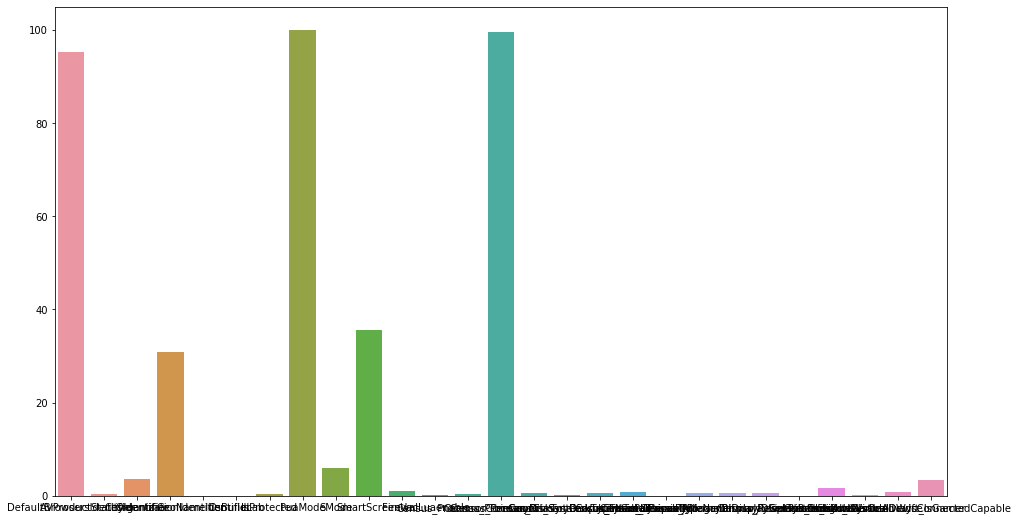

In [282]:
fig, ax = plt.subplots(1, 1, figsize=(16, 9))
sns.barplot(y=na_cols_vals.values, 
            x=na_cols_vals.index,
            ax=ax)

#### Let us take a look at the columns having majority as NA's

In [283]:
na_cols_vals_major = na_cols_vals[na_cols_vals.values > 10]

In [284]:
def shorten(x):
    if 'Census_' in x:
        x = x.replace('Census_', 'C_')
    if 'Identifier' in x:
        x = x.replace('Identifier', 'Ident')
    
    return x

In [285]:
original_na_columns = na_cols_vals_major.index.values

In [286]:
na_cols_vals_major.index = na_cols_vals_major.index.map(lambda x : shorten(x))

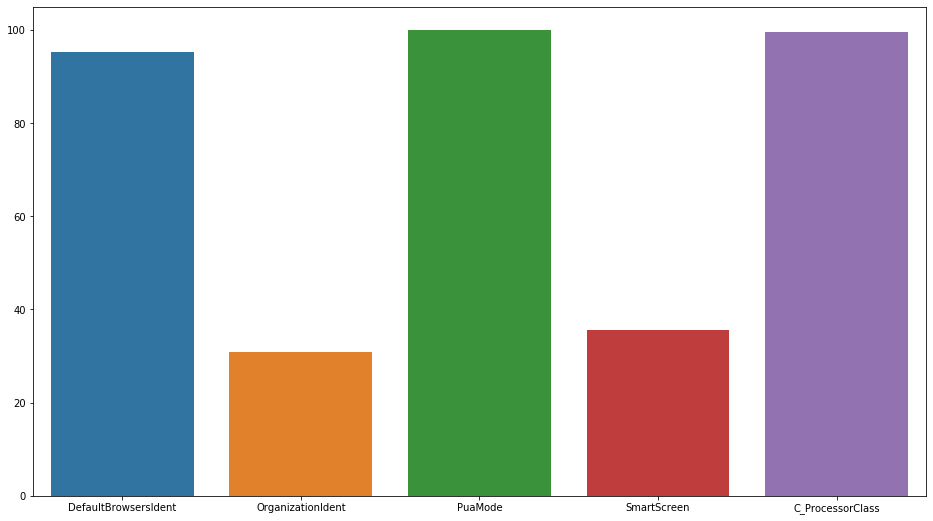

In [287]:
fig ,ax = plt.subplots(1, 1, figsize=(16, 9))
sns.barplot(x= na_cols_vals_major.index.values, y=na_cols_vals_major.values, ax=ax)

Let us remove these columns which have a significant percent of null values for now.

In [288]:
full_cols = list(original_na_columns)  + ['HasDetections']

In [289]:
train_train_new = train_train[[x for x in train.columns if x not in original_na_columns]].copy()
validation_train_new = validation_train[[x for x in train.columns if x not in original_na_columns]].copy()
test_new = test[[x for x in train.columns if x not in full_cols]].copy()

In [290]:
train_train_new.dtypes

ProductName                                          category
EngineVersion                                        category
AppVersion                                           category
AvSigVersion                                         category
IsBeta                                               category
AVProductStatesIdentifier                            category
HasTpm                                               category
CountryIdentifier                                    category
CityIdentifier                                       category
GeoNameIdentifier                                    category
LocaleEnglishNameIdentifier                          category
Platform                                             category
Processor                                            category
OsVer                                                category
OsBuild                                              category
OsSuite                                              category
OsPlatfo

In [291]:
validation_train_new.dtypes

ProductName                                          category
EngineVersion                                        category
AppVersion                                           category
AvSigVersion                                         category
IsBeta                                               category
AVProductStatesIdentifier                            category
HasTpm                                               category
CountryIdentifier                                    category
CityIdentifier                                       category
GeoNameIdentifier                                    category
LocaleEnglishNameIdentifier                          category
Platform                                             category
Processor                                            category
OsVer                                                category
OsBuild                                              category
OsSuite                                              category
OsPlatfo

In [292]:
def process_validation_types(validation_data):
    for col in validation_data.columns:
        if col != 'HasDetections':
            col_type = validation_data[col].dtype
            if (col_type == 'int8') |(col_type == 'int16') | (col_type == 'int32'):
                validation_data[col] = validation_data[col].astype('category')


In [293]:
process_validation_types(validation_train_new)

### Check out  numeric/categorical columns

Let us check out boolean columns first

In [294]:
ts = time.time()
boolean_cols = list()
for col in train_train_new.columns:
    if col != 'HasDetections':
        num_unique_entries = train_train_new[col].nunique()
        if num_unique_entries == 2:
            boolean_cols.append(col)
            
time.time() - ts
        

3.2596161365509033

In [295]:
boolean_cols

['IsBeta',
 'HasTpm',
 'IsProtected',
 'AutoSampleOptIn',
 'SMode',
 'Firewall',
 'Census_HasOpticalDiskDrive',
 'Census_IsPortableOperatingSystem',
 'Census_IsFlightsDisabled',
 'Census_IsSecureBootEnabled',
 'Census_IsVirtualDevice',
 'Census_IsTouchEnabled',
 'Census_IsPenCapable',
 'Census_IsAlwaysOnAlwaysConnectedCapable',
 'Wdft_IsGamer']

In [296]:
def check_float_or_int(given_val):
    try :
        val = float(given_val)
    except ValueError:
        return False
    return True

In [297]:
check_float_or_int('124.1')

True

In [298]:
ts = time.time()
numeric_cols = list()
categorical_cols = list()
for col in train_train_new.columns: 
    if col not in ['HasDetections'] + boolean_cols :
        numeric_or_not = train_train_new[col].apply(lambda x : check_float_or_int(x)).all()
        if numeric_or_not:
            numeric_cols.append(col)
        else:
            categorical_cols.append(col)
time.time() - ts

33.402454137802124

In [299]:
numeric_cols

['AVProductStatesIdentifier',
 'CountryIdentifier',
 'CityIdentifier',
 'GeoNameIdentifier',
 'LocaleEnglishNameIdentifier',
 'OsBuild',
 'OsSuite',
 'UacLuaenable',
 'Census_ProcessorCoreCount',
 'Census_PrimaryDiskTotalCapacity',
 'Census_SystemVolumeTotalCapacity',
 'Census_TotalPhysicalRAM',
 'Census_InternalPrimaryDiagonalDisplaySizeInInches',
 'Census_InternalPrimaryDisplayResolutionHorizontal',
 'Census_InternalPrimaryDisplayResolutionVertical',
 'Census_OSBuildNumber',
 'Census_OSBuildRevision']

In [300]:
categorical_cols

['ProductName',
 'EngineVersion',
 'AppVersion',
 'AvSigVersion',
 'Platform',
 'Processor',
 'OsVer',
 'OsPlatformSubRelease',
 'OsBuildLab',
 'SkuEdition',
 'Census_MDC2FormFactor',
 'Census_DeviceFamily',
 'Census_PrimaryDiskTypeName',
 'Census_ChassisTypeName',
 'Census_PowerPlatformRoleName',
 'Census_OSVersion',
 'Census_OSArchitecture',
 'Census_OSBranch',
 'Census_OSEdition',
 'Census_OSSkuName',
 'Census_OSInstallTypeName',
 'Census_OSWUAutoUpdateOptionsName',
 'Census_GenuineStateName',
 'Census_ActivationChannel',
 'Census_FlightRing']

In [301]:
print('Number of numerical columns is ', len(numeric_cols))
print('Number of categorical columns is ', len(categorical_cols))   
print('Number of boolean columns is ', len(boolean_cols))

Number of numerical columns is  17
Number of categorical columns is  25
Number of boolean columns is  15


In [302]:
train_train_new['AVProductStatesIdentifier'].describe() 

count     7108298
unique      25560
top         53447
freq      4659262
Name: AVProductStatesIdentifier, dtype: object

In [303]:
train_train_new['UacLuaenable'].unique() 

[1, 0, NaN, 6357062, 48, ..., 2, 49, 16777216, 5, 255]
Length: 11
Categories (10, object): [1, 0, 6357062, 48, ..., 49, 16777216, 5, 255]

In [304]:
train_train_new['Census_OSBuildRevision'].describe()

count     7137186
unique        277
top           228
freq      1131329
Name: Census_OSBuildRevision, dtype: object

Only columns that 'really' numeric are the following :


'Census_ProcessorCoreCount'

'Census_SystemVolumeTotalCapacity',

'Census_TotalPhysicalRAM',

'Census_InternalPrimaryDiagonalDisplaySizeInInches',

'Census_InternalPrimaryDisplayResolutionHorizontal',

'Census_InternalPrimaryDisplayResolutionVertical',


Let us write down some helper functions before we continue our analysis.

In [305]:
def process_string(str_val):
    if '.' in str_val:
        val = str_val.replace('.', '')
    else:
        val = str_val + '0'
    return val

In [306]:
def replace_with_int_mean(data, val_data, col_name, cast_type='int32'):
    if cast_type == 'int32':
        mean_val = data[col_name][
            data[col_name].notna()].astype('int32').mean()
    elif cast_type == 'int8':
        mean_val = data[col_name][
            data[col_name].notna()].astype('int8').mean()
    elif cast_type == 'int32_with_scientific':
        mean_val = data[col_name][
            data[col_name].notna()].apply(lambda x : int(float(x))).astype('int32').mean()
    elif cast_type == 'int16_with_decimal':
        mean_val = data[col_name][
            data[col_name].notna()].apply(lambda x : process_string(x)).astype('int16').mean()

    print('Old mean (before replacement) in train is {:.2f}'.format(mean_val))
    str_mean_val = str(int(mean_val))
    
    if str_mean_val not in data[col_name].cat.categories:
        data[col_name] = \
            data[col_name].cat.add_categories(str_mean_val)
    if str_mean_val not in val_data[col_name].cat.categories:
        val_data[col_name] = \
            val_data[col_name].cat.add_categories(str_mean_val)

    data[col_name].fillna(value=str_mean_val, inplace=True)    
    val_data[col_name].fillna(value=str_mean_val,  inplace=True)
    
    if cast_type == 'int32':
        data[col_name] = \
            data[col_name].astype('int32')
        val_data[col_name] = \
            val_data[col_name].astype('int32')
        
    elif cast_type == 'int8':
        data[col_name] = \
            data[col_name].astype('int8')
        val_data[col_name] = \
            val_data[col_name].astype('int8')
    elif cast_type == 'int32_with_scientific':
        data[col_name] = data[col_name].apply(lambda x : int(float(x))).astype('int32')
        val_data[col_name] = val_data[col_name].apply(lambda x : int(float(x))).astype('int32')        
    elif cast_type == 'int16_with_decimal':
        data[col_name] = data[col_name].apply(lambda x : process_string(x)).astype('int16')
        val_data[col_name] = val_data[col_name].apply(lambda x : process_string(x)).astype('int16')    

        
    print('New mean (after replacement) in train is {:.2f}'.format(data[col_name].mean()))    
    

In [307]:
def replace_with_new_NA_category(data, val_data, col_name):
    if 'NAN' not in data[col_name].cat.categories:
        data[col_name] = \
            data[col_name].cat.add_categories('NAN')
    if 'NAN' not in val_data[col_name].cat.categories:
        val_data[col_name] = \
            val_data[col_name].cat.add_categories('NAN')

    data[col_name].fillna(value='NAN', inplace=True)    
    val_data[col_name].fillna(value='NAN', inplace=True)        


In [308]:
def replace_with_most_frequent_val(data, val_data, col_name):
    most_frequent_val = data[col_name].mode().values[0]
    print('Most frequent value is ', most_frequent_val)
    data[col_name].fillna(value=most_frequent_val, inplace=True)    
    val_data[col_name].fillna(value=most_frequent_val, inplace=True)        


In [309]:
def verify_validation_and_test_column(validation_data, test_data, col_name, cast_type='int32'):
    if cast_type == 'int32':
        validation_mean = validation_data[col_name][
            validation_data[col_name].notna()].astype('int32').mean()
        test_mean = test_data[col_name][
            test_data[col_name].notna()].astype('int32').mean()
    elif cast_type == 'int8':
        validation_mean = validation_data[col_name][
            validation_data[col_name].notna()].astype('int8').mean()
        test_mean = test_data[col_name][
            test_data[col_name].notna()].astype('int8').mean()
    elif cast_type == 'int32_with_scientific':
        validation_mean = validation_data[col_name][
            validation_data[col_name].notna()].apply(lambda x : int(float(x))).astype('int32').mean()
        test_mean = test_data[col_name][
            test_data[col_name].notna()].apply(lambda x : int(float(x))).astype('int32').mean()
    elif cast_type == 'int16_with_decimal':
        validation_mean = validation_data[col_name][
            validation_data[col_name].notna()].apply(lambda x : process_string(x)).astype('int16').mean()
        test_mean = test_data[col_name][
            test_data[col_name].notna()].apply(lambda x : process_string(x)).astype('int16').mean()
    
    print('Mean in validation data for column ' + col_name + ' is {:.2f}'.format(validation_mean))
    print('Mean in test data for column ' + col_name + ' is {:.2f}'.format(test_mean))        
    

In [310]:
def modify_train_set(data, test_data):
    
    # The lines which are commented out show the cases where no NA values were present
    # for that particular column and hence no handling was required.

    # Replace NA with the most frequent value, as this present in more than 50% of the cases.
    replace_with_int_mean(data, test_data, 'Census_ProcessorCoreCount', 'int8')

    # Replace NA with mean of non NA values. Make sure that type is changed accordingly.
    replace_with_int_mean(data, test_data, 'Census_SystemVolumeTotalCapacity')

    replace_with_int_mean(data, test_data, 'Census_TotalPhysicalRAM')
    
    replace_with_int_mean(data, test_data, 'Census_PrimaryDiskTotalCapacity', 'int32_with_scientific')    
    
    replace_with_int_mean(data, test_data, 'Census_InternalPrimaryDiagonalDisplaySizeInInches', 'int16_with_decimal')        

    replace_with_int_mean(data, test_data, 'Census_InternalPrimaryDisplayResolutionHorizontal')

    replace_with_int_mean(data, test_data, 'Census_InternalPrimaryDisplayResolutionVertical')    
    
    
    replace_with_new_NA_category(data, test_data, 'AVProductStatesIdentifier')
    
    #replace_with_new_NA_category(data, 'CountryIdentifier')
    
    replace_with_new_NA_category(data, test_data, 'CityIdentifier')
    
    replace_with_new_NA_category(data, test_data, 'GeoNameIdentifier')    
    
    #replace_with_new_NA_category(data, 'LocaleEnglishNameIdentifier')        

    
    #replace_with_new_NA_category(data, 'OsBuild')

    #replace_with_new_NA_category(data, 'OsSuite')

    replace_with_new_NA_category(data, test_data, 'UacLuaenable')
    
    #replace_with_new_NA_category(data, 'Census_OSBuildNumber')
    
    #replace_with_new_NA_category(data, 'Census_OSBuildRevision')
    
    replace_with_new_NA_category(data, test_data, 'OsBuildLab')
    
    replace_with_new_NA_category(data, test_data, 'Census_PrimaryDiskTypeName')
        
    replace_with_new_NA_category(data, test_data, 'Census_ChassisTypeName')
    
    replace_with_new_NA_category(data, test_data, 'Census_PowerPlatformRoleName')    
    

In [311]:
def print_summary(data, col_name, title='Train data'):
    print("###### Data description for " + col_name + ' in ' + title + " ########\n", data[col_name].describe(), '\n')
    print('Percentage of NA values is ', data[col_name].isna().sum() * 100/len(data), '\n')
    

In [312]:
def basic_stats_and_plot(data, col_name, title='Train data', num_entries=50):
    
    group_df = data[[col_name]].groupby([col_name]).size()
    if len(group_df) > num_entries:
        top_items = group_df.sort_values(ascending=False)[0:num_entries]*100/len(data)
    else:
        top_items = group_df.sort_values(ascending=False)*100/len(data)
    
    fig, ax = plt.subplots(1, 1, figsize=(16,9 ))
    sns.scatterplot(data=top_items, ax=ax)
    ax.set_title('Grouped distribution for values of column ' + col_name + ' taken from ' + title)
    ax.set_xlabel('Values of ' + col_name) 
    ax.set_ylabel('Percentage occurences')

##### Analysis of numeric columns.

For every numeric column, we do the following :

1. Plot a grouped representation of the data using the function defined above.
2. Replace NA's with mean value.
3. Plot grouped representations of validation and test data sets to make sure that they look approximately from the same distribution. 

In [313]:
def handle_numeric_data(train_data, validation_data, full_train, full_test, col_name, cast_type='int32'):

    print_summary(train_data, col_name, title='Train data')
    
    print_summary(validation_data, col_name, title='Validation data')    
    
    print_summary(full_train, col_name, title='Full train data')        

    print_summary(full_test, col_name, title='Full Test data')        
    
    # Replace nan's with mean value.
    replace_with_int_mean(train_data, validation_data, col_name, cast_type)

    # Replace nan's with mean value.
    replace_with_int_mean(full_train, full_test, col_name, cast_type)
    
    
    # Compute basic metrics and plot train data
    basic_stats_and_plot(train_data, col_name)
    
    basic_stats_and_plot(validation_data, col_name, title='Validation data')
    
    basic_stats_and_plot(full_train, col_name, title='Full train data')        
    
    
    basic_stats_and_plot(full_test, col_name, title='Full Test data')            
    
    

###### Data description for Census_ProcessorCoreCount in Train data ########
 count     7104202
unique         44
top             4
freq      4344527
Name: Census_ProcessorCoreCount, dtype: object 

Percentage of NA values is  0.4621429229951412 

###### Data description for Census_ProcessorCoreCount in Validation data ########
 count     1775975
unique         34
top             4
freq      1085666
Name: Census_ProcessorCoreCount, dtype: object 

Percentage of NA values is  0.4664021740775218 

###### Data description for Census_ProcessorCoreCount in Full train data ########
 count     8880177
unique         45
top             4
freq      5430193
Name: Census_ProcessorCoreCount, dtype: object 

Percentage of NA values is  0.4629947734025834 

###### Data description for Census_ProcessorCoreCount in Full Test data ########
 count     7791976
unique         45
top             4
freq      4646102
Name: Census_ProcessorCoreCount, dtype: object 

Percentage of NA values is  0.7802753839714

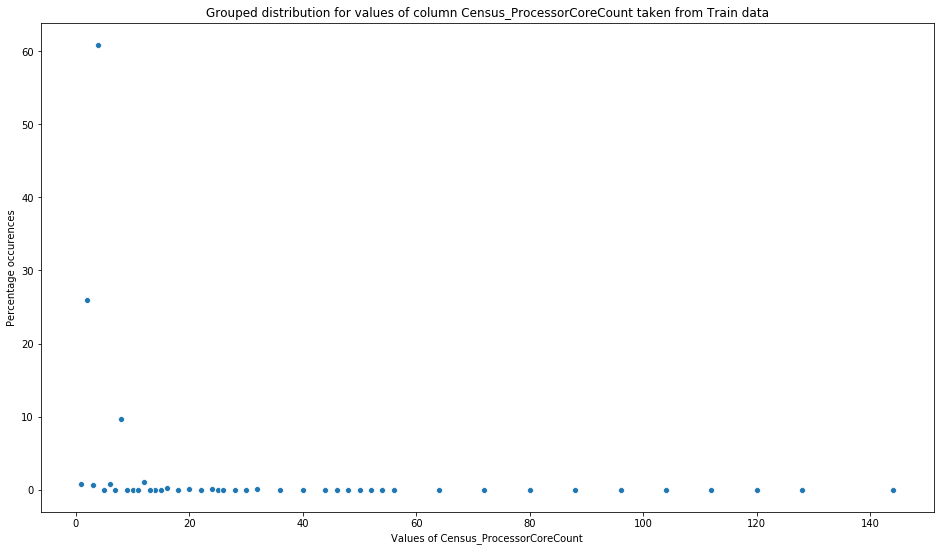

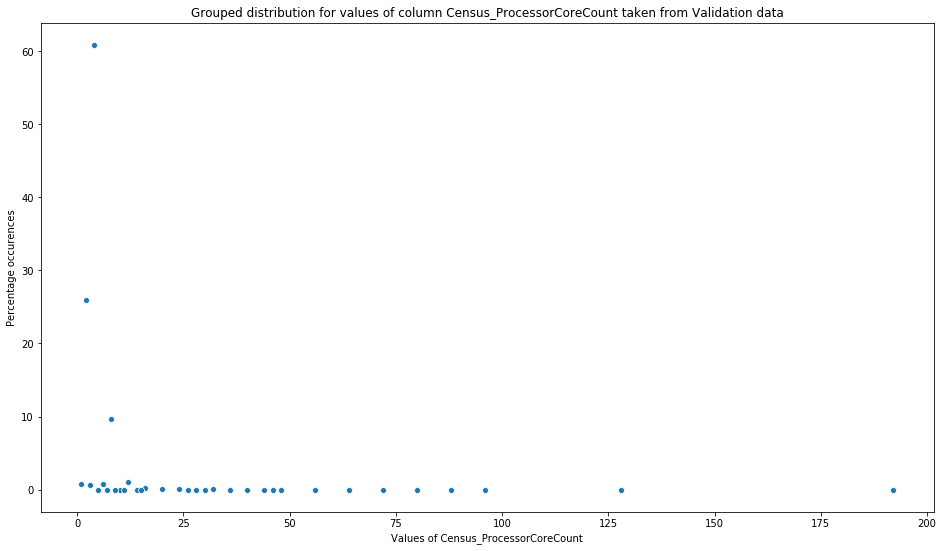

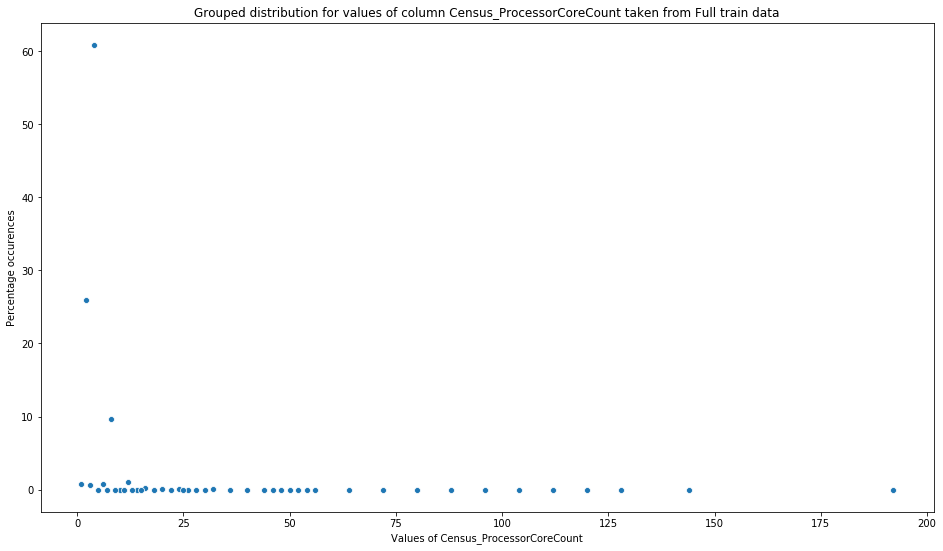

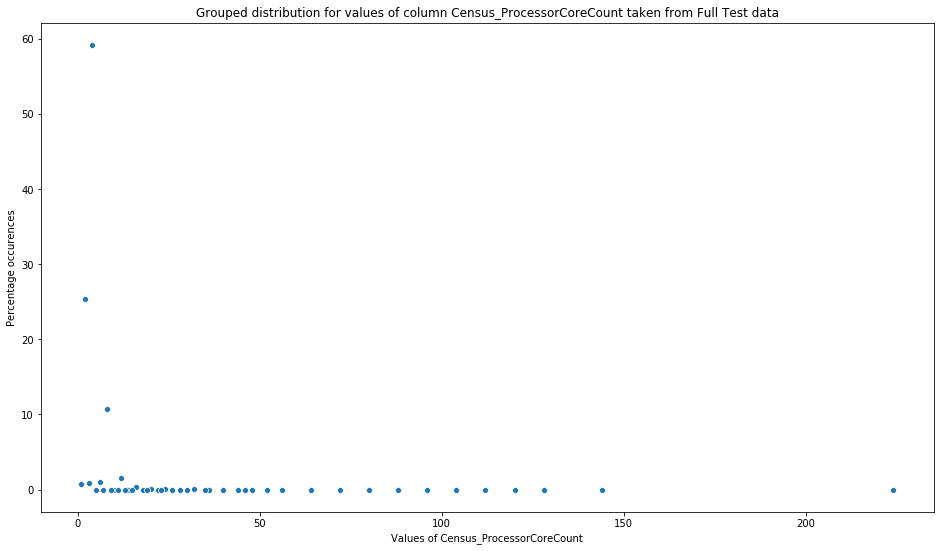

In [314]:
REL_COL = 'Census_ProcessorCoreCount'
handle_numeric_data(train_train_new, validation_train_new, train, test, REL_COL, 'int32')

Let us go to the next item, Census_SystemVolumeTotalCapacity

###### Data description for Census_SystemVolumeTotalCapacity in Train data ########
 count     7094895
unique     500602
top         28542
freq        41564
Name: Census_SystemVolumeTotalCapacity, dtype: object 

Percentage of NA values is  0.5925444565967596 

###### Data description for Census_SystemVolumeTotalCapacity in Validation data ########
 count     1773586
unique     286847
top         28542
freq        10434
Name: Census_SystemVolumeTotalCapacity, dtype: object 

Percentage of NA values is  0.6002924401038616 

###### Data description for Census_SystemVolumeTotalCapacity in Full train data ########
 count     8868481
unique     536848
top         28542
freq        51998
Name: Census_SystemVolumeTotalCapacity, dtype: object 

Percentage of NA values is  0.5940940536455654 

###### Data description for Census_SystemVolumeTotalCapacity in Full Test data ########
 count     7778563
unique     509175
top        476389
freq        56295
Name: Census_SystemVolumeTotalCapacity, dty

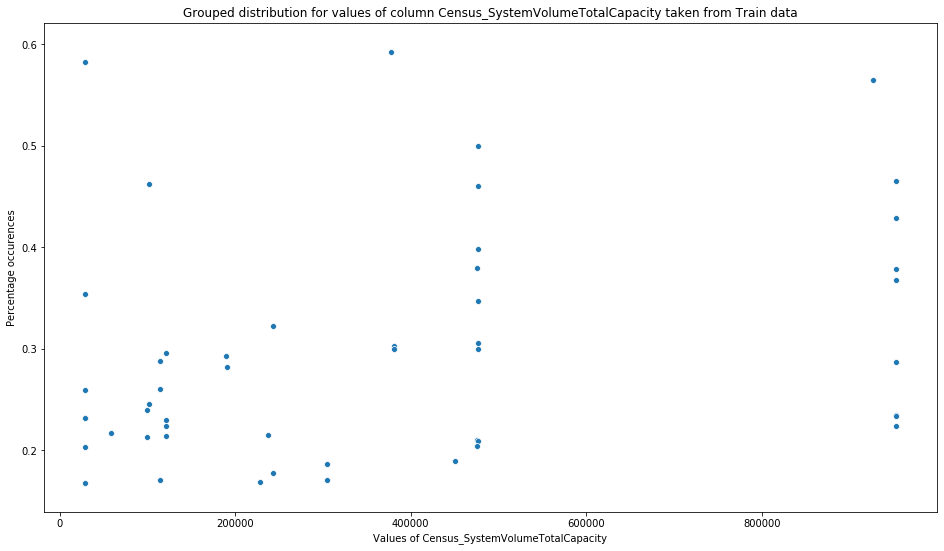

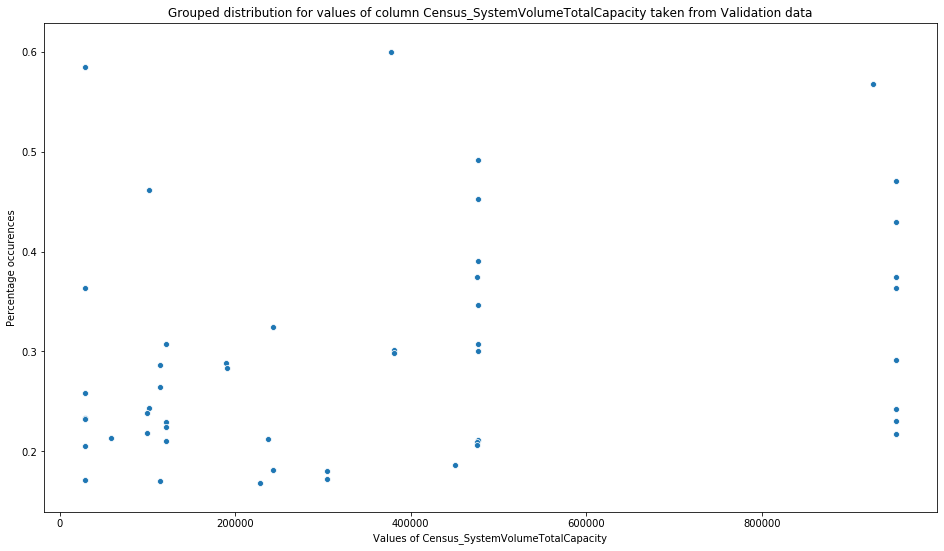

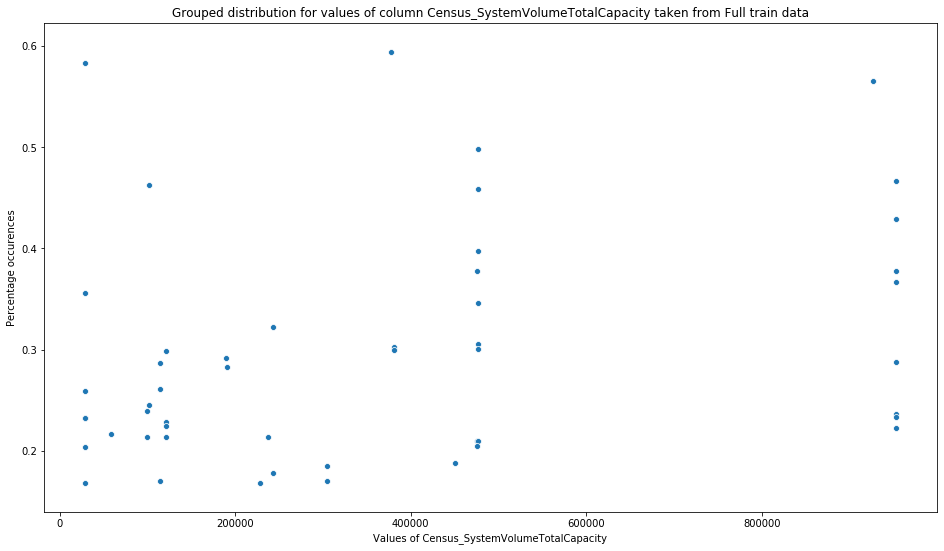

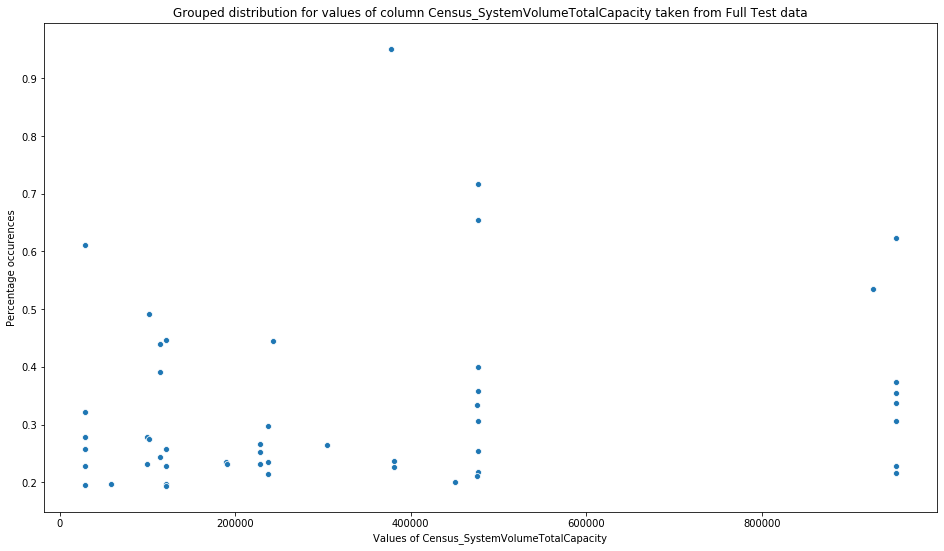

In [315]:
REL_COL = 'Census_SystemVolumeTotalCapacity'

handle_numeric_data(train_train_new, validation_train_new, train, test, REL_COL)

Let us look at Physical RAM !

###### Data description for Census_TotalPhysicalRAM in Train data ########
 count     7072826
unique       2995
top          4096
freq      3276038
Name: Census_TotalPhysicalRAM, dtype: object 

Percentage of NA values is  0.9017559581605411 

###### Data description for Census_TotalPhysicalRAM in Validation data ########
 count     1768124
unique       1320
top          4096
freq       818474
Name: Census_TotalPhysicalRAM, dtype: object 

Percentage of NA values is  0.9064073974231869 

###### Data description for Census_TotalPhysicalRAM in Full train data ########
 count     8840950
unique       3446
top          4096
freq      4094512
Name: Census_TotalPhysicalRAM, dtype: object 

Percentage of NA values is  0.9026862462216203 

###### Data description for Census_TotalPhysicalRAM in Full Test data ########
 count     7758202
unique       3700
top          4096
freq      3529277
Name: Census_TotalPhysicalRAM, dtype: object 

Percentage of NA values is  1.2103392059316056 

Old mean (

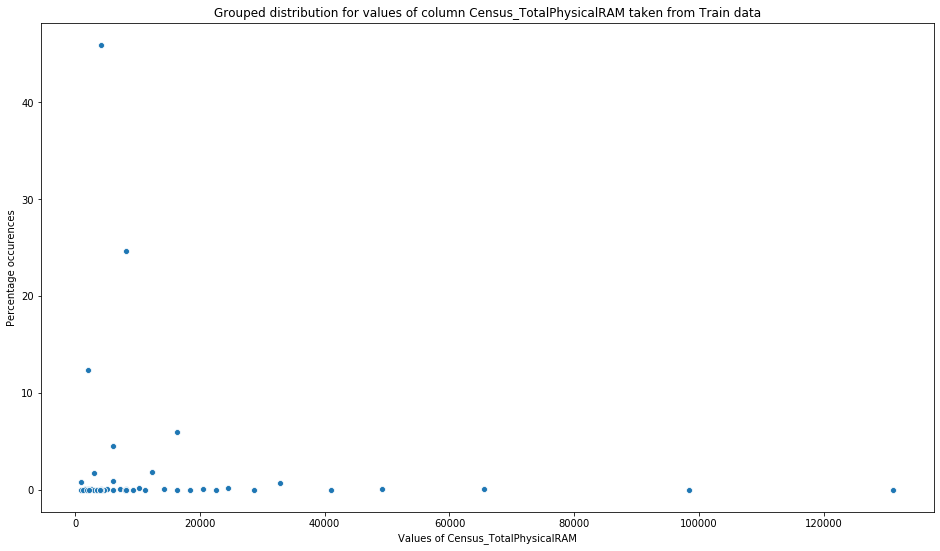

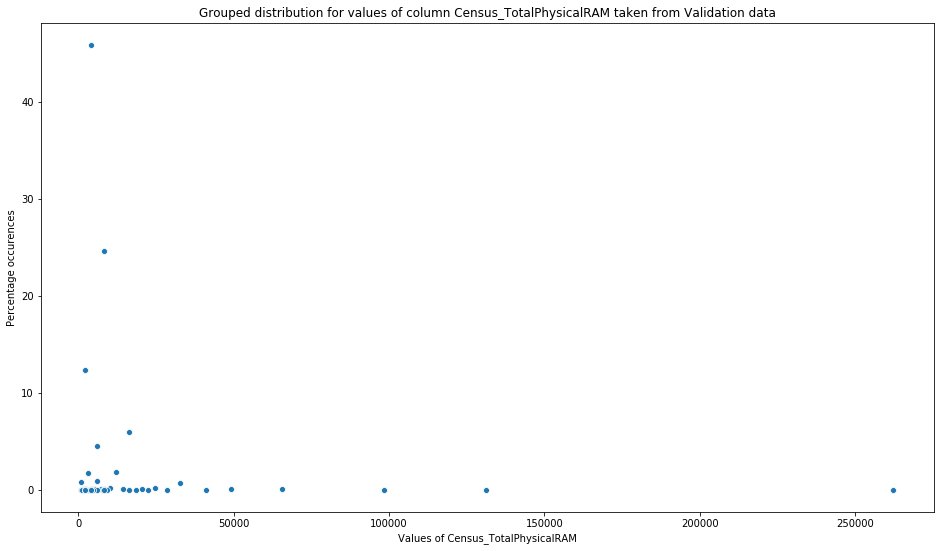

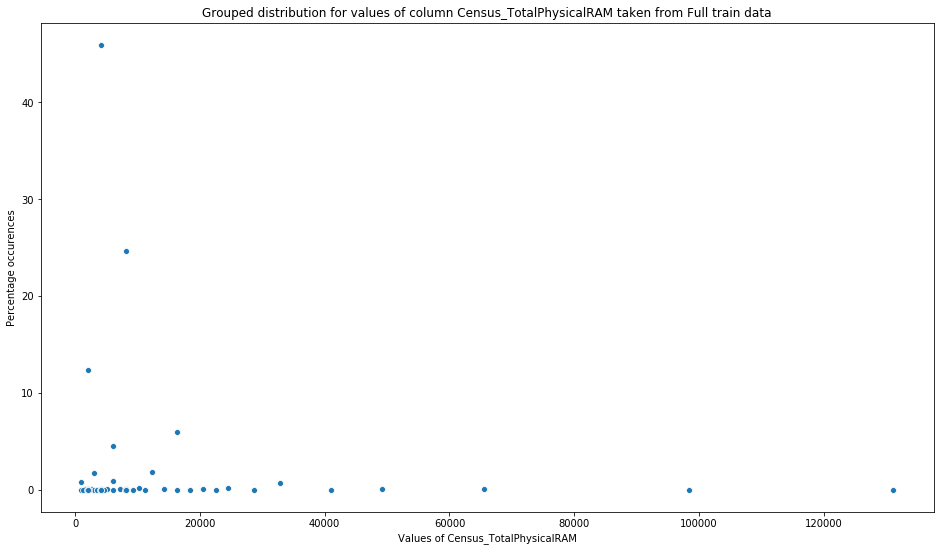

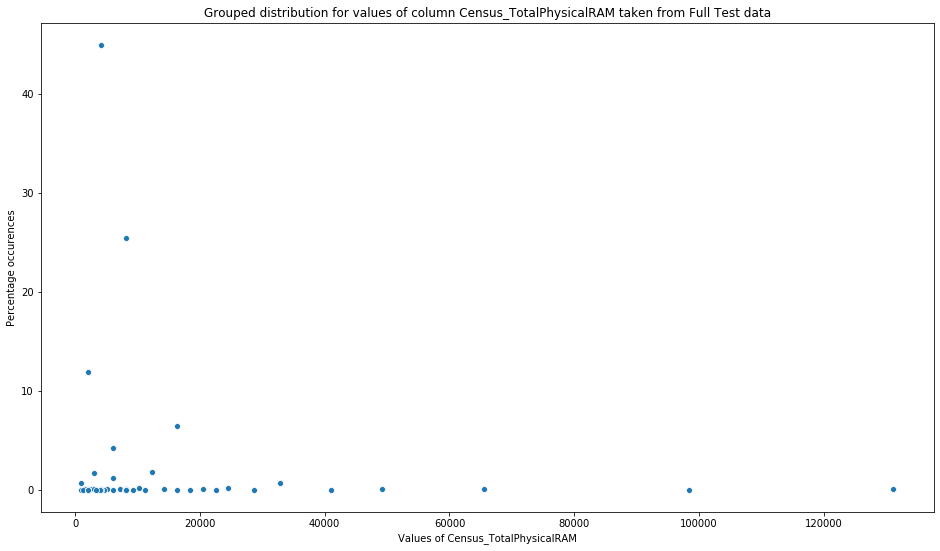

In [316]:
REL_COL = 'Census_TotalPhysicalRAM'
handle_numeric_data(train_train_new, validation_train_new, train, test, REL_COL)

###### Data description for Census_PrimaryDiskTotalCapacity in Train data ########
 count     7094884
unique       4992
top        476940
freq      2274068
Name: Census_PrimaryDiskTotalCapacity, dtype: object 

Percentage of NA values is  0.5926985789637541 

###### Data description for Census_PrimaryDiskTotalCapacity in Validation data ########
 count     1773583
unique       2254
top        476940
freq       567462
Name: Census_PrimaryDiskTotalCapacity, dtype: object 

Percentage of NA values is  0.6004605735480136 

###### Data description for Census_PrimaryDiskTotalCapacity in Full train data ########
 count     8868467
unique       5735
top        476940
freq      2841530
Name: Census_PrimaryDiskTotalCapacity, dtype: object 

Percentage of NA values is  0.5942509782286196 

###### Data description for Census_PrimaryDiskTotalCapacity in Full Test data ########
 count     7778552
unique       5797
top        476940
freq      2389604
Name: Census_PrimaryDiskTotalCapacity, dtype: obje

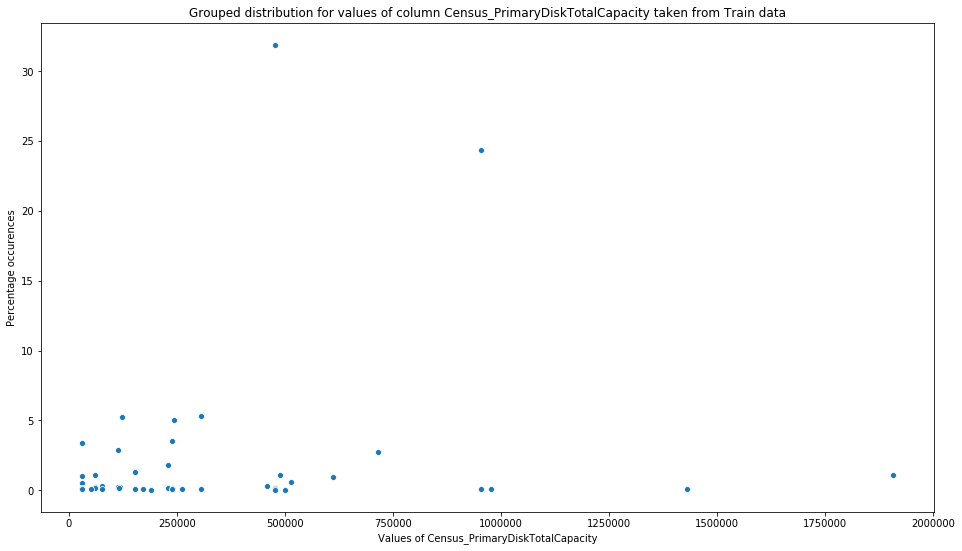

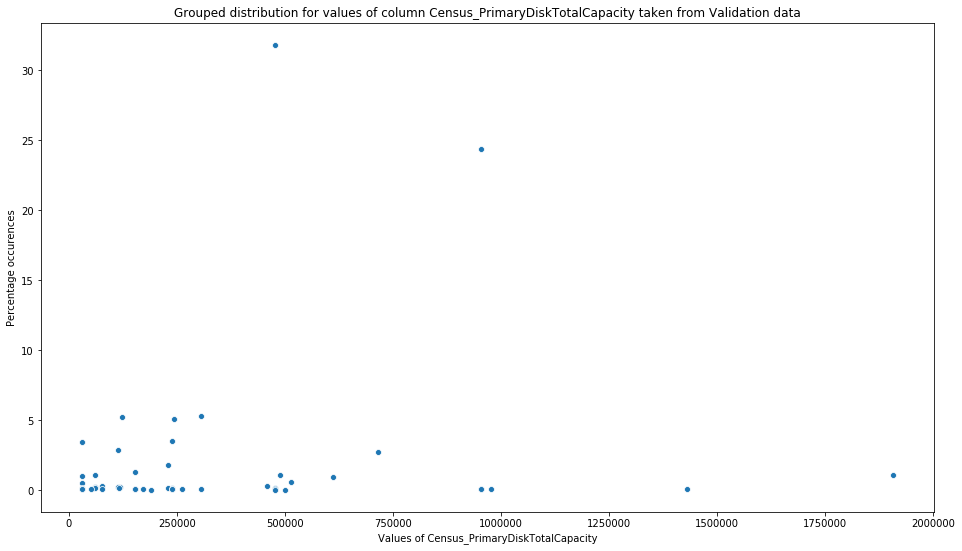

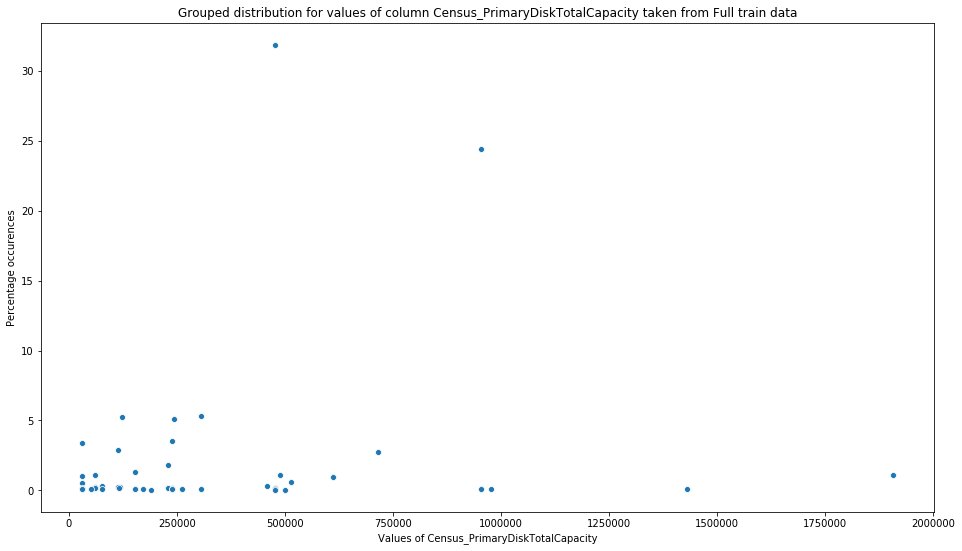

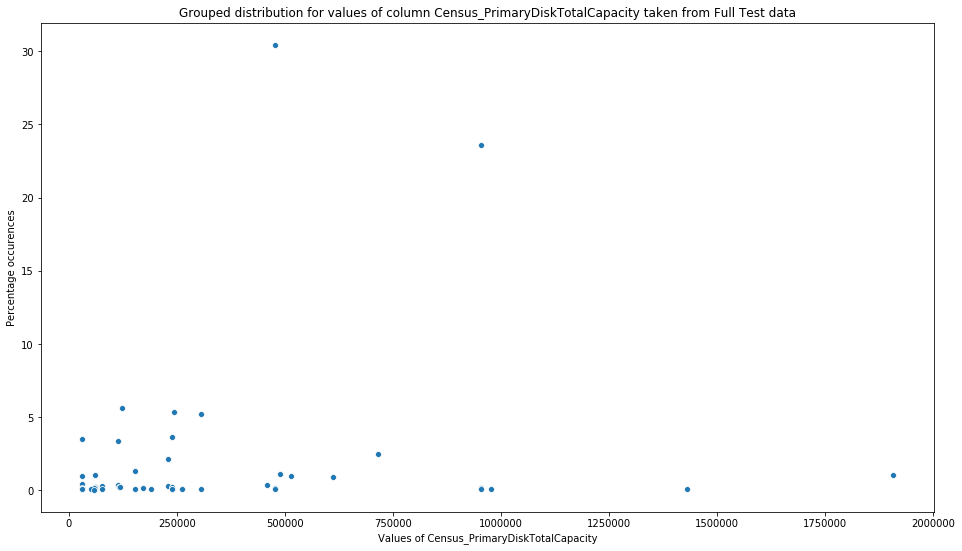

In [317]:
REL_COL = 'Census_PrimaryDiskTotalCapacity'

handle_numeric_data(train_train_new, validation_train_new, train, test, REL_COL, 'int32_with_scientific')

###### Data description for Census_InternalPrimaryDiagonalDisplaySizeInInches in Train data ########
 count     7099311
unique        765
top          15.5
freq      2438138
Name: Census_InternalPrimaryDiagonalDisplaySizeInInches, dtype: object 

Percentage of NA values is  0.5306713318106043 

###### Data description for Census_InternalPrimaryDiagonalDisplaySizeInInches in Validation data ########
 count     1775038
unique        648
top          15.5
freq       609293
Name: Census_InternalPrimaryDiagonalDisplaySizeInInches, dtype: object 

Percentage of NA values is  0.5189158531343157 

###### Data description for Census_InternalPrimaryDiagonalDisplaySizeInInches in Full train data ########
 count     8874349
unique        785
top          15.5
freq      3047431
Name: Census_InternalPrimaryDiagonalDisplaySizeInInches, dtype: object 

Percentage of NA values is  0.5283202355482827 

###### Data description for Census_InternalPrimaryDiagonalDisplaySizeInInches in Full Test data ######

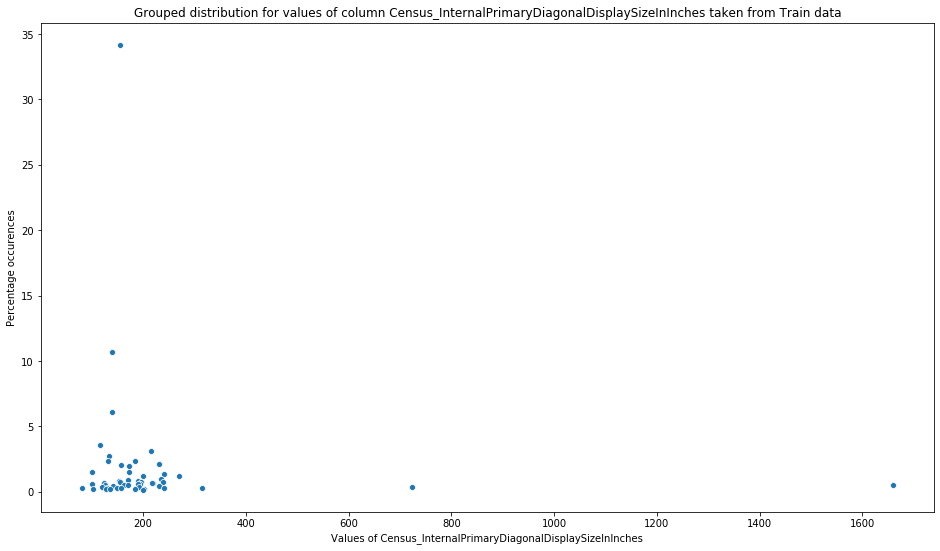

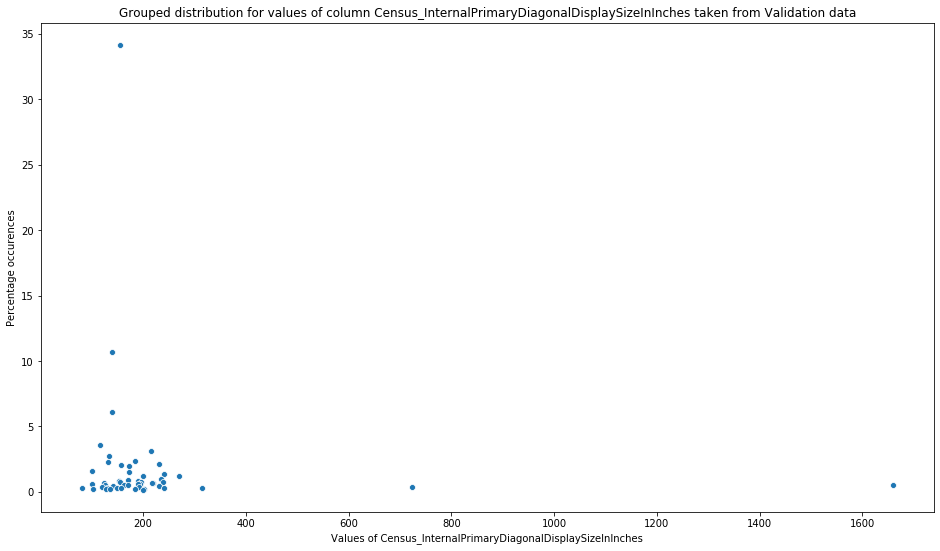

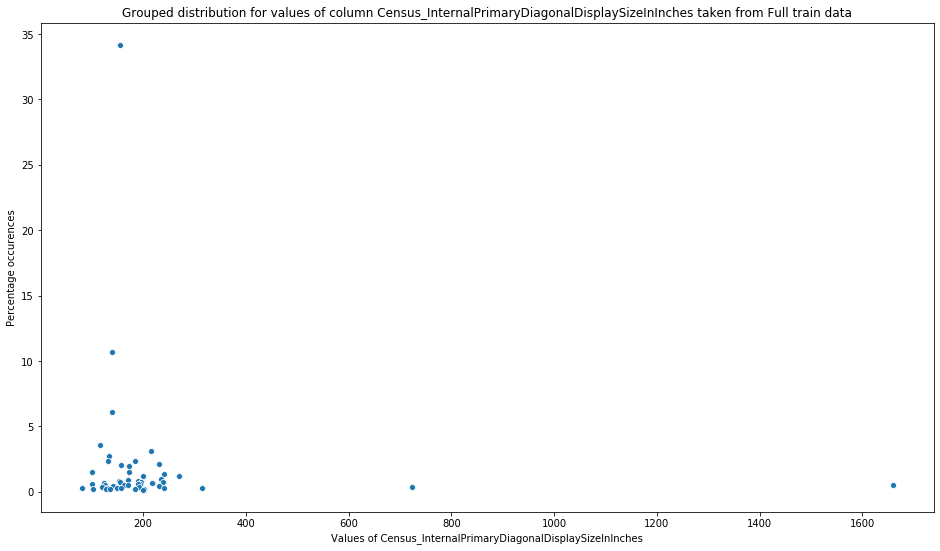

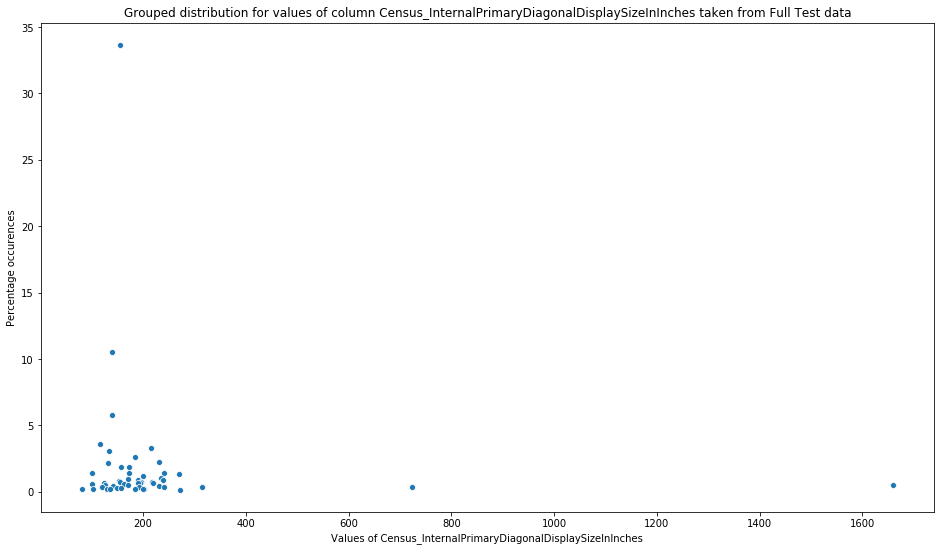

In [318]:
REL_COL = 'Census_InternalPrimaryDiagonalDisplaySizeInInches'

handle_numeric_data(train_train_new, validation_train_new, train, test, REL_COL, 'int16_with_decimal')

###### Data description for Census_InternalPrimaryDisplayResolutionHorizontal in Train data ########
 count     7099431
unique       2033
top          1366
freq      3611558
Name: Census_InternalPrimaryDisplayResolutionHorizontal, dtype: object 

Percentage of NA values is  0.5289899968979371 

###### Data description for Census_InternalPrimaryDisplayResolutionHorizontal in Validation data ########
 count     1775066
unique       1076
top          1366
freq       903506
Name: Census_InternalPrimaryDisplayResolutionHorizontal, dtype: object 

Percentage of NA values is  0.5173466076555641 

###### Data description for Census_InternalPrimaryDisplayResolutionHorizontal in Full train data ########
 count     8874497
unique       2180
top          1366
freq      4515064
Name: Census_InternalPrimaryDisplayResolutionHorizontal, dtype: object 

Percentage of NA values is  0.5266613185274241 

###### Data description for Census_InternalPrimaryDisplayResolutionHorizontal in Full Test data ######

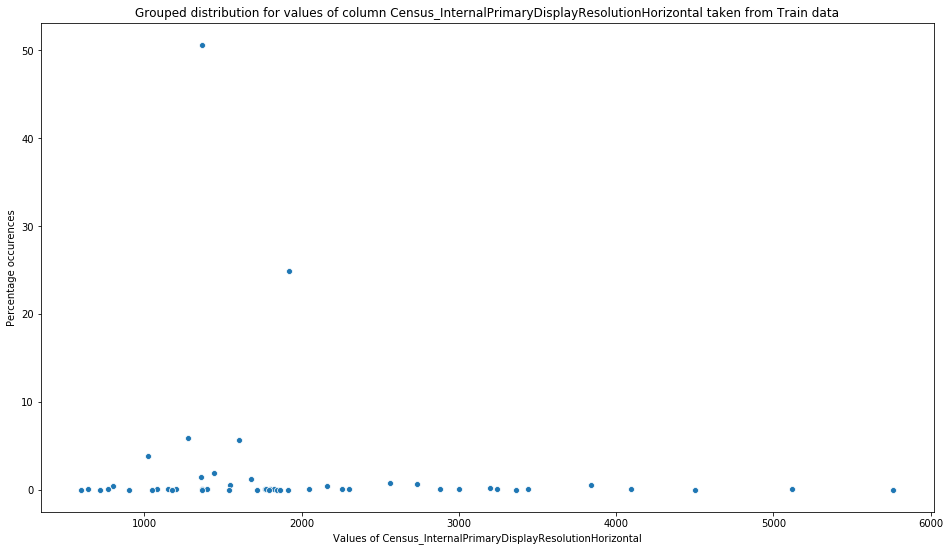

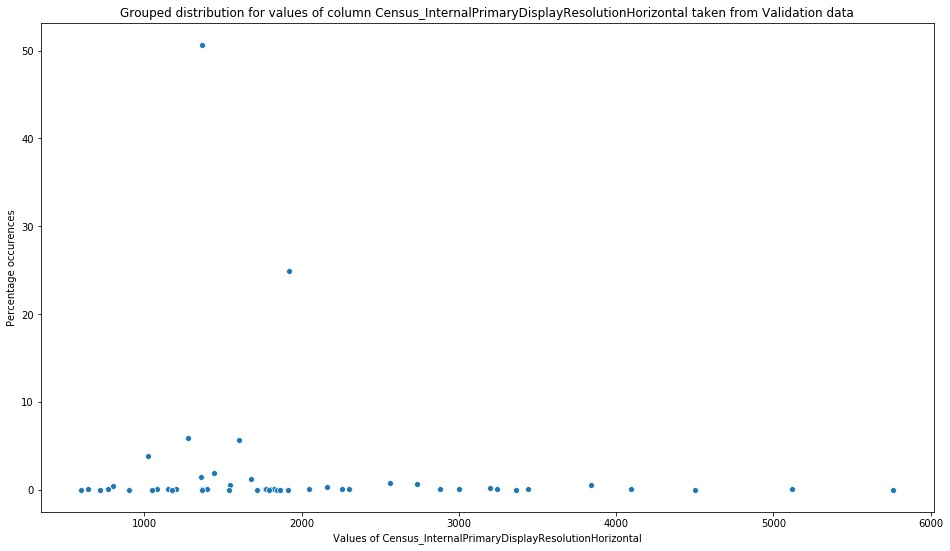

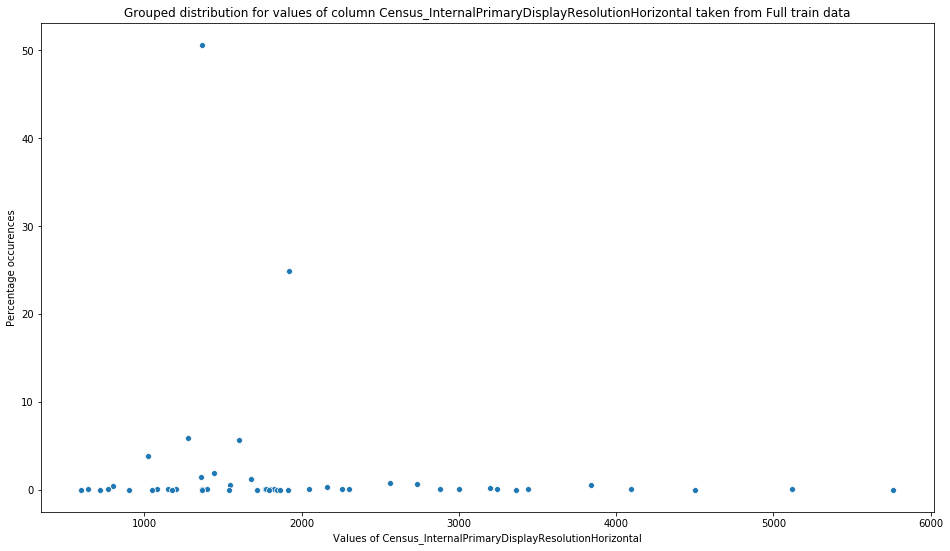

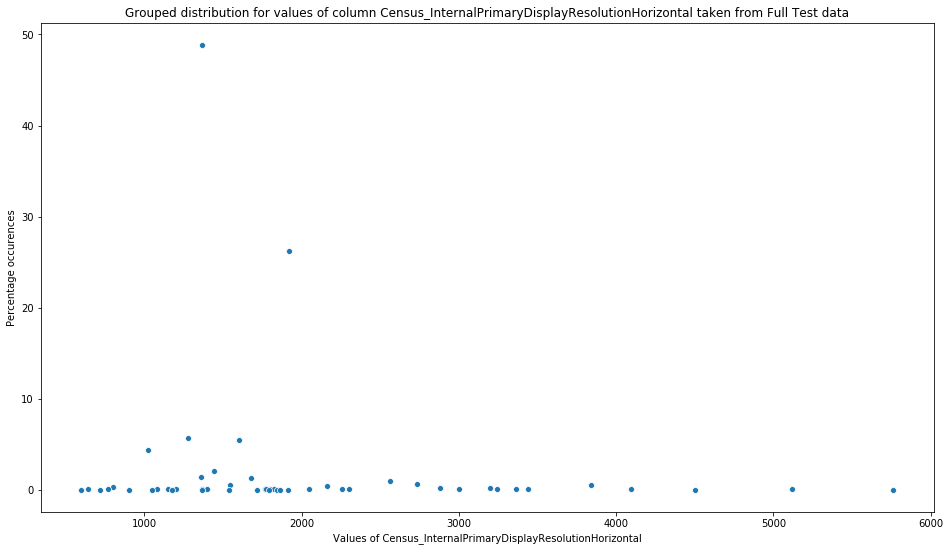

In [319]:
REL_COL = 'Census_InternalPrimaryDisplayResolutionHorizontal'

handle_numeric_data(train_train_new, validation_train_new, train, test, REL_COL, 'int32')

###### Data description for Census_InternalPrimaryDisplayResolutionVertical in Train data ########
 count     7099431
unique       1479
top           768
freq      3978802
Name: Census_InternalPrimaryDisplayResolutionVertical, dtype: object 

Percentage of NA values is  0.5289899968979371 

###### Data description for Census_InternalPrimaryDisplayResolutionVertical in Validation data ########
 count     1775066
unique        954
top           768
freq       994819
Name: Census_InternalPrimaryDisplayResolutionVertical, dtype: object 

Percentage of NA values is  0.5173466076555641 

###### Data description for Census_InternalPrimaryDisplayResolutionVertical in Full train data ########
 count     8874497
unique       1560
top           768
freq      4973621
Name: Census_InternalPrimaryDisplayResolutionVertical, dtype: object 

Percentage of NA values is  0.5266613185274241 

###### Data description for Census_InternalPrimaryDisplayResolutionVertical in Full Test data ########
 count     

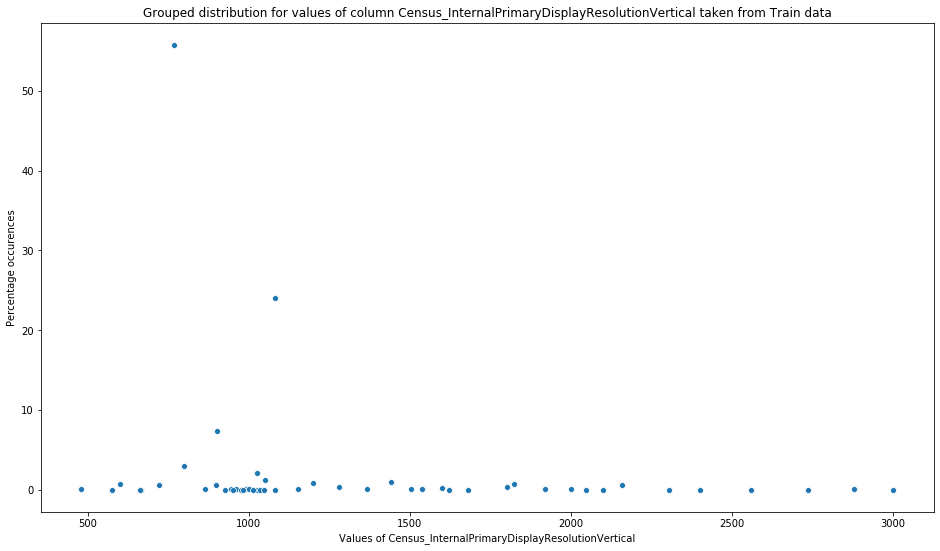

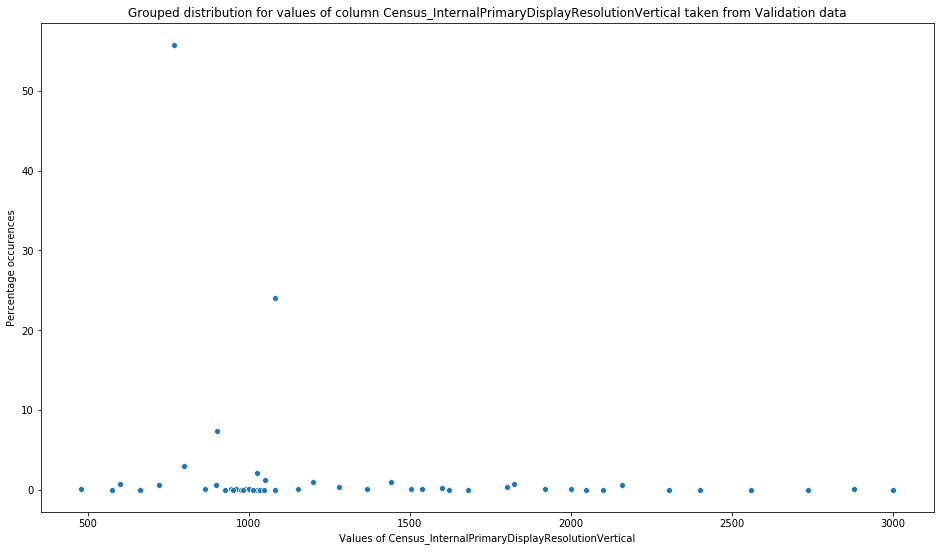

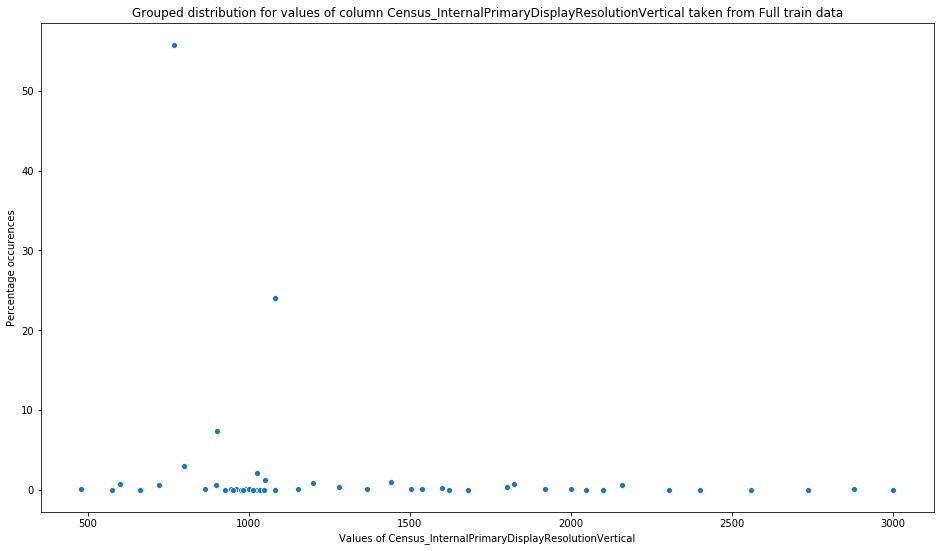

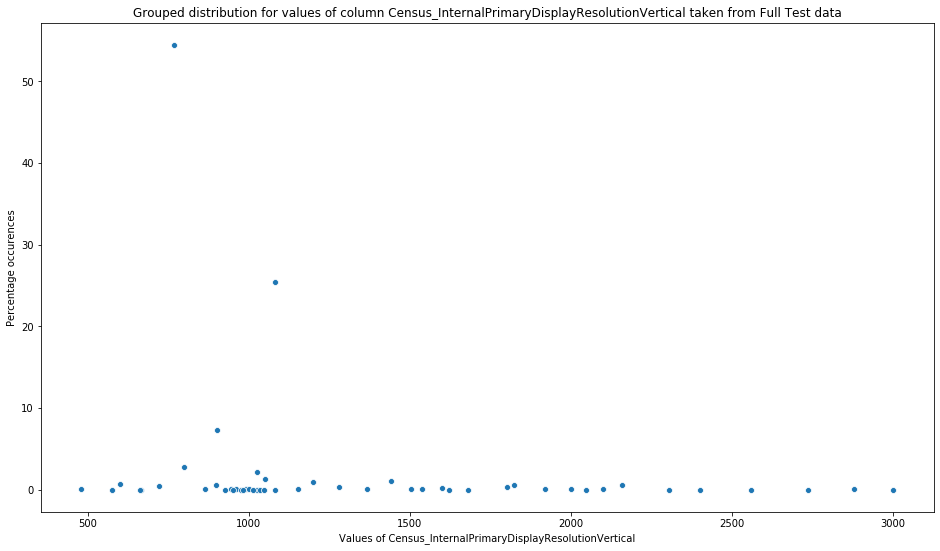

In [320]:
REL_COL = 'Census_InternalPrimaryDisplayResolutionVertical' 

handle_numeric_data(train_train_new, validation_train_new, train, test, REL_COL, 'int32')

##### Analysis of categorical columns.

For every categorical column, we do the following :

1. Plot a grouped representation of the data.
2. Replace NA's with another category named 'NA'
3. Plot grouped representations of validation and test data sets to make sure that they look approximately from the same distribution. 

In [321]:
def handle_categorical_data(train_data, validation_data, full_train, full_test, col_name, num_entries=10):

    print_summary(train_data, col_name, title='Train data')
    
    print_summary(validation_data, col_name, title='Validation data')    
    
    print_summary(full_train, col_name, title='Full train data')        
    
    print_summary(full_test, col_name, title='Full test data')        

    
    # Replace with a new category named 'NA'
    replace_with_new_NA_category(train_data, validation_data, col_name)
    
    replace_with_new_NA_category(full_train, full_test, col_name)    
    
    # Print basic statistical measurements of the data and plot a grouped representation of the same.
    basic_stats_and_plot(train_data, col_name, 'Train data', num_entries)

    basic_stats_and_plot(validation_data, col_name, 'Validation data', num_entries)

    basic_stats_and_plot(full_train, col_name, 'Full train data', num_entries)
    
    basic_stats_and_plot(full_test, col_name, 'Full test data', num_entries)
    

Let us start looking at categorical columns.

###### Data description for AVProductStatesIdentifier in Train data ########
 count     7108298
unique      25560
top         53447
freq      4659262
Name: AVProductStatesIdentifier, dtype: object 

Percentage of NA values is  0.4047533579760987 

###### Data description for AVProductStatesIdentifier in Validation data ########
 count     1776964
unique      11324
top         53447
freq      1165303
Name: AVProductStatesIdentifier, dtype: object 

Percentage of NA values is  0.41097418198876084 

###### Data description for AVProductStatesIdentifier in Full train data ########
 count     8885262
unique      28970
top         53447
freq      5824565
Name: AVProductStatesIdentifier, dtype: object 

Percentage of NA values is  0.4059975230575455 

###### Data description for AVProductStatesIdentifier in Full test data ########
 count     7829486
unique      23492
top         53447
freq      5508622
Name: AVProductStatesIdentifier, dtype: object 

Percentage of NA values is  0.302638919184

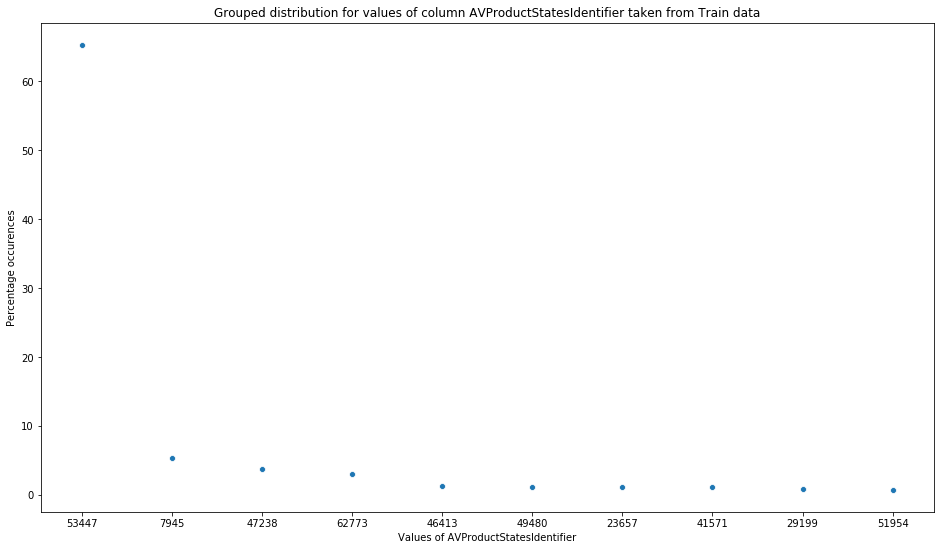

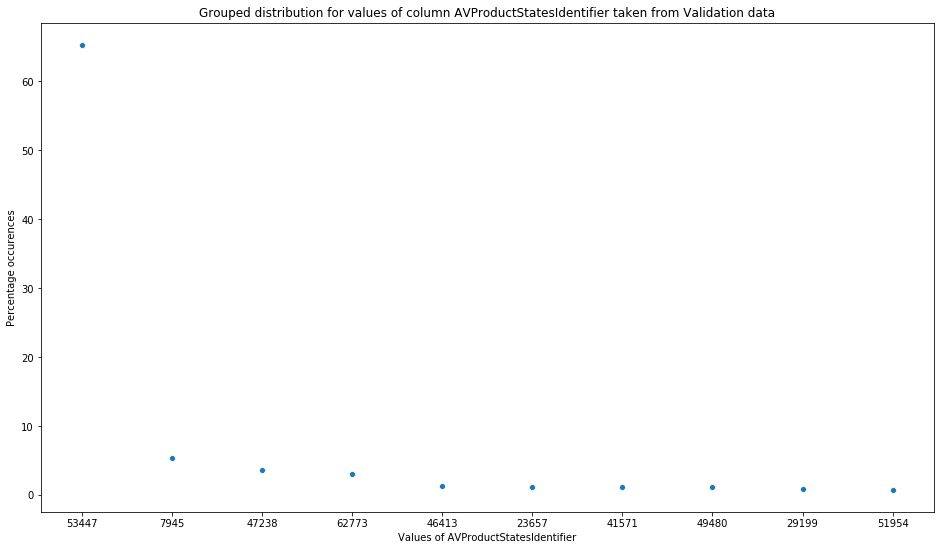

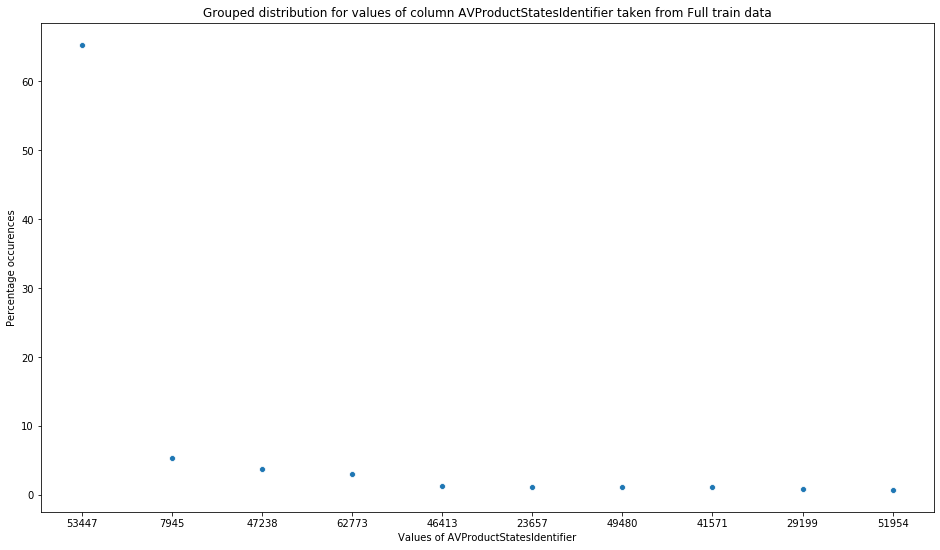

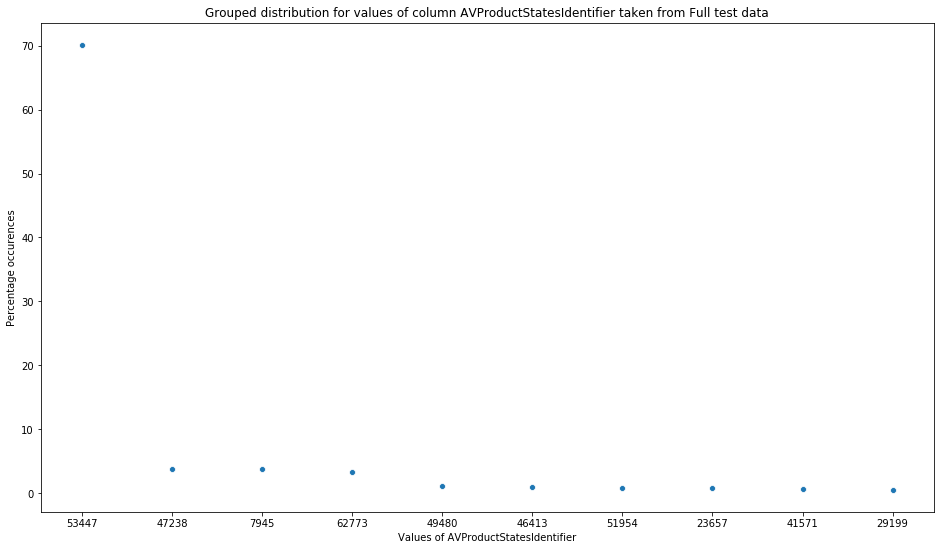

In [322]:
REL_COL = 'AVProductStatesIdentifier'
handle_categorical_data(train_train_new, validation_train_new, train, test, REL_COL)

Let us proceed with next column 'CountryIdentifier'

###### Data description for CountryIdentifier in Train data ########
 count     7137186
unique        222
top            43
freq       317363
Name: CountryIdentifier, dtype: object 

Percentage of NA values is  0.0 

###### Data description for CountryIdentifier in Validation data ########
 count     1784297
unique        222
top            43
freq        79809
Name: CountryIdentifier, dtype: object 

Percentage of NA values is  0.0 

###### Data description for CountryIdentifier in Full train data ########
 count     8921483
unique        222
top            43
freq       397172
Name: CountryIdentifier, dtype: object 

Percentage of NA values is  0.0 

###### Data description for CountryIdentifier in Full test data ########
 count     7853253
unique        222
top            43
freq       457783
Name: CountryIdentifier, dtype: object 

Percentage of NA values is  0.0 



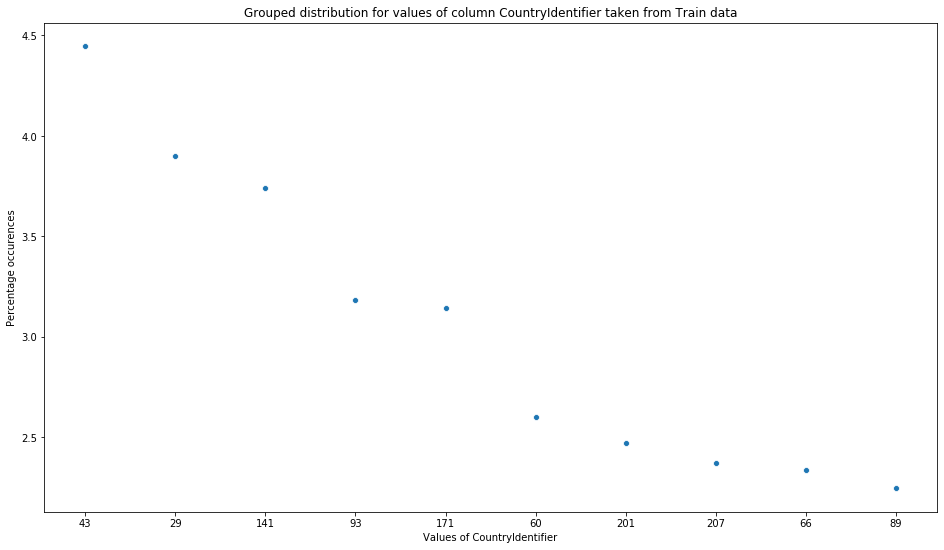

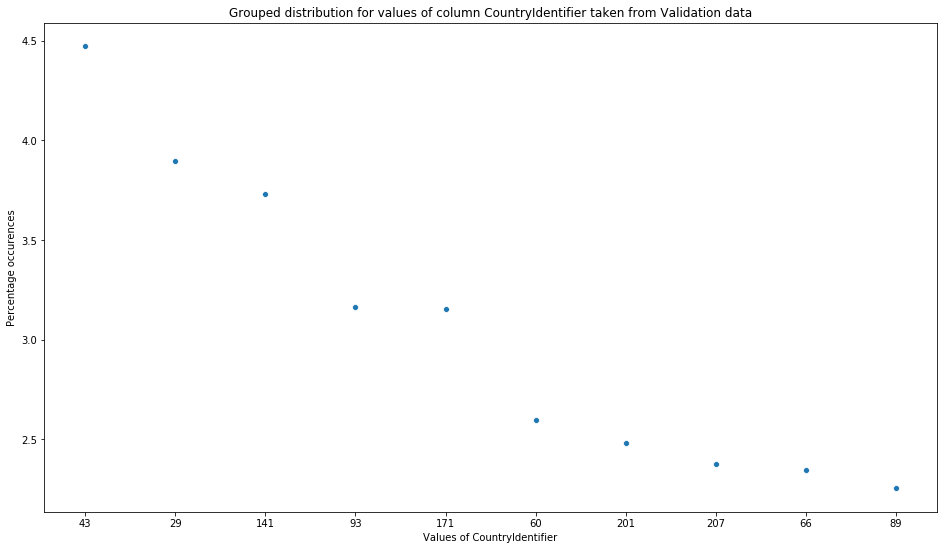

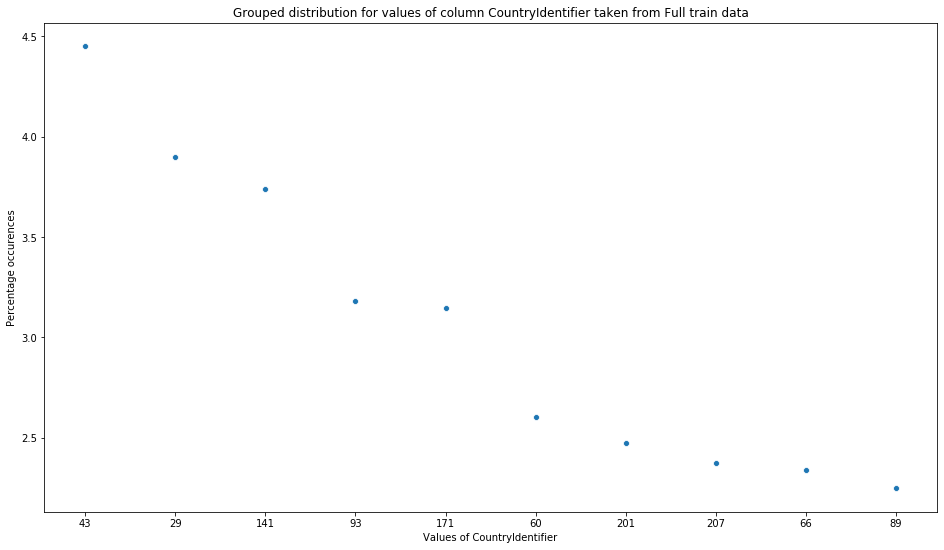

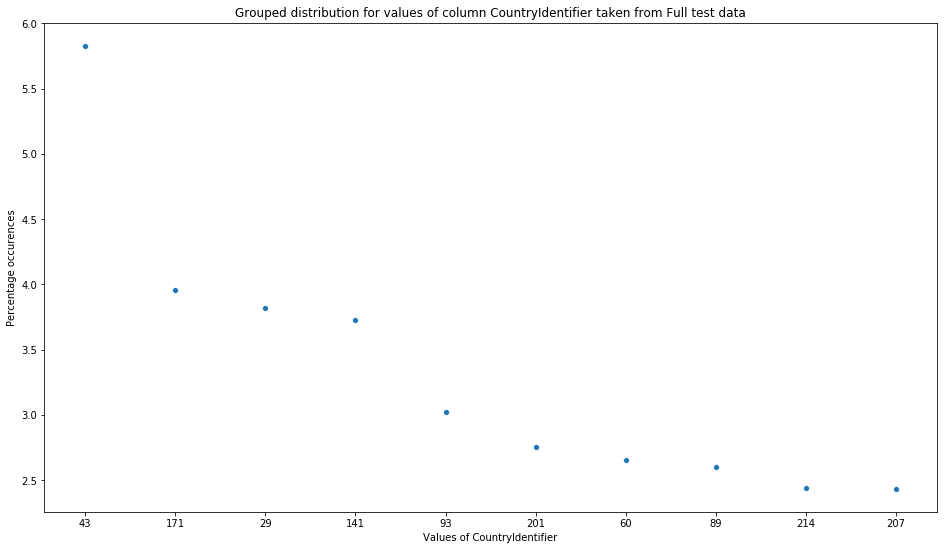

In [323]:
REL_COL = 'CountryIdentifier'
handle_categorical_data(train_train_new, validation_train_new, train, test, REL_COL)

###### Data description for CityIdentifier in Train data ########
 count     6877131
unique     101264
top        130775
freq        75976
Name: CityIdentifier, dtype: object 

Percentage of NA values is  3.6436629226140385 

###### Data description for CityIdentifier in Validation data ########
 count     1718943
unique      64028
top        130775
freq        18836
Name: CityIdentifier, dtype: object 

Percentage of NA values is  3.662731036368945 

###### Data description for CityIdentifier in Full train data ########
 count     8596074
unique     107366
top        130775
freq        94812
Name: CityIdentifier, dtype: object 

Percentage of NA values is  3.6474765462199503 

###### Data description for CityIdentifier in Full test data ########
 count     7661291
unique     105817
top         82373
freq        69449
Name: CityIdentifier, dtype: object 

Percentage of NA values is  2.44436286466258 



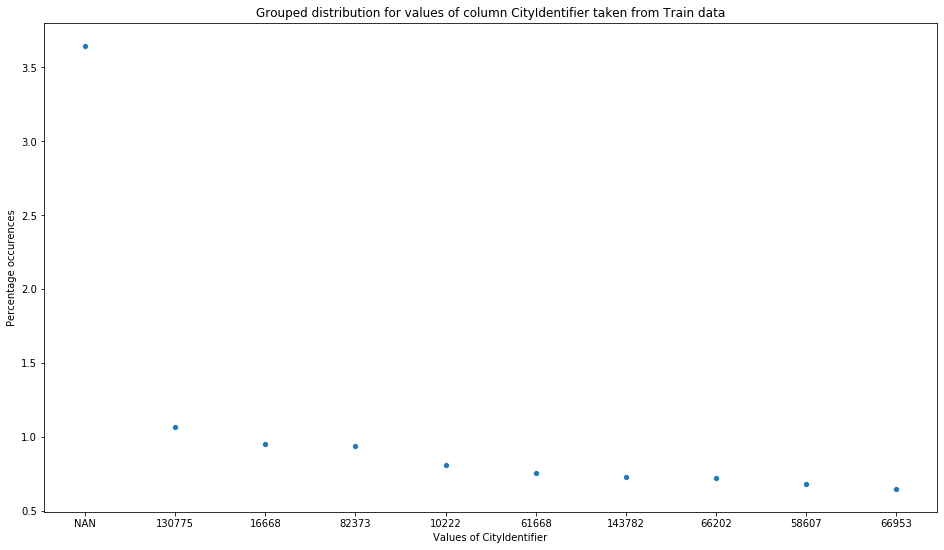

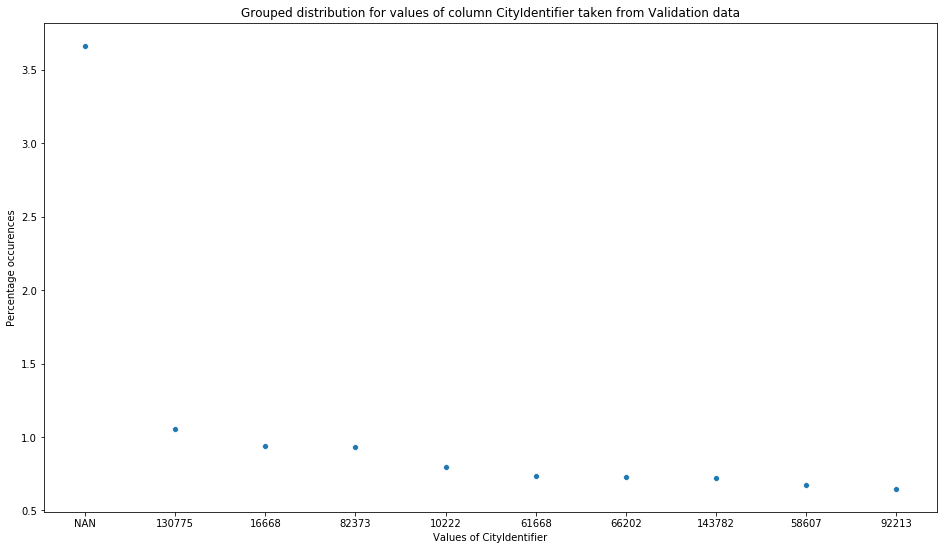

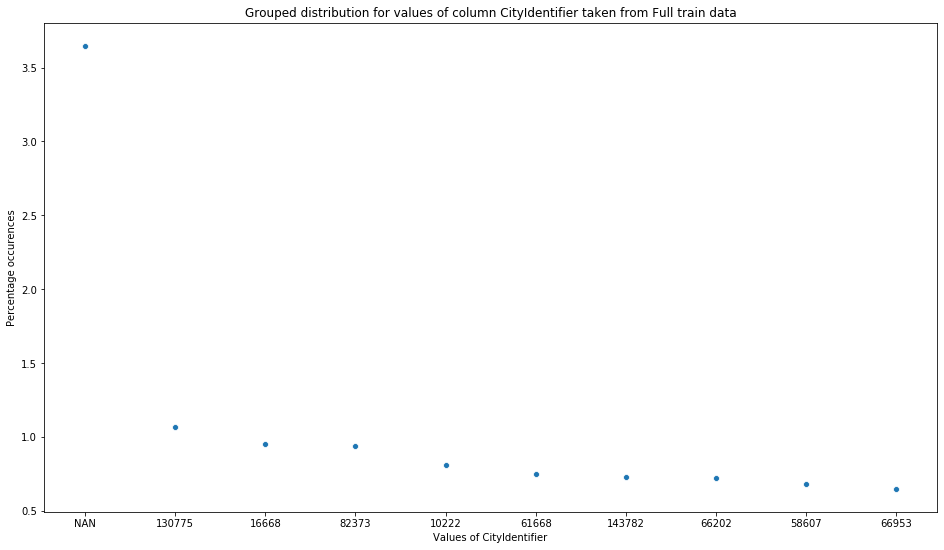

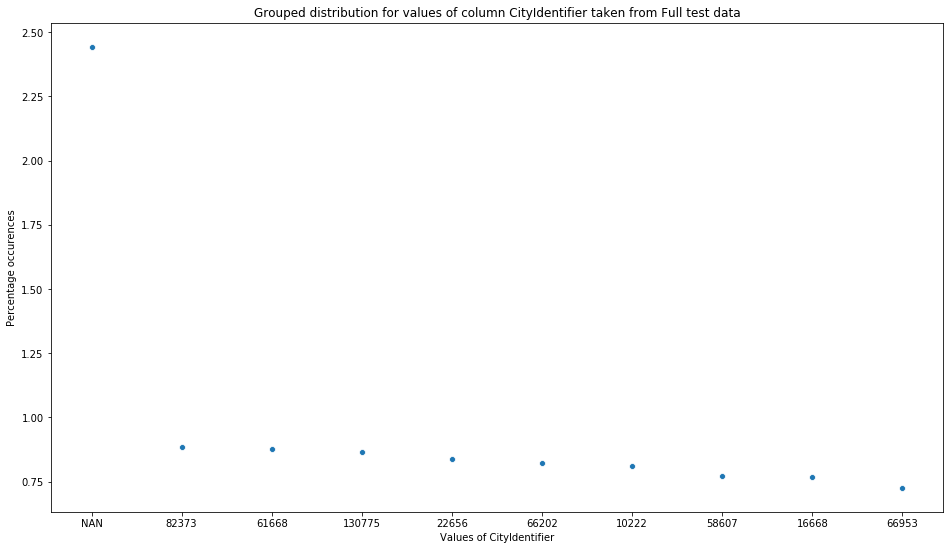

In [324]:
# Next Column
REL_COL = 'CityIdentifier'
handle_categorical_data(train_train_new, validation_train_new, train, test , REL_COL, 10)

Though the most frequent value differs between validation and test, the essence of the distribution looks to be the same.

###### Data description for GeoNameIdentifier in Train data ########
 count     7137009
unique        289
top           277
freq      1225893
Name: GeoNameIdentifier, dtype: object 

Percentage of NA values is  0.0024799689961842106 

###### Data description for GeoNameIdentifier in Validation data ########
 count     1784261
unique        281
top           277
freq       306036
Name: GeoNameIdentifier, dtype: object 

Percentage of NA values is  0.002017601329823454 

###### Data description for GeoNameIdentifier in Full train data ########
 count     8921270
unique        292
top           277
freq      1531929
Name: GeoNameIdentifier, dtype: object 

Percentage of NA values is  0.0023874954421815296 

###### Data description for GeoNameIdentifier in Full test data ########
 count     7853106
unique        289
top           277
freq      1407739
Name: GeoNameIdentifier, dtype: object 

Percentage of NA values is  0.0018718357857565521 



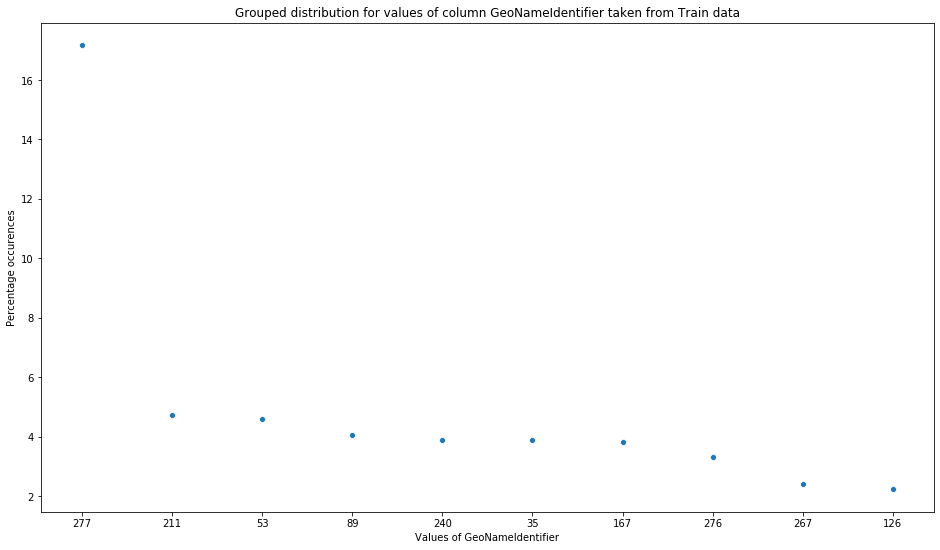

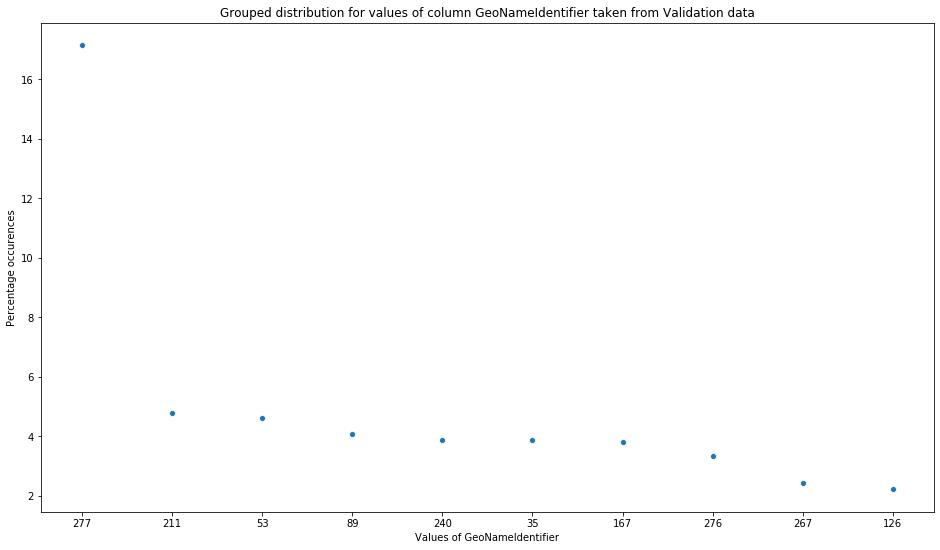

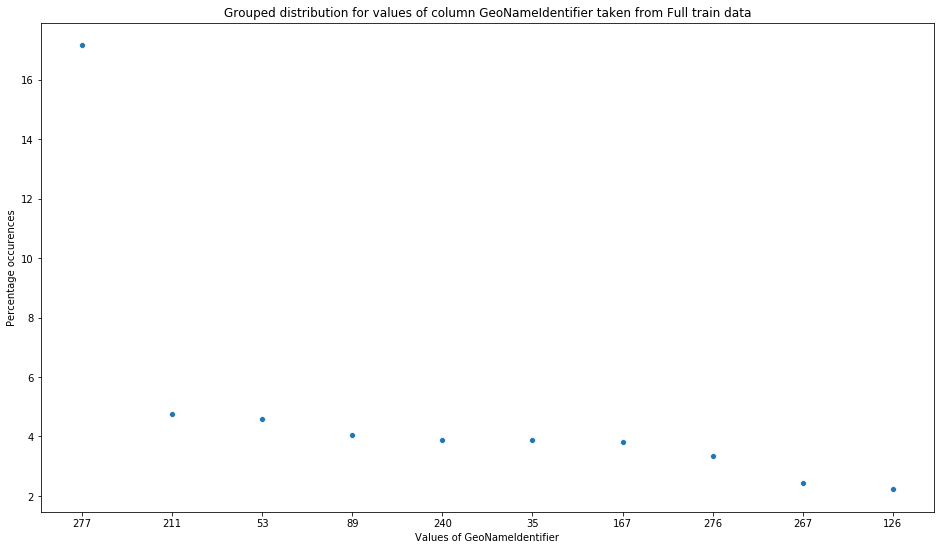

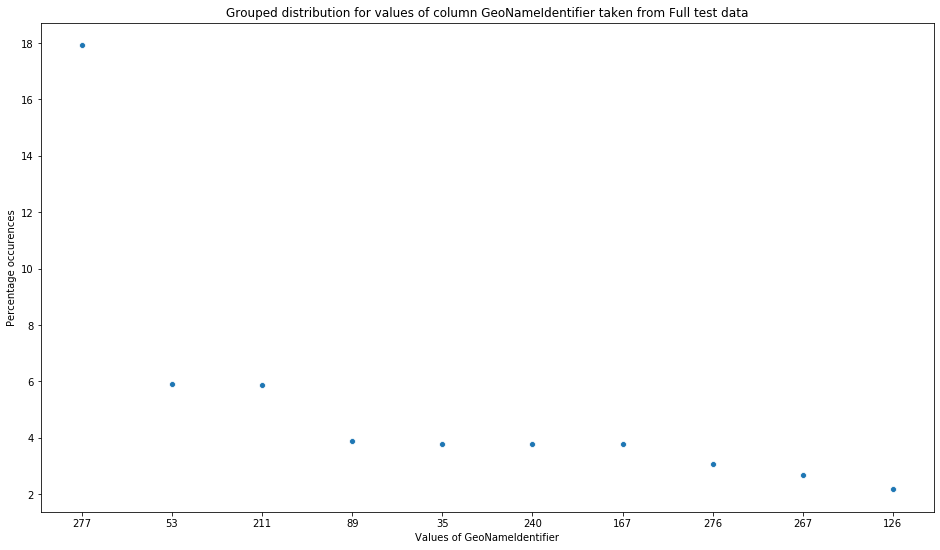

In [325]:
# Next Column
REL_COL = 'GeoNameIdentifier'
handle_categorical_data(train_train_new, validation_train_new, train, test,  REL_COL)

###### Data description for LocaleEnglishNameIdentifier in Train data ########
 count     7137186
unique        275
top            75
freq      1676180
Name: LocaleEnglishNameIdentifier, dtype: object 

Percentage of NA values is  0.0 

###### Data description for LocaleEnglishNameIdentifier in Validation data ########
 count     1784297
unique        265
top            75
freq       418405
Name: LocaleEnglishNameIdentifier, dtype: object 

Percentage of NA values is  0.0 

###### Data description for LocaleEnglishNameIdentifier in Full train data ########
 count     8921483
unique        276
top            75
freq      2094585
Name: LocaleEnglishNameIdentifier, dtype: object 

Percentage of NA values is  0.0 

###### Data description for LocaleEnglishNameIdentifier in Full test data ########
 count     7853253
unique        278
top            75
freq      1979128
Name: LocaleEnglishNameIdentifier, dtype: object 

Percentage of NA values is  0.0 



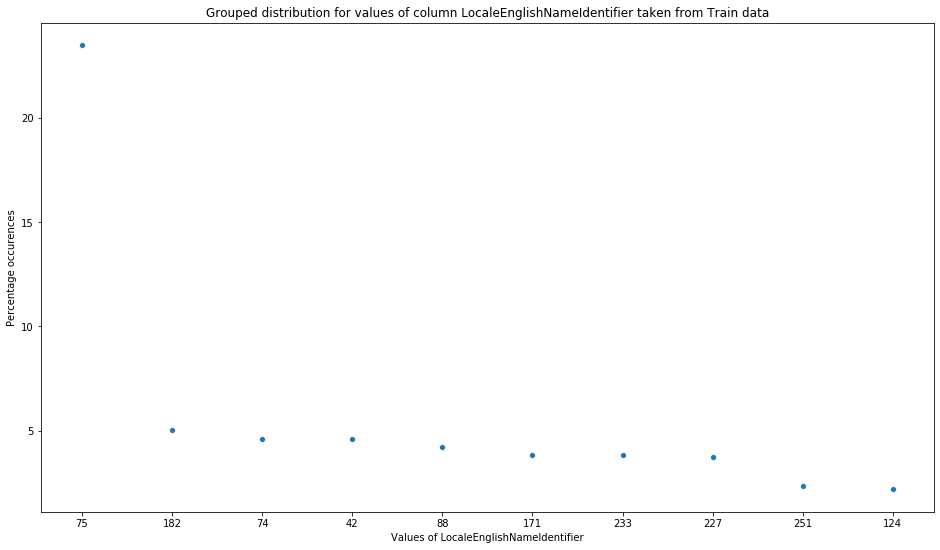

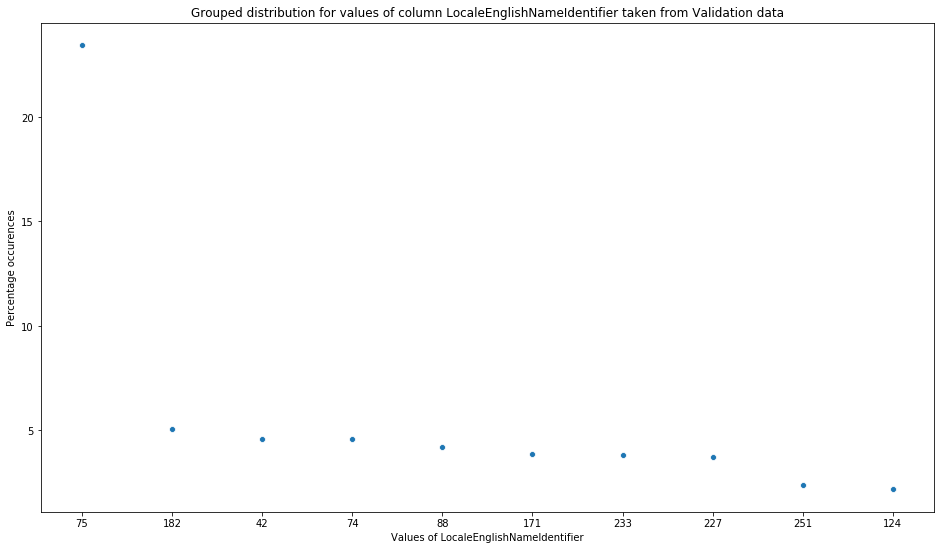

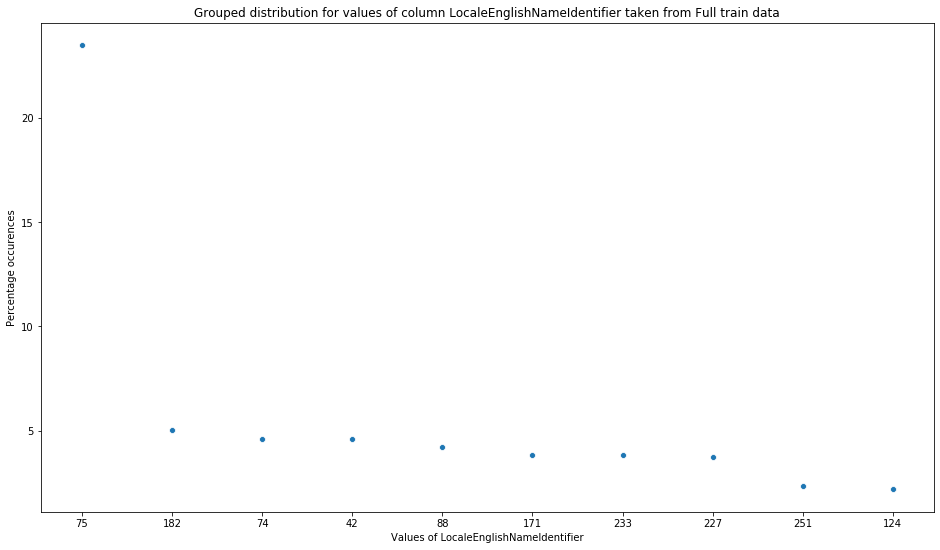

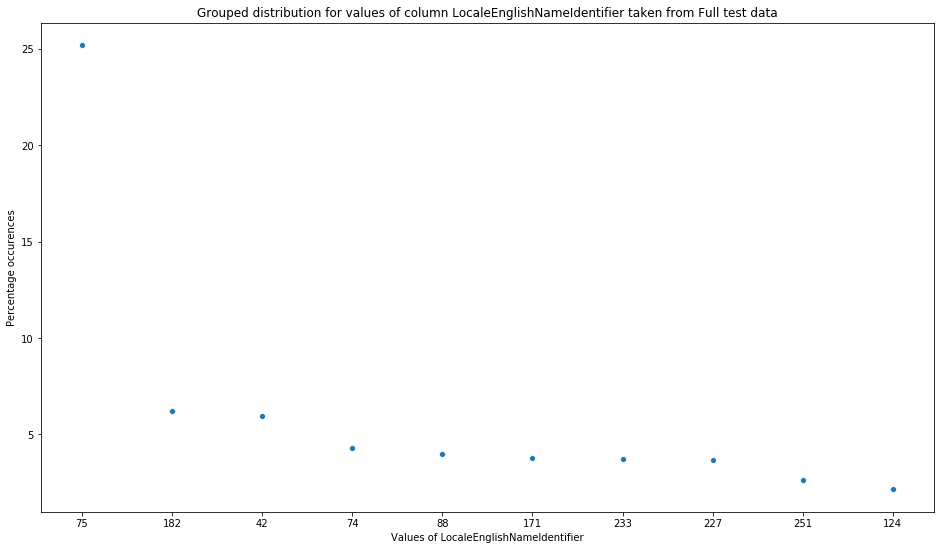

In [326]:
# Column : LocaleEnglishNameIdentifier
REL_COL  = 'LocaleEnglishNameIdentifier'
handle_categorical_data(train_train_new, validation_train_new, train, test, REL_COL)

###### Data description for OsBuild in Train data ########
 count     7137186
unique         73
top         17134
freq      3131822
Name: OsBuild, dtype: object 

Percentage of NA values is  0.0 

###### Data description for OsBuild in Validation data ########
 count     1784297
unique         55
top         17134
freq       783699
Name: OsBuild, dtype: object 

Percentage of NA values is  0.0 

###### Data description for OsBuild in Full train data ########
 count     8921483
unique         76
top         17134
freq      3915521
Name: OsBuild, dtype: object 

Percentage of NA values is  0.0 

###### Data description for OsBuild in Full test data ########
 count     7853253
unique         78
top         17134
freq      3893188
Name: OsBuild, dtype: object 

Percentage of NA values is  0.0 



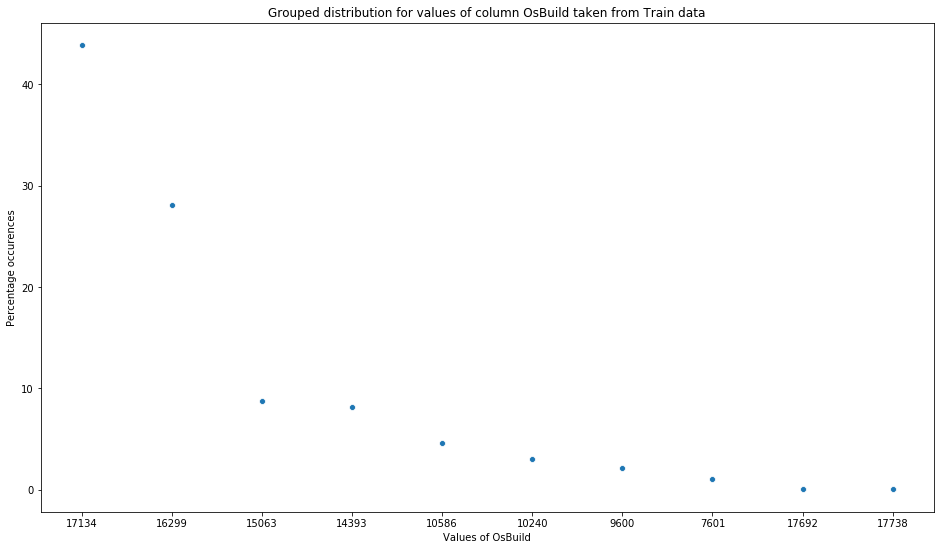

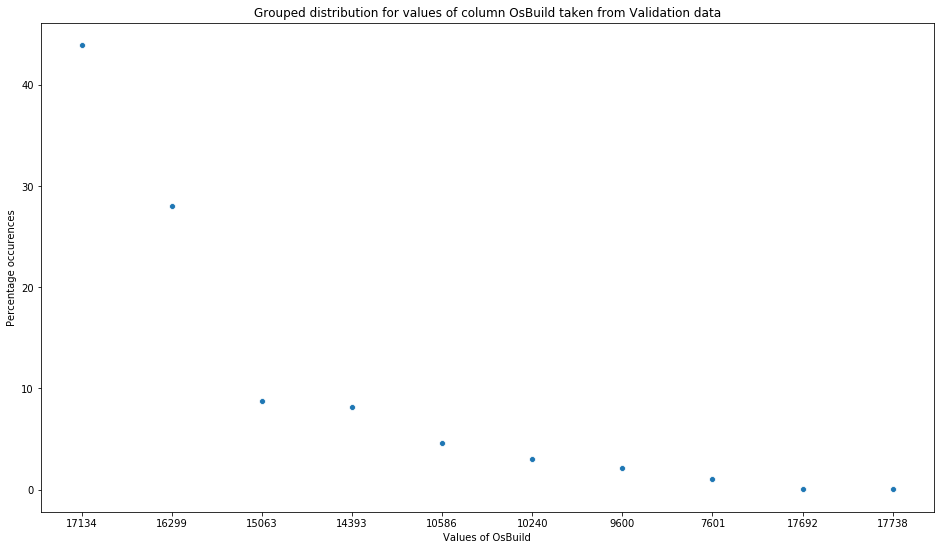

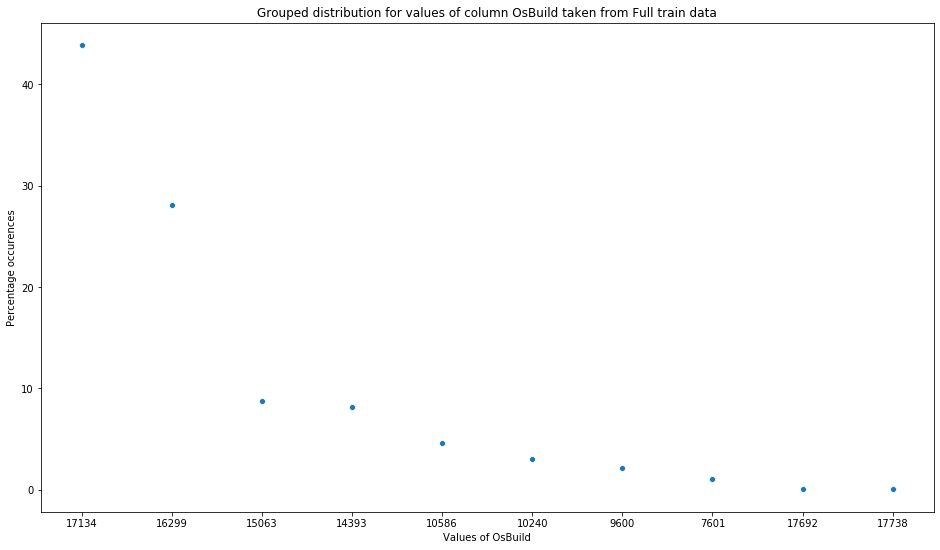

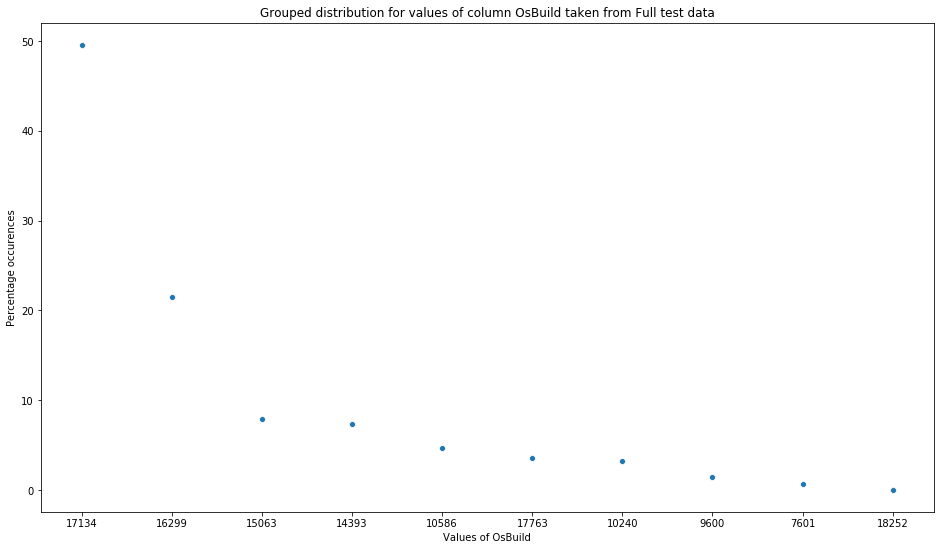

In [327]:
# Column : OsBuild
REL_COL = 'OsBuild'
handle_categorical_data(train_train_new, validation_train_new, train, test, REL_COL, 10) 

###### Data description for OsSuite in Train data ########
 count     7137186
unique         13
top           768
freq      4448785
Name: OsSuite, dtype: object 

Percentage of NA values is  0.0 

###### Data description for OsSuite in Validation data ########
 count     1784297
unique         11
top           768
freq      1111876
Name: OsSuite, dtype: object 

Percentage of NA values is  0.0 

###### Data description for OsSuite in Full train data ########
 count     8921483
unique         14
top           768
freq      5560661
Name: OsSuite, dtype: object 

Percentage of NA values is  0.0 

###### Data description for OsSuite in Full test data ########
 count     7853253
unique         13
top           768
freq      4539020
Name: OsSuite, dtype: object 

Percentage of NA values is  0.0 



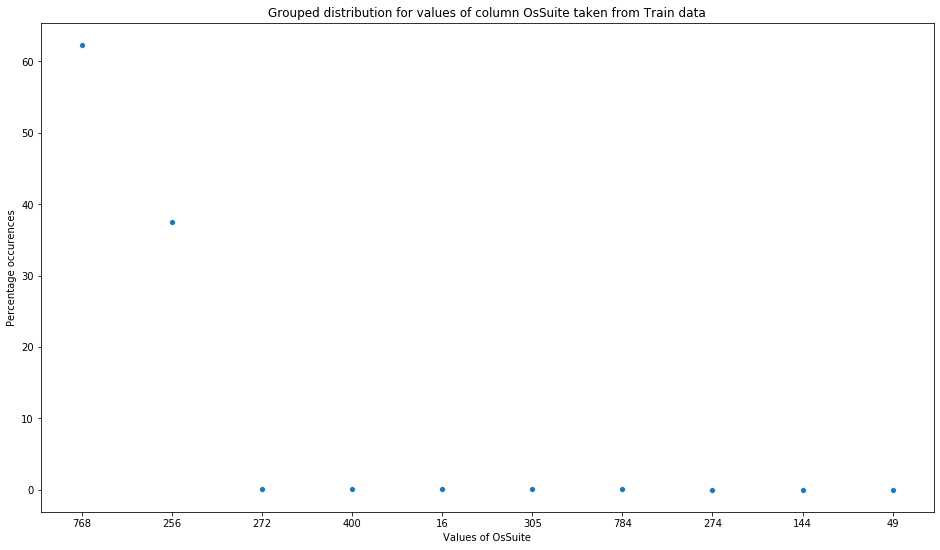

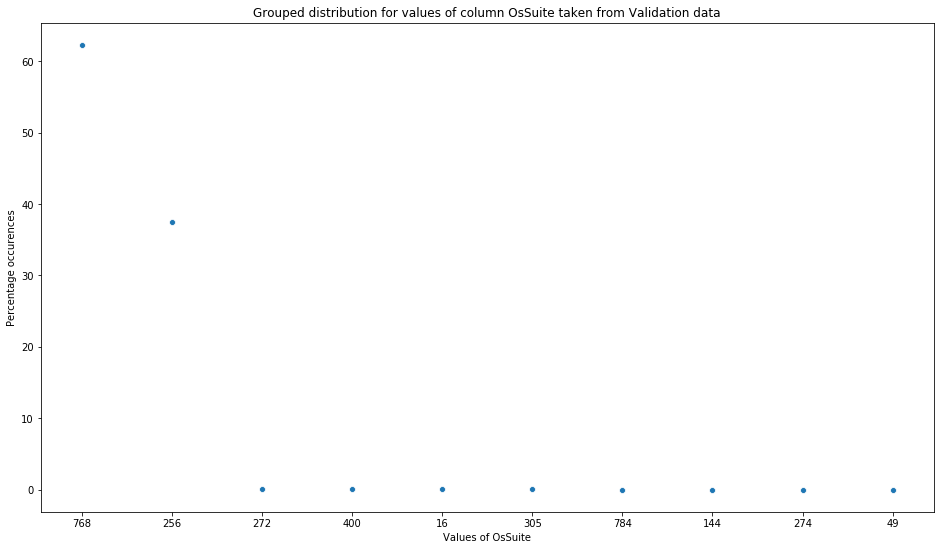

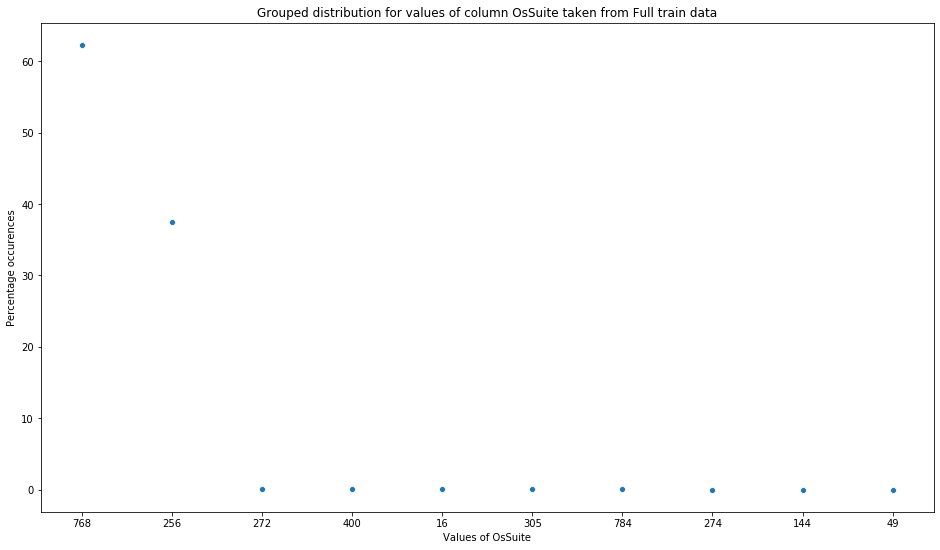

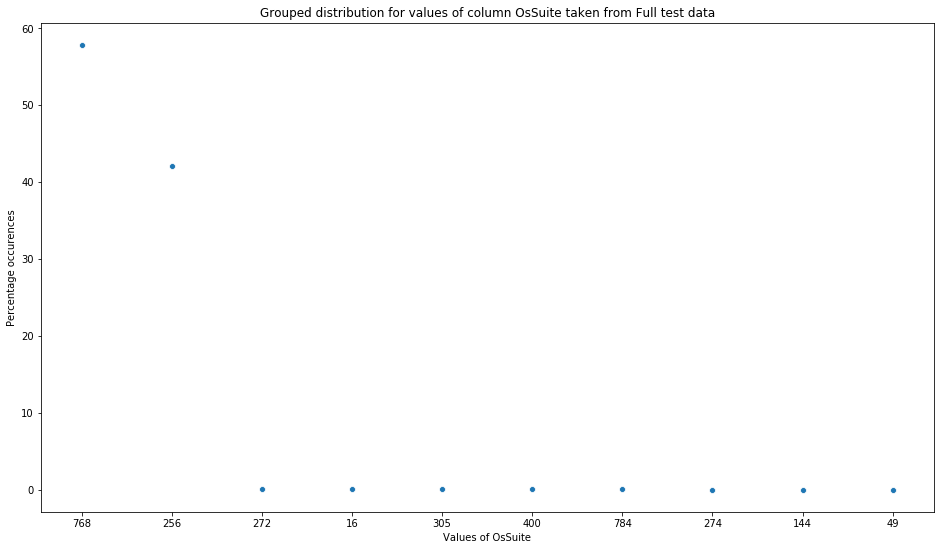

In [328]:
# Column : OsSuite
REL_COL = 'OsSuite'
handle_categorical_data(train_train_new, validation_train_new, train, test, REL_COL)

###### Data description for UacLuaenable in Train data ########
 count     7128532
unique         10
top             1
freq      7085448
Name: UacLuaenable, dtype: object 

Percentage of NA values is  0.121252269451854 

###### Data description for UacLuaenable in Validation data ########
 count     1782113
unique          7
top             1
freq      1771069
Name: UacLuaenable, dtype: object 

Percentage of NA values is  0.12240114734262289 

###### Data description for UacLuaenable in Full train data ########
 count     8910645
unique         11
top             1
freq      8856517
Name: UacLuaenable, dtype: object 

Percentage of NA values is  0.1214820450815184 

###### Data description for UacLuaenable in Full test data ########
 count     7845388
unique         10
top             1
freq      7785557
Name: UacLuaenable, dtype: object 

Percentage of NA values is  0.10014958132636247 



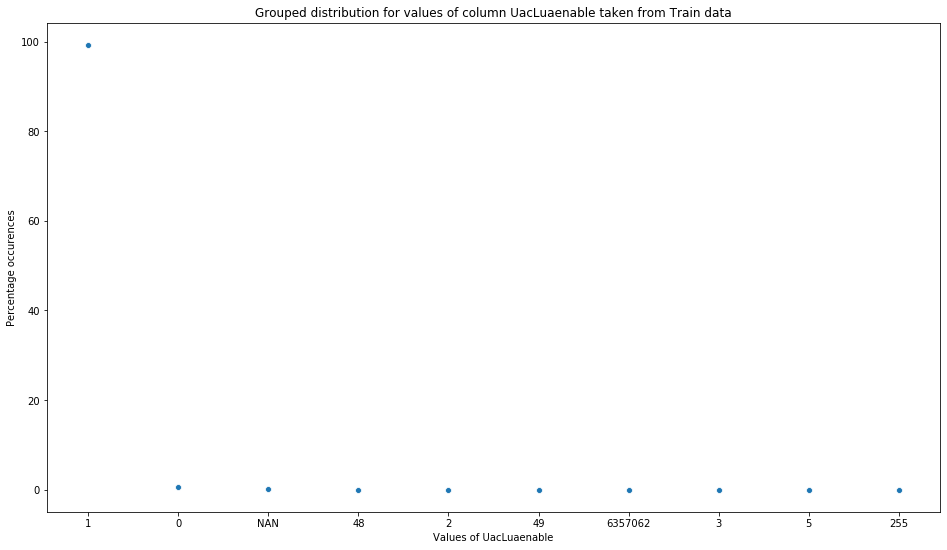

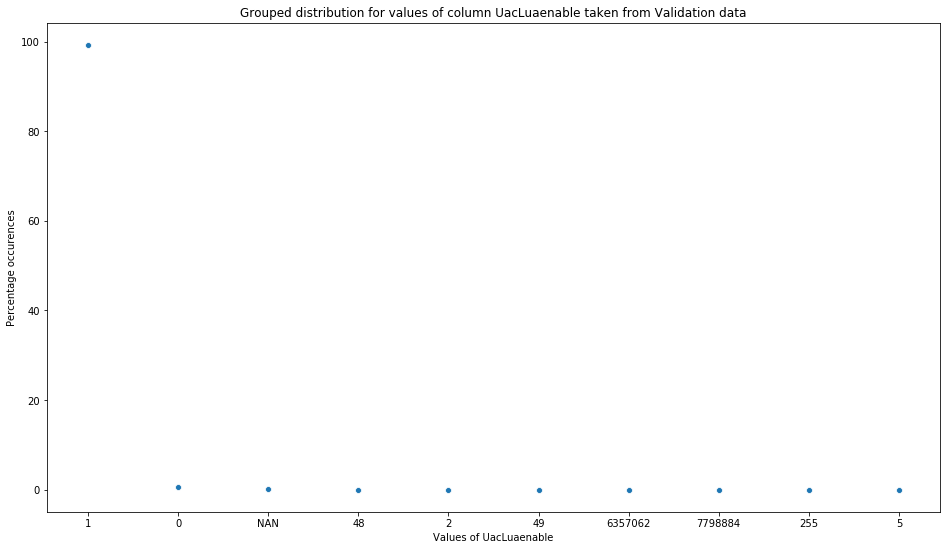

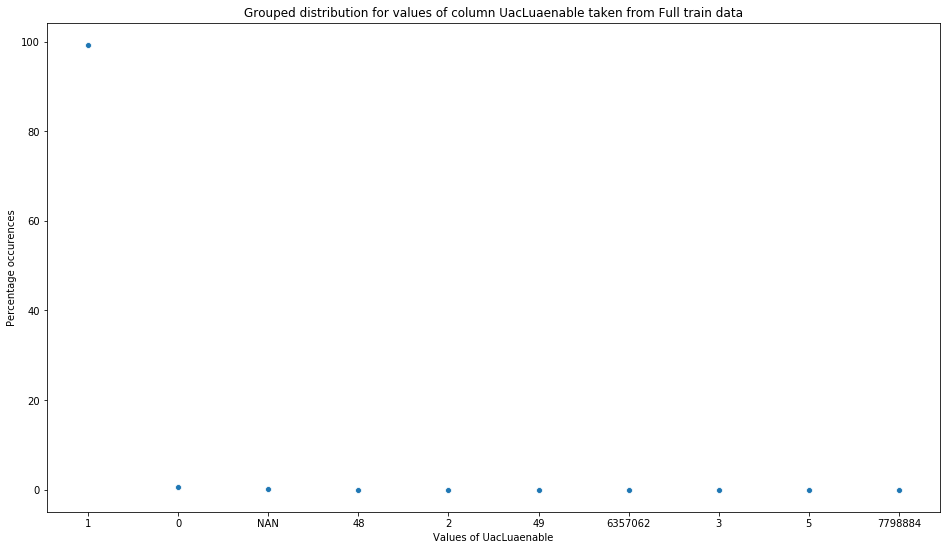

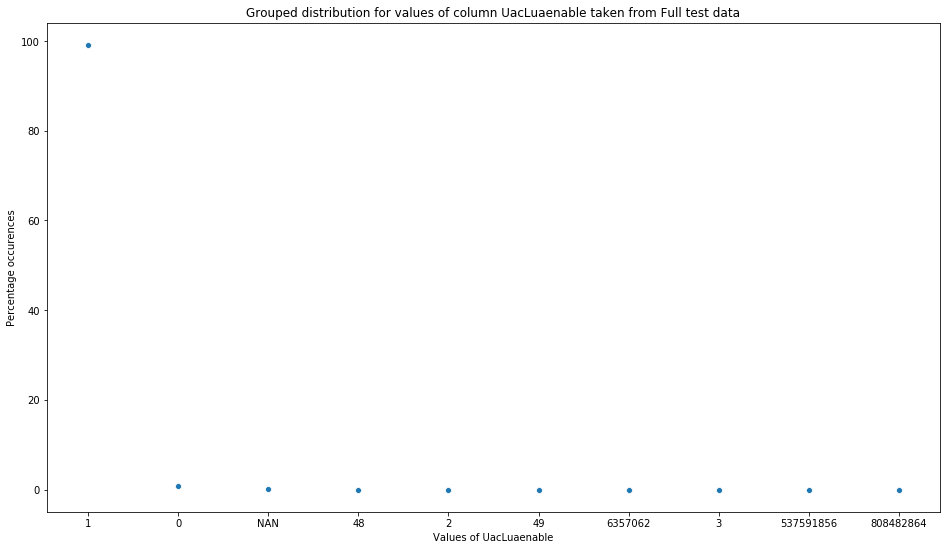

In [329]:
# Column : UacLuaenable
REL_COL = 'UacLuaenable'
handle_categorical_data(train_train_new, validation_train_new, train, test, REL_COL)

###### Data description for Census_OSBuildNumber in Train data ########
 count     7137186
unique        156
top         17134
freq      3206478
Name: Census_OSBuildNumber, dtype: object 

Percentage of NA values is  0.0 

###### Data description for Census_OSBuildNumber in Validation data ########
 count     1784297
unique        104
top         17134
freq       802403
Name: Census_OSBuildNumber, dtype: object 

Percentage of NA values is  0.0 

###### Data description for Census_OSBuildNumber in Full train data ########
 count     8921483
unique        165
top         17134
freq      4008881
Name: Census_OSBuildNumber, dtype: object 

Percentage of NA values is  0.0 

###### Data description for Census_OSBuildNumber in Full test data ########
 count     7853253
unique        156
top         17134
freq      3978878
Name: Census_OSBuildNumber, dtype: object 

Percentage of NA values is  0.0 



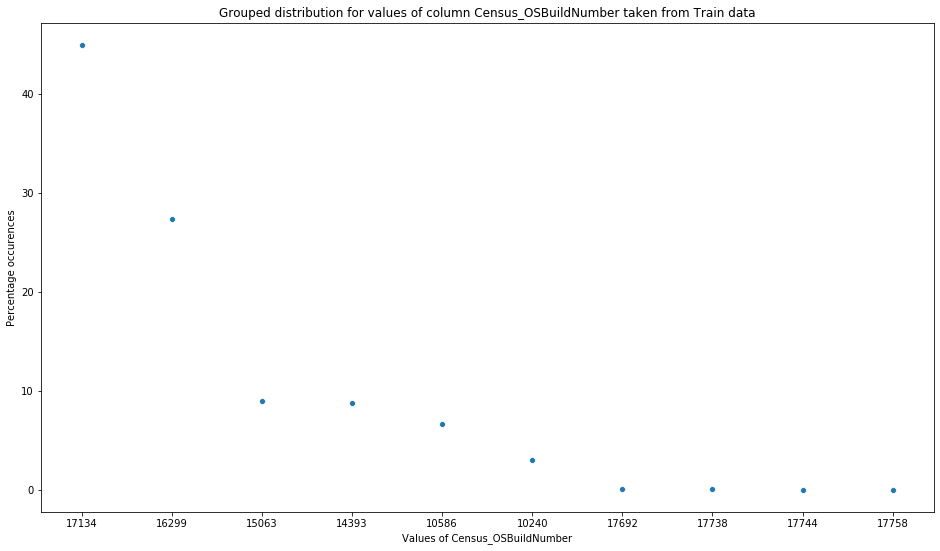

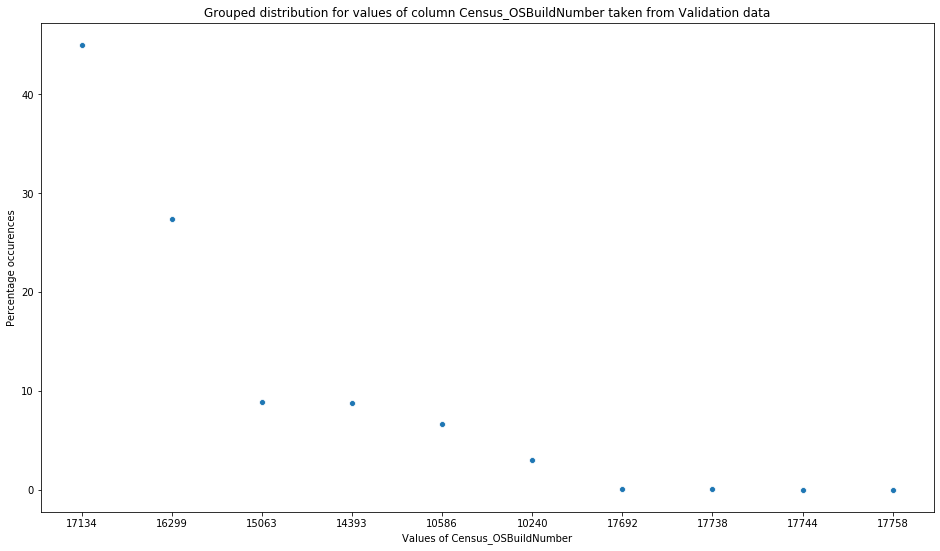

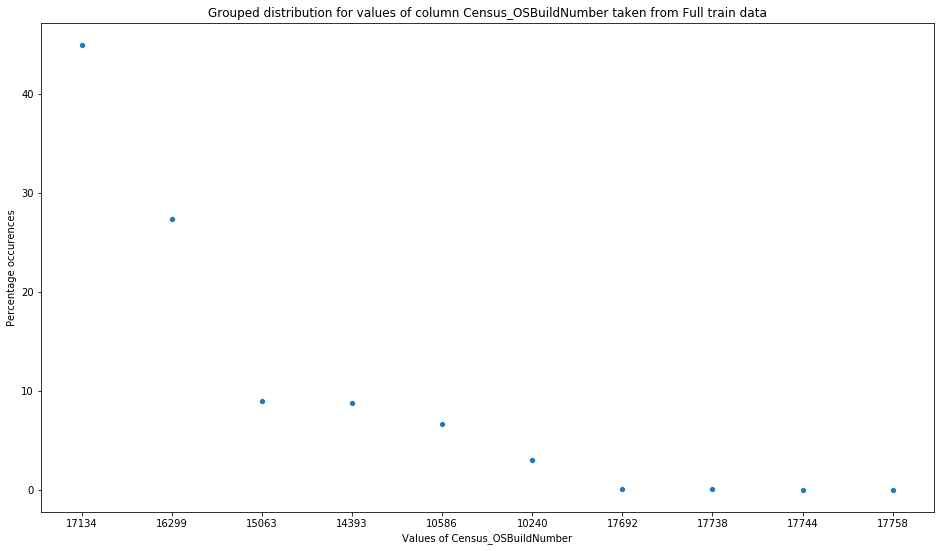

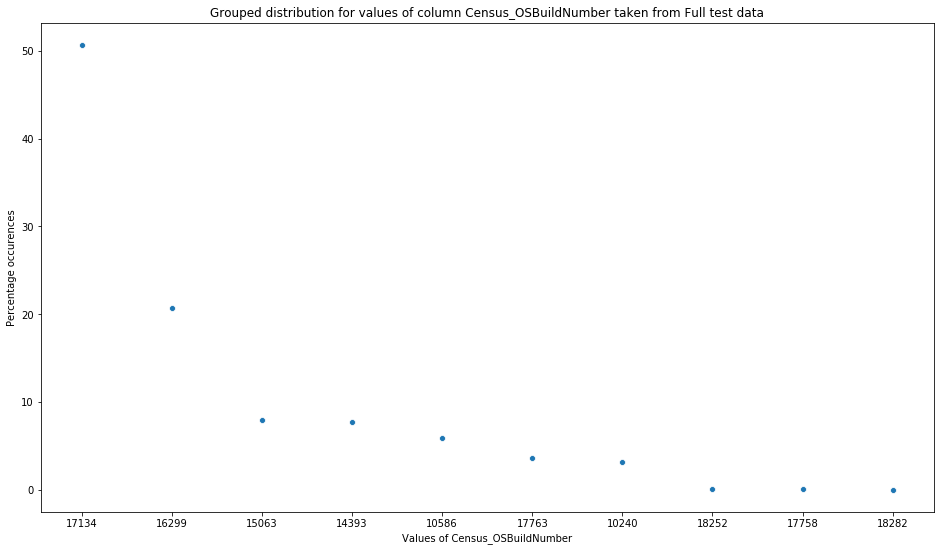

In [330]:
# Column : Census_OSBuildNumber
REL_COL = 'Census_OSBuildNumber'
handle_categorical_data(train_train_new, validation_train_new, train, test, REL_COL, 10)

###### Data description for Census_OSBuildRevision in Train data ########
 count     7137186
unique        277
top           228
freq      1131329
Name: Census_OSBuildRevision, dtype: object 

Percentage of NA values is  0.0 

###### Data description for Census_OSBuildRevision in Validation data ########
 count     1784297
unique        254
top           228
freq       282304
Name: Census_OSBuildRevision, dtype: object 

Percentage of NA values is  0.0 

###### Data description for Census_OSBuildRevision in Full train data ########
 count     8921483
unique        285
top           228
freq      1413633
Name: Census_OSBuildRevision, dtype: object 

Percentage of NA values is  0.0 

###### Data description for Census_OSBuildRevision in Full test data ########
 count     7853253
unique        294
top           345
freq      1377568
Name: Census_OSBuildRevision, dtype: object 

Percentage of NA values is  0.0 



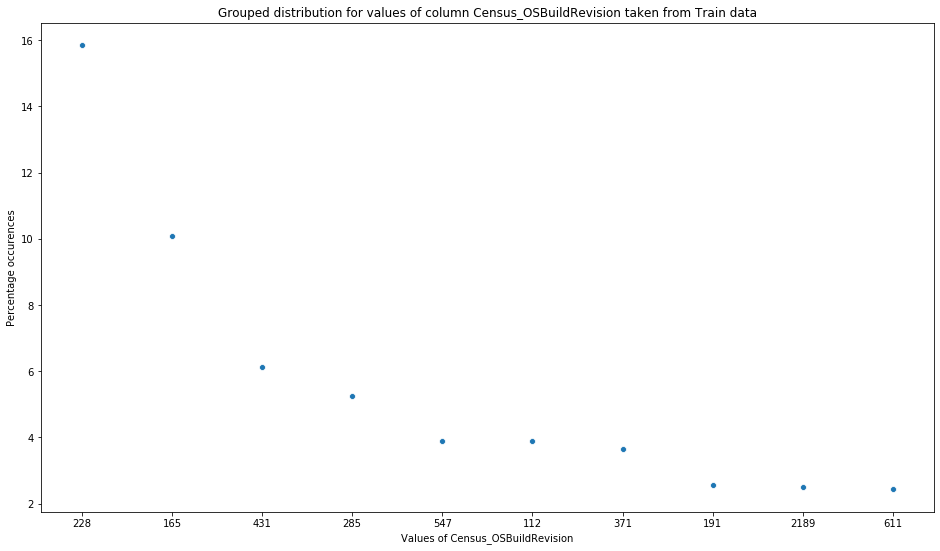

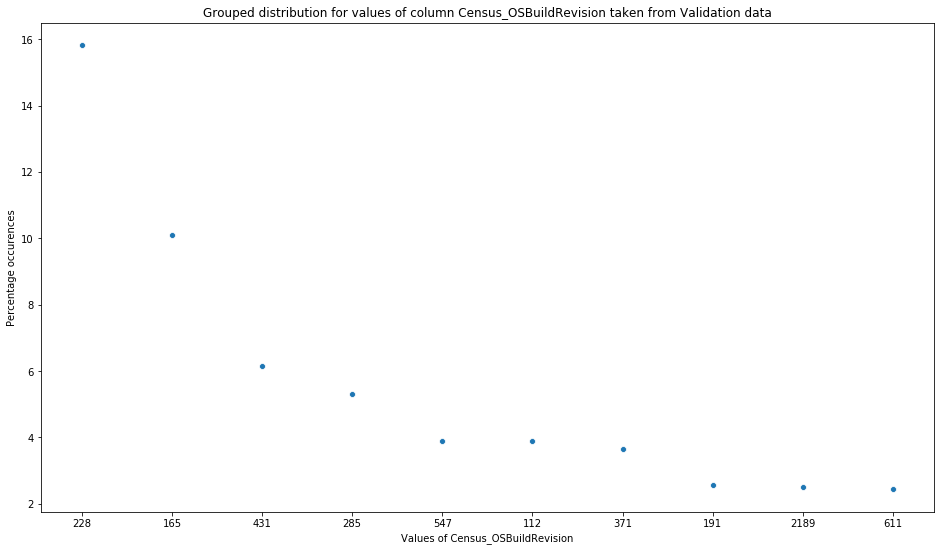

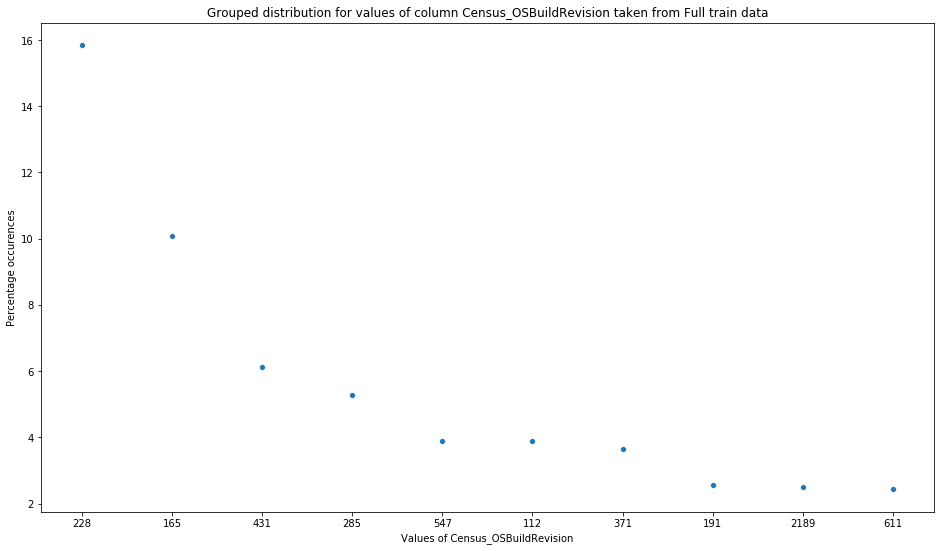

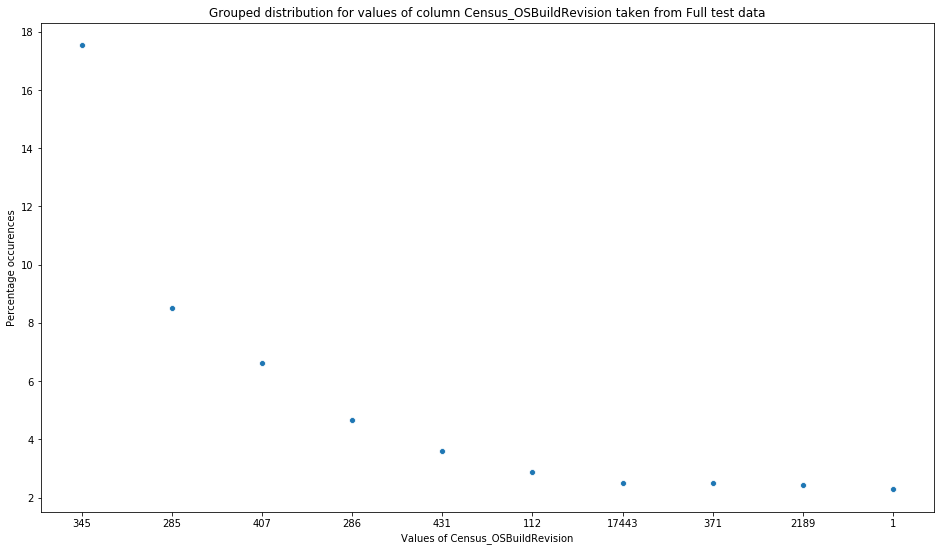

In [331]:
# Column : Census_OSBuildRevision
REL_COL = 'Census_OSBuildRevision'
handle_categorical_data(train_train_new, validation_train_new, train, test, REL_COL, 10)

Comments :

For all these columns, the curves for validation and test sets look relatively similar, hence confirming the validity of the assumption that they are from the same distribution.

Let's go to other categorical columns.

In [332]:
categorical_cols

['ProductName',
 'EngineVersion',
 'AppVersion',
 'AvSigVersion',
 'Platform',
 'Processor',
 'OsVer',
 'OsPlatformSubRelease',
 'OsBuildLab',
 'SkuEdition',
 'Census_MDC2FormFactor',
 'Census_DeviceFamily',
 'Census_PrimaryDiskTypeName',
 'Census_ChassisTypeName',
 'Census_PowerPlatformRoleName',
 'Census_OSVersion',
 'Census_OSArchitecture',
 'Census_OSBranch',
 'Census_OSEdition',
 'Census_OSSkuName',
 'Census_OSInstallTypeName',
 'Census_OSWUAutoUpdateOptionsName',
 'Census_GenuineStateName',
 'Census_ActivationChannel',
 'Census_FlightRing']

###### Data description for ProductName in Train data ########
 count          7137186
unique               6
top       win8defender
freq           7061262
Name: ProductName, dtype: object 

Percentage of NA values is  0.0 

###### Data description for ProductName in Validation data ########
 count          1784297
unique               6
top       win8defender
freq           1765258
Name: ProductName, dtype: object 

Percentage of NA values is  0.0 

###### Data description for ProductName in Full train data ########
 count          8921483
unique               6
top       win8defender
freq           8826520
Name: ProductName, dtype: object 

Percentage of NA values is  0.0 

###### Data description for ProductName in Full test data ########
 count          7853253
unique               6
top       win8defender
freq           7797245
Name: ProductName, dtype: object 

Percentage of NA values is  0.0 



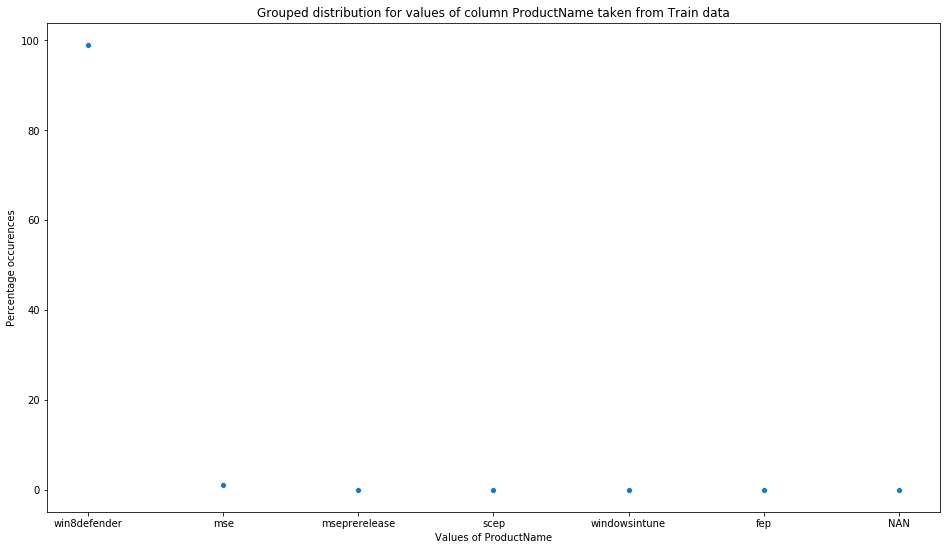

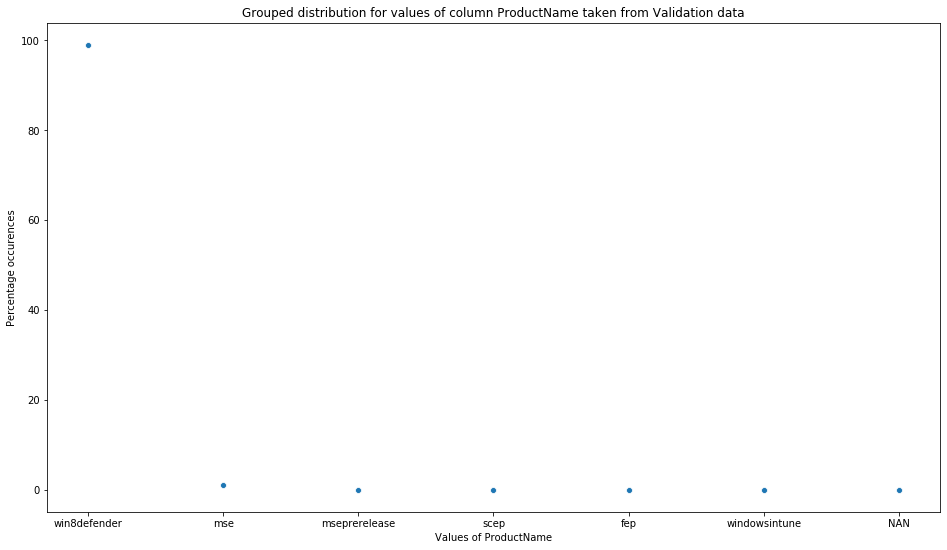

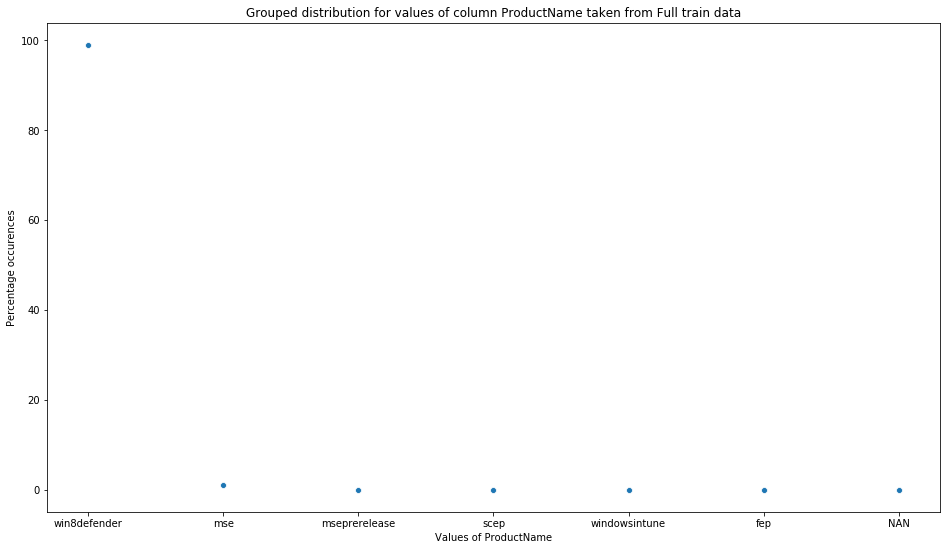

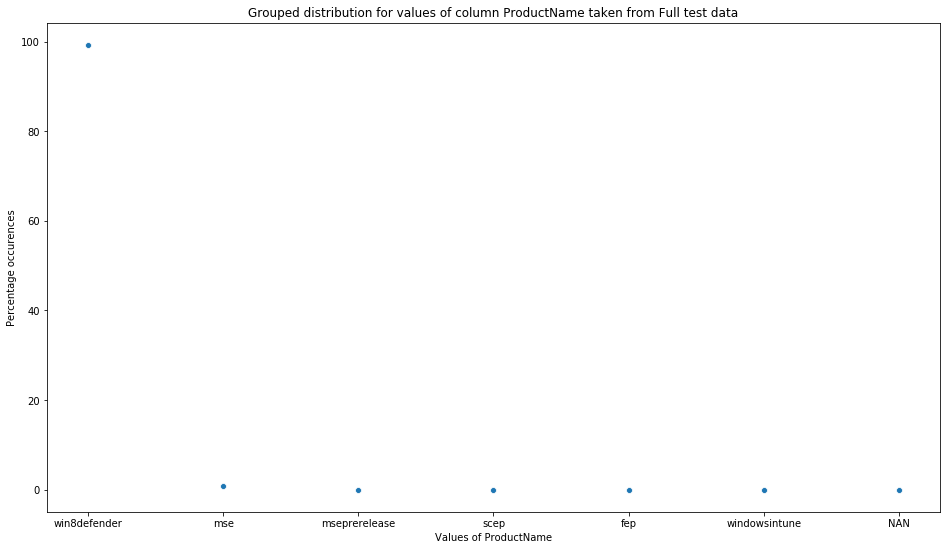

In [333]:
REL_COL = 'ProductName'
handle_categorical_data(train_train_new, validation_train_new , train, test, REL_COL)

###### Data description for EngineVersion in Train data ########
 count         7137186
unique             69
top       1.1.15200.1
freq          3075349
Name: EngineVersion, dtype: object 

Percentage of NA values is  0.0 

###### Data description for EngineVersion in Validation data ########
 count         1784297
unique             62
top       1.1.15200.1
freq           769718
Name: EngineVersion, dtype: object 

Percentage of NA values is  0.0 

###### Data description for EngineVersion in Full train data ########
 count         8921483
unique             70
top       1.1.15200.1
freq          3845067
Name: EngineVersion, dtype: object 

Percentage of NA values is  0.0 

###### Data description for EngineVersion in Full test data ########
 count         7853253
unique             70
top       1.1.15300.6
freq          3101305
Name: EngineVersion, dtype: object 

Percentage of NA values is  0.0 



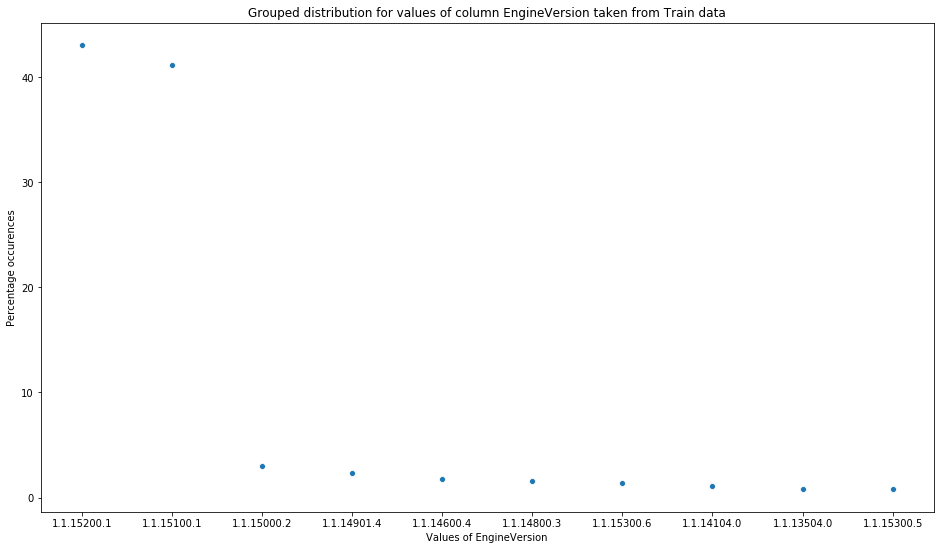

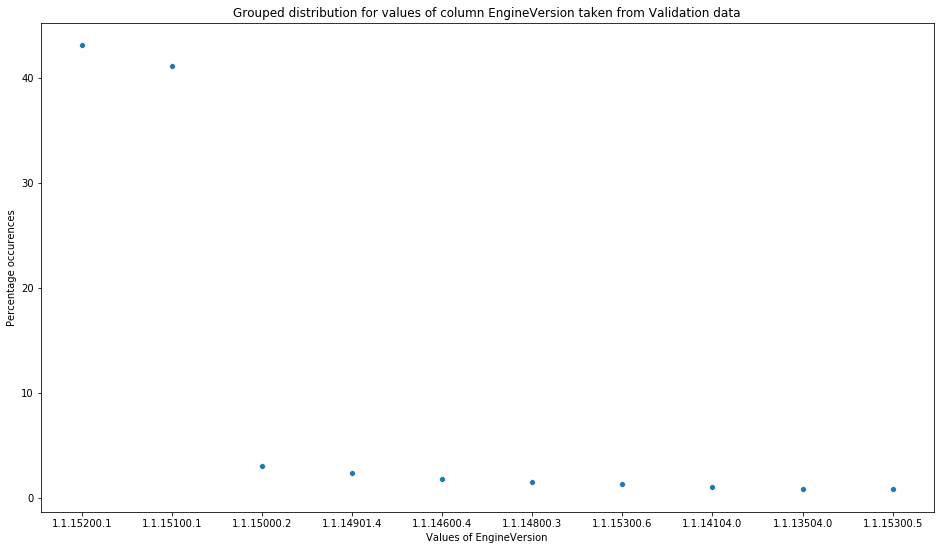

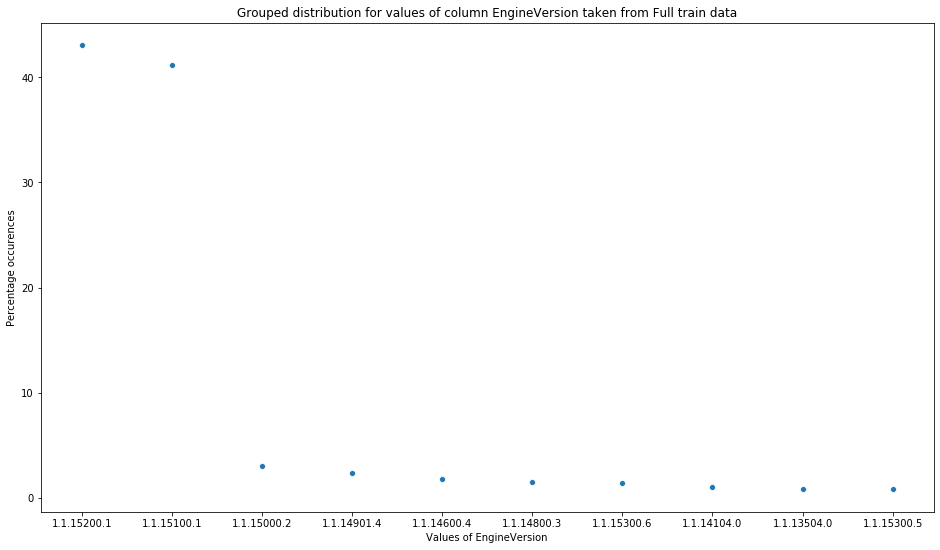

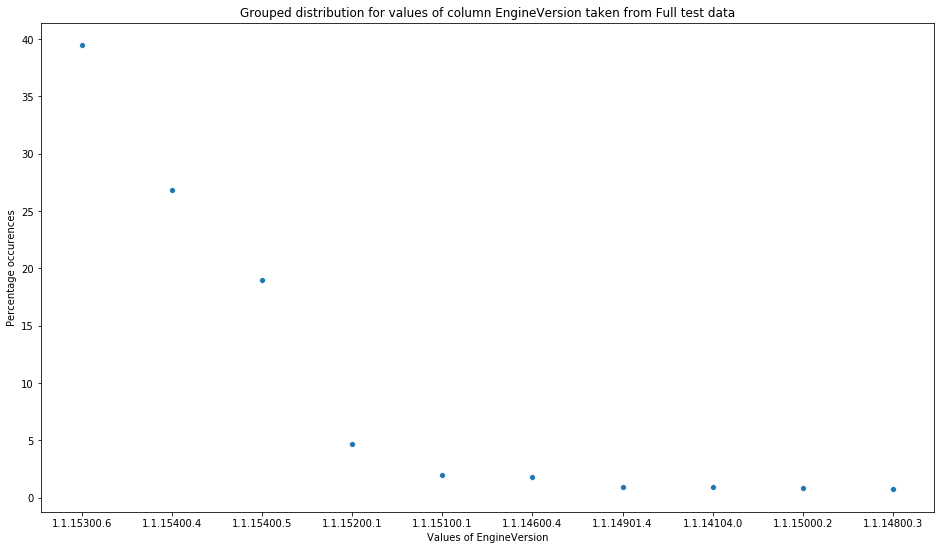

In [334]:
REL_COL = 'EngineVersion'
handle_categorical_data(train_train_new, validation_train_new, train, test, REL_COL)

There looks to be some difference in the test data. Let us drill down, by drawing a finer plot on the train, validation and test sets.

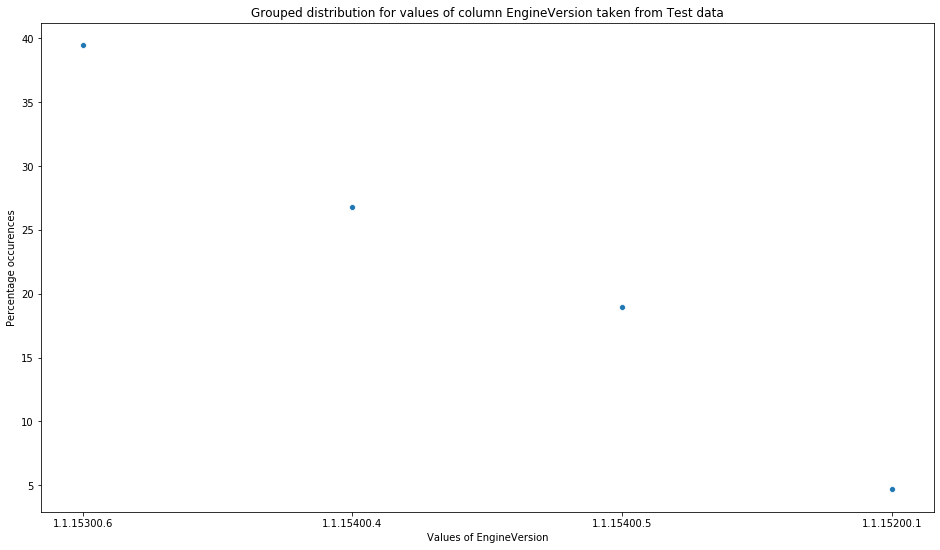

In [335]:
basic_stats_and_plot(test, REL_COL, 'Test data', 4)

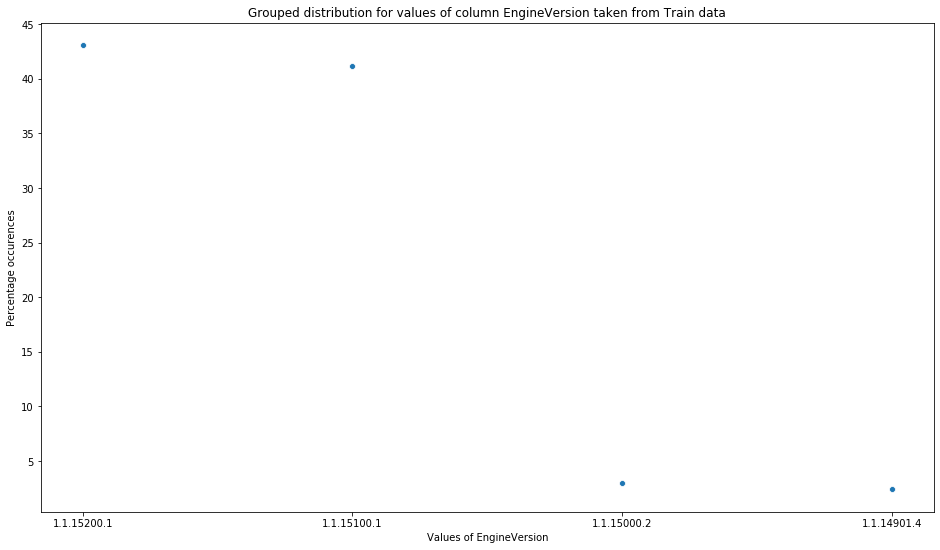

In [336]:
basic_stats_and_plot(train, REL_COL, 'Train data', 4)

Comment:

It looks like test data is having newer states of the defender software, than what is seen in train/validation. Let us keep this in mind.

###### Data description for AppVersion in Train data ########
 count             7137186
unique                108
top       4.18.1807.18075
freq              4111014
Name: AppVersion, dtype: object 

Percentage of NA values is  0.0 

###### Data description for AppVersion in Validation data ########
 count             1784297
unique                103
top       4.18.1807.18075
freq              1028210
Name: AppVersion, dtype: object 

Percentage of NA values is  0.0 

###### Data description for AppVersion in Full train data ########
 count             8921483
unique                110
top       4.18.1807.18075
freq              5139224
Name: AppVersion, dtype: object 

Percentage of NA values is  0.0 

###### Data description for AppVersion in Full test data ########
 count         7853253
unique            120
top       4.18.1809.2
freq          2738721
Name: AppVersion, dtype: object 

Percentage of NA values is  0.0 



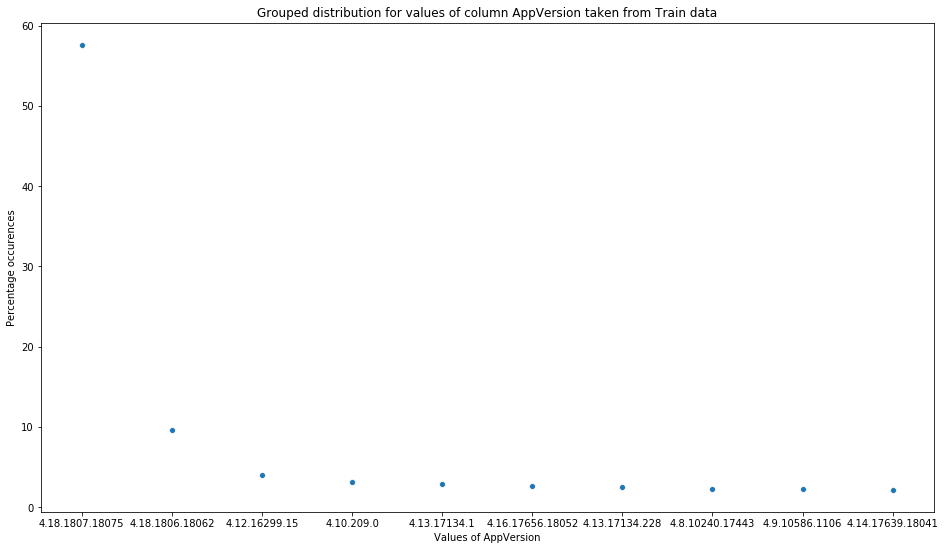

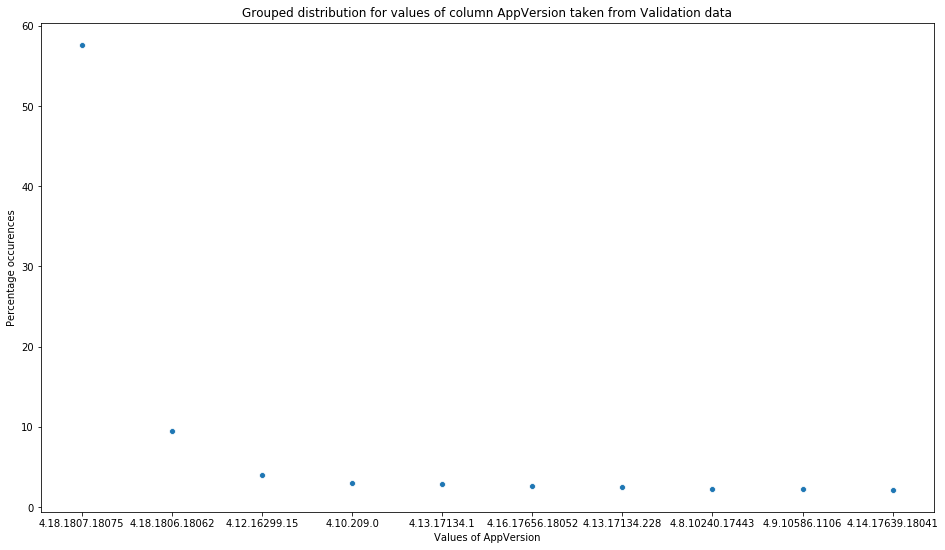

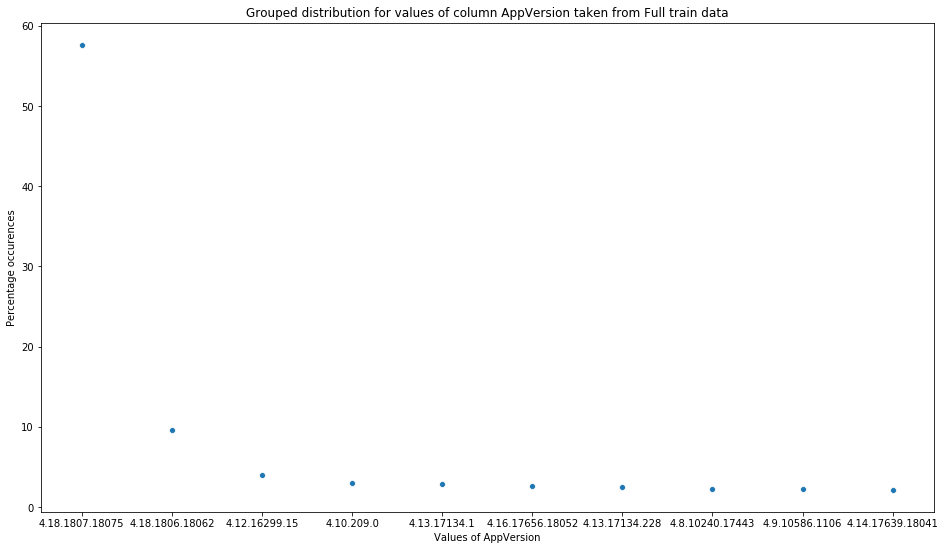

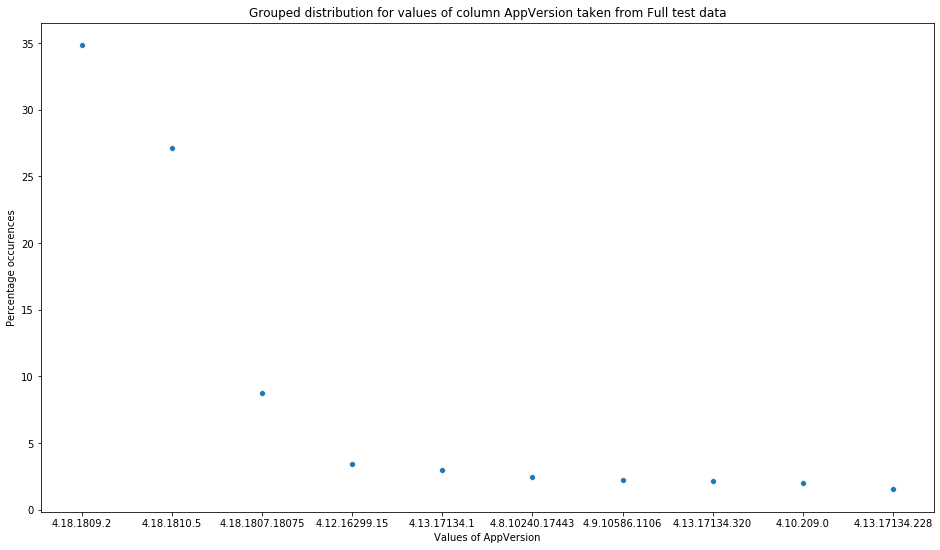

In [337]:
REL_COL = 'AppVersion'
handle_categorical_data(train_train_new, validation_train_new, train, test, REL_COL)

Comment : The story is similar here as well.

###### Data description for AvSigVersion in Train data ########
 count          7137186
unique            8474
top       1.273.1420.0
freq             82248
Name: AvSigVersion, dtype: object 

Percentage of NA values is  0.0 

###### Data description for AvSigVersion in Validation data ########
 count          1784297
unique            7917
top       1.273.1420.0
freq             20069
Name: AvSigVersion, dtype: object 

Percentage of NA values is  0.0 

###### Data description for AvSigVersion in Full train data ########
 count          8921483
unique            8531
top       1.273.1420.0
freq            102317
Name: AvSigVersion, dtype: object 

Percentage of NA values is  0.0 

###### Data description for AvSigVersion in Full test data ########
 count        7853253
unique          9357
top       1.263.48.0
freq          132624
Name: AvSigVersion, dtype: object 

Percentage of NA values is  0.0 



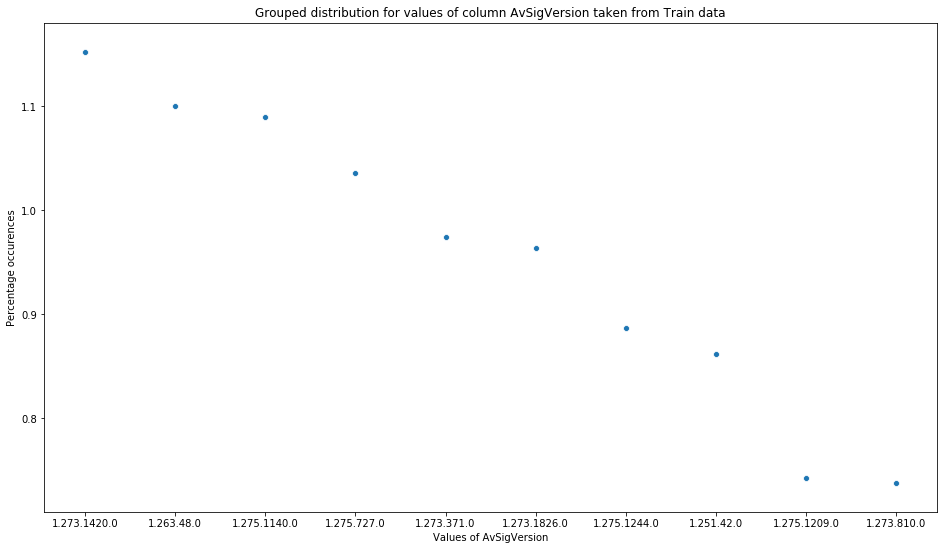

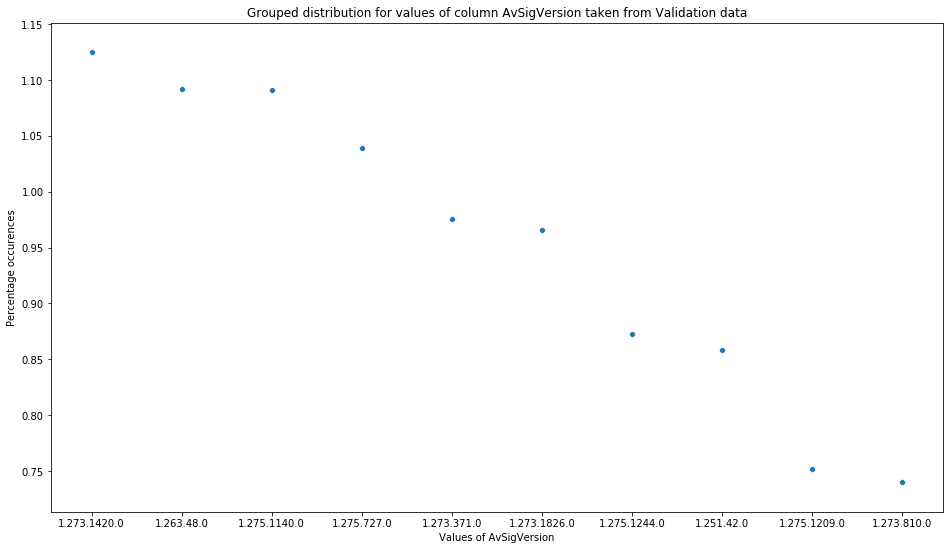

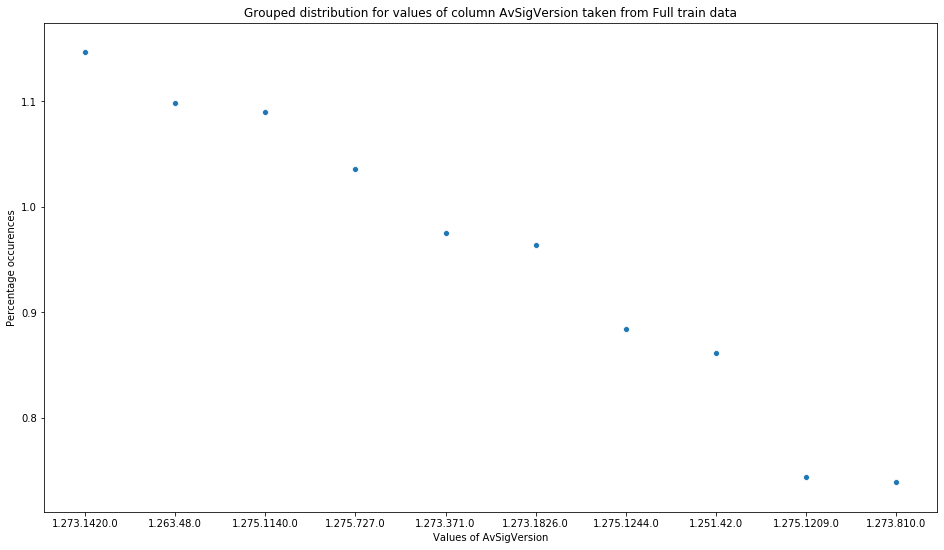

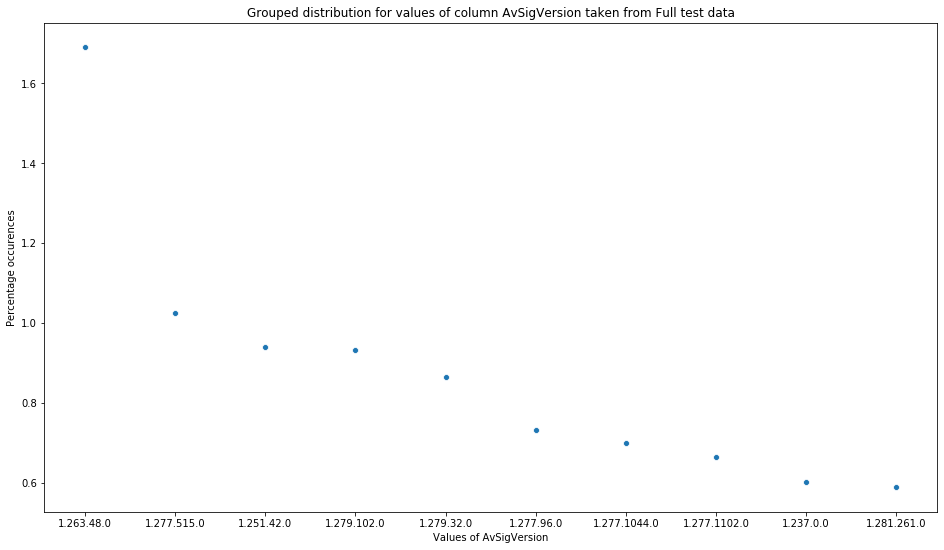

In [338]:
REL_COL = 'AvSigVersion'
handle_categorical_data(train_train_new, validation_train_new, train, test, REL_COL)

###### Data description for Platform in Train data ########
 count       7137186
unique            4
top       windows10
freq        6894954
Name: Platform, dtype: object 

Percentage of NA values is  0.0 

###### Data description for Platform in Validation data ########
 count       1784297
unique            4
top       windows10
freq        1723761
Name: Platform, dtype: object 

Percentage of NA values is  0.0 

###### Data description for Platform in Full train data ########
 count       8921483
unique            4
top       windows10
freq        8618715
Name: Platform, dtype: object 

Percentage of NA values is  0.0 

###### Data description for Platform in Full test data ########
 count       7853253
unique            4
top       windows10
freq        7675480
Name: Platform, dtype: object 

Percentage of NA values is  0.0 



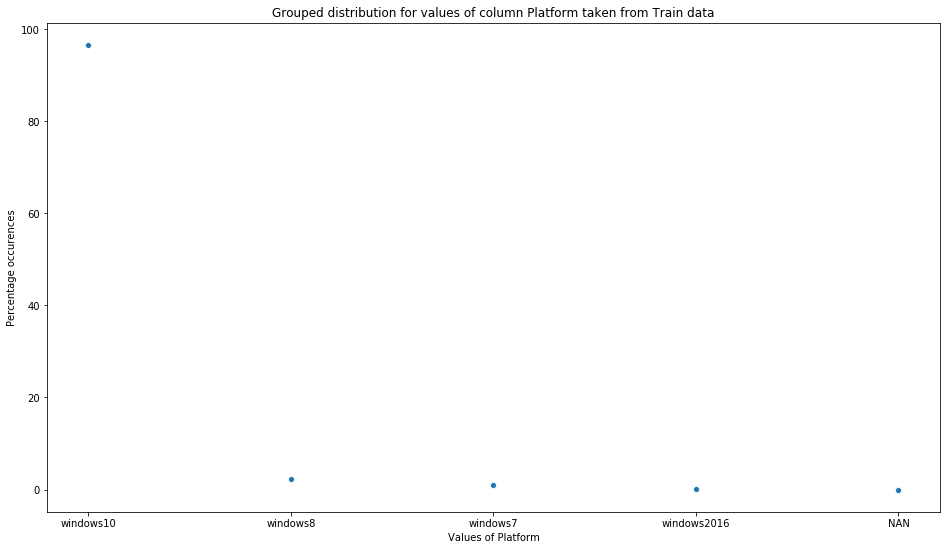

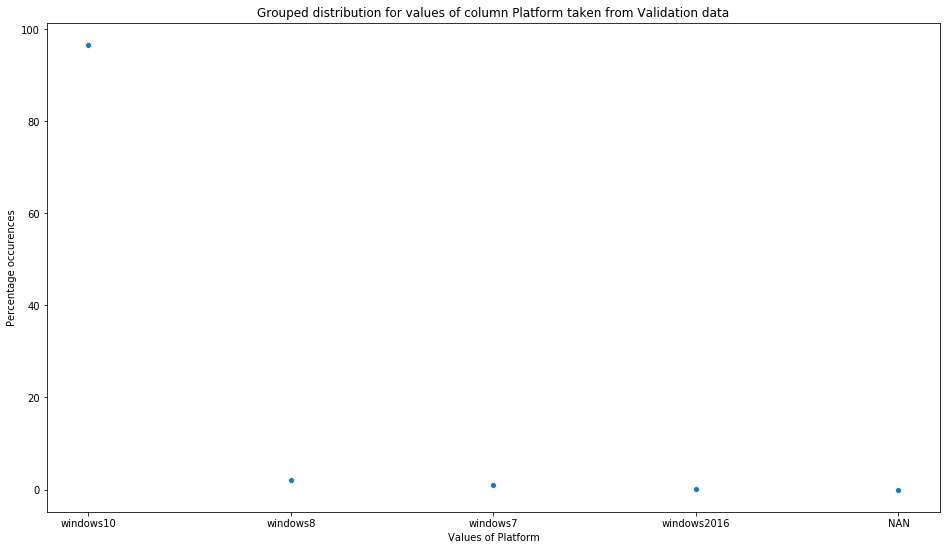

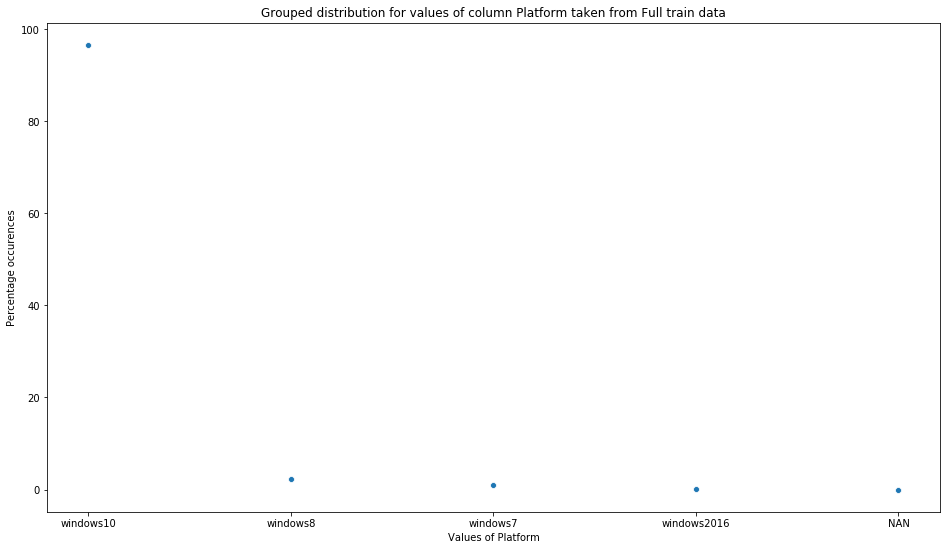

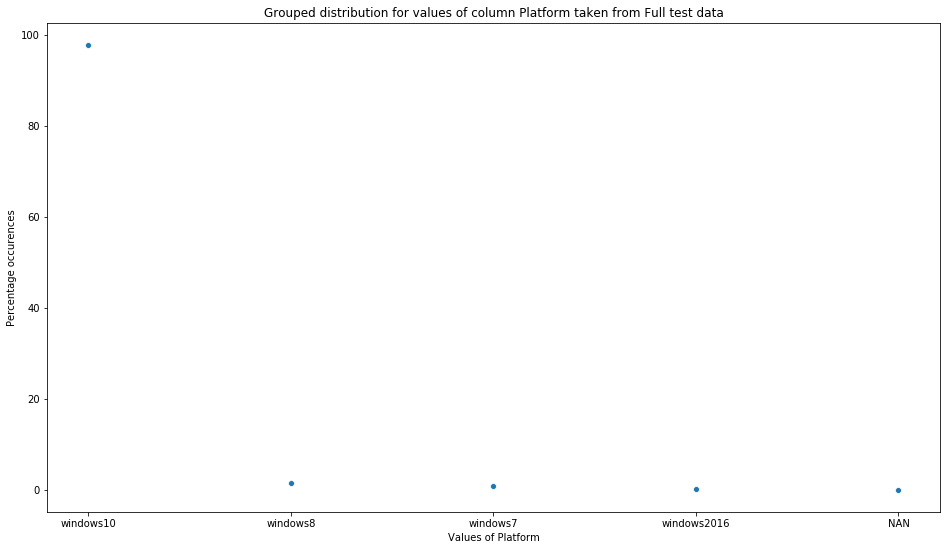

In [339]:
REL_COL = 'Platform'
handle_categorical_data(train_train_new, validation_train_new, train, test, REL_COL)

###### Data description for Processor in Train data ########
 count     7137186
unique          3
top           x64
freq      6484021
Name: Processor, dtype: object 

Percentage of NA values is  0.0 

###### Data description for Processor in Validation data ########
 count     1784297
unique          3
top           x64
freq      1621414
Name: Processor, dtype: object 

Percentage of NA values is  0.0 

###### Data description for Processor in Full train data ########
 count     8921483
unique          3
top           x64
freq      8105435
Name: Processor, dtype: object 

Percentage of NA values is  0.0 

###### Data description for Processor in Full test data ########
 count     7853253
unique          3
top           x64
freq      7173360
Name: Processor, dtype: object 

Percentage of NA values is  0.0 



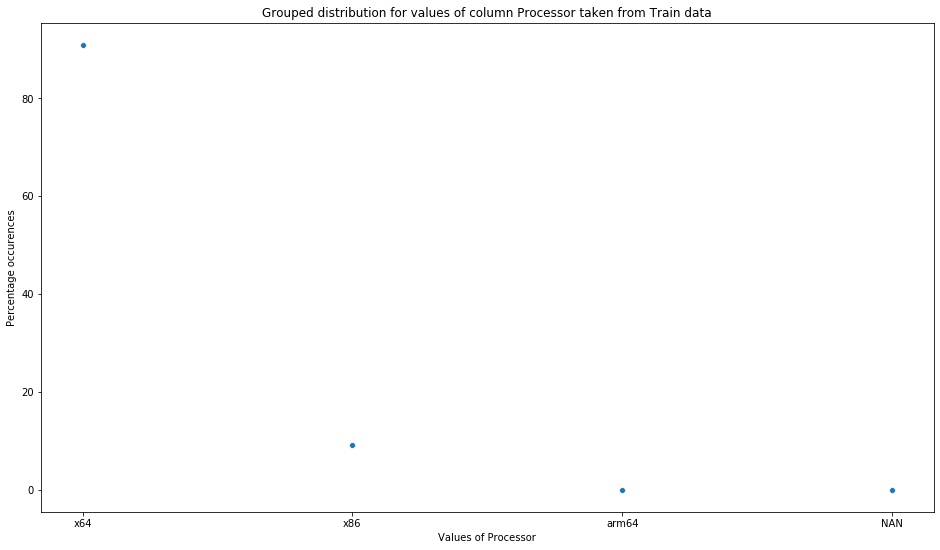

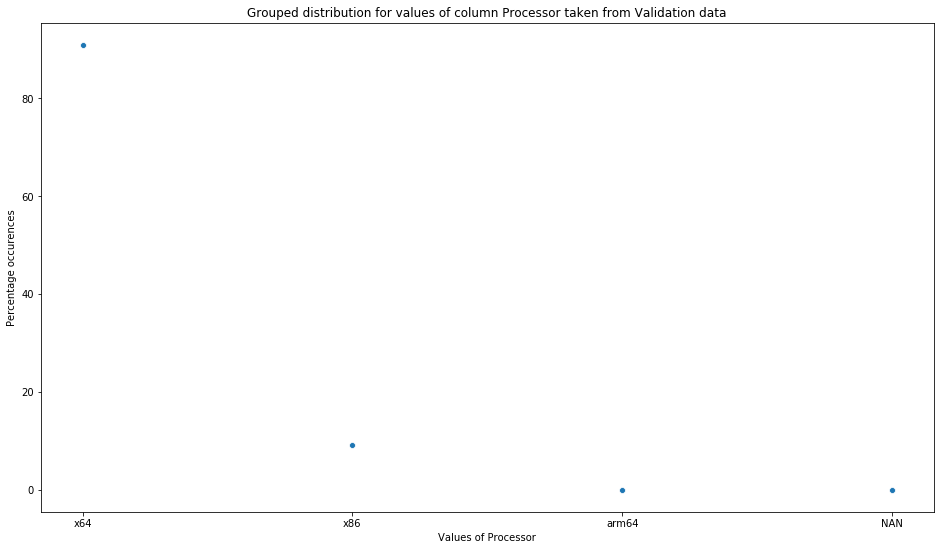

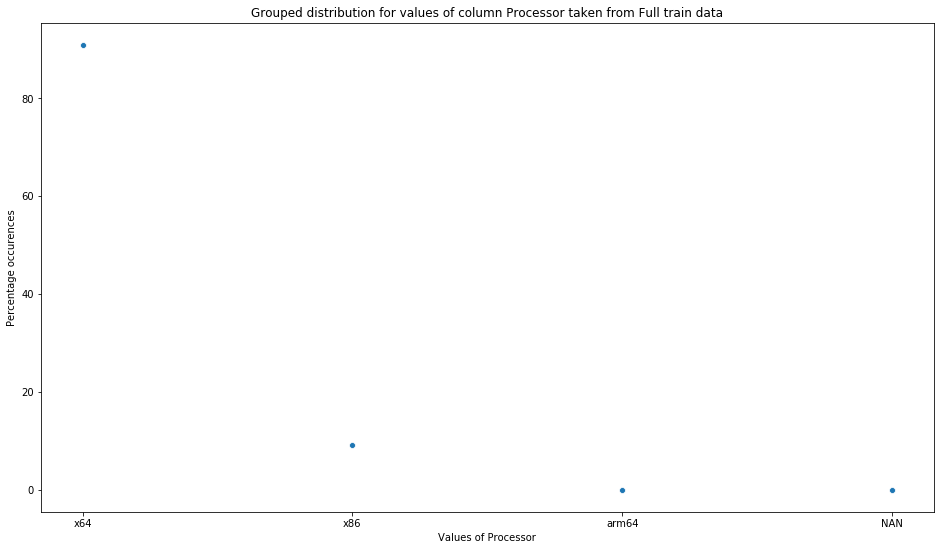

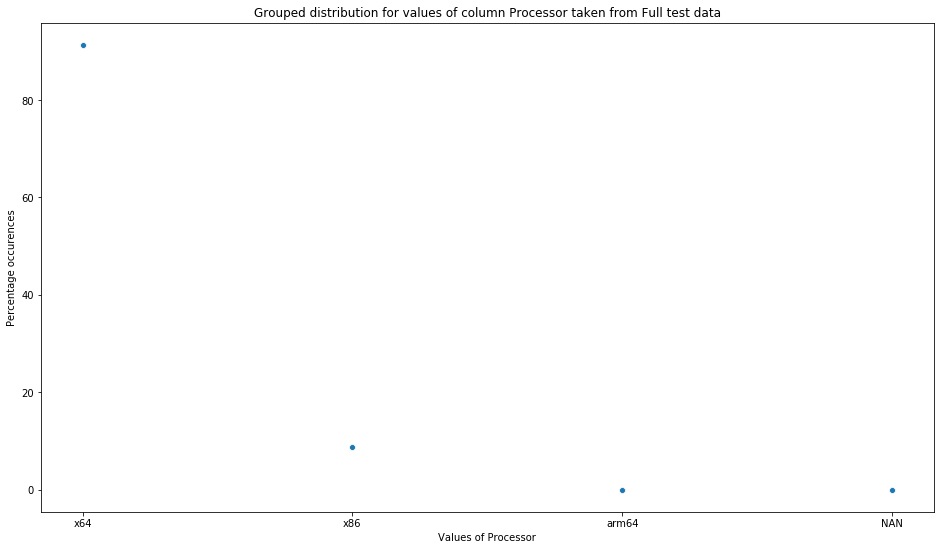

In [340]:
REL_COL = 'Processor'
handle_categorical_data(train_train_new, validation_train_new, train, test, REL_COL)

###### Data description for OsVer in Train data ########
 count      7137186
unique          50
top       10.0.0.0
freq       6906020
Name: OsVer, dtype: object 

Percentage of NA values is  0.0 

###### Data description for OsVer in Validation data ########
 count      1784297
unique          32
top       10.0.0.0
freq       1726525
Name: OsVer, dtype: object 

Percentage of NA values is  0.0 

###### Data description for OsVer in Full train data ########
 count      8921483
unique          58
top       10.0.0.0
freq       8632545
Name: OsVer, dtype: object 

Percentage of NA values is  0.0 

###### Data description for OsVer in Full test data ########
 count      7853253
unique          44
top       10.0.0.0
freq       7686083
Name: OsVer, dtype: object 

Percentage of NA values is  0.0 



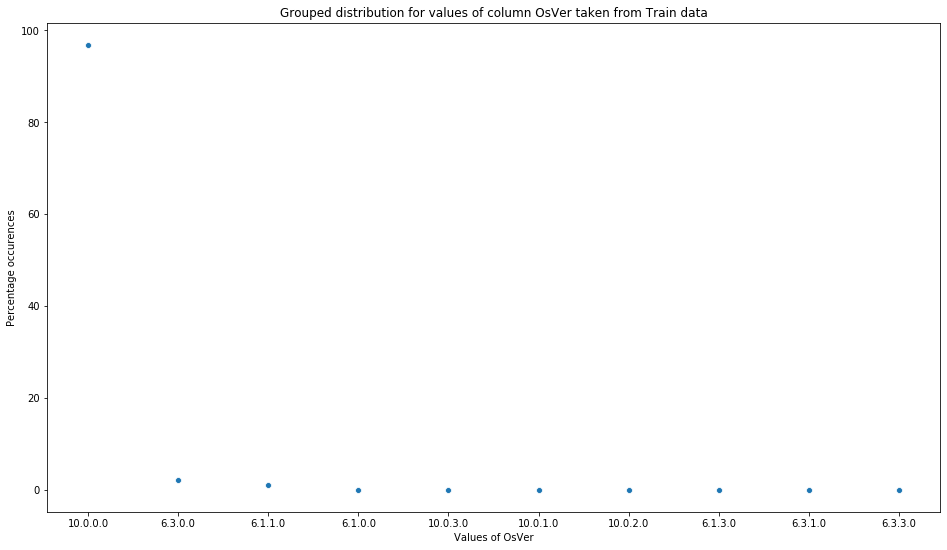

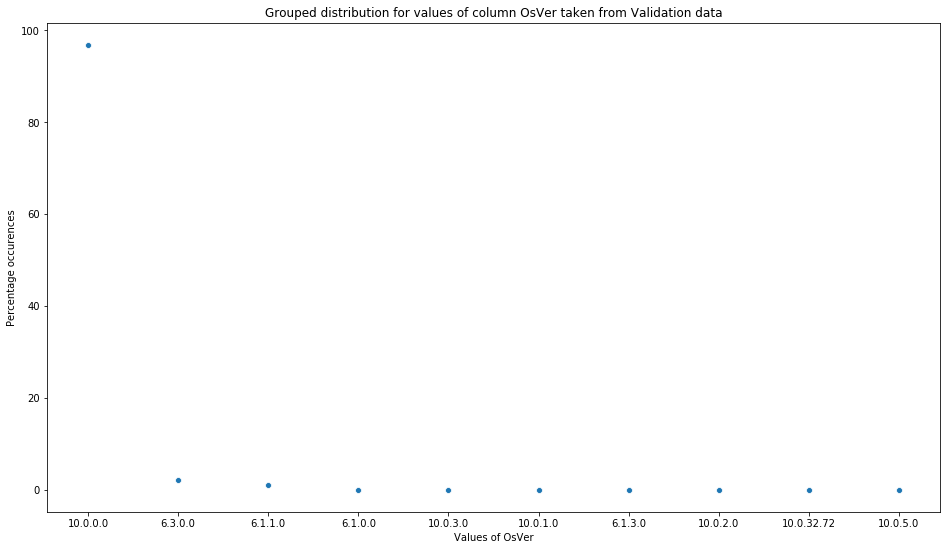

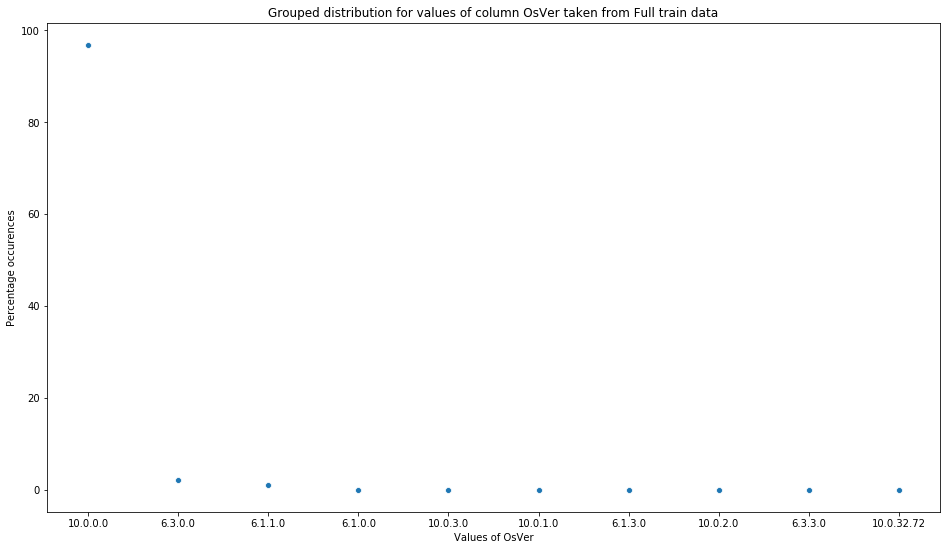

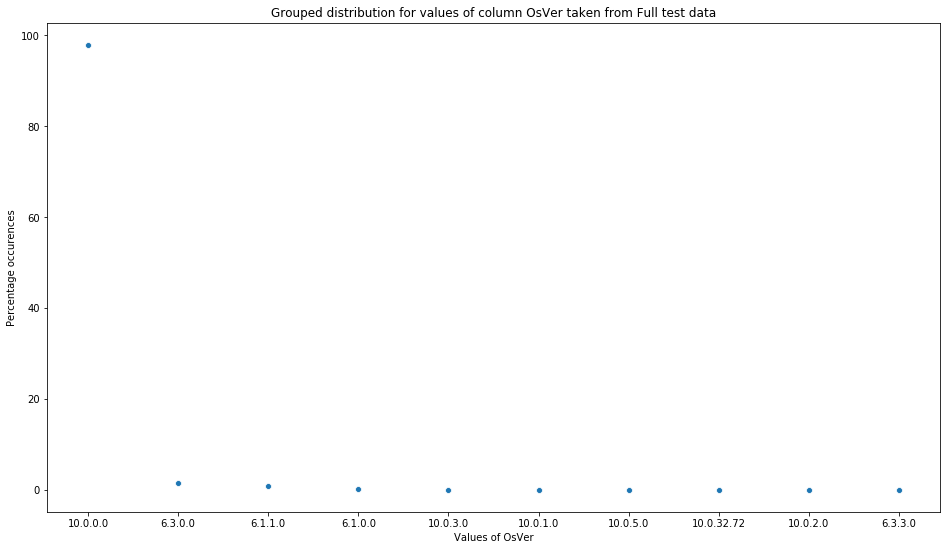

In [341]:
REL_COL = 'OsVer'
handle_categorical_data(train_train_new, validation_train_new, train, test, REL_COL)

###### Data description for OsVer in Train data ########
 count      7137186
unique          50
top       10.0.0.0
freq       6906020
Name: OsVer, dtype: object 

Percentage of NA values is  0.0 

###### Data description for OsVer in Validation data ########
 count      1784297
unique          32
top       10.0.0.0
freq       1726525
Name: OsVer, dtype: object 

Percentage of NA values is  0.0 

###### Data description for OsVer in Full train data ########
 count      8921483
unique          58
top       10.0.0.0
freq       8632545
Name: OsVer, dtype: object 

Percentage of NA values is  0.0 

###### Data description for OsVer in Full test data ########
 count      7853253
unique          44
top       10.0.0.0
freq       7686083
Name: OsVer, dtype: object 

Percentage of NA values is  0.0 



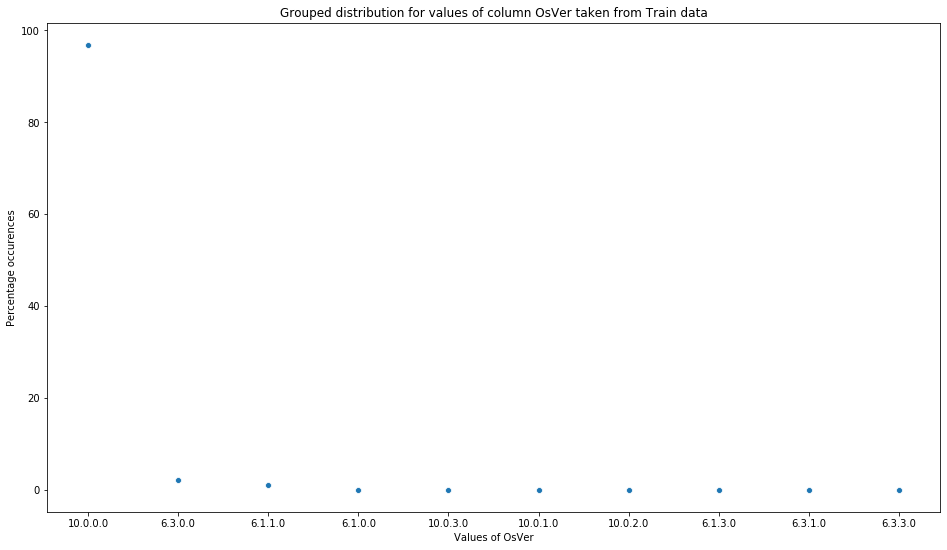

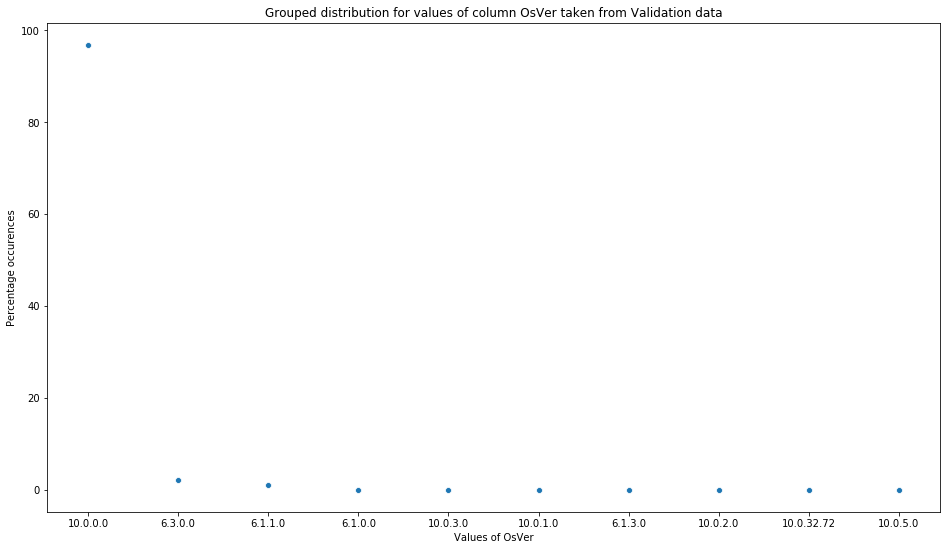

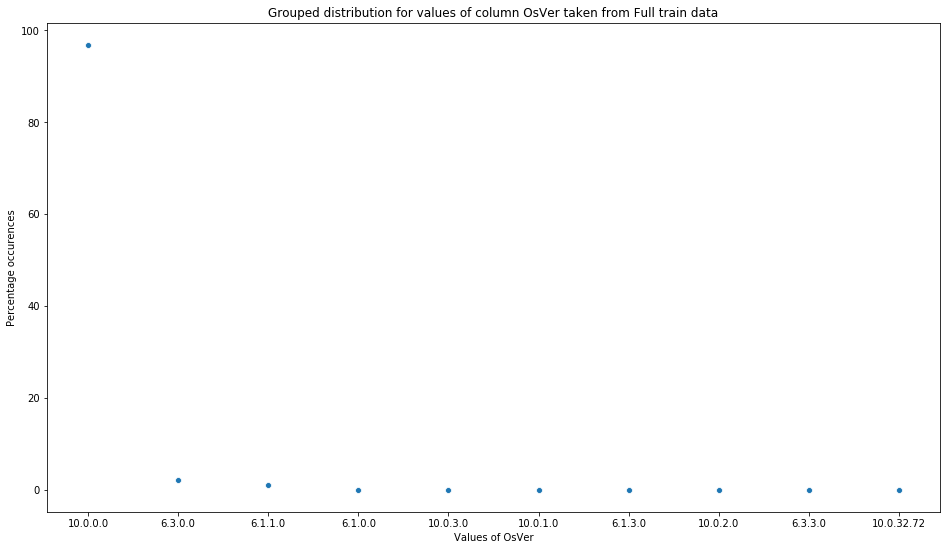

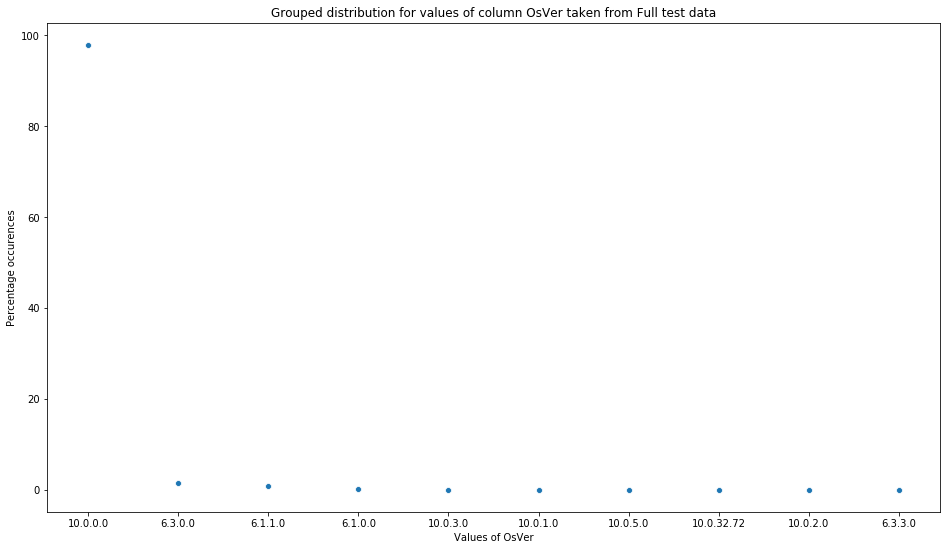

In [342]:
REL_COL = 'OsVer'
handle_categorical_data(train_train_new, validation_train_new, train, test, REL_COL)

###### Data description for OsPlatformSubRelease in Train data ########
 count     7137186
unique          9
top           rs4
freq      3131825
Name: OsPlatformSubRelease, dtype: object 

Percentage of NA values is  0.0 

###### Data description for OsPlatformSubRelease in Validation data ########
 count     1784297
unique          9
top           rs4
freq       783701
Name: OsPlatformSubRelease, dtype: object 

Percentage of NA values is  0.0 

###### Data description for OsPlatformSubRelease in Full train data ########
 count     8921483
unique          9
top           rs4
freq      3915526
Name: OsPlatformSubRelease, dtype: object 

Percentage of NA values is  0.0 

###### Data description for OsPlatformSubRelease in Full test data ########
 count     7853253
unique          9
top           rs4
freq      3893189
Name: OsPlatformSubRelease, dtype: object 

Percentage of NA values is  0.0 



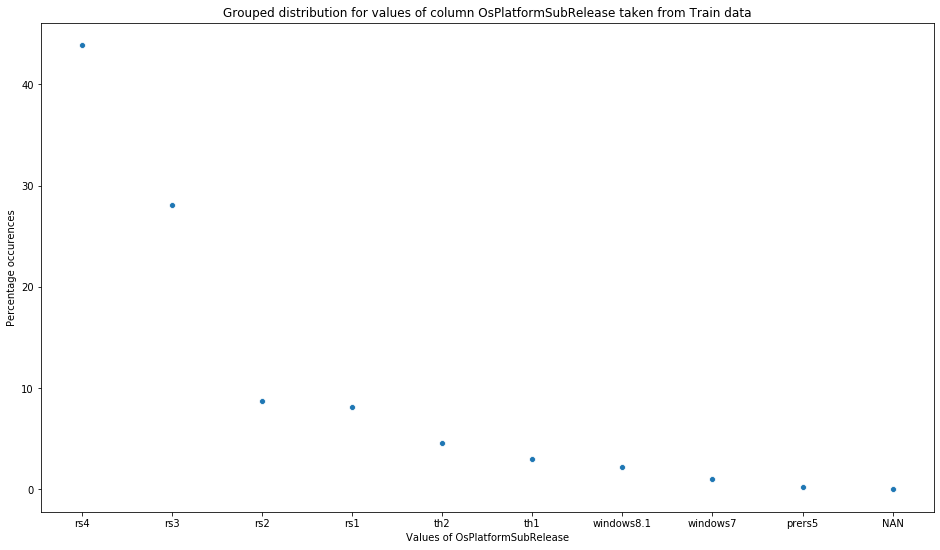

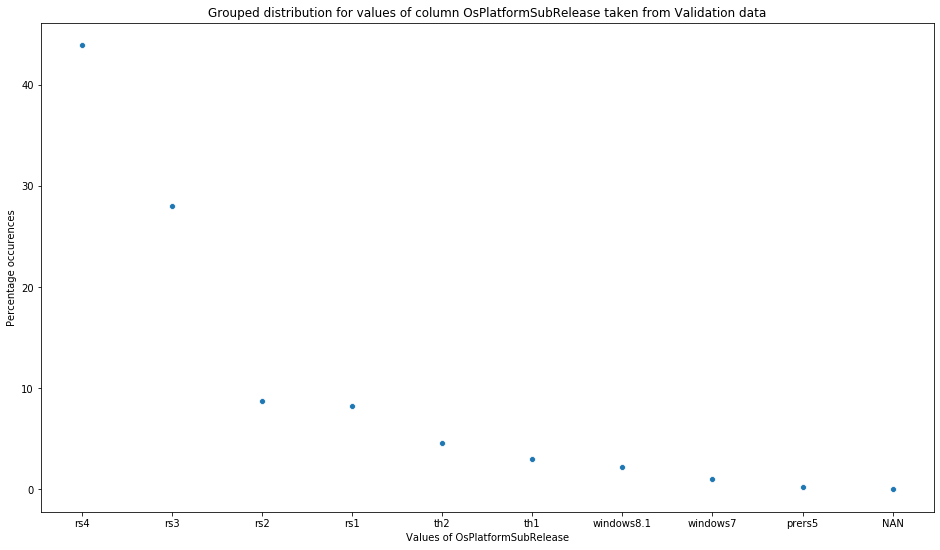

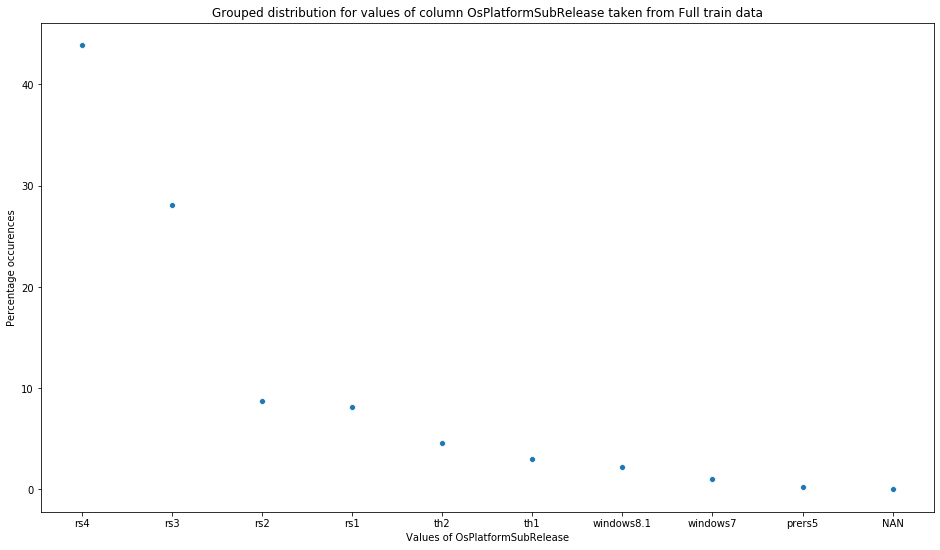

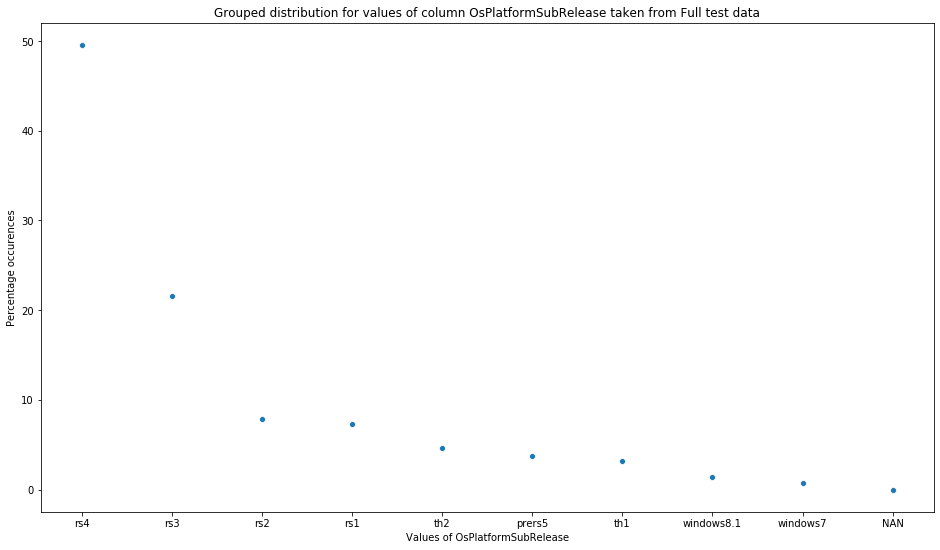

In [343]:
REL_COL = 'OsPlatformSubRelease'
handle_categorical_data(train_train_new, validation_train_new, train, test, REL_COL)

###### Data description for OsBuildLab in Train data ########
 count                                      7137171
unique                                         646
top       17134.1.amd64fre.rs4_release.180410-1804
freq                                       2926021
Name: OsBuildLab, dtype: object 

Percentage of NA values is  0.00021016686408340766 

###### Data description for OsBuildLab in Validation data ########
 count                                      1784291
unique                                         533
top       17134.1.amd64fre.rs4_release.180410-1804
freq                                        732178
Name: OsBuildLab, dtype: object 

Percentage of NA values is  0.00033626688830390905 

###### Data description for OsBuildLab in Full train data ########
 count                                      8921462
unique                                         663
top       17134.1.amd64fre.rs4_release.180410-1804
freq                                       3658199
Name: OsBuildLa

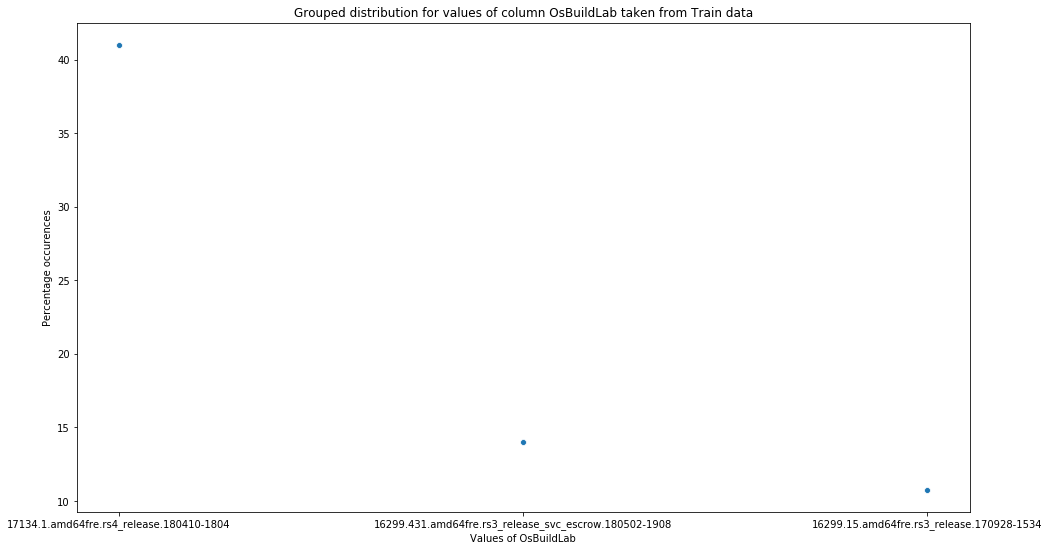

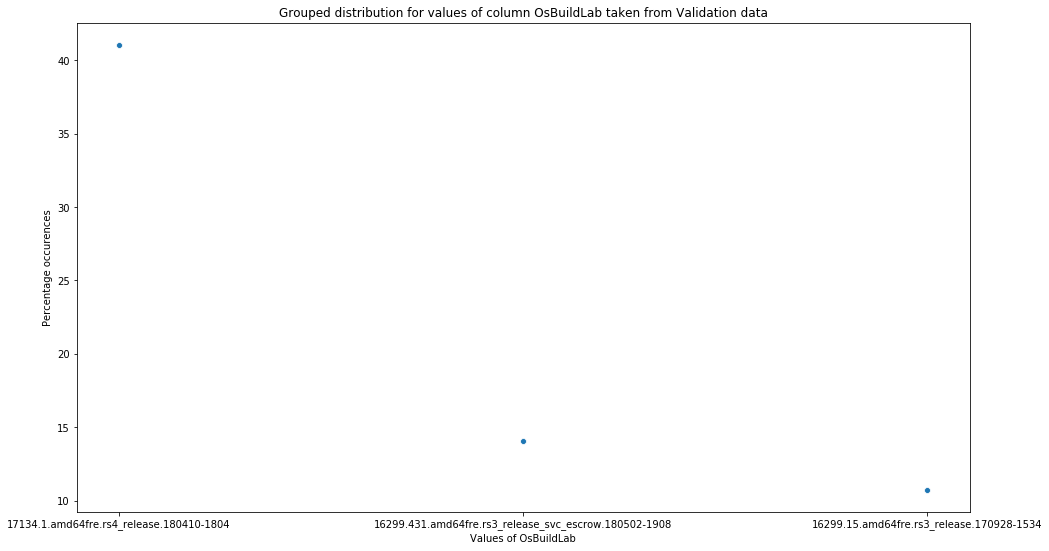

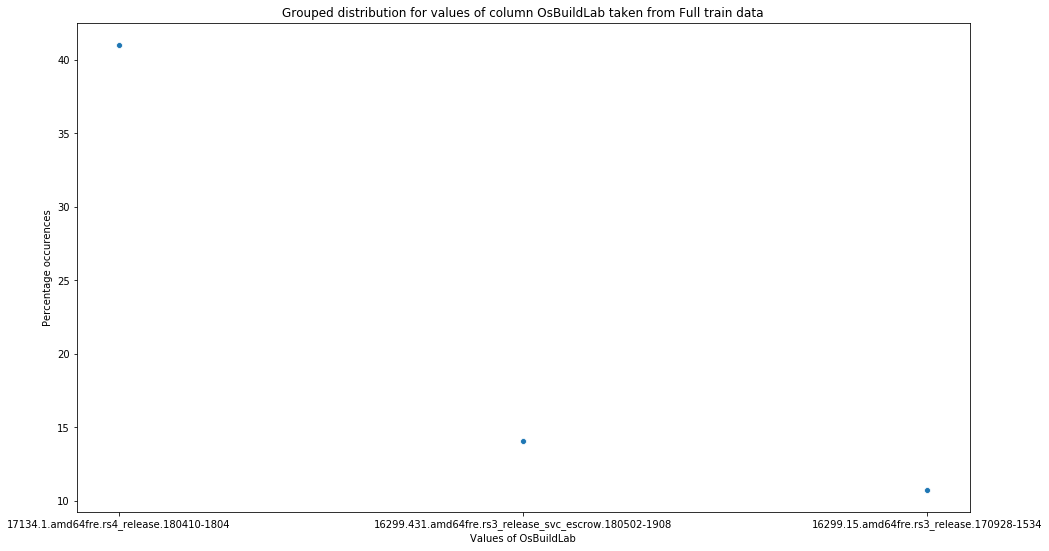

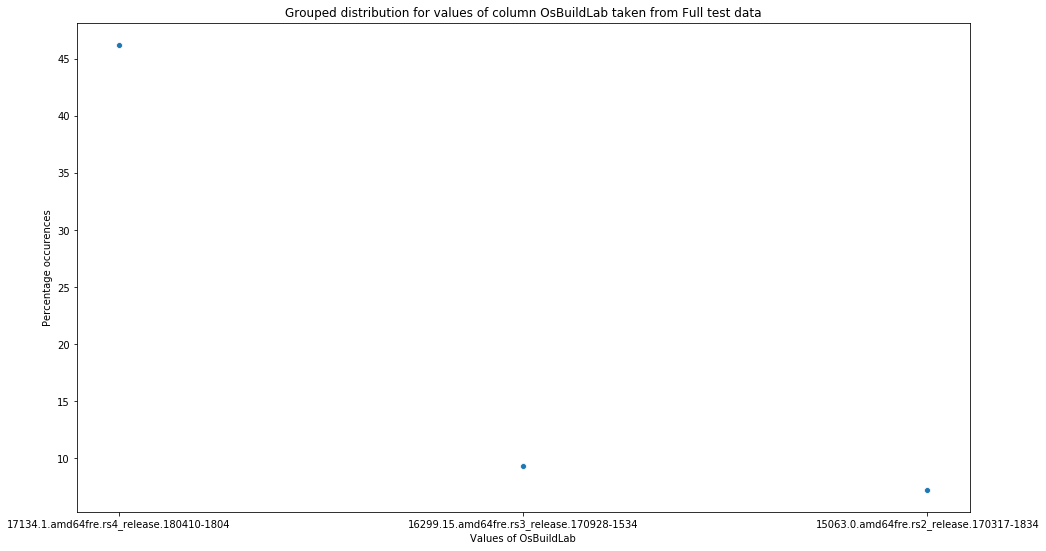

In [344]:
REL_COL = 'OsBuildLab'
handle_categorical_data(train_train_new, validation_train_new, train, test, REL_COL, 3)

###### Data description for SkuEdition in Train data ########
 count     7137186
unique          8
top          Home
freq      4411874
Name: SkuEdition, dtype: object 

Percentage of NA values is  0.0 

###### Data description for SkuEdition in Validation data ########
 count     1784297
unique          8
top          Home
freq      1102467
Name: SkuEdition, dtype: object 

Percentage of NA values is  0.0 

###### Data description for SkuEdition in Full train data ########
 count     8921483
unique          8
top          Home
freq      5514341
Name: SkuEdition, dtype: object 

Percentage of NA values is  0.0 

###### Data description for SkuEdition in Full test data ########
 count     7853253
unique          8
top          Home
freq      4513114
Name: SkuEdition, dtype: object 

Percentage of NA values is  0.0 



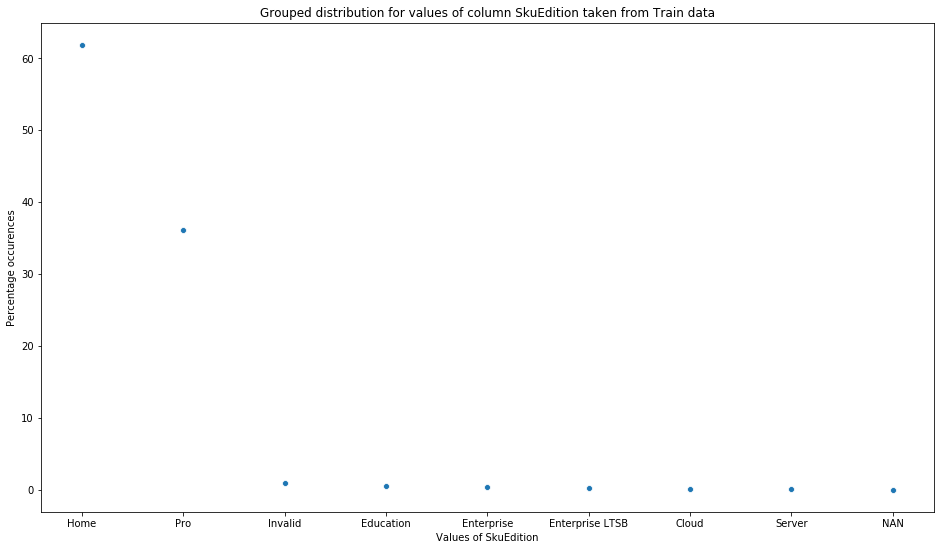

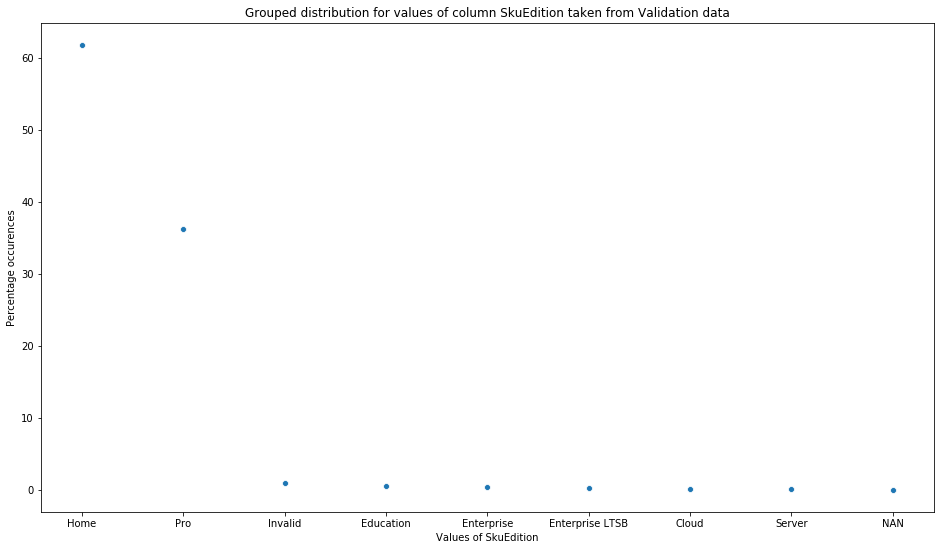

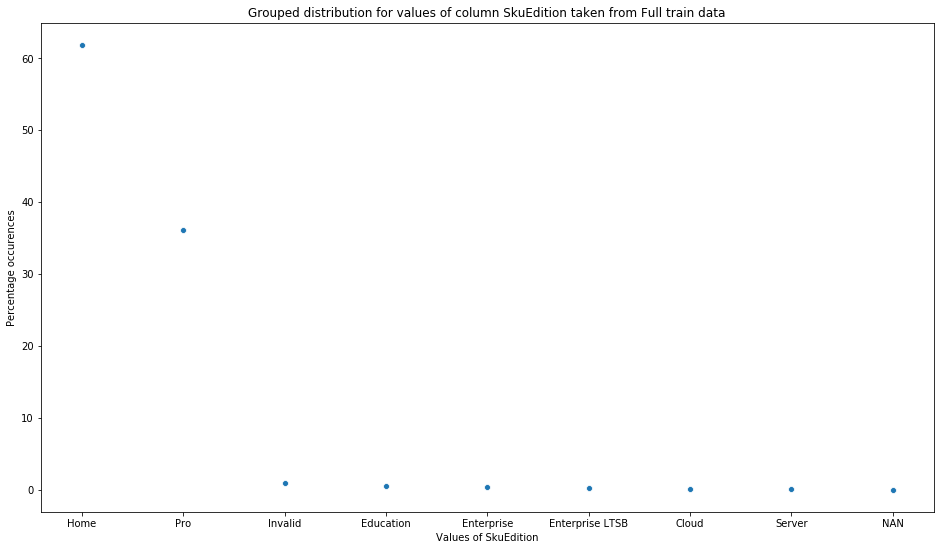

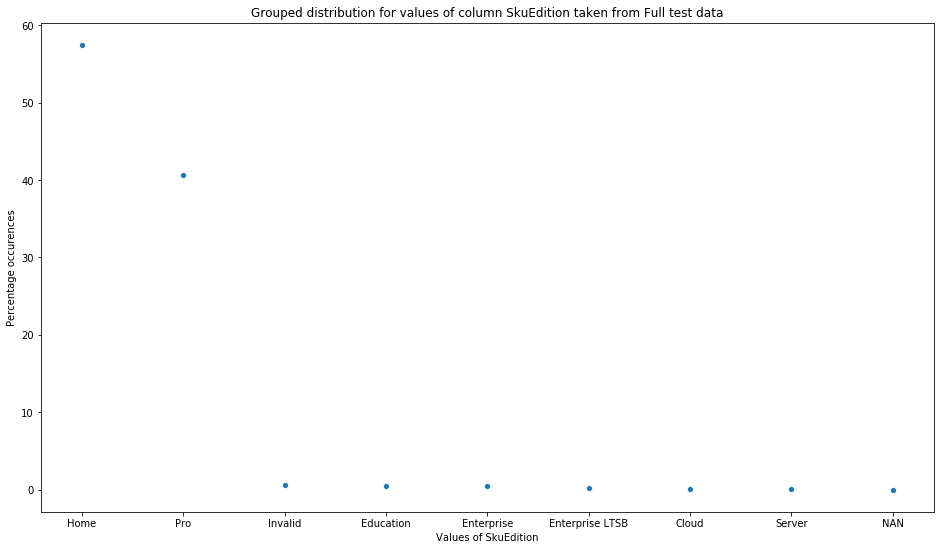

In [345]:
REL_COL = 'SkuEdition'
handle_categorical_data(train_train_new, validation_train_new, train, test, REL_COL)

###### Data description for Census_MDC2FormFactor in Train data ########
 count      7137186
unique          13
top       Notebook
freq       4578891
Name: Census_MDC2FormFactor, dtype: object 

Percentage of NA values is  0.0 

###### Data description for Census_MDC2FormFactor in Validation data ########
 count      1784297
unique          12
top       Notebook
freq       1144428
Name: Census_MDC2FormFactor, dtype: object 

Percentage of NA values is  0.0 

###### Data description for Census_MDC2FormFactor in Full train data ########
 count      8921483
unique          13
top       Notebook
freq       5723319
Name: Census_MDC2FormFactor, dtype: object 

Percentage of NA values is  0.0 

###### Data description for Census_MDC2FormFactor in Full test data ########
 count      7853253
unique          14
top       Notebook
freq       4929536
Name: Census_MDC2FormFactor, dtype: object 

Percentage of NA values is  0.0 



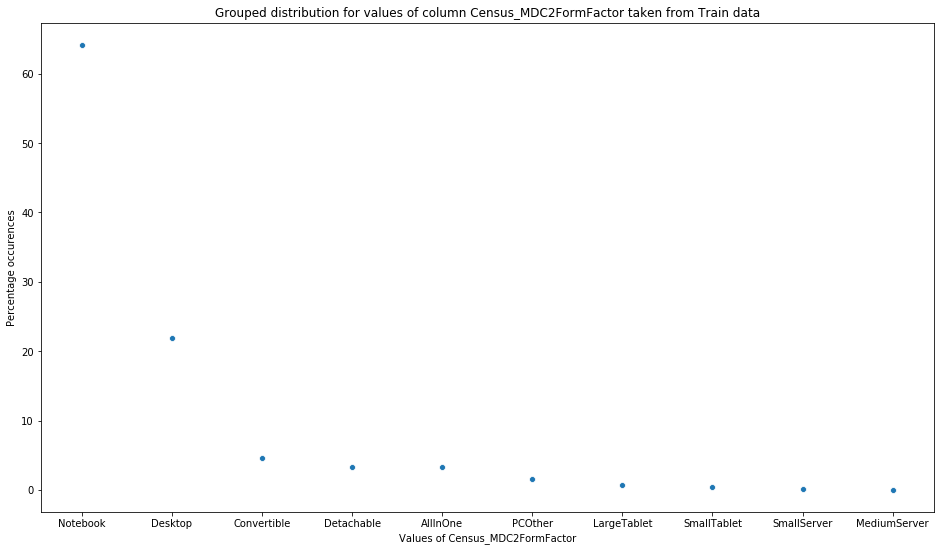

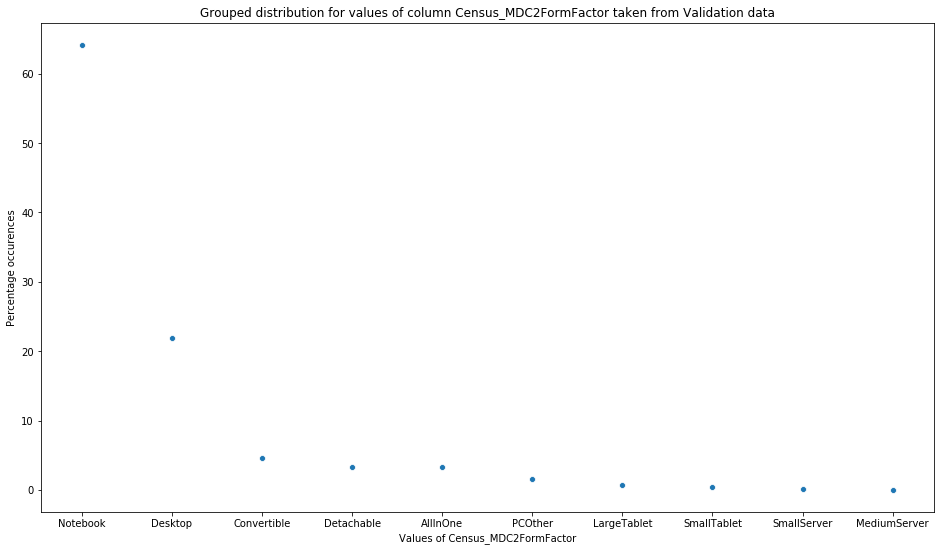

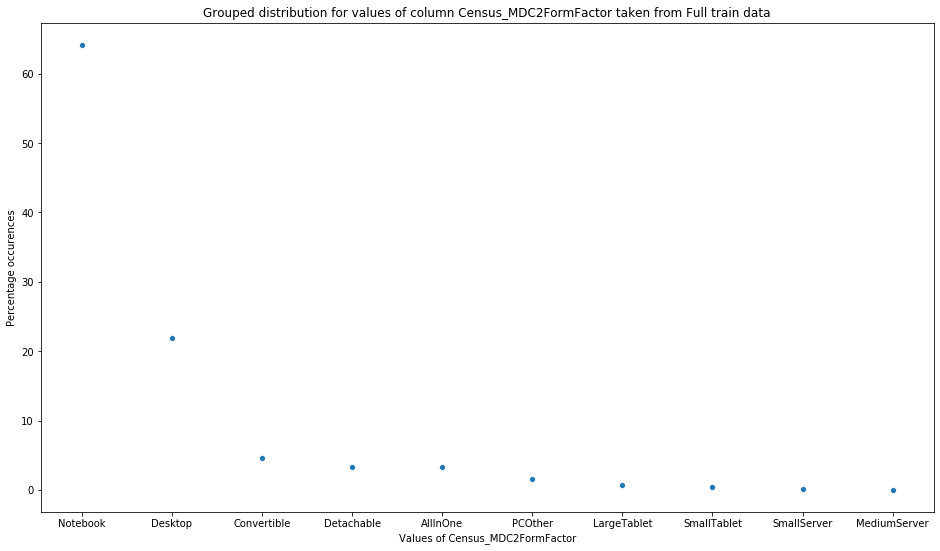

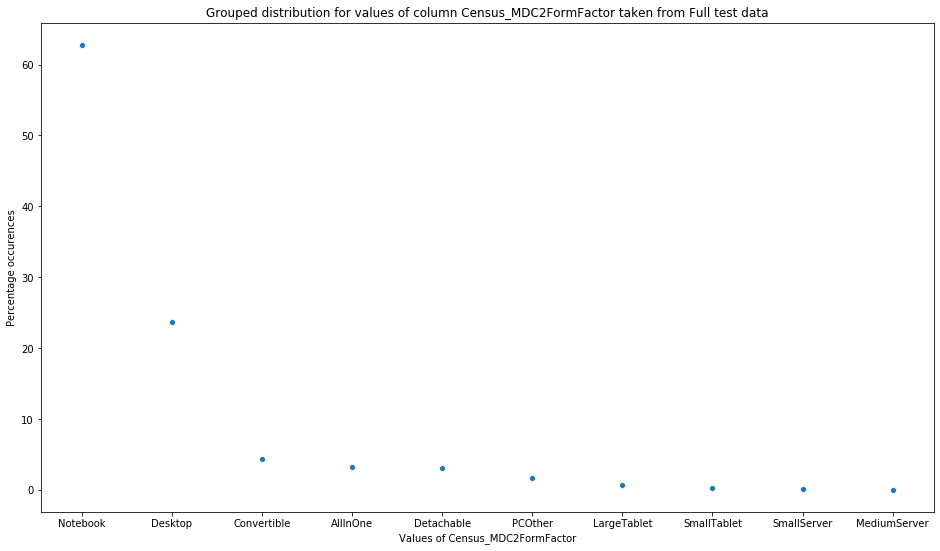

In [346]:
REL_COL = 'Census_MDC2FormFactor'
handle_categorical_data(train_train_new, validation_train_new, train, test, REL_COL)

###### Data description for Census_DeviceFamily in Train data ########
 count             7137186
unique                  3
top       Windows.Desktop
freq              7125646
Name: Census_DeviceFamily, dtype: object 

Percentage of NA values is  0.0 

###### Data description for Census_DeviceFamily in Validation data ########
 count             1784297
unique                  3
top       Windows.Desktop
freq              1781407
Name: Census_DeviceFamily, dtype: object 

Percentage of NA values is  0.0 

###### Data description for Census_DeviceFamily in Full train data ########
 count             8921483
unique                  3
top       Windows.Desktop
freq              8907053
Name: Census_DeviceFamily, dtype: object 

Percentage of NA values is  0.0 

###### Data description for Census_DeviceFamily in Full test data ########
 count             7853253
unique                  3
top       Windows.Desktop
freq              7842175
Name: Census_DeviceFamily, dtype: object 

Percenta

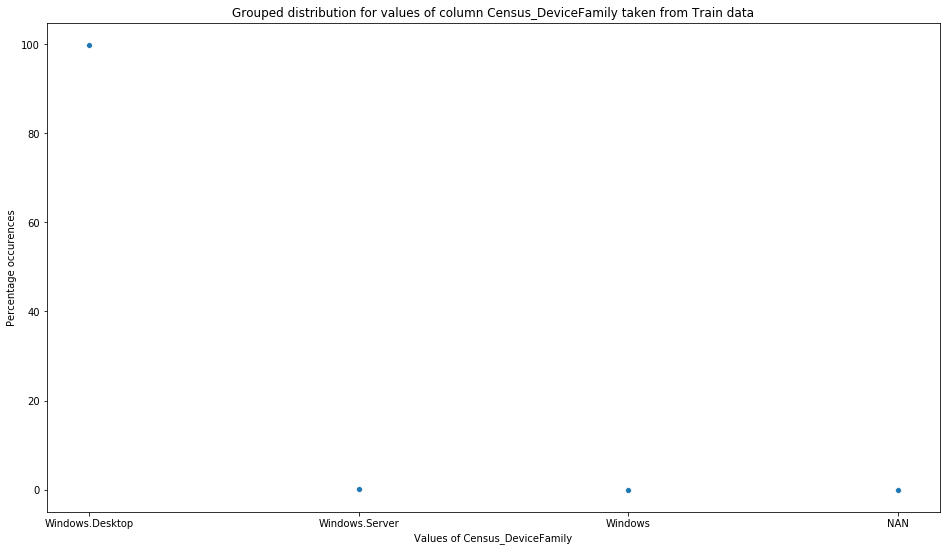

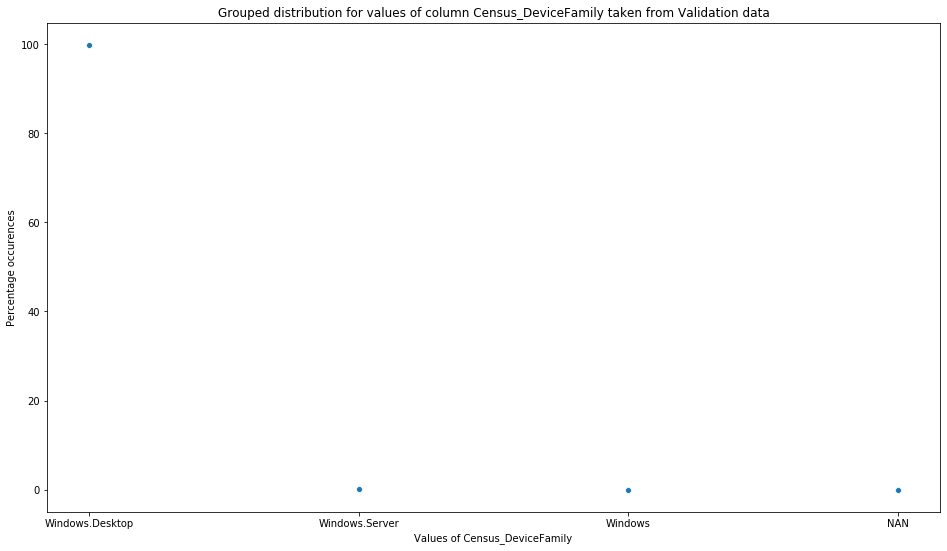

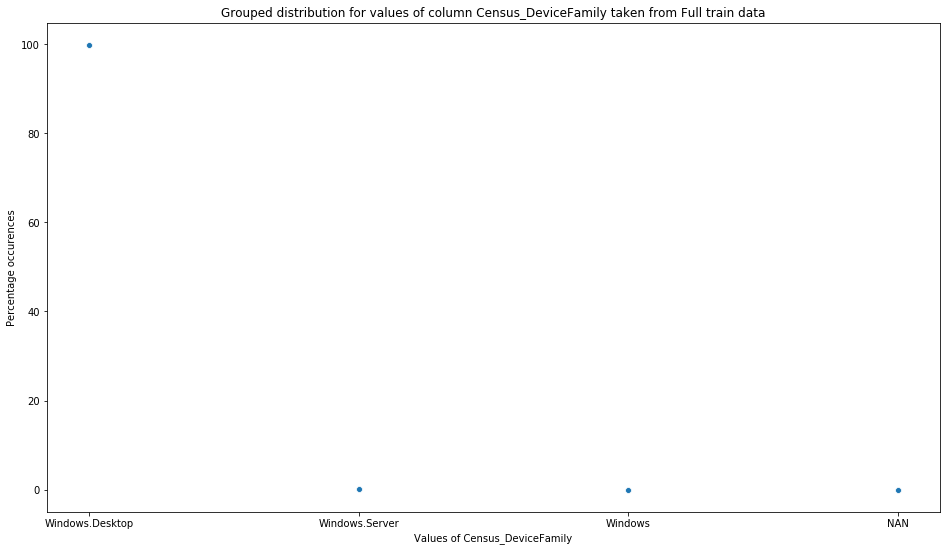

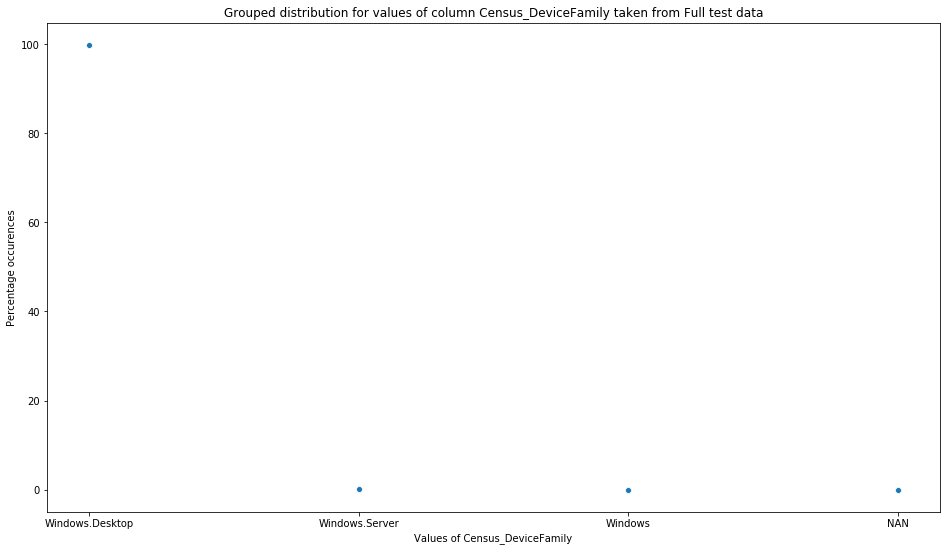

In [347]:
REL_COL = 'Census_DeviceFamily'
handle_categorical_data(train_train_new, validation_train_new, train, test, REL_COL)

###### Data description for Census_PrimaryDiskTypeName in Train data ########
 count     7126924
unique          4
top           HDD
freq      4646297
Name: Census_PrimaryDiskTypeName, dtype: object 

Percentage of NA values is  0.1437821572815953 

###### Data description for Census_PrimaryDiskTypeName in Validation data ########
 count     1781715
unique          4
top           HDD
freq      1160507
Name: Census_PrimaryDiskTypeName, dtype: object 

Percentage of NA values is  0.14470685093344887 

###### Data description for Census_PrimaryDiskTypeName in Full train data ########
 count     8908639
unique          4
top           HDD
freq      5806804
Name: Census_PrimaryDiskTypeName, dtype: object 

Percentage of NA values is  0.1439670960534252 

###### Data description for Census_PrimaryDiskTypeName in Full test data ########
 count     7846446
unique          4
top           HDD
freq      4894312
Name: Census_PrimaryDiskTypeName, dtype: object 

Percentage of NA values is  0.0866

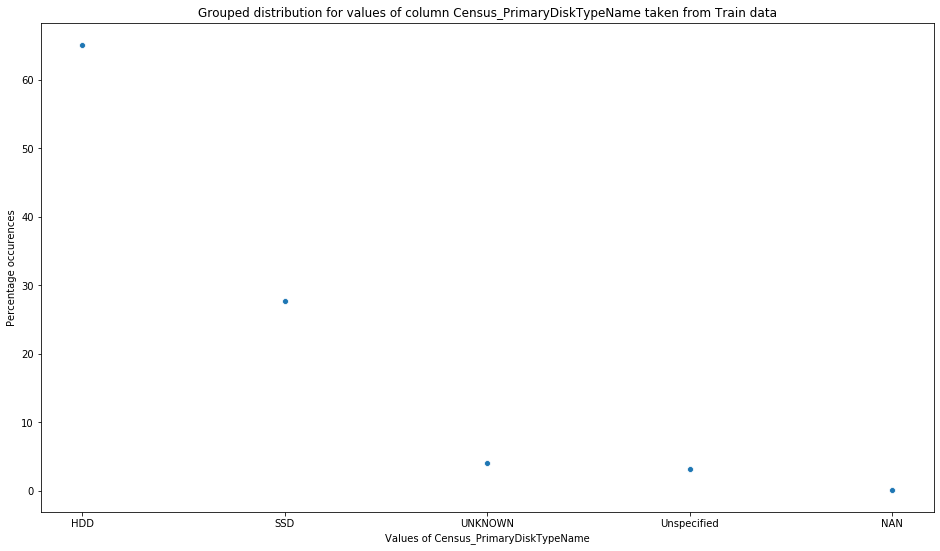

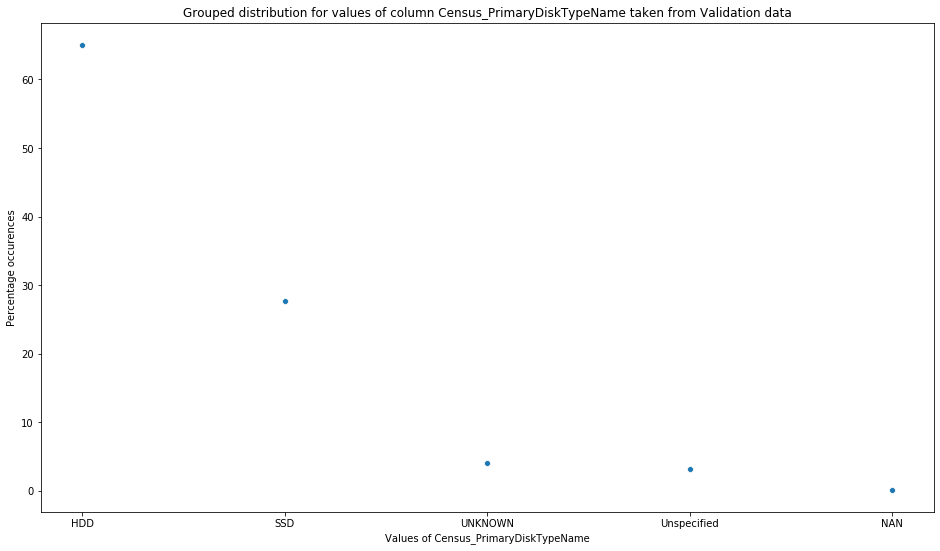

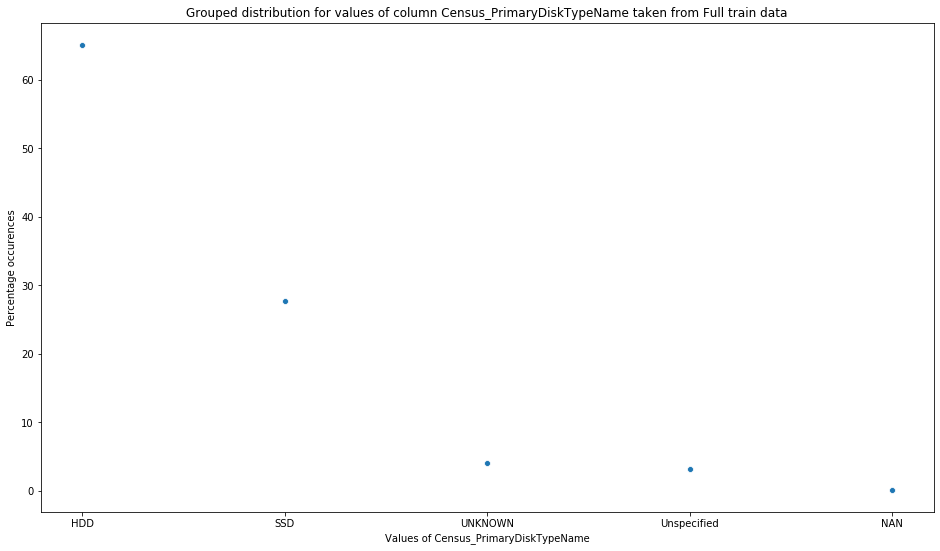

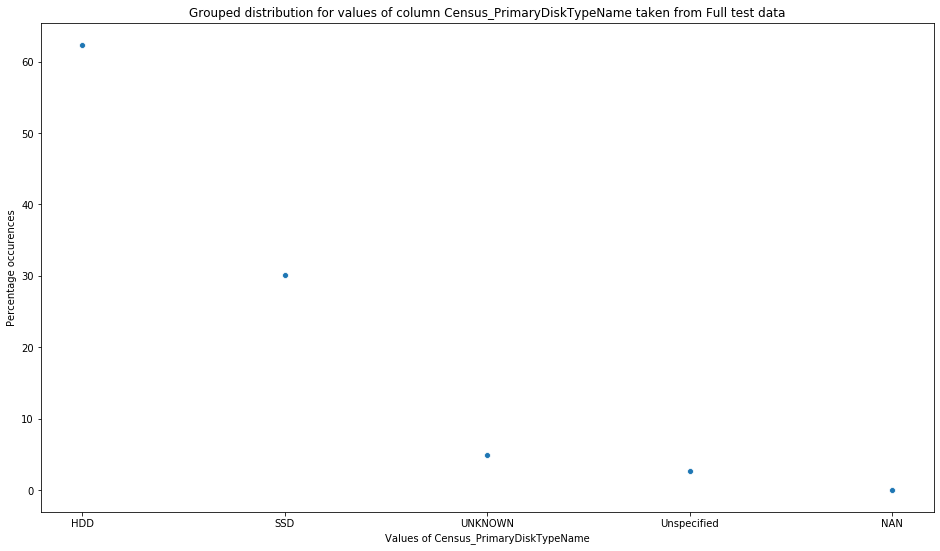

In [348]:
REL_COL = 'Census_PrimaryDiskTypeName'
handle_categorical_data(train_train_new, validation_train_new, train, test, REL_COL)

###### Data description for Census_ChassisTypeName in Train data ########
 count      7136681
unique          50
top       Notebook
freq       4199272
Name: Census_ChassisTypeName, dtype: object 

Percentage of NA values is  0.007075617757474725 

###### Data description for Census_ChassisTypeName in Validation data ########
 count      1784179
unique          39
top       Notebook
freq       1049540
Name: Census_ChassisTypeName, dtype: object 

Percentage of NA values is  0.006613248803310211 

###### Data description for Census_ChassisTypeName in Full train data ########
 count      8920860
unique          52
top       Notebook
freq       5248812
Name: Census_ChassisTypeName, dtype: object 

Percentage of NA values is  0.006983143945911235 

###### Data description for Census_ChassisTypeName in Full test data ########
 count      7852912
unique          48
top       Notebook
freq       4498390
Name: Census_ChassisTypeName, dtype: object 

Percentage of NA values is  0.004342149679884

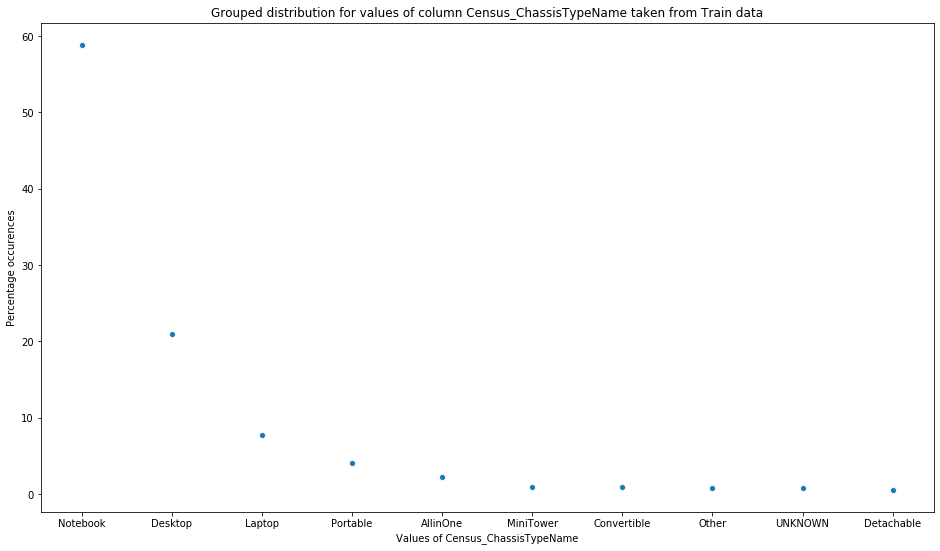

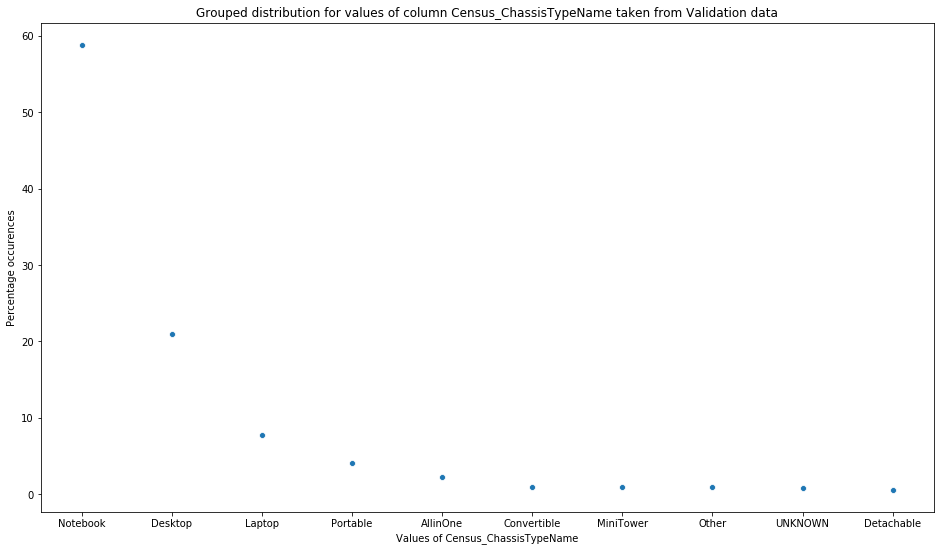

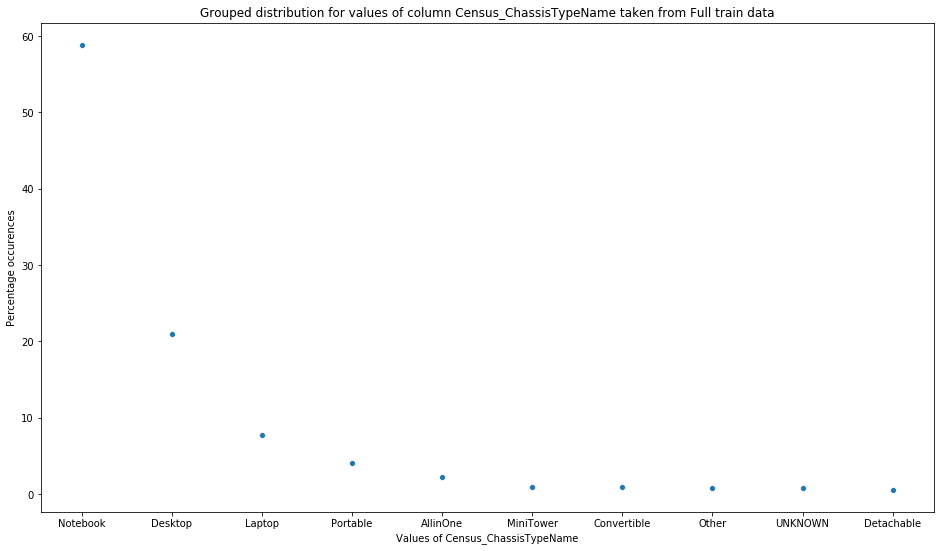

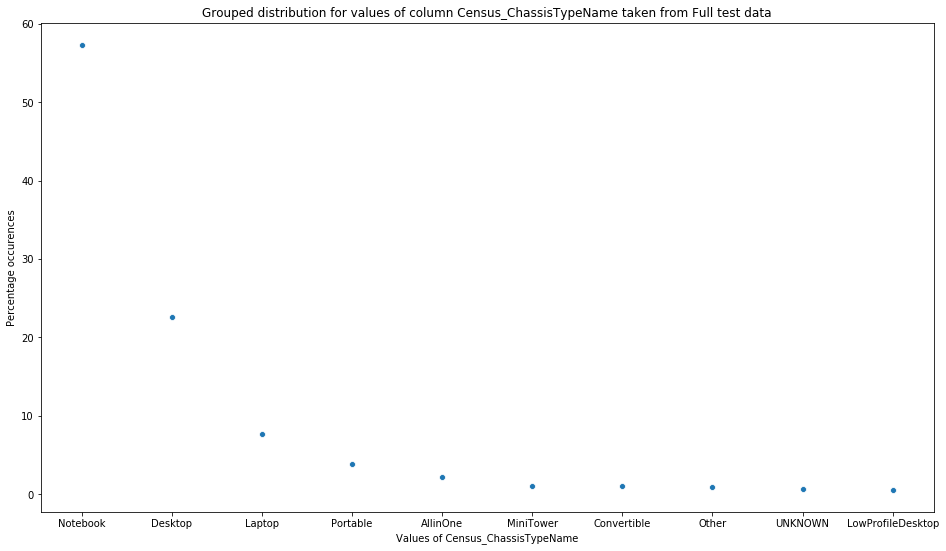

In [349]:
REL_COL = 'Census_ChassisTypeName'
handle_categorical_data(train_train_new, validation_train_new, train, test, REL_COL)

###### Data description for Census_PowerPlatformRoleName in Train data ########
 count     7137140
unique         10
top        Mobile
freq      4946572
Name: Census_PowerPlatformRoleName, dtype: object 

Percentage of NA values is  0.0006445117165224502 

###### Data description for Census_PowerPlatformRoleName in Validation data ########
 count     1784288
unique         10
top        Mobile
freq      1236336
Name: Census_PowerPlatformRoleName, dtype: object 

Percentage of NA values is  0.0005044003324558635 

###### Data description for Census_PowerPlatformRoleName in Full train data ########
 count     8921428
unique         10
top        Mobile
freq      6182908
Name: Census_PowerPlatformRoleName, dtype: object 

Percentage of NA values is  0.0006164894334271555 

###### Data description for Census_PowerPlatformRoleName in Full test data ########
 count     7853227
unique         10
top        Mobile
freq      5323917
Name: Census_PowerPlatformRoleName, dtype: object 

Percentage

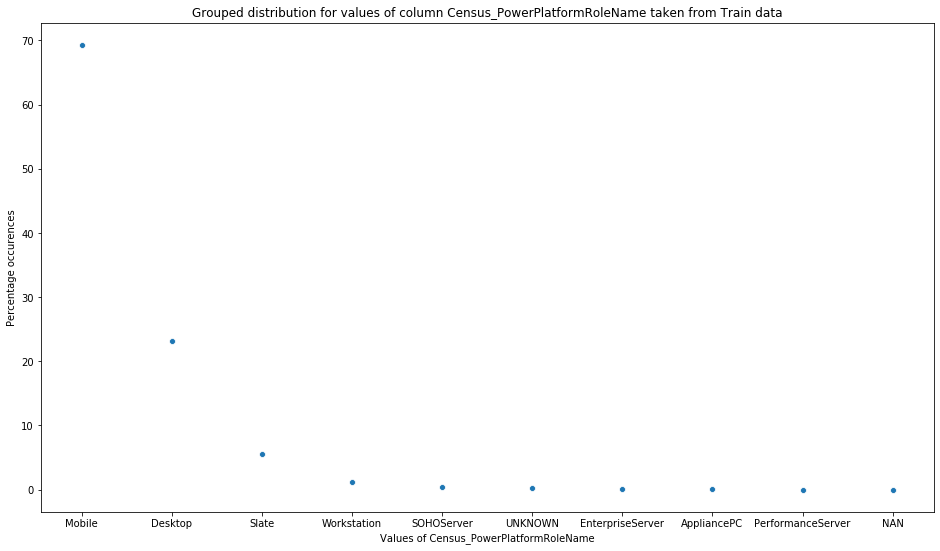

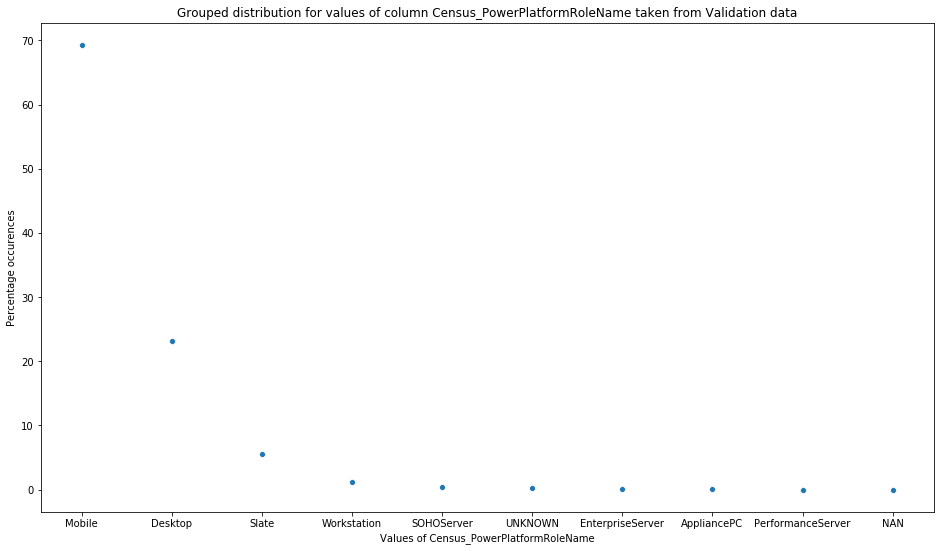

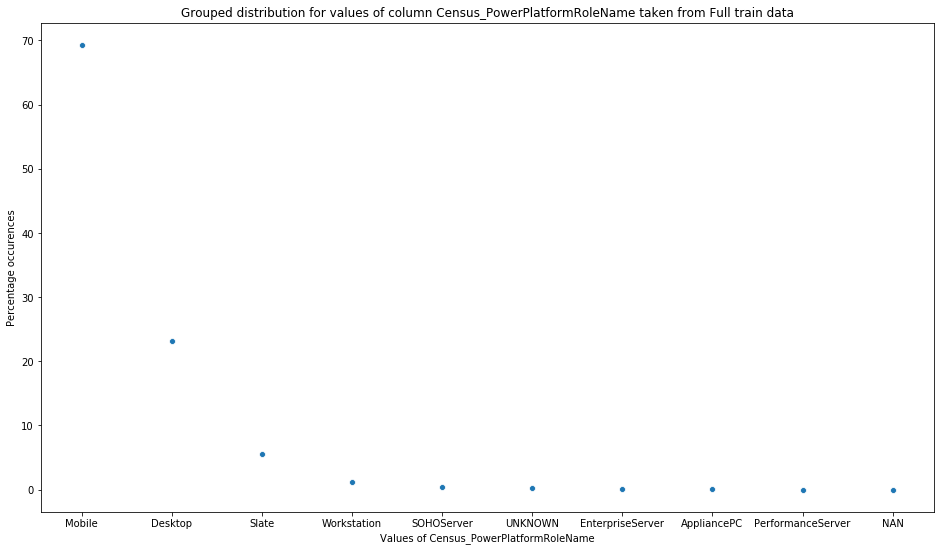

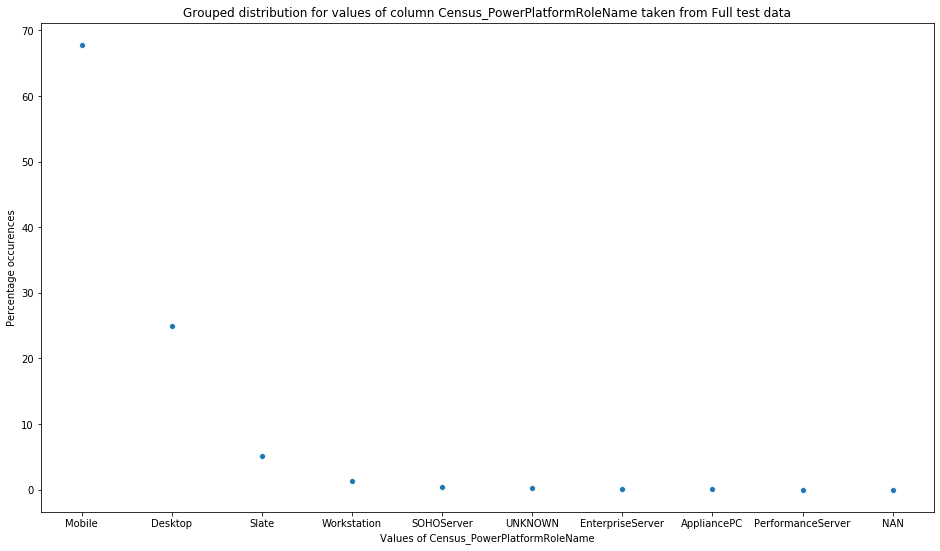

In [350]:
REL_COL = 'Census_PowerPlatformRoleName'
handle_categorical_data(train_train_new, validation_train_new, train, test, REL_COL)

###### Data description for Census_OSVersion in Train data ########
 count            7137186
unique               451
top       10.0.17134.228
freq             1131324
Name: Census_OSVersion, dtype: object 

Percentage of NA values is  0.0 

###### Data description for Census_OSVersion in Validation data ########
 count            1784297
unique               363
top       10.0.17134.228
freq              282303
Name: Census_OSVersion, dtype: object 

Percentage of NA values is  0.0 

###### Data description for Census_OSVersion in Full train data ########
 count            8921483
unique               469
top       10.0.17134.228
freq             1413627
Name: Census_OSVersion, dtype: object 

Percentage of NA values is  0.0 

###### Data description for Census_OSVersion in Full test data ########
 count            7853253
unique               475
top       10.0.17134.345
freq             1377565
Name: Census_OSVersion, dtype: object 

Percentage of NA values is  0.0 



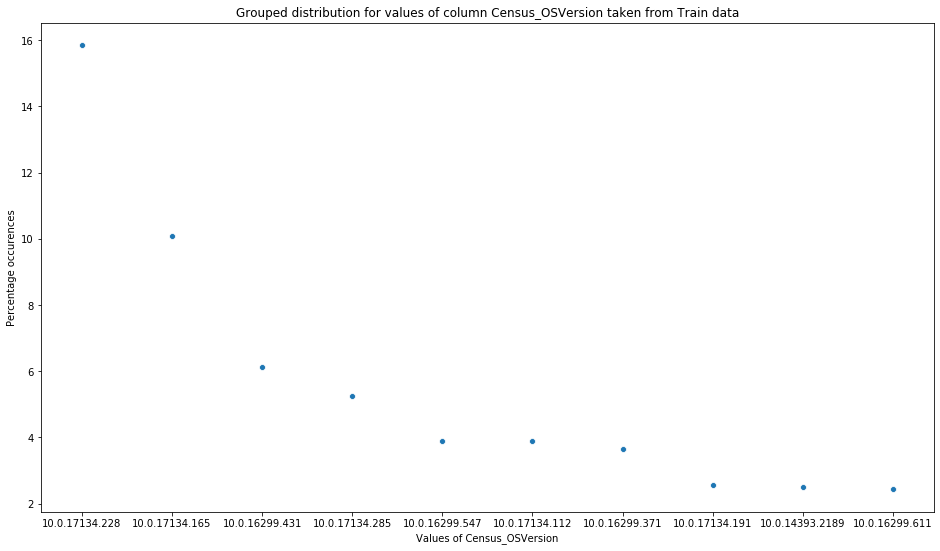

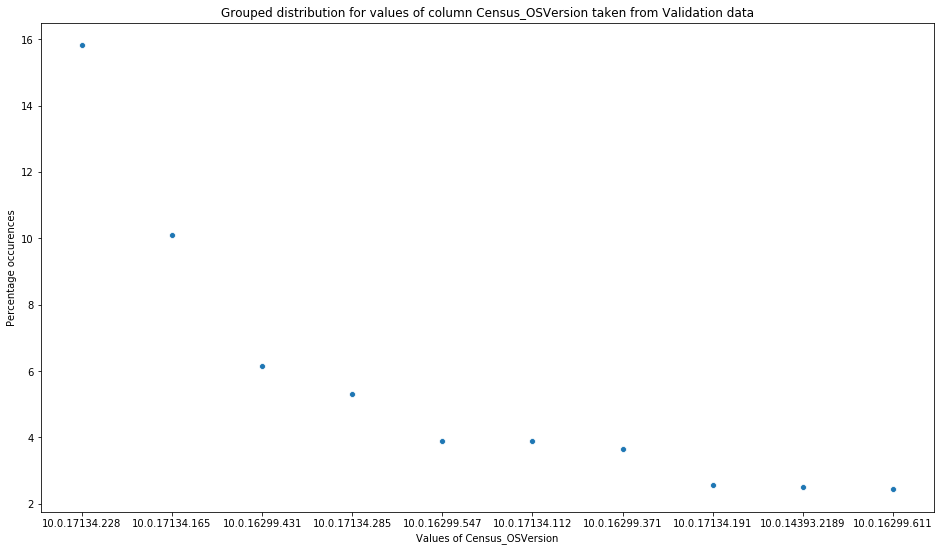

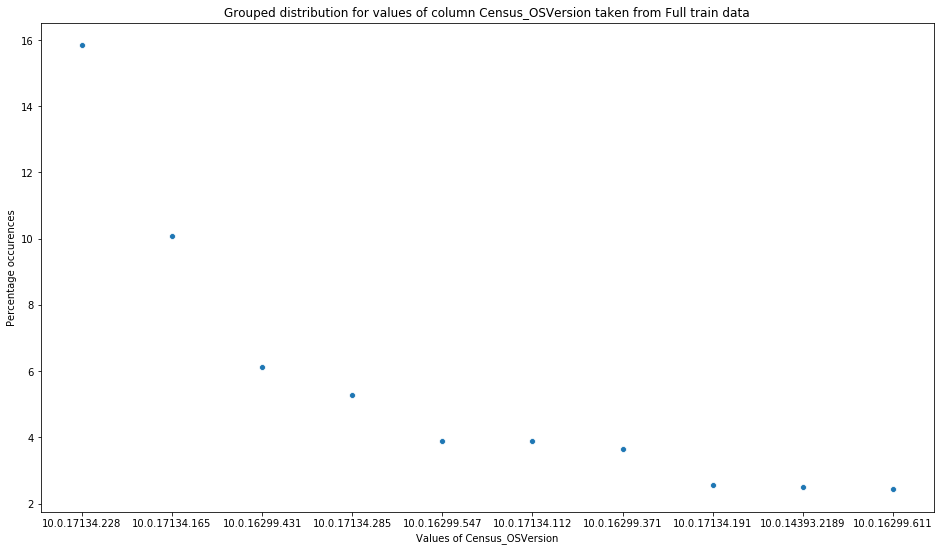

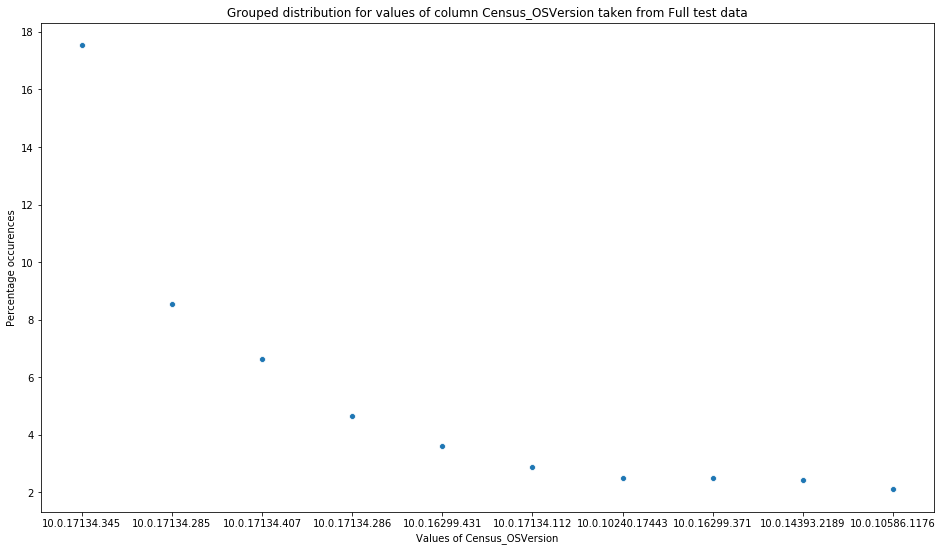

In [351]:
REL_COL = 'Census_OSVersion'
handle_categorical_data(train_train_new, validation_train_new, train, test, REL_COL)

There looks to be some difference in values here. Let us keep that in mind.

###### Data description for Census_OSArchitecture in Train data ########
 count     7137186
unique          3
top         amd64
freq      6484380
Name: Census_OSArchitecture, dtype: object 

Percentage of NA values is  0.0 

###### Data description for Census_OSArchitecture in Validation data ########
 count     1784297
unique          3
top         amd64
freq      1621505
Name: Census_OSArchitecture, dtype: object 

Percentage of NA values is  0.0 

###### Data description for Census_OSArchitecture in Full train data ########
 count     8921483
unique          3
top         amd64
freq      8105885
Name: Census_OSArchitecture, dtype: object 

Percentage of NA values is  0.0 

###### Data description for Census_OSArchitecture in Full test data ########
 count     7853253
unique          3
top         amd64
freq      7174667
Name: Census_OSArchitecture, dtype: object 

Percentage of NA values is  0.0 



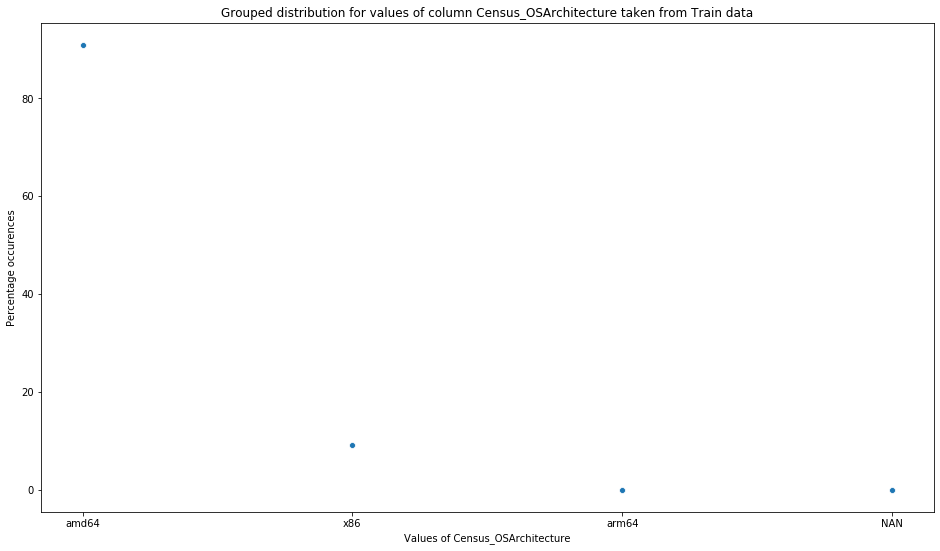

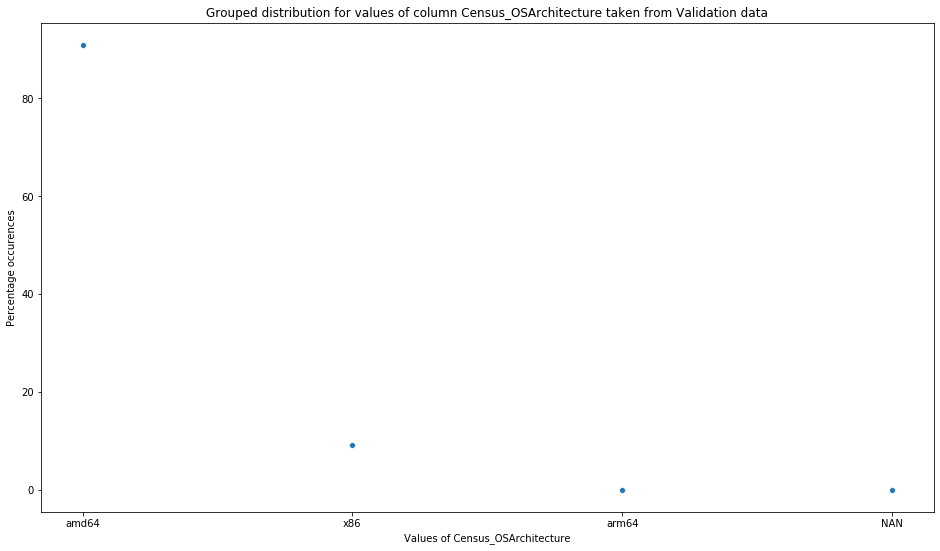

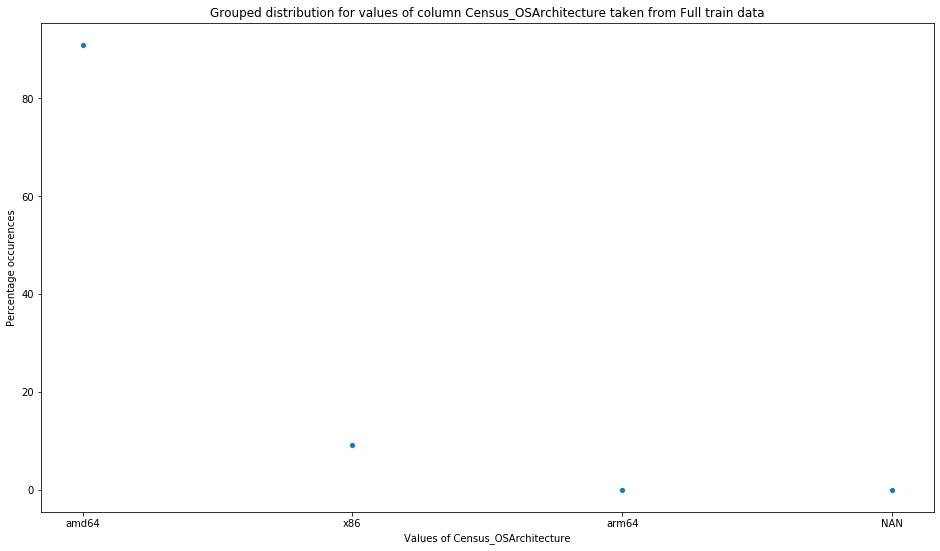

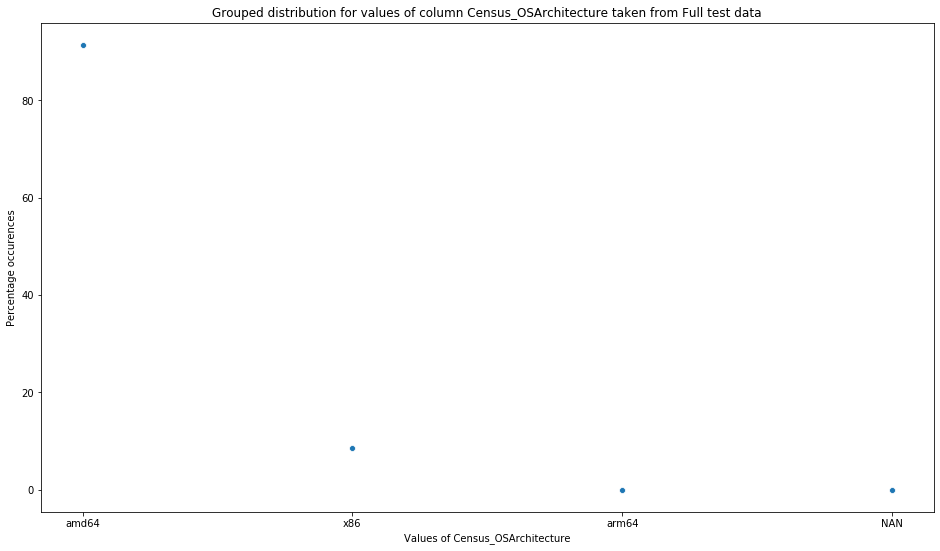

In [352]:
REL_COL = 'Census_OSArchitecture'
handle_categorical_data(train_train_new, validation_train_new, train, test, REL_COL)

###### Data description for Census_OSBranch in Train data ########
 count         7137186
unique             31
top       rs4_release
freq          3206703
Name: Census_OSBranch, dtype: object 

Percentage of NA values is  0.0 

###### Data description for Census_OSBranch in Validation data ########
 count         1784297
unique             20
top       rs4_release
freq           802455
Name: Census_OSBranch, dtype: object 

Percentage of NA values is  0.0 

###### Data description for Census_OSBranch in Full train data ########
 count         8921483
unique             32
top       rs4_release
freq          4009158
Name: Census_OSBranch, dtype: object 

Percentage of NA values is  0.0 

###### Data description for Census_OSBranch in Full test data ########
 count         7853253
unique             29
top       rs4_release
freq          3979144
Name: Census_OSBranch, dtype: object 

Percentage of NA values is  0.0 



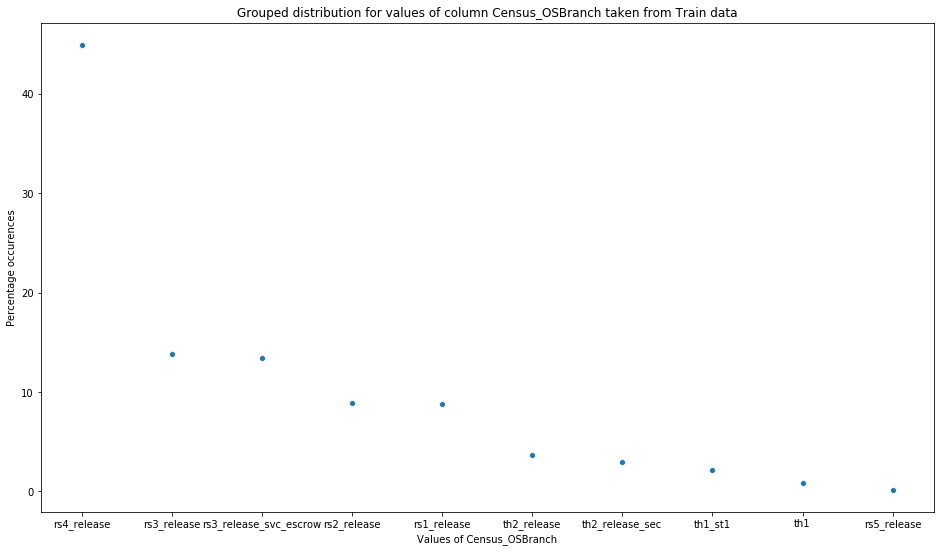

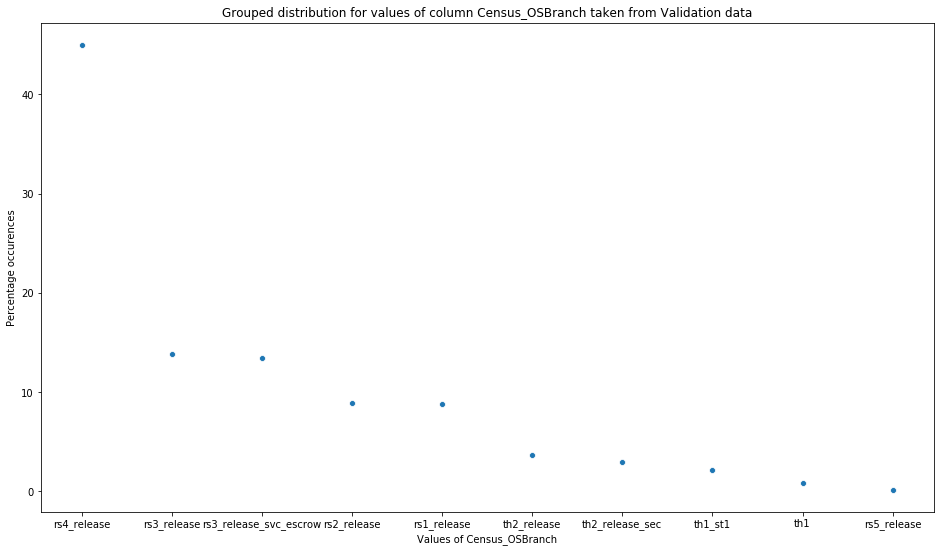

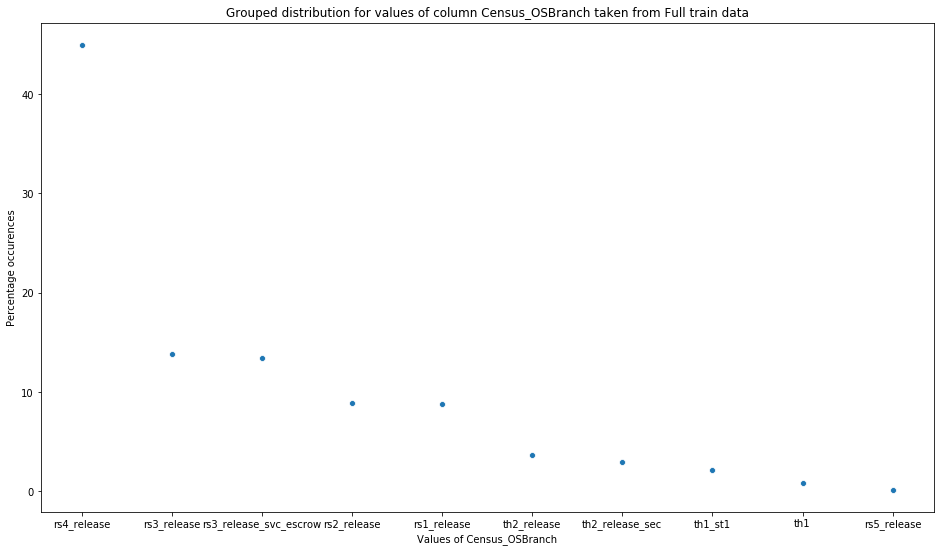

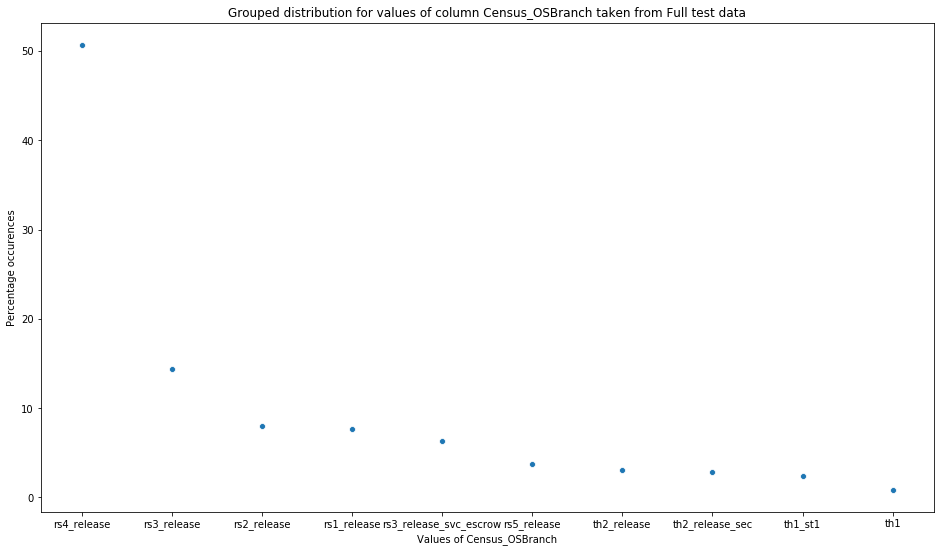

In [353]:
REL_COL = 'Census_OSBranch'
handle_categorical_data(train_train_new, validation_train_new, train, test, REL_COL)

###### Data description for Census_OSEdition in Train data ########
 count     7137186
unique         31
top          Core
freq      2776080
Name: Census_OSEdition, dtype: object 

Percentage of NA values is  0.0 

###### Data description for Census_OSEdition in Validation data ########
 count     1784297
unique         28
top          Core
freq       693911
Name: Census_OSEdition, dtype: object 

Percentage of NA values is  0.0 

###### Data description for Census_OSEdition in Full train data ########
 count     8921483
unique         33
top          Core
freq      3469991
Name: Census_OSEdition, dtype: object 

Percentage of NA values is  0.0 

###### Data description for Census_OSEdition in Full test data ########
 count          7853248
unique              36
top       Professional
freq           3101956
Name: Census_OSEdition, dtype: object 

Percentage of NA values is  6.366788386927048e-05 



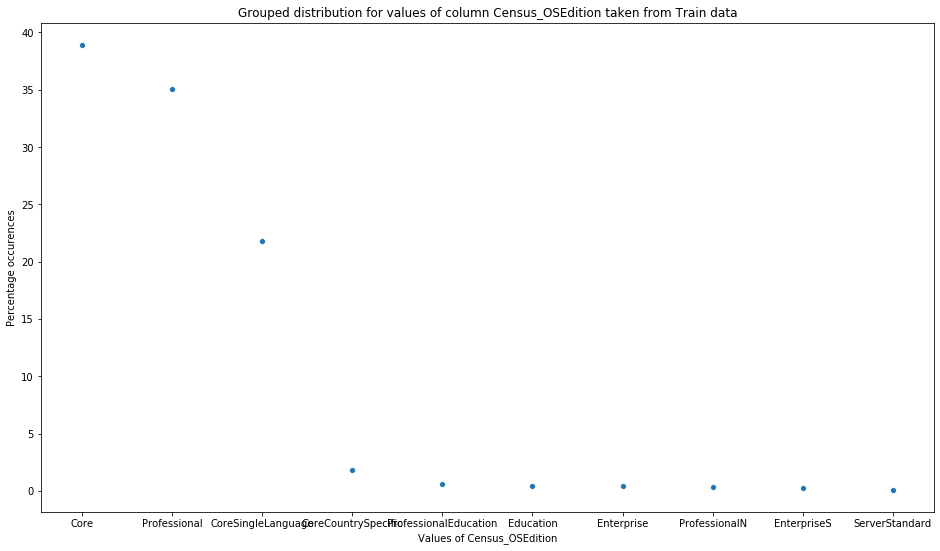

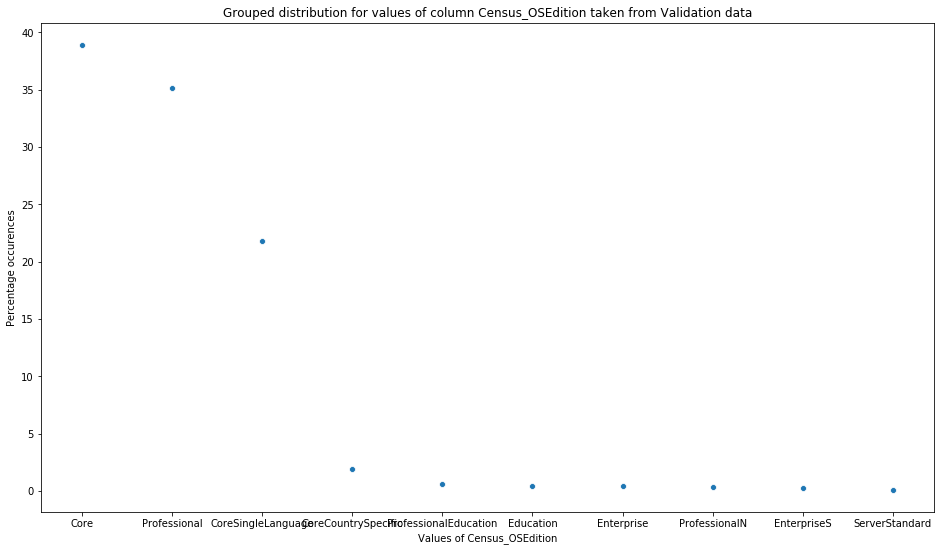

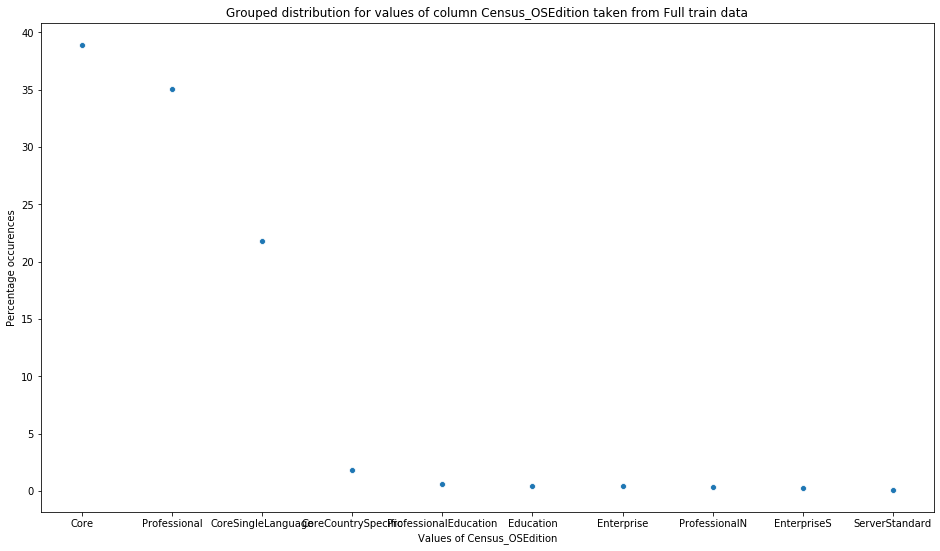

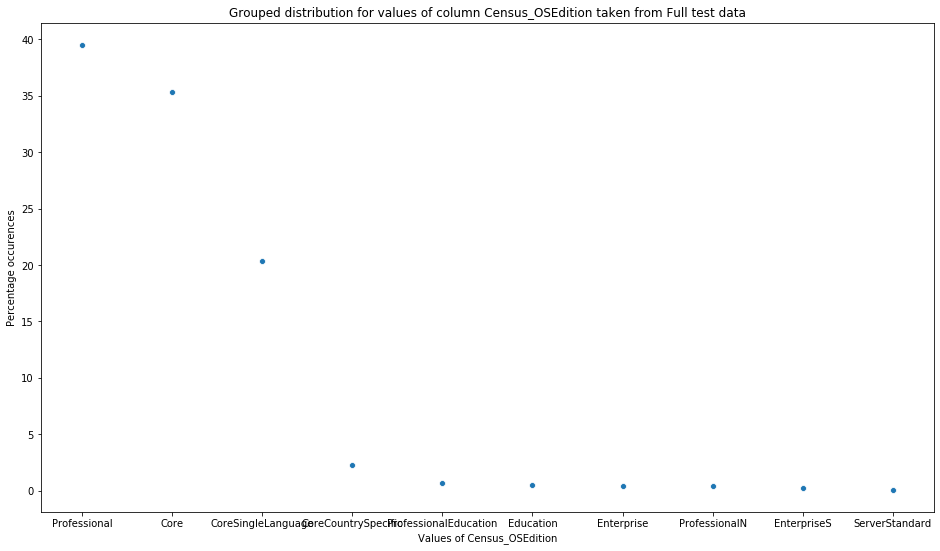

In [354]:
REL_COL = 'Census_OSEdition'
handle_categorical_data(train_train_new, validation_train_new, train, test, REL_COL)

Comment :

The top values look to be different between the validation and test sets. Let us dig in further.

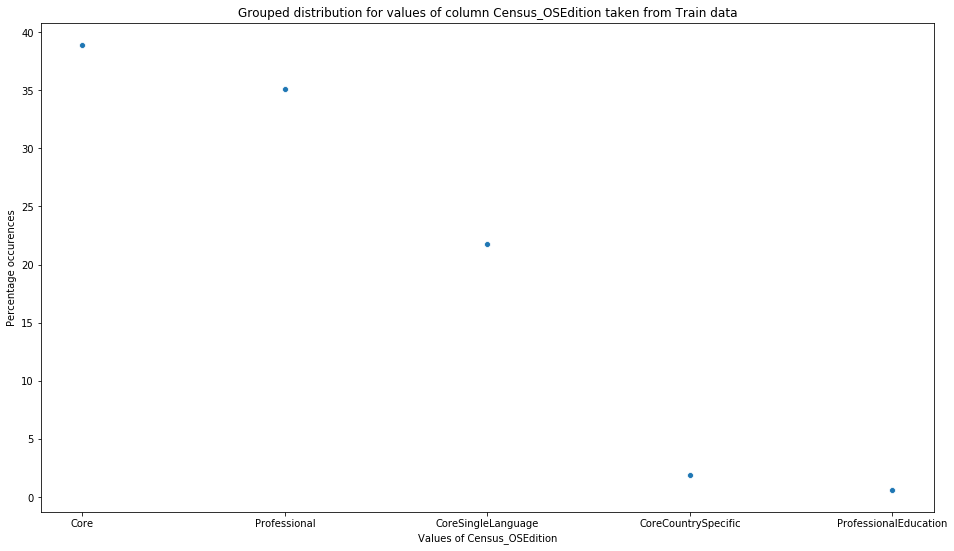

In [355]:
basic_stats_and_plot(train, REL_COL, title='Train data', num_entries=5)

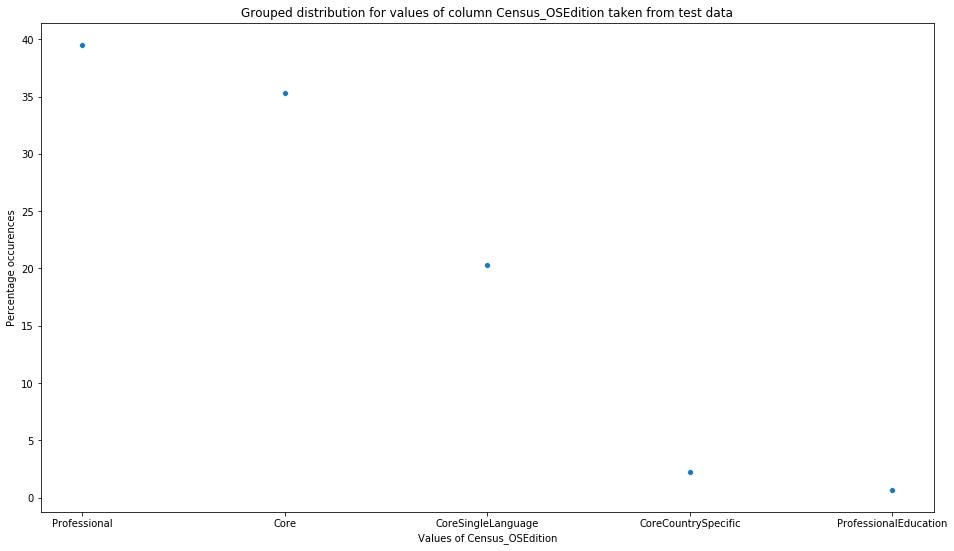

In [356]:
basic_stats_and_plot(test, REL_COL, title='test data', num_entries=5)

Comment :

The top two values have swapped in the test set, but since their percentages were close to each other, these should be fine. 

###### Data description for Census_OSSkuName in Train data ########
 count     7137186
unique         29
top          CORE
freq      2775982
Name: Census_OSSkuName, dtype: object 

Percentage of NA values is  0.0 

###### Data description for Census_OSSkuName in Validation data ########
 count     1784297
unique         26
top          CORE
freq       693887
Name: Census_OSSkuName, dtype: object 

Percentage of NA values is  0.0 

###### Data description for Census_OSSkuName in Full train data ########
 count     8921483
unique         30
top          CORE
freq      3469869
Name: Census_OSSkuName, dtype: object 

Percentage of NA values is  0.0 

###### Data description for Census_OSSkuName in Full test data ########
 count          7853253
unique              31
top       PROFESSIONAL
freq           3157300
Name: Census_OSSkuName, dtype: object 

Percentage of NA values is  0.0 



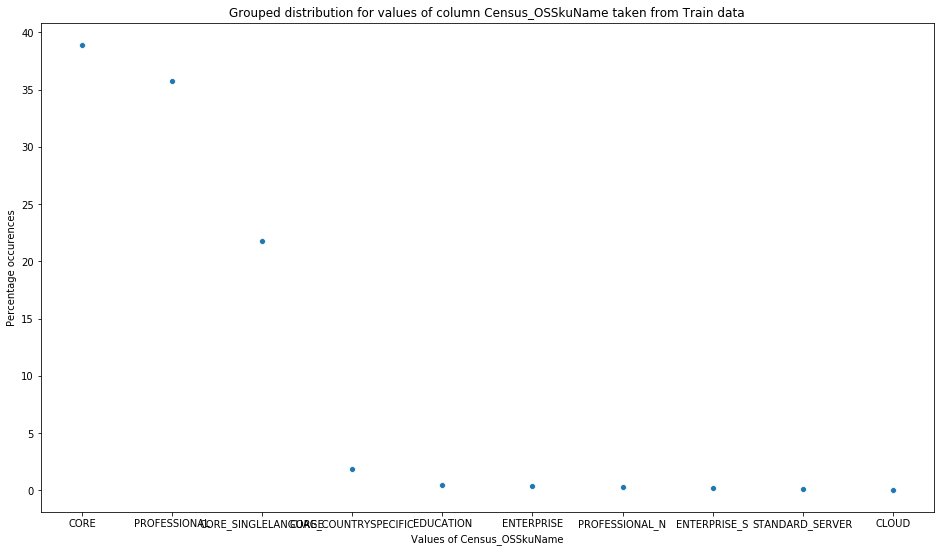

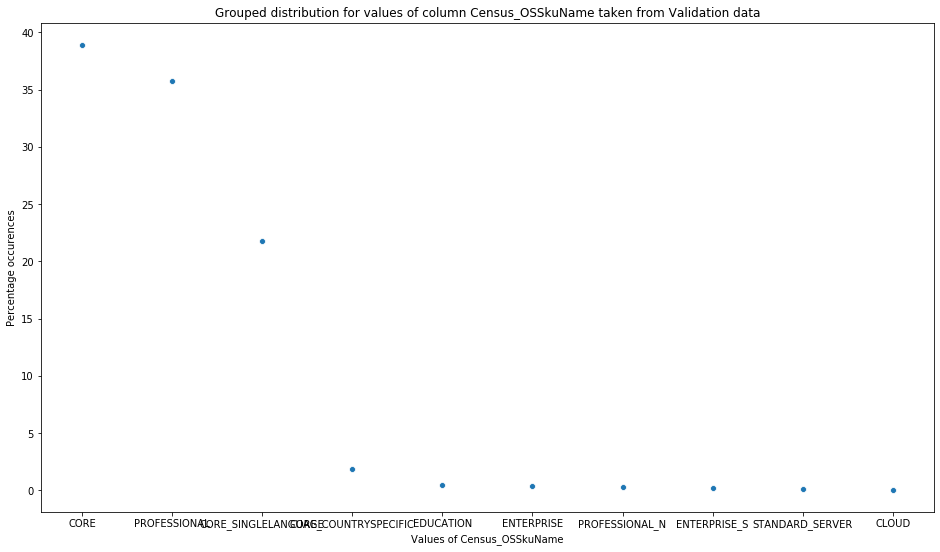

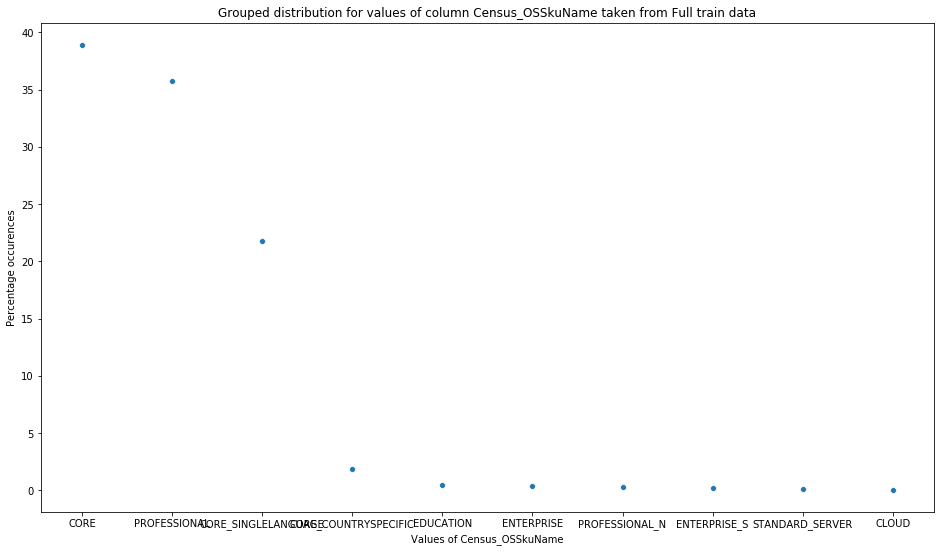

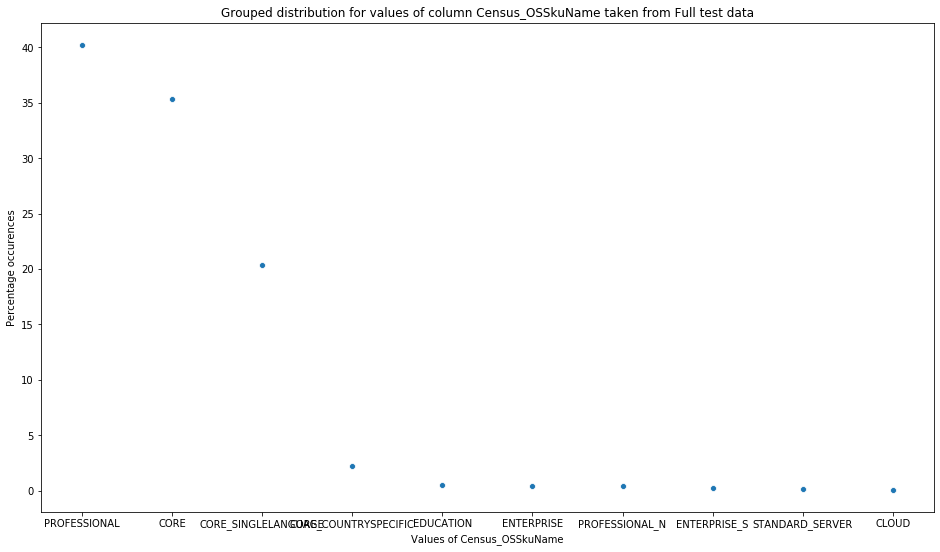

In [357]:
REL_COL = 'Census_OSSkuName'
handle_categorical_data(train_train_new, validation_train_new,  train, test, REL_COL)

###### Data description for Census_OSInstallTypeName in Train data ########
 count        7137186
unique             9
top       UUPUpgrade
freq         2086177
Name: Census_OSInstallTypeName, dtype: object 

Percentage of NA values is  0.0 

###### Data description for Census_OSInstallTypeName in Validation data ########
 count        1784297
unique             9
top       UUPUpgrade
freq          521860
Name: Census_OSInstallTypeName, dtype: object 

Percentage of NA values is  0.0 

###### Data description for Census_OSInstallTypeName in Full train data ########
 count        8921483
unique             9
top       UUPUpgrade
freq         2608037
Name: Census_OSInstallTypeName, dtype: object 

Percentage of NA values is  0.0 

###### Data description for Census_OSInstallTypeName in Full test data ########
 count      7853253
unique           9
top       IBSClean
freq       2110259
Name: Census_OSInstallTypeName, dtype: object 

Percentage of NA values is  0.0 



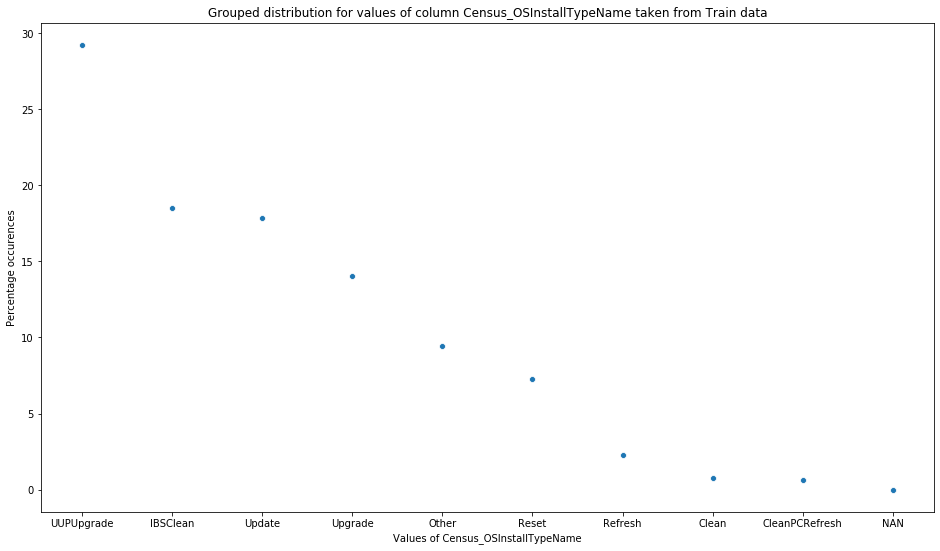

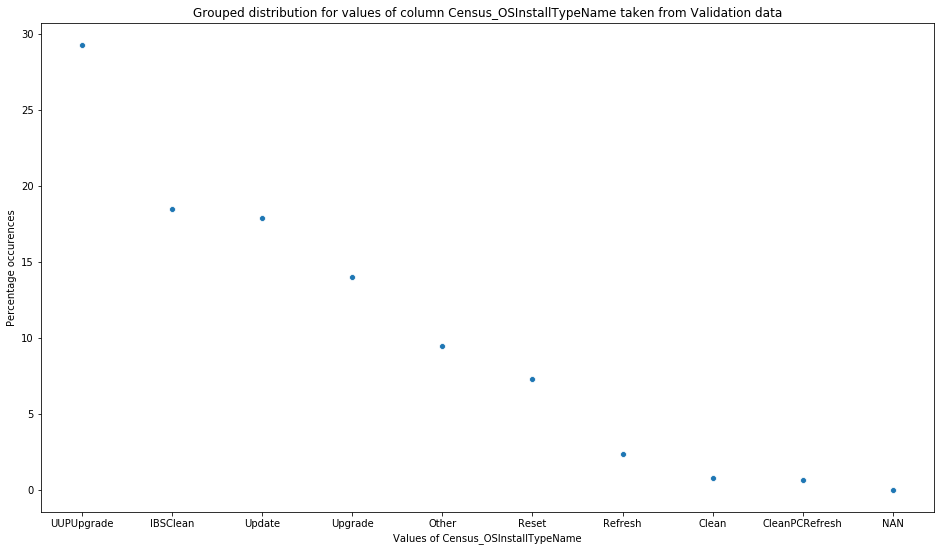

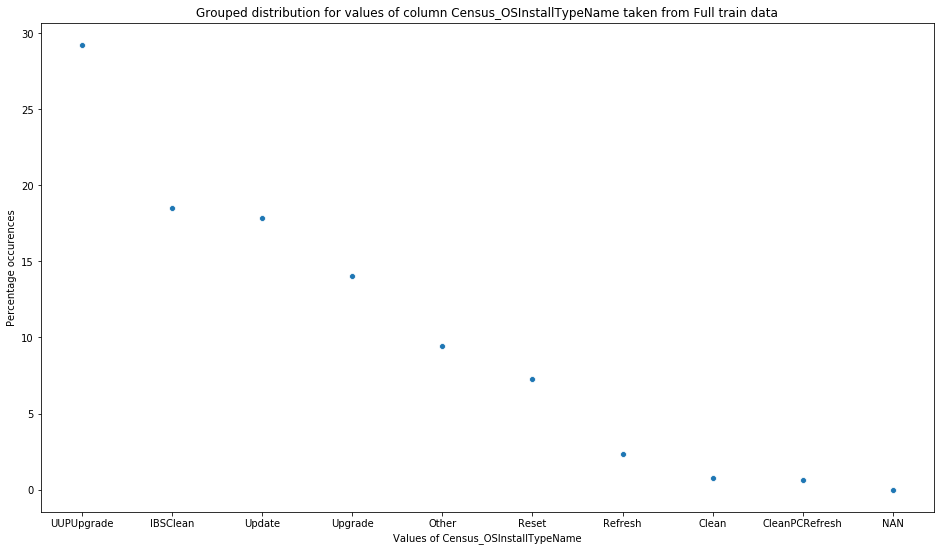

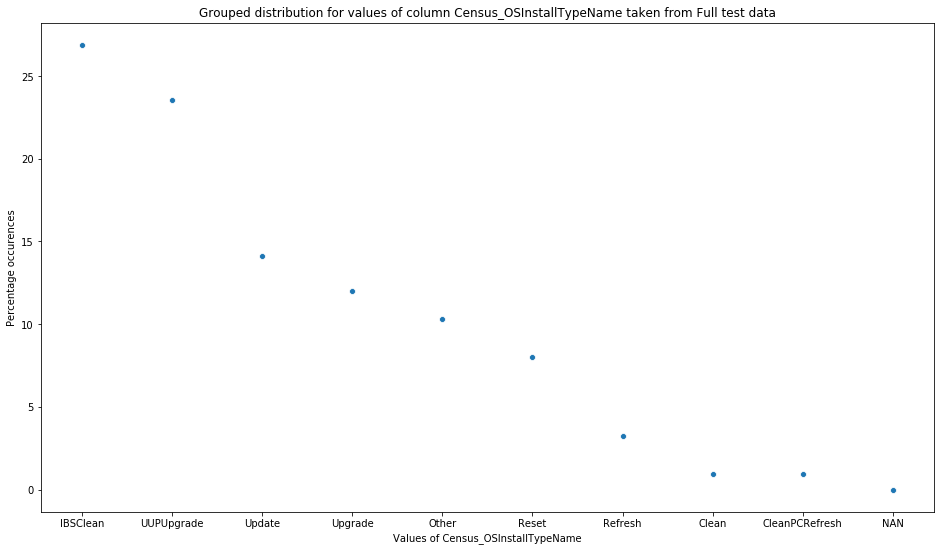

In [358]:
REL_COL = 'Census_OSInstallTypeName'
handle_categorical_data(train_train_new, validation_train_new,  train, test, REL_COL)

Comments :

Similar story regarding the swapping of first 2 colummns, but since they are close to each other, we pass on.

###### Data description for Census_OSWUAutoUpdateOptionsName in Train data ########
 count      7137186
unique           6
top       FullAuto
freq       3162945
Name: Census_OSWUAutoUpdateOptionsName, dtype: object 

Percentage of NA values is  0.0 

###### Data description for Census_OSWUAutoUpdateOptionsName in Validation data ########
 count      1784297
unique           6
top       FullAuto
freq        791552
Name: Census_OSWUAutoUpdateOptionsName, dtype: object 

Percentage of NA values is  0.0 

###### Data description for Census_OSWUAutoUpdateOptionsName in Full train data ########
 count      8921483
unique           6
top       FullAuto
freq       3954497
Name: Census_OSWUAutoUpdateOptionsName, dtype: object 

Percentage of NA values is  0.0 

###### Data description for Census_OSWUAutoUpdateOptionsName in Full test data ########
 count      7853253
unique           6
top       FullAuto
freq       4113612
Name: Census_OSWUAutoUpdateOptionsName, dtype: object 

Percentage of NA

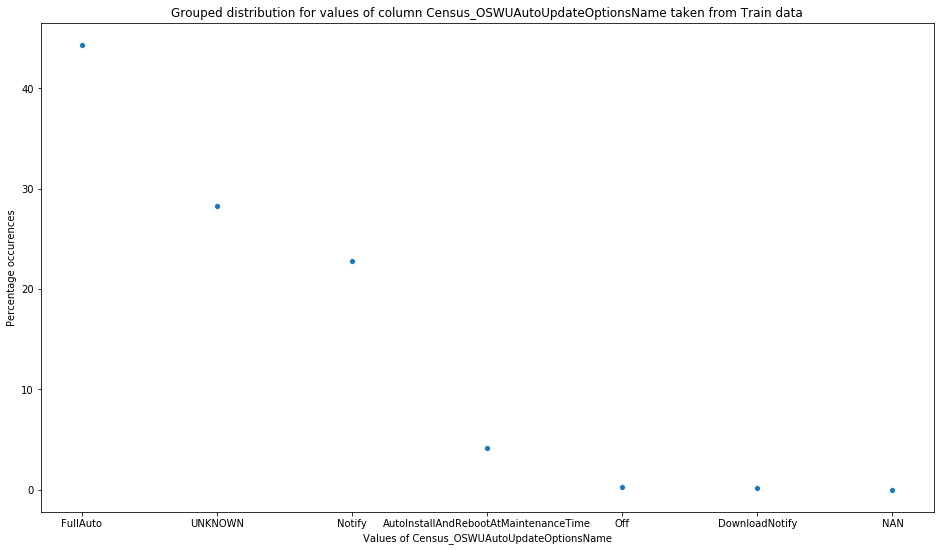

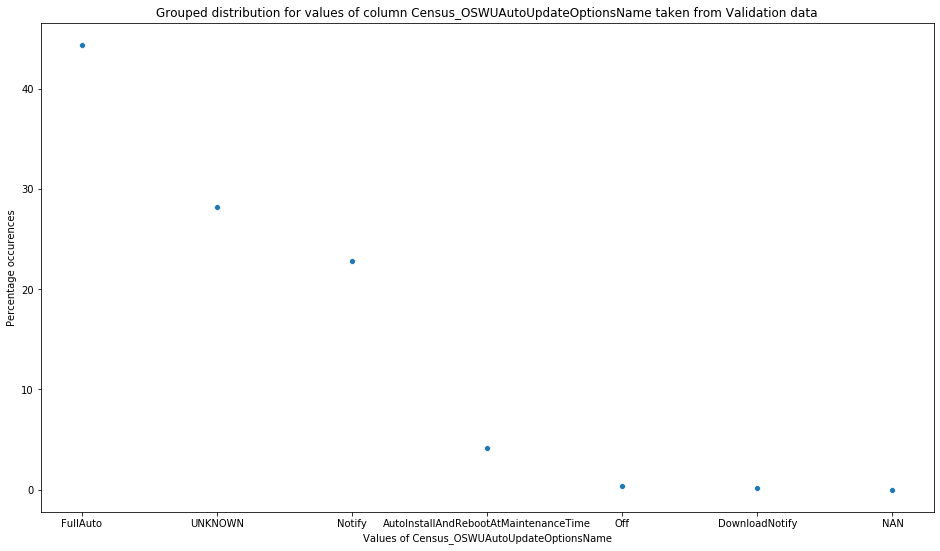

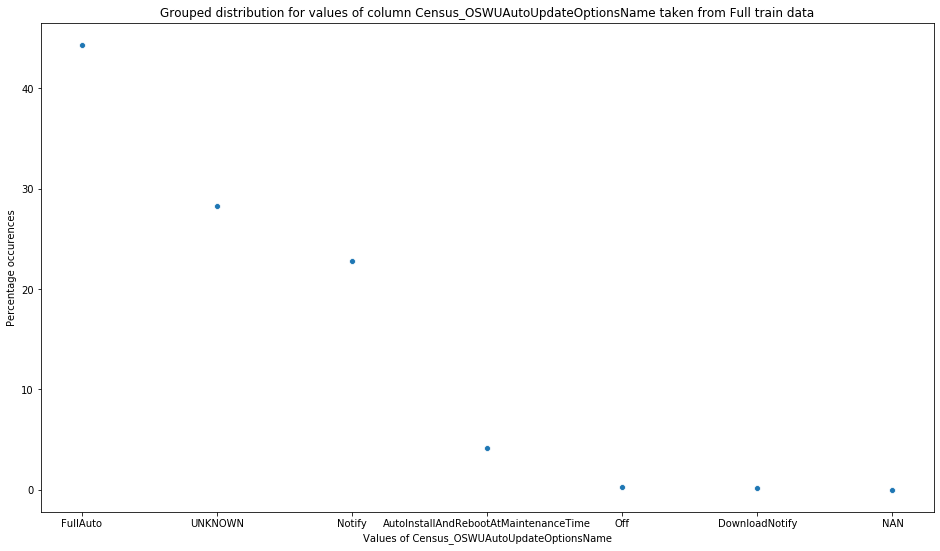

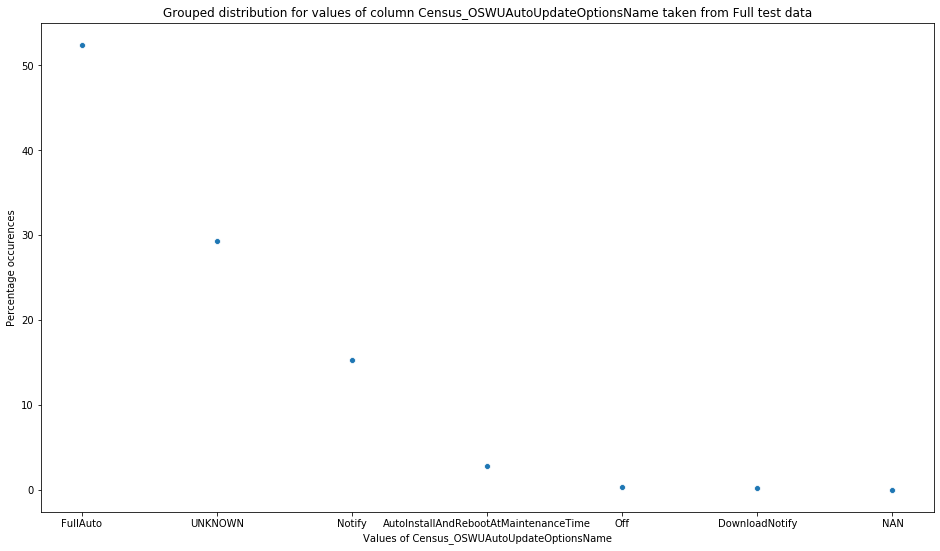

In [359]:
REL_COL = 'Census_OSWUAutoUpdateOptionsName'
handle_categorical_data(train_train_new, validation_train_new,  train, test, REL_COL)

###### Data description for Census_GenuineStateName in Train data ########
 count        7137186
unique             5
top       IS_GENUINE
freq         6302531
Name: Census_GenuineStateName, dtype: object 

Percentage of NA values is  0.0 

###### Data description for Census_GenuineStateName in Validation data ########
 count        1784297
unique             4
top       IS_GENUINE
freq         1575066
Name: Census_GenuineStateName, dtype: object 

Percentage of NA values is  0.0 

###### Data description for Census_GenuineStateName in Full train data ########
 count        8921483
unique             5
top       IS_GENUINE
freq         7877597
Name: Census_GenuineStateName, dtype: object 

Percentage of NA values is  0.0 

###### Data description for Census_GenuineStateName in Full test data ########
 count        7853252
unique             5
top       IS_GENUINE
freq         6729893
Name: Census_GenuineStateName, dtype: object 

Percentage of NA values is  1.2733576773854095e-05 



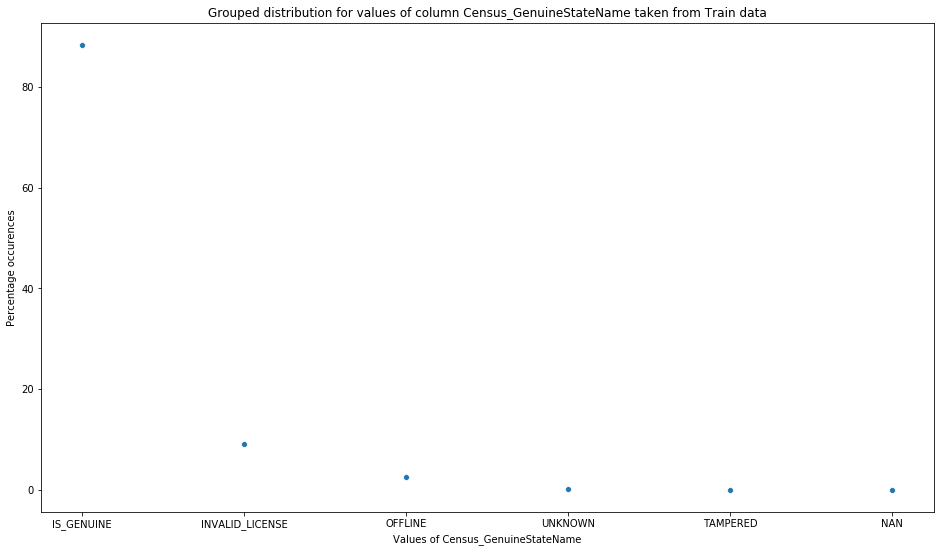

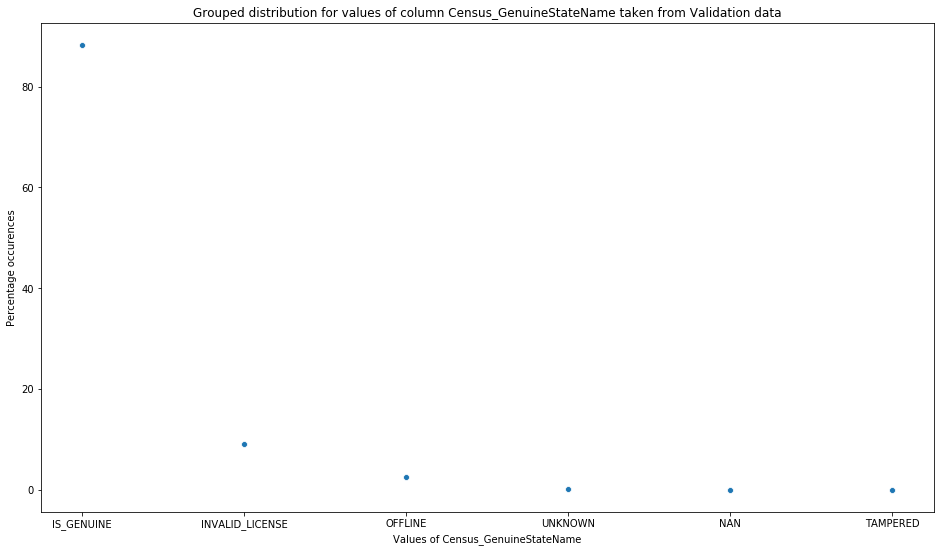

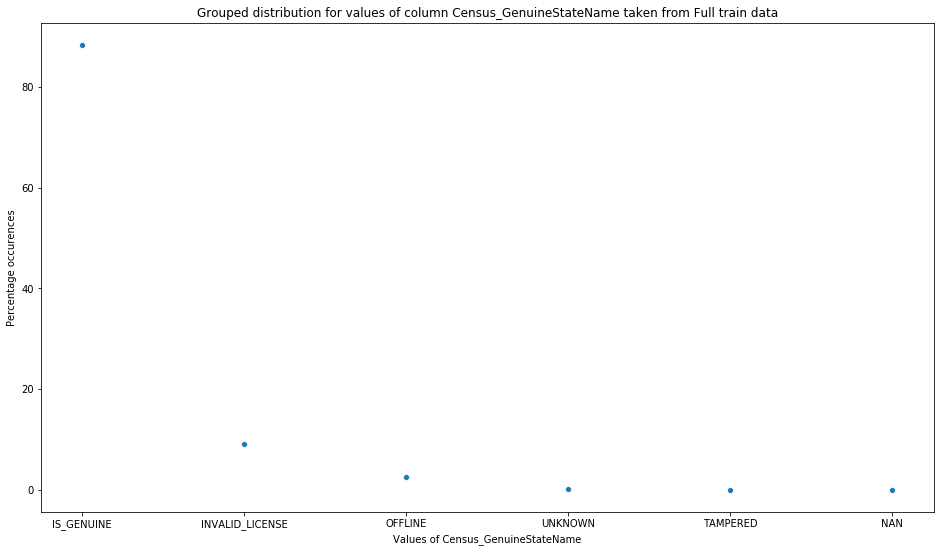

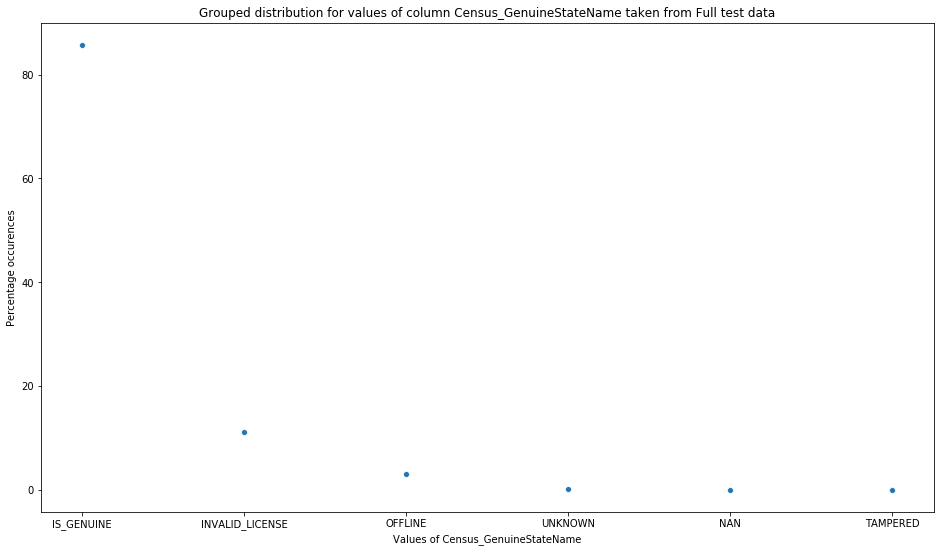

In [360]:
REL_COL = 'Census_GenuineStateName'
handle_categorical_data(train_train_new, validation_train_new,  train, test, REL_COL)

###### Data description for Census_ActivationChannel in Train data ########
 count     7137186
unique          6
top        Retail
freq      3781248
Name: Census_ActivationChannel, dtype: object 

Percentage of NA values is  0.0 

###### Data description for Census_ActivationChannel in Validation data ########
 count     1784297
unique          6
top        Retail
freq       946341
Name: Census_ActivationChannel, dtype: object 

Percentage of NA values is  0.0 

###### Data description for Census_ActivationChannel in Full train data ########
 count     8921483
unique          6
top        Retail
freq      4727589
Name: Census_ActivationChannel, dtype: object 

Percentage of NA values is  0.0 

###### Data description for Census_ActivationChannel in Full test data ########
 count     7853253
unique          6
top        Retail
freq      4051234
Name: Census_ActivationChannel, dtype: object 

Percentage of NA values is  0.0 



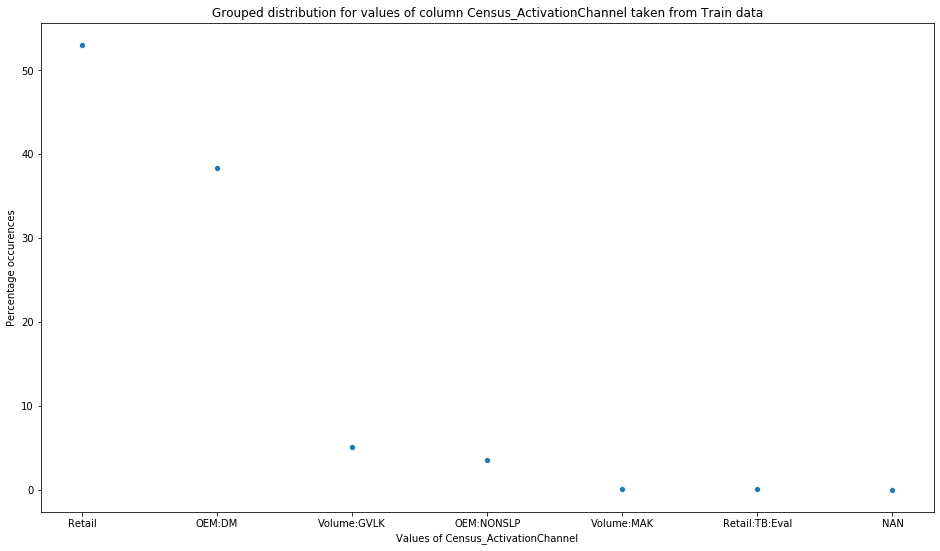

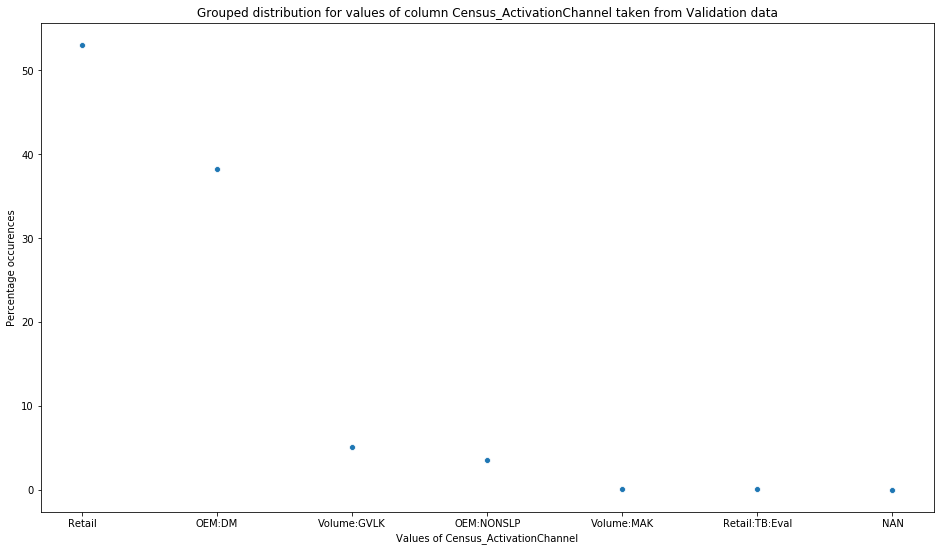

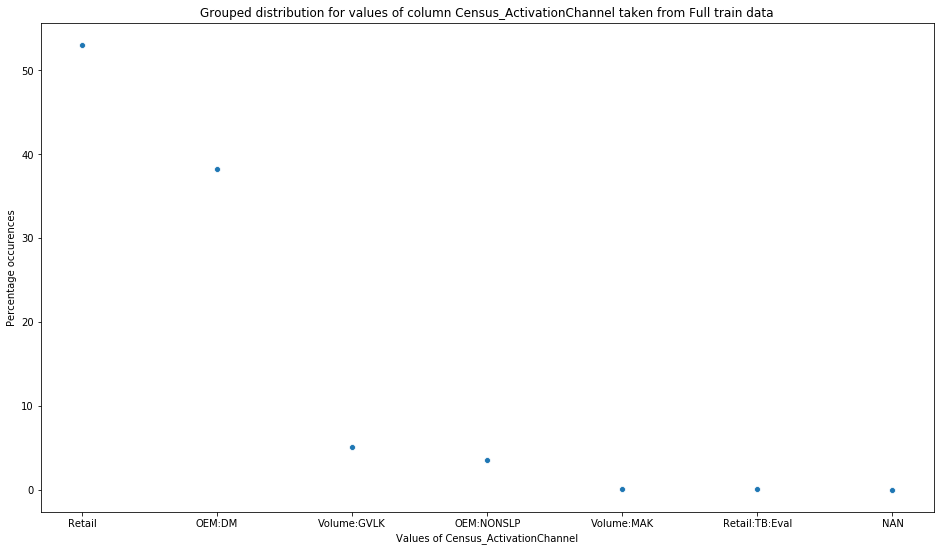

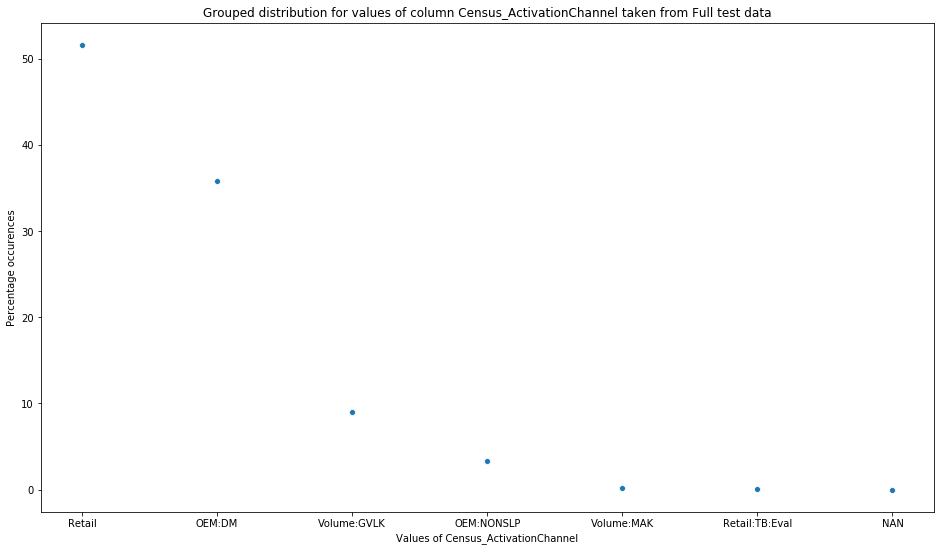

In [361]:
REL_COL = 'Census_ActivationChannel'
handle_categorical_data(train_train_new, validation_train_new, train, test, REL_COL)

###### Data description for Census_FlightRing in Train data ########
 count     7137186
unique         10
top        Retail
freq      6684395
Name: Census_FlightRing, dtype: object 

Percentage of NA values is  0.0 

###### Data description for Census_FlightRing in Validation data ########
 count     1784297
unique          8
top        Retail
freq      1671284
Name: Census_FlightRing, dtype: object 

Percentage of NA values is  0.0 

###### Data description for Census_FlightRing in Full train data ########
 count     8921483
unique         10
top        Retail
freq      8355679
Name: Census_FlightRing, dtype: object 

Percentage of NA values is  0.0 

###### Data description for Census_FlightRing in Full test data ########
 count     7853253
unique         11
top        Retail
freq      7340769
Name: Census_FlightRing, dtype: object 

Percentage of NA values is  0.0 



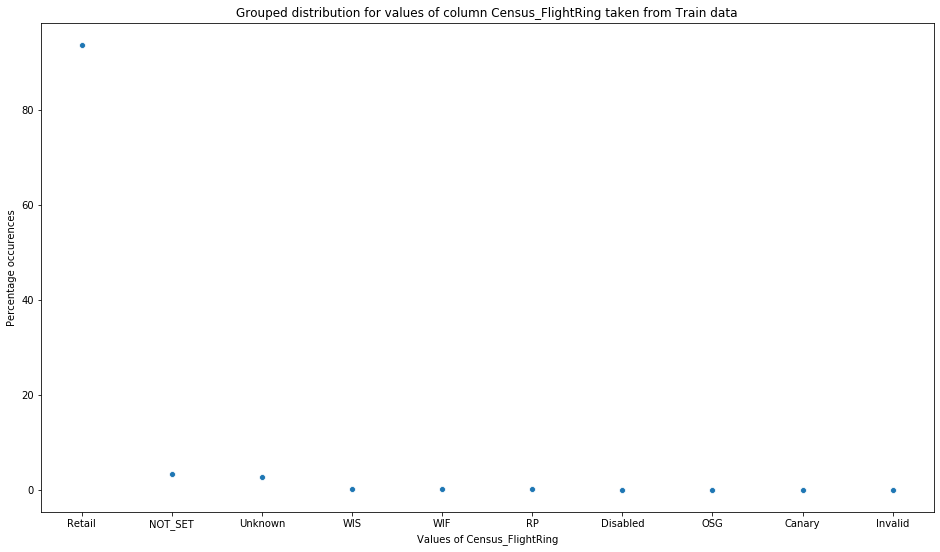

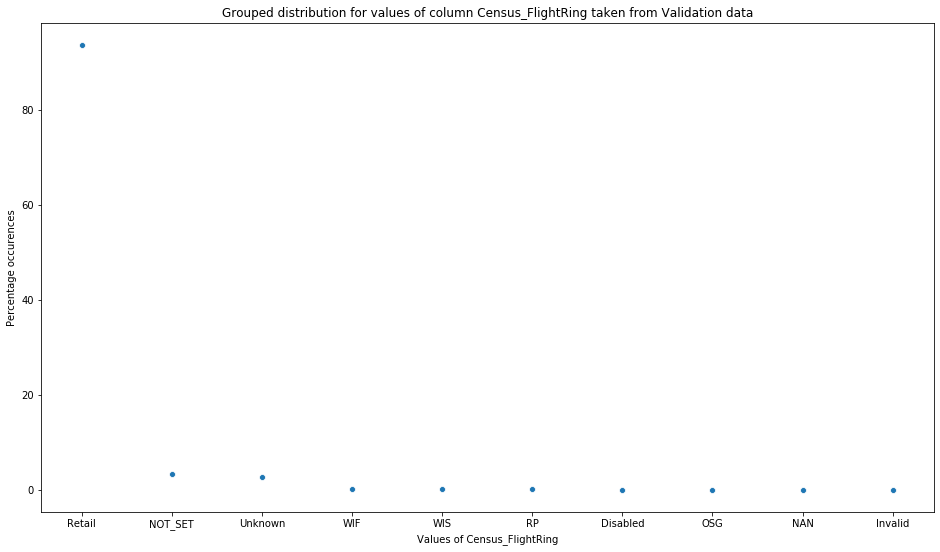

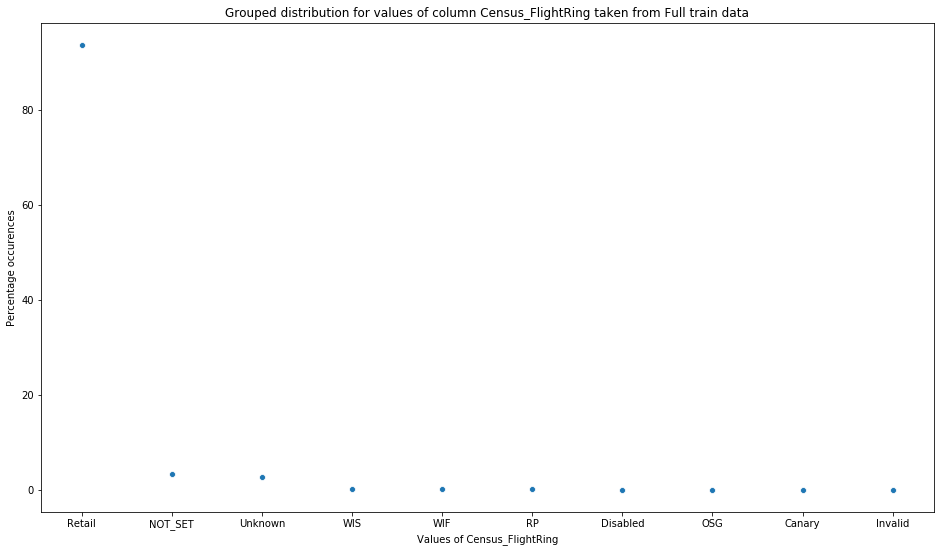

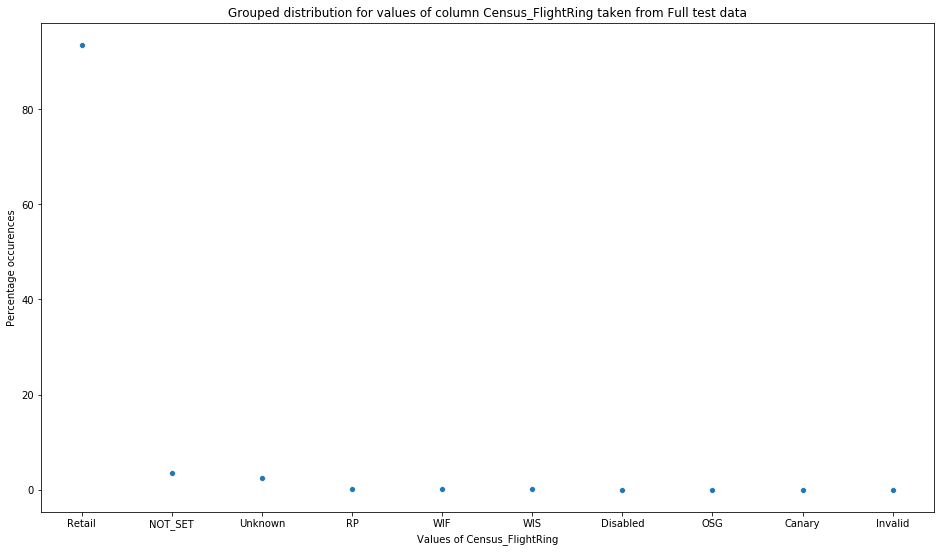

In [362]:
REL_COL = 'Census_FlightRing'
handle_categorical_data(train_train_new, validation_train_new, train, test, REL_COL)

### Handing boolean columns

In this case, we replace missing values with the most frequent value (0 or 1)

In [363]:
boolean_cols

['IsBeta',
 'HasTpm',
 'IsProtected',
 'AutoSampleOptIn',
 'SMode',
 'Firewall',
 'Census_HasOpticalDiskDrive',
 'Census_IsPortableOperatingSystem',
 'Census_IsFlightsDisabled',
 'Census_IsSecureBootEnabled',
 'Census_IsVirtualDevice',
 'Census_IsTouchEnabled',
 'Census_IsPenCapable',
 'Census_IsAlwaysOnAlwaysConnectedCapable',
 'Wdft_IsGamer']

In [364]:
train_train_new.IsBeta.isna().sum()/len(train_train_new)

0.0

In [365]:
train_train_new.HasTpm.isna().sum()/len(train_train_new)

0.0

In [366]:
train_train_new.IsProtected.isna().sum()/len(train_train_new)

0.00402735756080898

In [367]:
def handle_boolean_data(train_data, validation_data, full_train, full_test, col_name):

    print_summary(train_data, col_name, title='Train data')
    
    print_summary(validation_data, col_name, title='Validation data')    
    
    print_summary(full_train, col_name, title='Full train data')        
    
    print_summary(full_test, col_name, title='Full test data')        

    # Replace with a new category named 'NA'
    replace_with_most_frequent_val(train_data, validation_data, col_name)
    replace_with_most_frequent_val(full_train, full_test, col_name)    
    

    # Print basic statistical measurements of the data and plot a grouped representation of the same.
    basic_stats_and_plot(train_data, col_name, 'Train data')
    
    basic_stats_and_plot(validation_data, col_name, 'Validation data')

    basic_stats_and_plot(full_train, col_name, 'Full train data')

    basic_stats_and_plot(full_test, col_name, 'Full test data')
    

###### Data description for IsProtected in Train data ########
 count     7108442
unique          2
top             1
freq      6721975
Name: IsProtected, dtype: object 

Percentage of NA values is  0.402735756080898 

###### Data description for IsProtected in Validation data ########
 count     1776997
unique          2
top             1
freq      1680307
Name: IsProtected, dtype: object 

Percentage of NA values is  0.4091247141030893 

###### Data description for IsProtected in Full train data ########
 count     8885439
unique          2
top             1
freq      8402282
Name: IsProtected, dtype: object 

Percentage of NA values is  0.404013547971789 

###### Data description for IsProtected in Full test data ########
 count     7829604
unique          2
top             1
freq      7396943
Name: IsProtected, dtype: object 

Percentage of NA values is  0.3011363571248755 

Most frequent value is  1
Most frequent value is  1


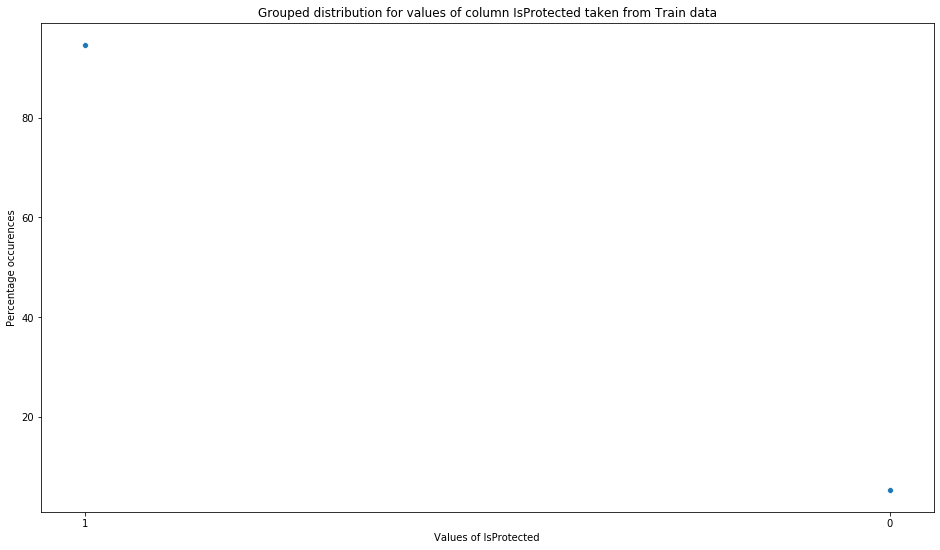

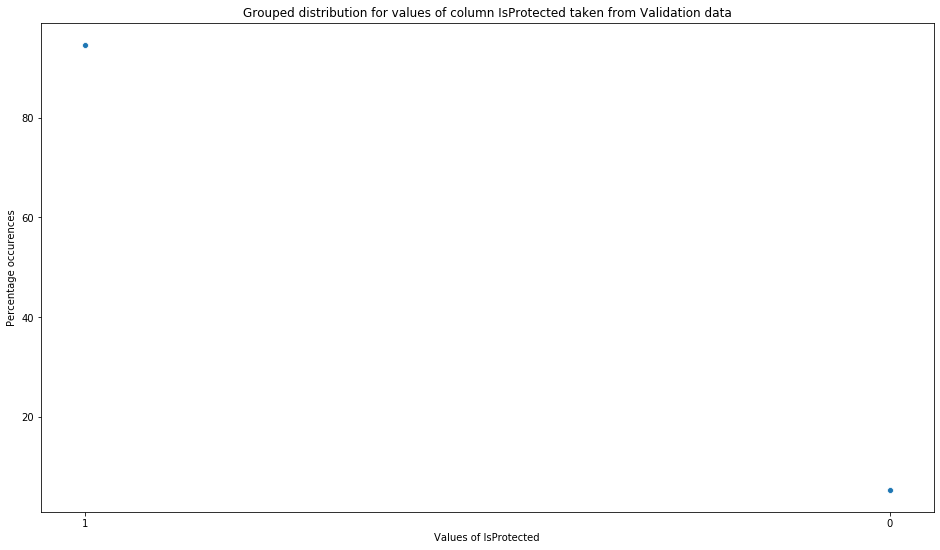

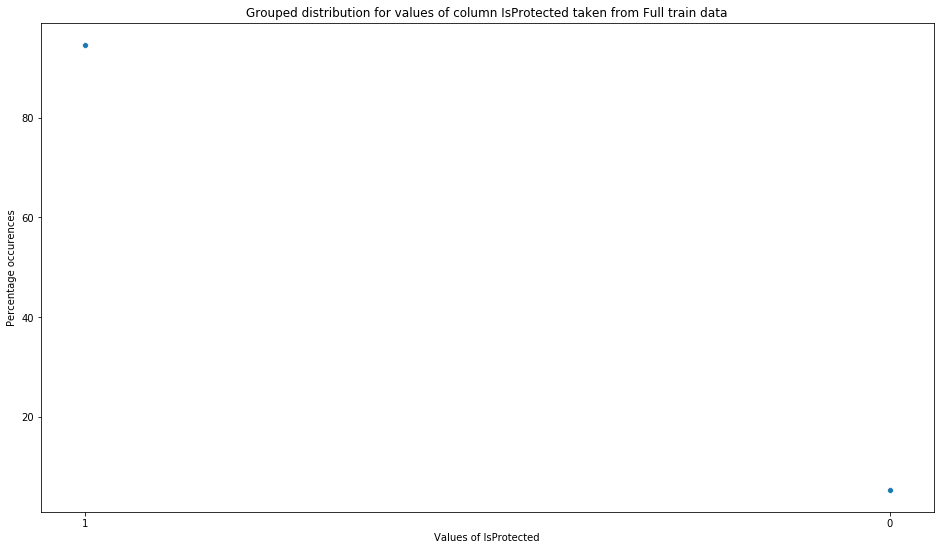

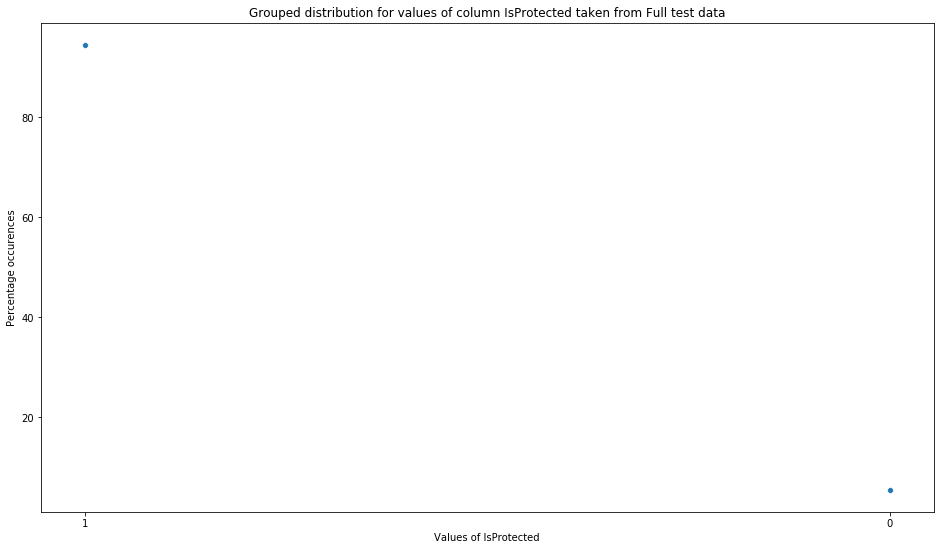

In [368]:
handle_boolean_data(train_train_new, validation_train_new, train, test, 'IsProtected')

In [369]:
train_train_new.AutoSampleOptIn.isna().sum()/len(train_train_new)

0.0

###### Data description for AutoSampleOptIn in Train data ########
 count     7137186
unique          2
top             0
freq      7136983
Name: AutoSampleOptIn, dtype: object 

Percentage of NA values is  0.0 

###### Data description for AutoSampleOptIn in Validation data ########
 count     1784297
unique          2
top             0
freq      1784242
Name: AutoSampleOptIn, dtype: object 

Percentage of NA values is  0.0 

###### Data description for AutoSampleOptIn in Full train data ########
 count     8921483
unique          2
top             0
freq      8921225
Name: AutoSampleOptIn, dtype: object 

Percentage of NA values is  0.0 

###### Data description for AutoSampleOptIn in Full test data ########
 count     7853253
unique          2
top             0
freq      7853091
Name: AutoSampleOptIn, dtype: object 

Percentage of NA values is  0.0 

Most frequent value is  0
Most frequent value is  0


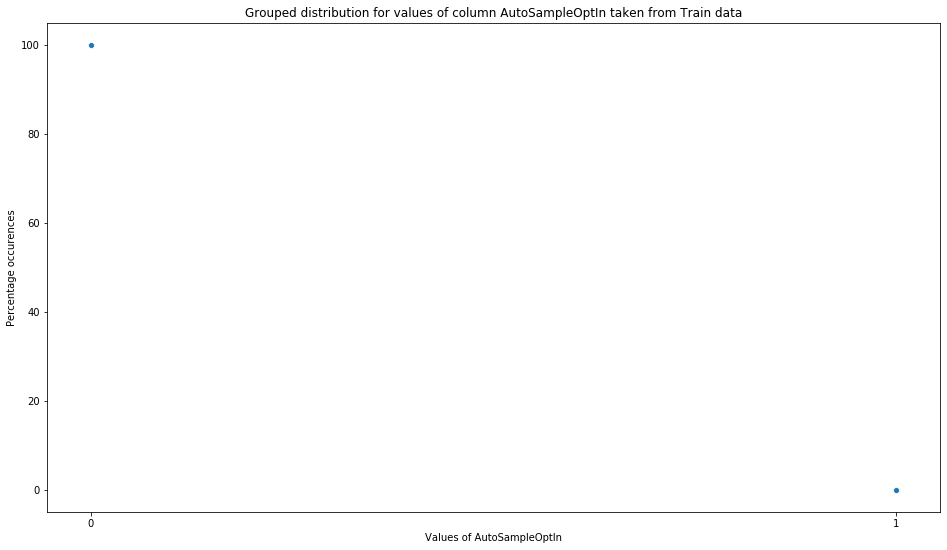

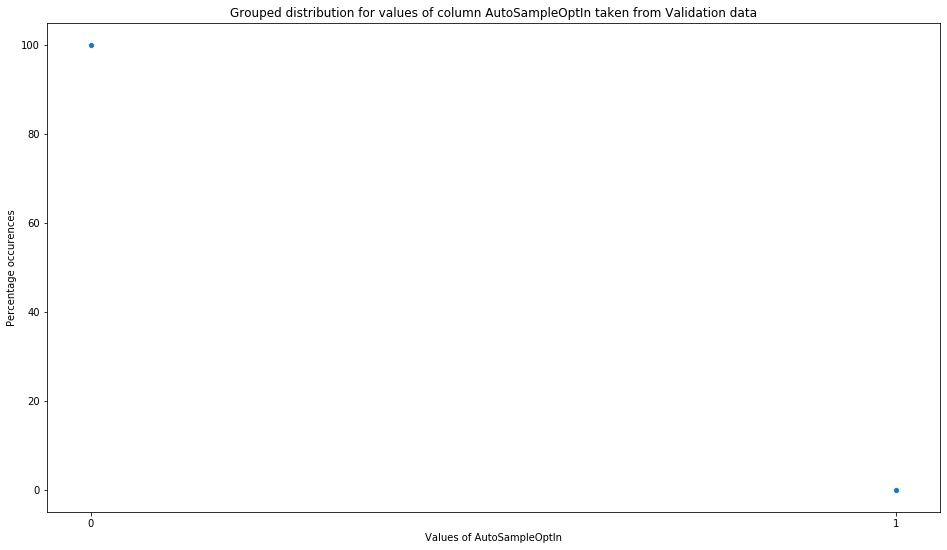

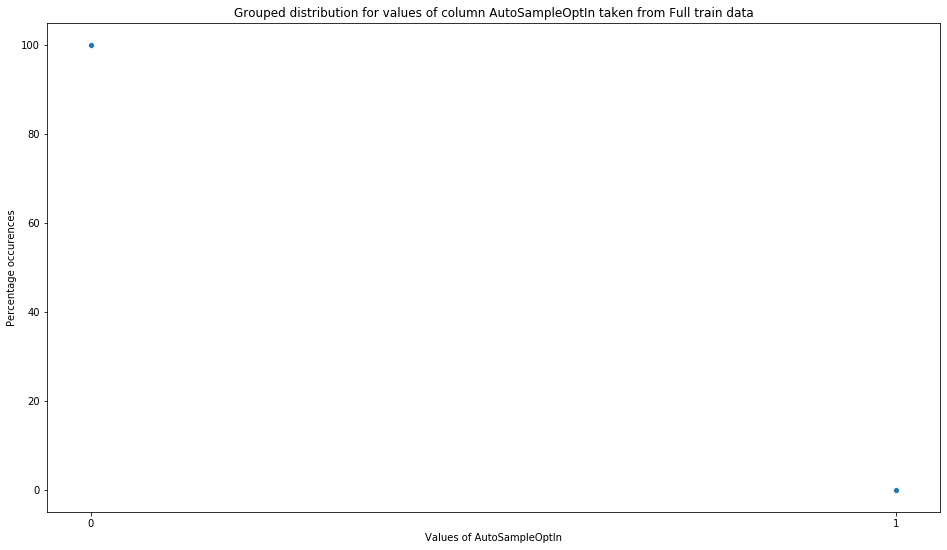

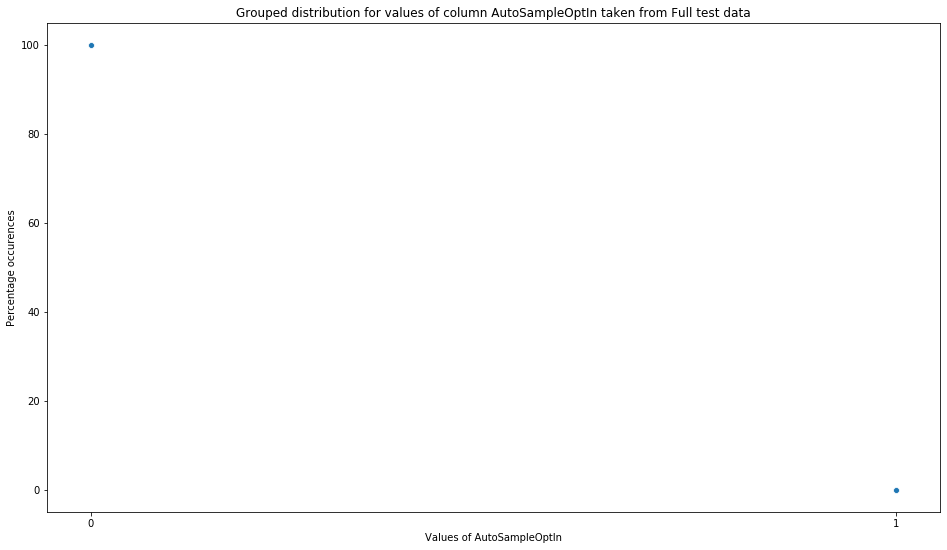

In [370]:
handle_boolean_data(train_train_new, validation_train_new, train, test, 'AutoSampleOptIn')

In [371]:
train_train_new.SMode.isna().sum()/len(train_train_new)

0.06026674938834437

###### Data description for SMode in Train data ########
 count     6707051
unique          2
top             0
freq      6703978
Name: SMode, dtype: object 

Percentage of NA values is  6.026674938834437 

###### Data description for SMode in Validation data ########
 count     1676673
unique          2
top             0
freq      1675865
Name: SMode, dtype: object 

Percentage of NA values is  6.031731264469984 

###### Data description for SMode in Full train data ########
 count     8383724
unique          2
top             0
freq      8379843
Name: SMode, dtype: object 

Percentage of NA values is  6.0276862041882495 

###### Data description for SMode in Full test data ########
 count     2021981
unique          2
top             0
freq      2015562
Name: SMode, dtype: object 

Percentage of NA values is  74.25294970122572 

Most frequent value is  0
Most frequent value is  0


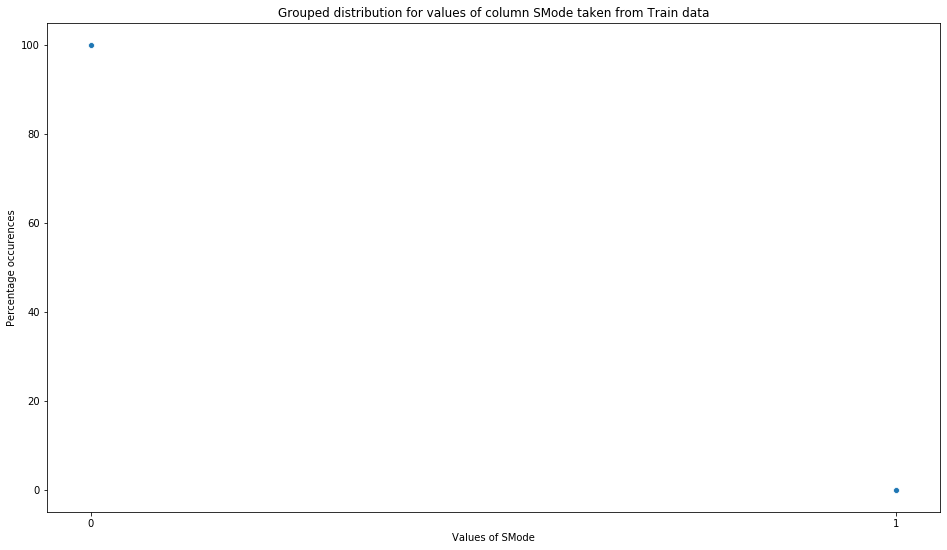

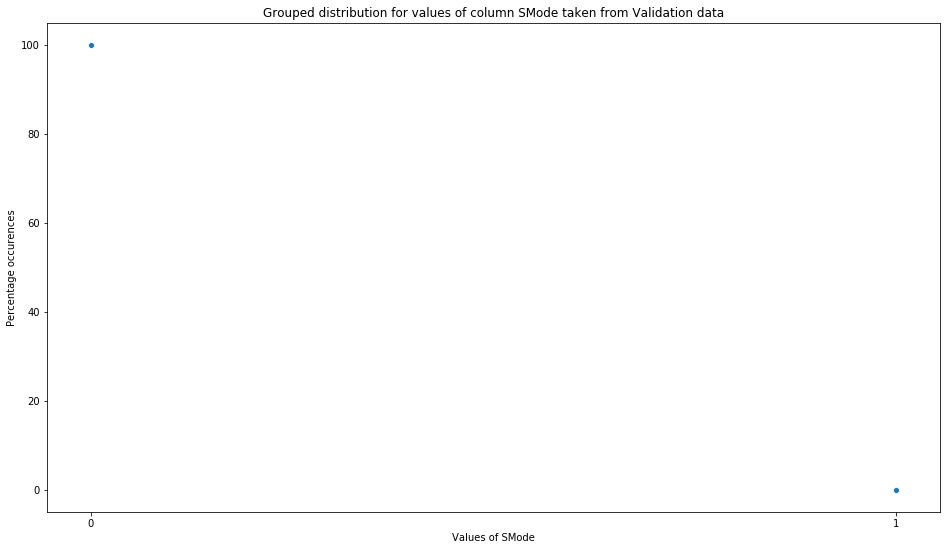

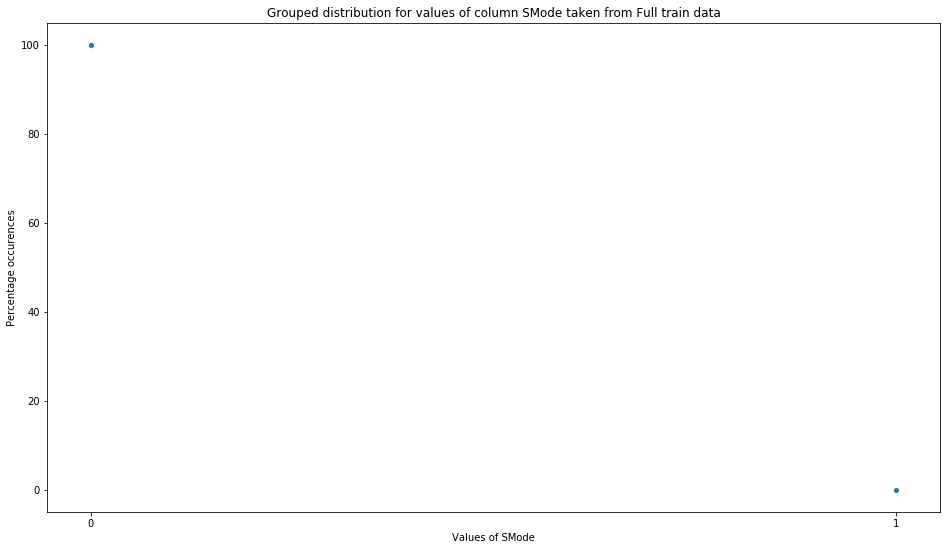

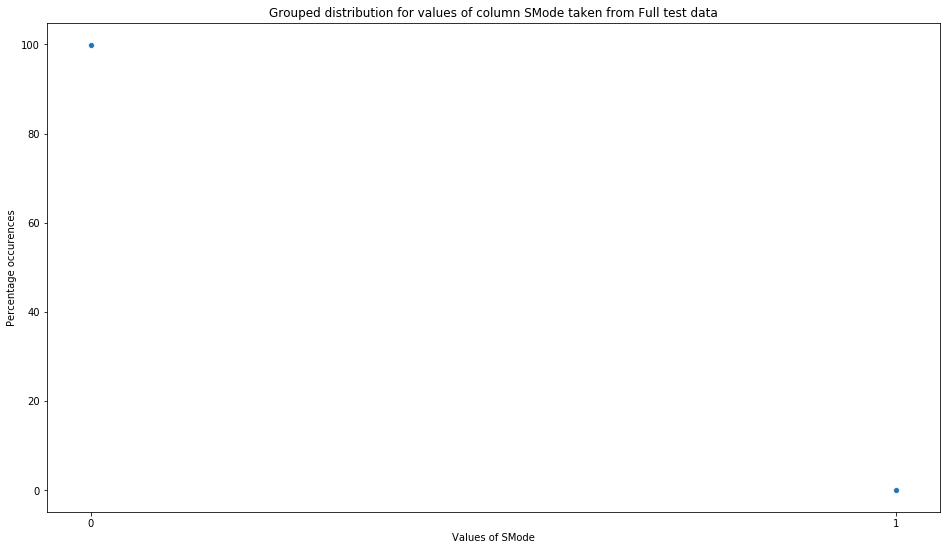

In [372]:
handle_boolean_data(train_train_new, validation_train_new, train, test, 'SMode')

In [373]:
train_train_new.Firewall.isna().sum()/len(train_train_new)

0.01023302461222112

###### Data description for Firewall in Train data ########
 count     7064151
unique          2
top             1
freq      6913327
Name: Firewall, dtype: object 

Percentage of NA values is  1.023302461222112 

###### Data description for Firewall in Validation data ########
 count     1765982
unique          2
top             1
freq      1727687
Name: Firewall, dtype: object 

Percentage of NA values is  1.0264546765476823 

###### Data description for Firewall in Full train data ########
 count     8830133
unique          2
top             1
freq      8641014
Name: Firewall, dtype: object 

Percentage of NA values is  1.0239329044285574 

###### Data description for Firewall in Full test data ########
 count     7794781
unique          2
top             1
freq      7629355
Name: Firewall, dtype: object 

Percentage of NA values is  0.7445577011207967 

Most frequent value is  1
Most frequent value is  1


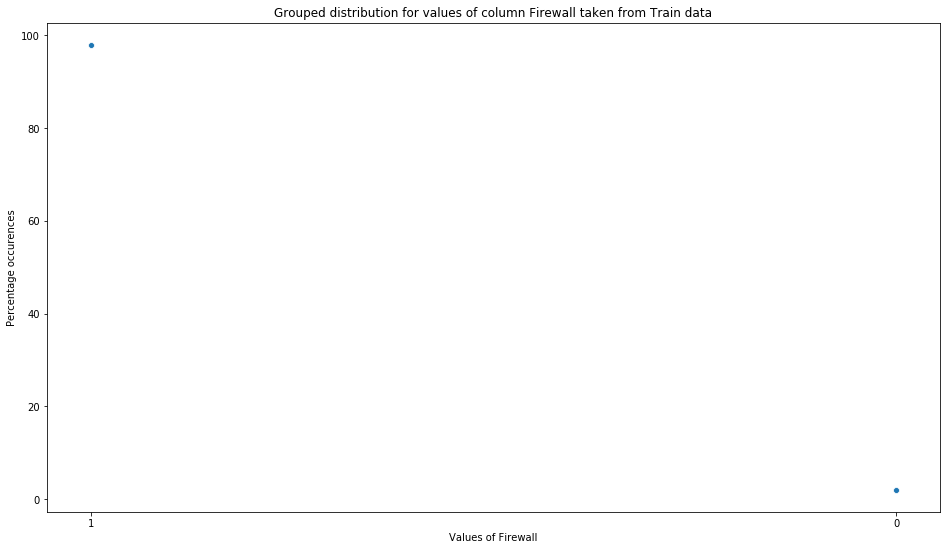

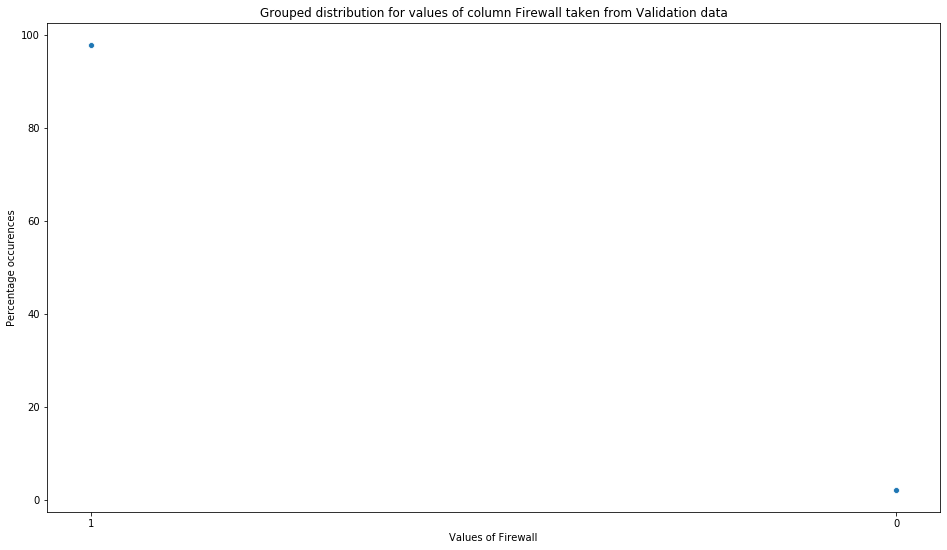

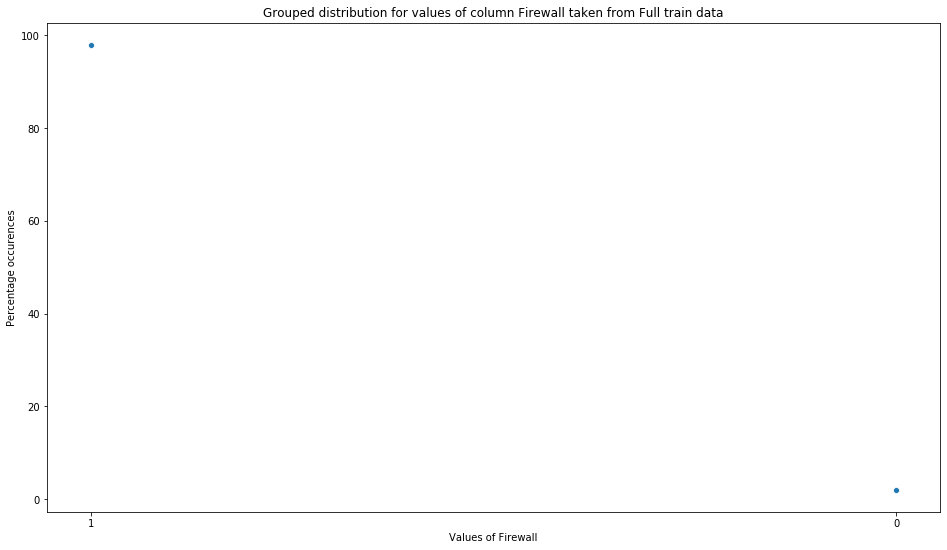

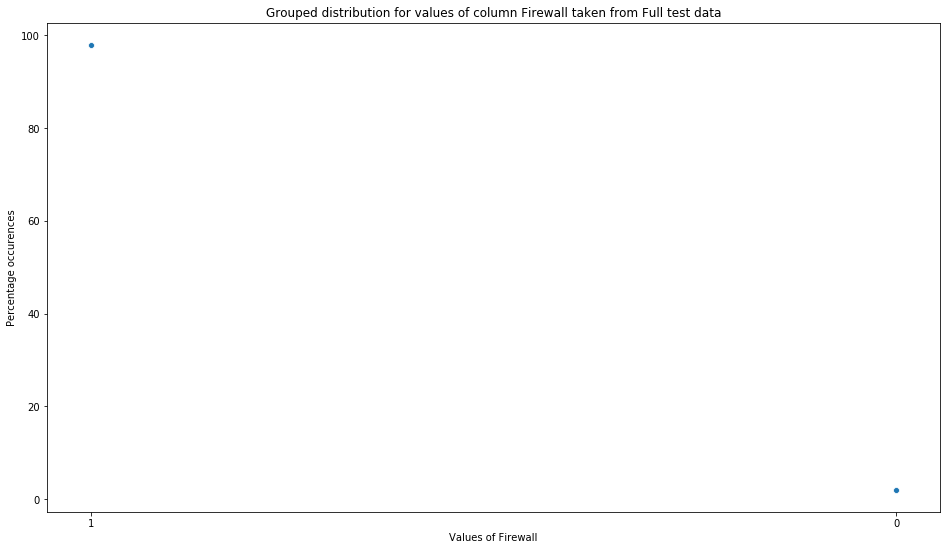

In [374]:
handle_boolean_data(train_train_new, validation_train_new, train, test, 'Firewall')

In [375]:
train_train_new.Census_HasOpticalDiskDrive.isna().sum()/len(train_train_new)

0.0

###### Data description for Census_HasOpticalDiskDrive in Train data ########
 count     7137186
unique          2
top             0
freq      6585808
Name: Census_HasOpticalDiskDrive, dtype: object 

Percentage of NA values is  0.0 

###### Data description for Census_HasOpticalDiskDrive in Validation data ########
 count     1784297
unique          2
top             0
freq      1647050
Name: Census_HasOpticalDiskDrive, dtype: object 

Percentage of NA values is  0.0 

###### Data description for Census_HasOpticalDiskDrive in Full train data ########
 count     8921483
unique          2
top             0
freq      8232858
Name: Census_HasOpticalDiskDrive, dtype: object 

Percentage of NA values is  0.0 

###### Data description for Census_HasOpticalDiskDrive in Full test data ########
 count     7853253
unique          2
top             0
freq      7321932
Name: Census_HasOpticalDiskDrive, dtype: object 

Percentage of NA values is  0.0 

Most frequent value is  0
Most frequent value 

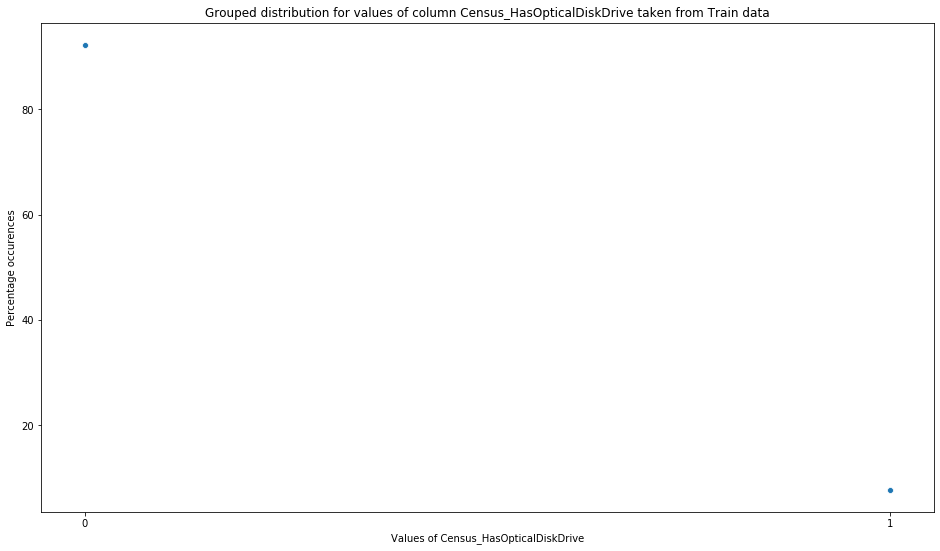

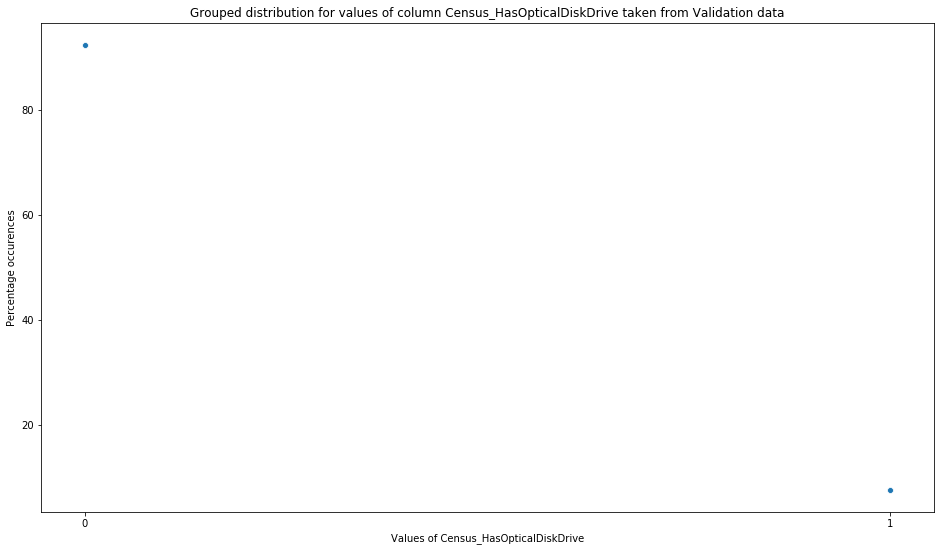

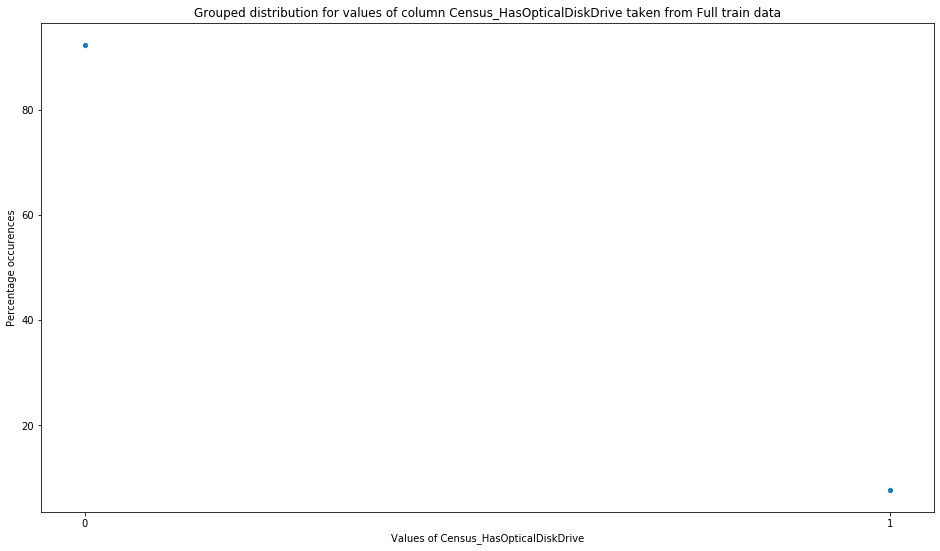

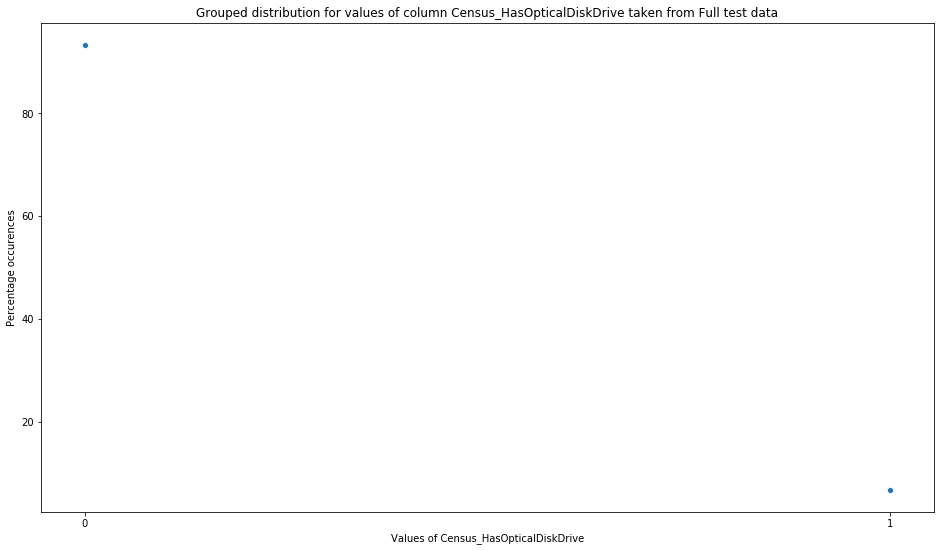

In [376]:
handle_boolean_data(train_train_new, validation_train_new, train, test, 'Census_HasOpticalDiskDrive')

In [377]:
train_train_new.Census_IsPortableOperatingSystem.isna().sum()/len(train_train_new)

0.0

###### Data description for Census_IsPortableOperatingSystem in Train data ########
 count     7137186
unique          2
top             0
freq      7133342
Name: Census_IsPortableOperatingSystem, dtype: object 

Percentage of NA values is  0.0 

###### Data description for Census_IsPortableOperatingSystem in Validation data ########
 count     1784297
unique          2
top             0
freq      1783277
Name: Census_IsPortableOperatingSystem, dtype: object 

Percentage of NA values is  0.0 

###### Data description for Census_IsPortableOperatingSystem in Full train data ########
 count     8921483
unique          2
top             0
freq      8916619
Name: Census_IsPortableOperatingSystem, dtype: object 

Percentage of NA values is  0.0 

###### Data description for Census_IsPortableOperatingSystem in Full test data ########
 count     7853253
unique          2
top             0
freq      7848659
Name: Census_IsPortableOperatingSystem, dtype: object 

Percentage of NA values is  0.0 

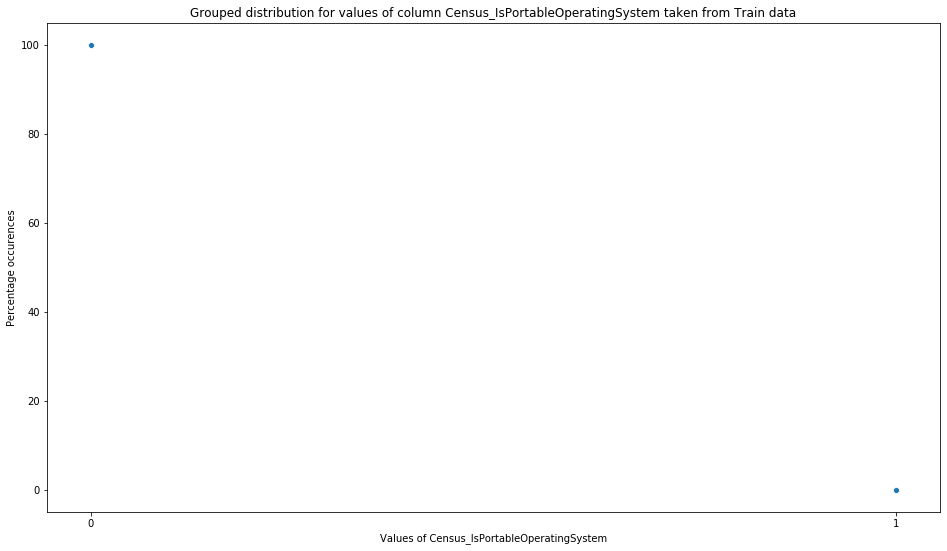

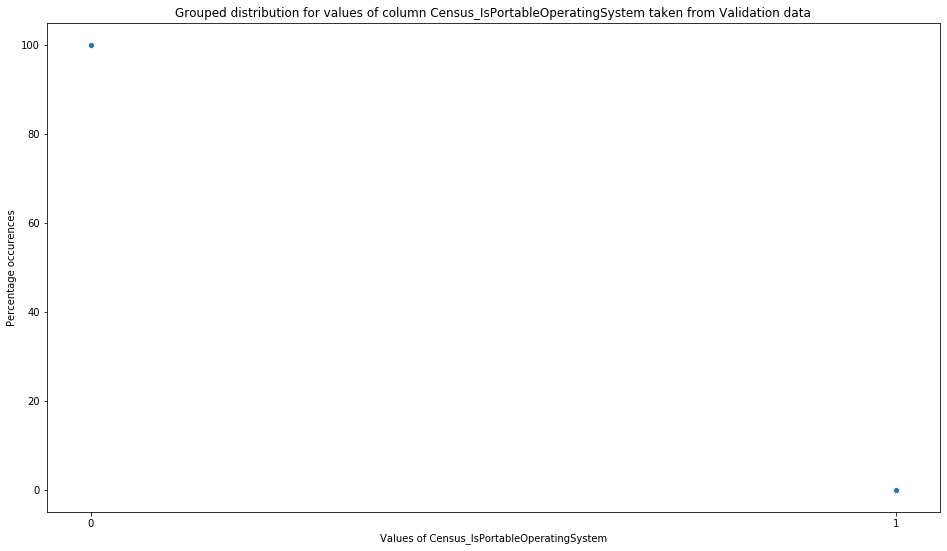

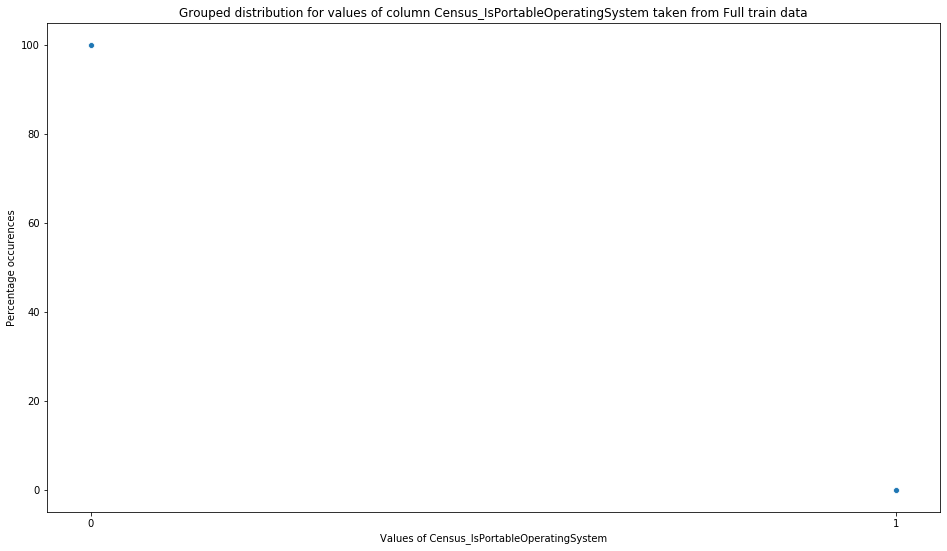

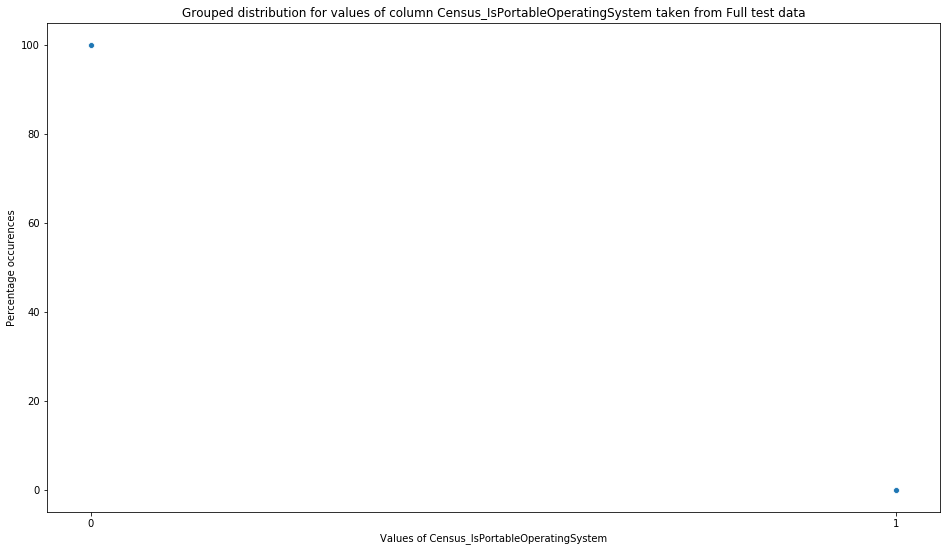

In [378]:
handle_boolean_data(train_train_new, validation_train_new, train, test, 'Census_IsPortableOperatingSystem')

In [379]:
train_train_new.Census_IsFlightsDisabled.isna().sum()/len(train_train_new)

0.017978654332393748

###### Data description for Census_IsFlightsDisabled in Train data ########
 count     7008869
unique          2
top             0
freq      7008791
Name: Census_IsFlightsDisabled, dtype: object 

Percentage of NA values is  1.7978654332393746 

###### Data description for Census_IsFlightsDisabled in Validation data ########
 count     1752091
unique          2
top             0
freq      1752081
Name: Census_IsFlightsDisabled, dtype: object 

Percentage of NA values is  1.8049685674526157 

###### Data description for Census_IsFlightsDisabled in Full train data ########
 count     8760960
unique          2
top             0
freq      8760872
Name: Census_IsFlightsDisabled, dtype: object 

Percentage of NA values is  1.799286060400496 

###### Data description for Census_IsFlightsDisabled in Full test data ########
 count     7727452
unique          2
top             0
freq      7727414
Name: Census_IsFlightsDisabled, dtype: object 

Percentage of NA values is  1.6018966917276192 

Mos

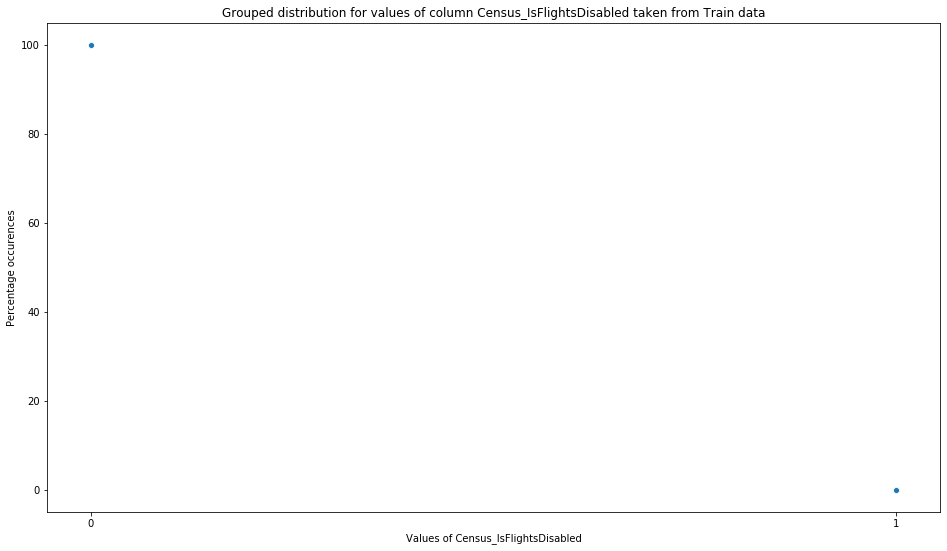

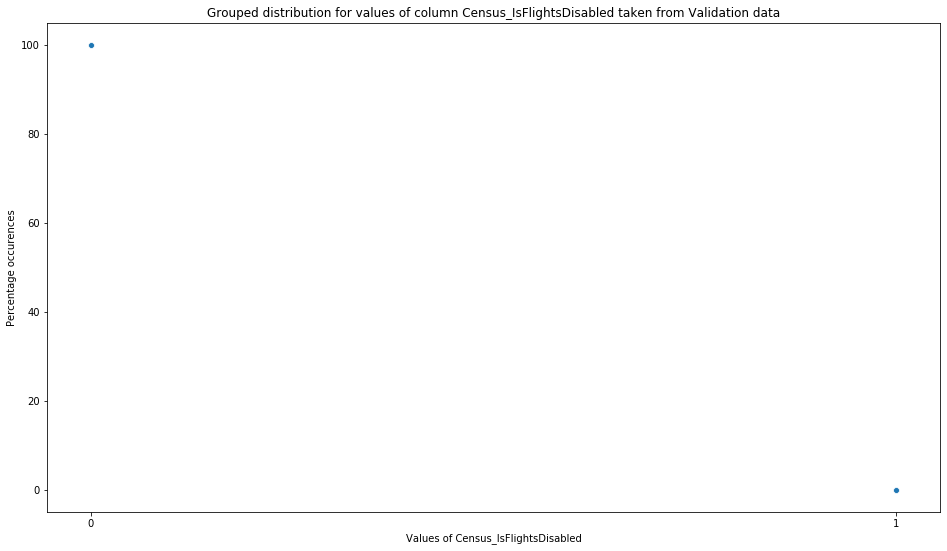

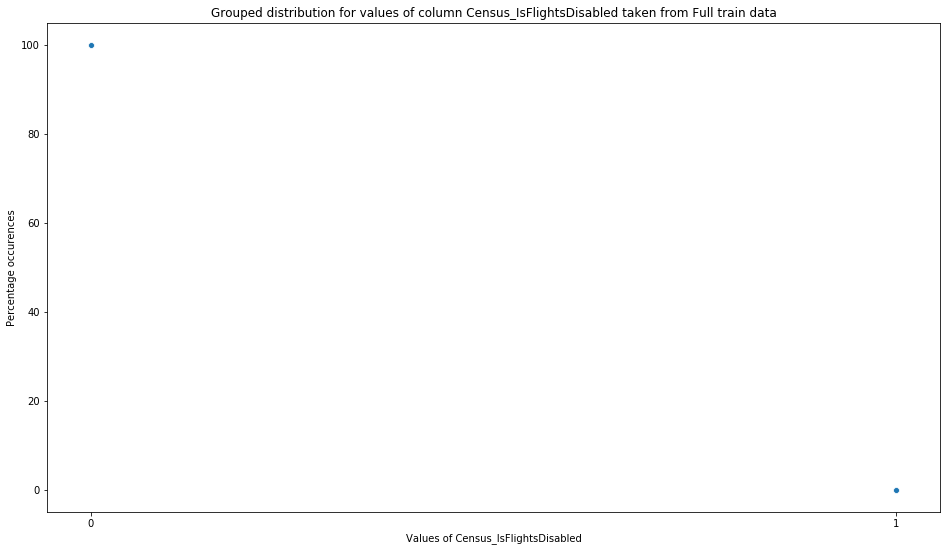

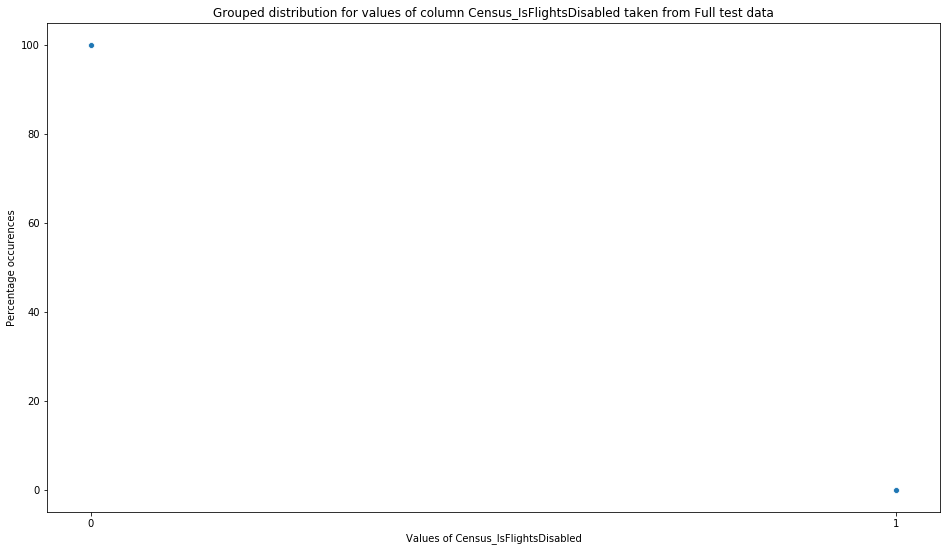

In [380]:
handle_boolean_data(train_train_new, validation_train_new, train, test, 'Census_IsFlightsDisabled')

In [381]:
train_train_new.Census_IsSecureBootEnabled.isna().sum()/len(train_train_new)

0.0

###### Data description for Census_IsSecureBootEnabled in Train data ########
 count     7137186
unique          2
top             0
freq      3668053
Name: Census_IsSecureBootEnabled, dtype: object 

Percentage of NA values is  0.0 

###### Data description for Census_IsSecureBootEnabled in Validation data ########
 count     1784297
unique          2
top             0
freq       917385
Name: Census_IsSecureBootEnabled, dtype: object 

Percentage of NA values is  0.0 

###### Data description for Census_IsSecureBootEnabled in Full train data ########
 count     8921483
unique          2
top             0
freq      4585438
Name: Census_IsSecureBootEnabled, dtype: object 

Percentage of NA values is  0.0 

###### Data description for Census_IsSecureBootEnabled in Full test data ########
 count     7853253
unique          2
top             0
freq      4308612
Name: Census_IsSecureBootEnabled, dtype: object 

Percentage of NA values is  0.0 

Most frequent value is  0
Most frequent value 

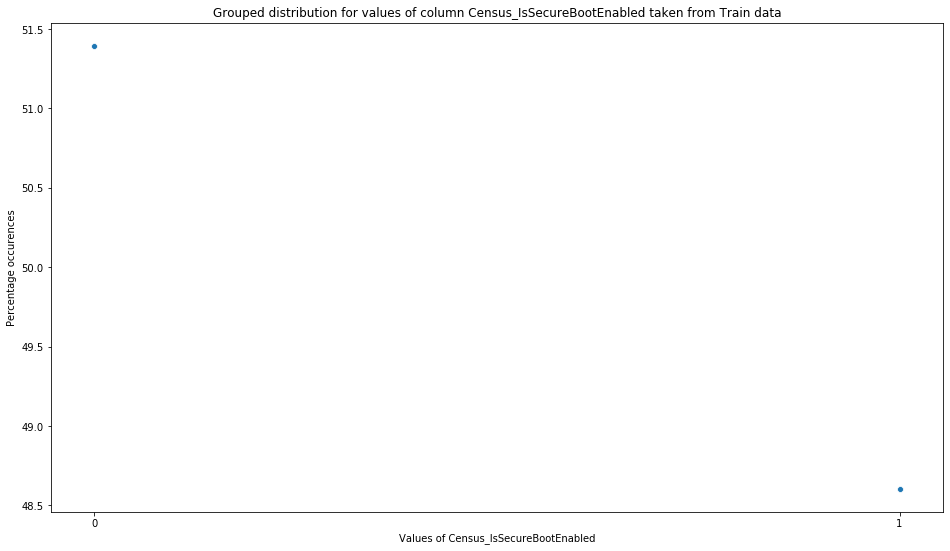

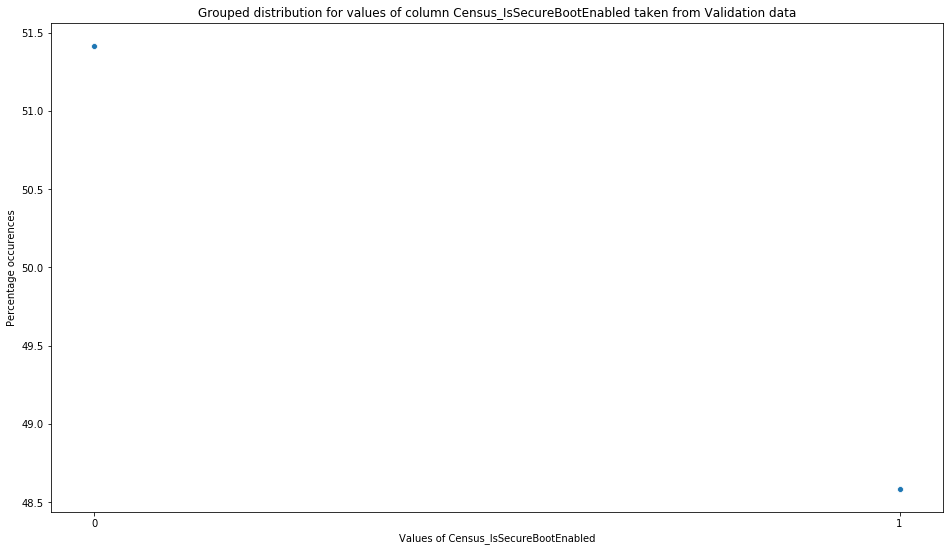

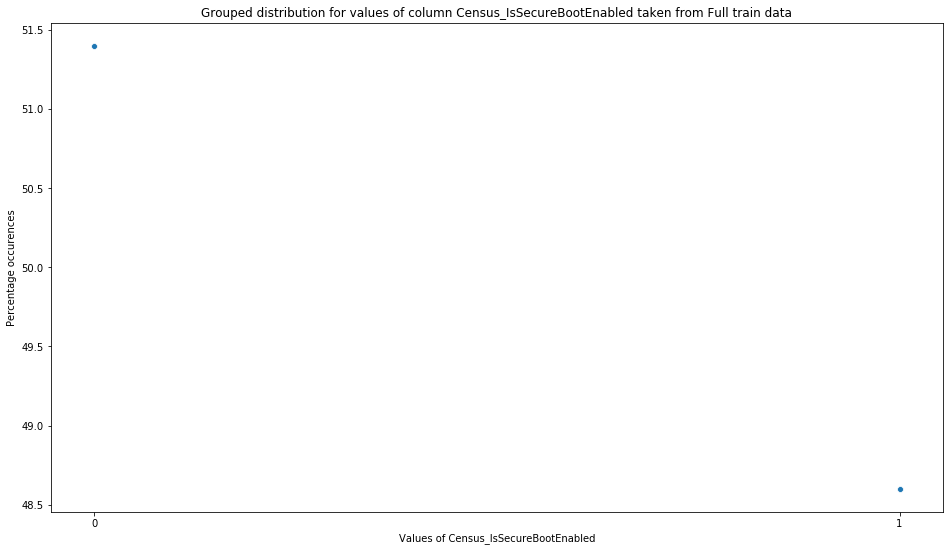

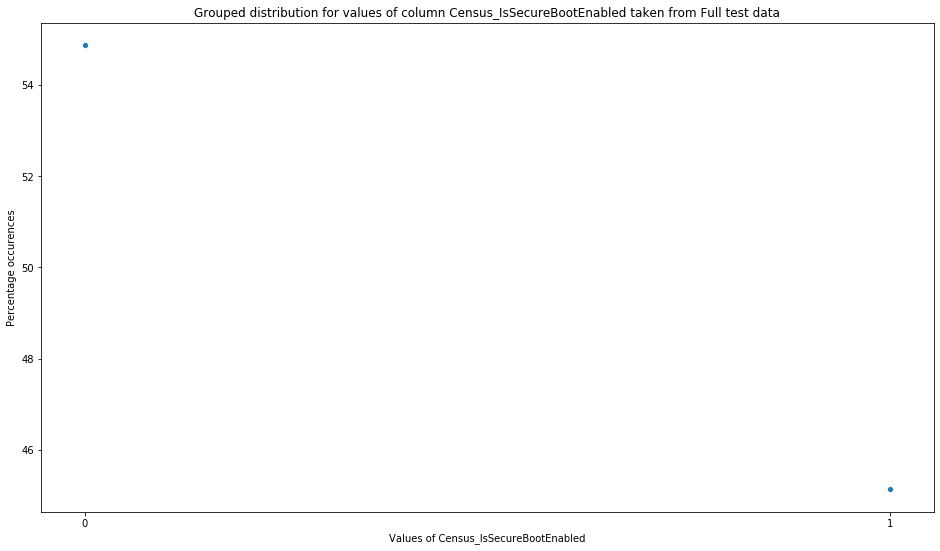

In [382]:
handle_boolean_data(train_train_new, validation_train_new, train, test, 'Census_IsSecureBootEnabled')

In [383]:
train_train_new.Census_IsVirtualDevice.isna().sum()/len(train_train_new)

0.001794544796786857

###### Data description for Census_IsVirtualDevice in Train data ########
 count     7124378
unique          2
top             0
freq      7074304
Name: Census_IsVirtualDevice, dtype: object 

Percentage of NA values is  0.1794544796786857 

###### Data description for Census_IsVirtualDevice in Validation data ########
 count     1781152
unique          2
top             0
freq      1768536
Name: Census_IsVirtualDevice, dtype: object 

Percentage of NA values is  0.17625989395263233 

###### Data description for Census_IsVirtualDevice in Full train data ########
 count     8905530
unique          2
top             0
freq      8842840
Name: Census_IsVirtualDevice, dtype: object 

Percentage of NA values is  0.17881556239024388 

###### Data description for Census_IsVirtualDevice in Full test data ########
 count     7835962
unique          2
top             0
freq      7771328
Name: Census_IsVirtualDevice, dtype: object 

Percentage of NA values is  0.22017627599671116 

Most frequent v

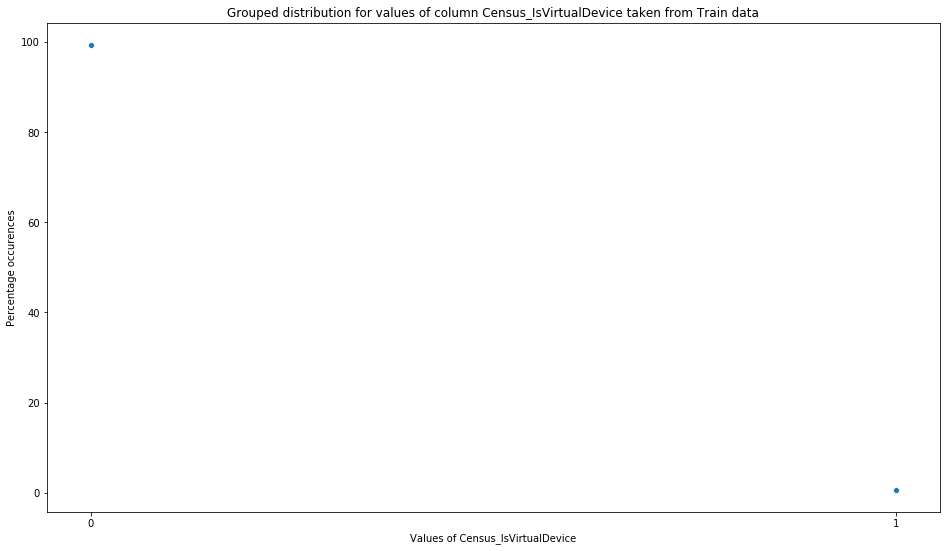

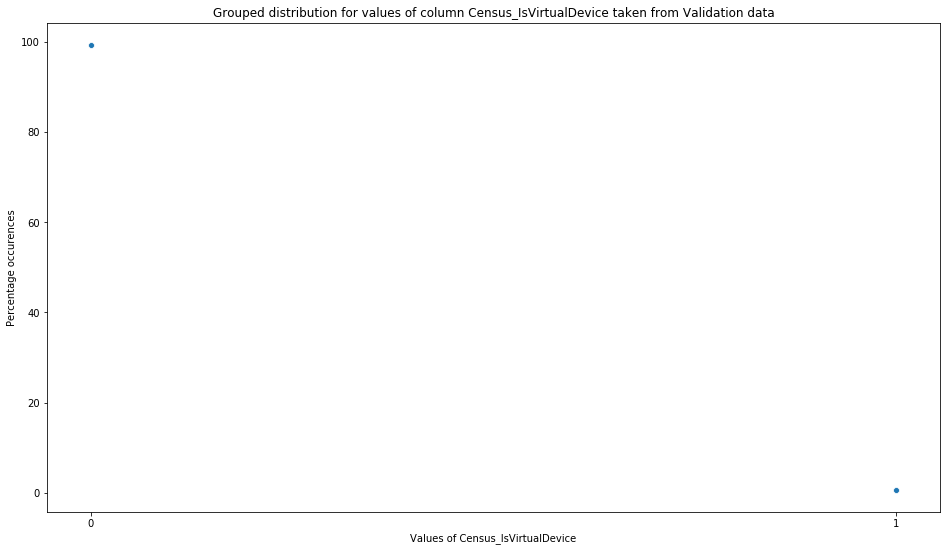

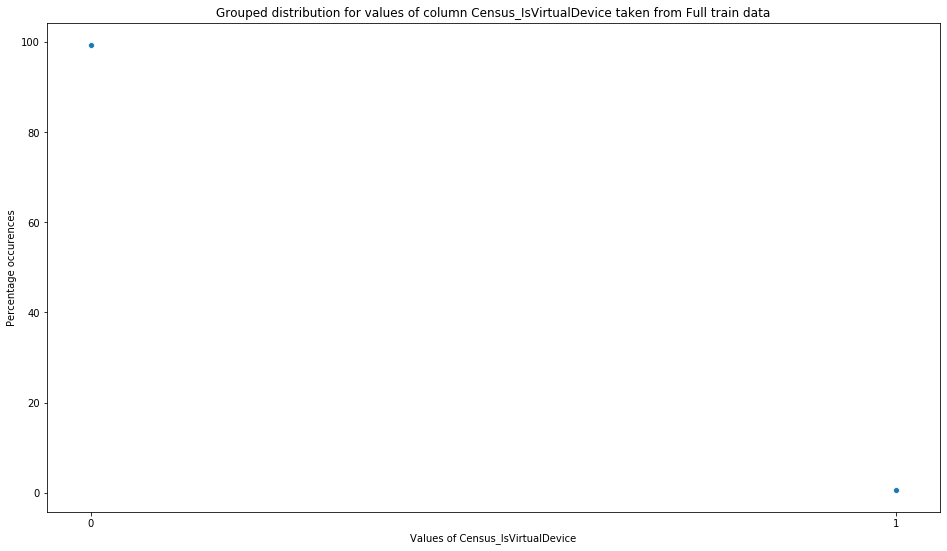

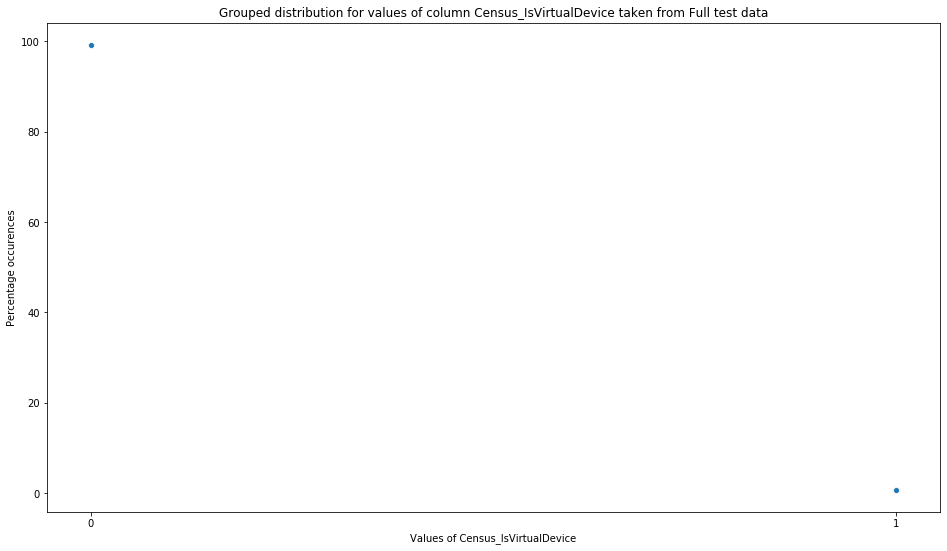

In [384]:
handle_boolean_data(train_train_new, validation_train_new, train, test, 'Census_IsVirtualDevice')

In [385]:
train_train_new.Census_IsTouchEnabled.isna().sum()/len(train_train_new)

0.0

###### Data description for Census_IsTouchEnabled in Train data ########
 count     7137186
unique          2
top             0
freq      6241133
Name: Census_IsTouchEnabled, dtype: object 

Percentage of NA values is  0.0 

###### Data description for Census_IsTouchEnabled in Validation data ########
 count     1784297
unique          2
top             0
freq      1560319
Name: Census_IsTouchEnabled, dtype: object 

Percentage of NA values is  0.0 

###### Data description for Census_IsTouchEnabled in Full train data ########
 count     8921483
unique          2
top             0
freq      7801452
Name: Census_IsTouchEnabled, dtype: object 

Percentage of NA values is  0.0 

###### Data description for Census_IsTouchEnabled in Full test data ########
 count     7853253
unique          2
top             0
freq      6924286
Name: Census_IsTouchEnabled, dtype: object 

Percentage of NA values is  0.0 

Most frequent value is  0
Most frequent value is  0


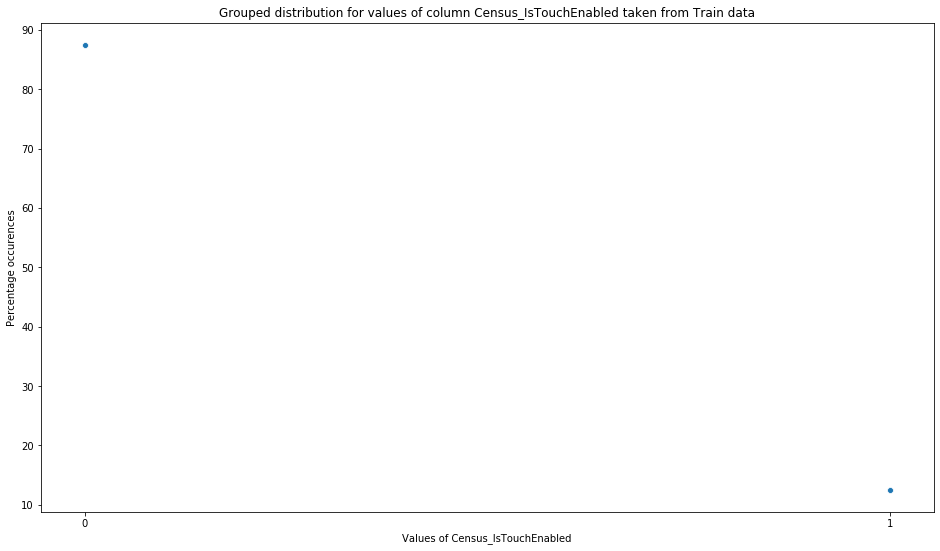

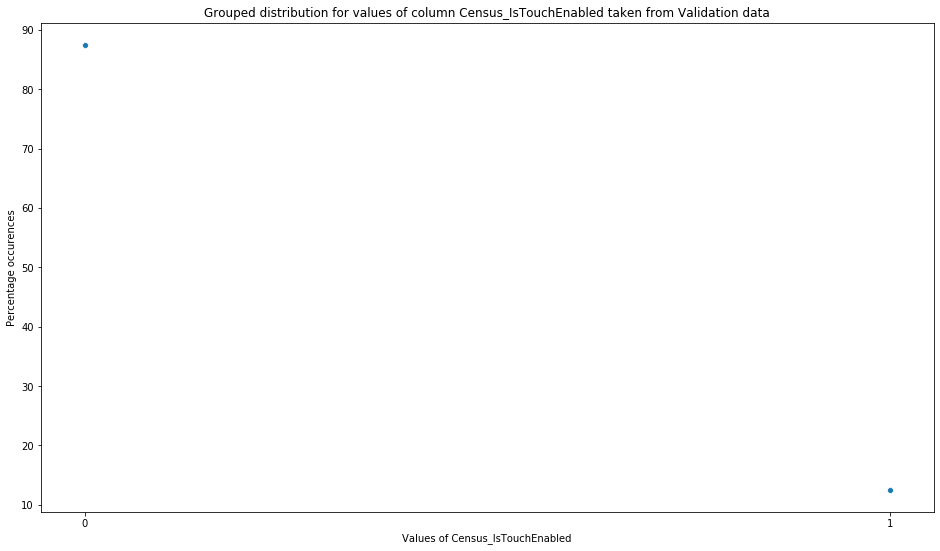

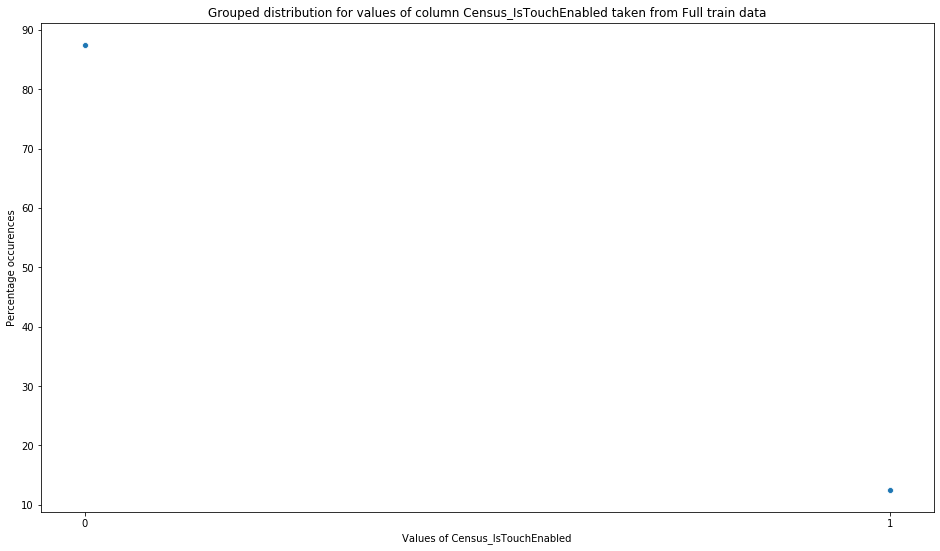

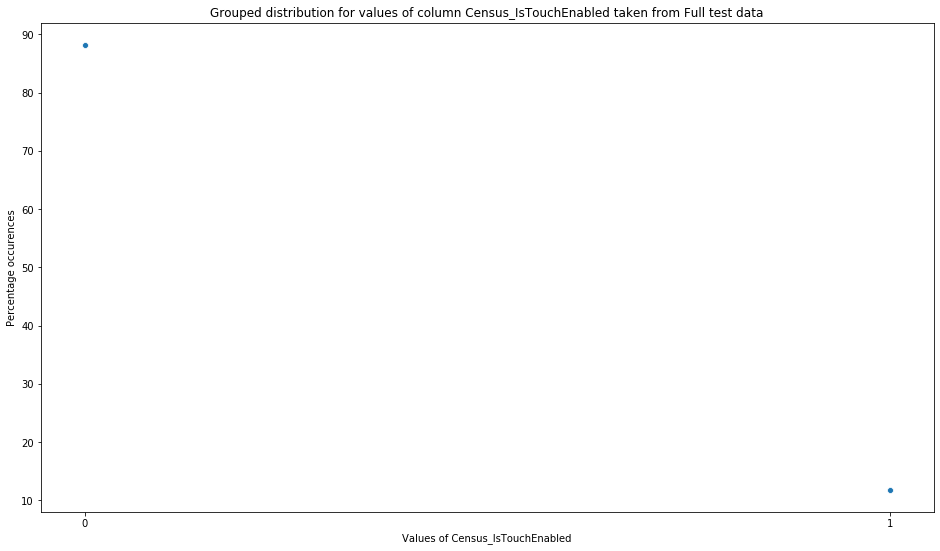

In [386]:
handle_boolean_data(train_train_new, validation_train_new, train, test, 'Census_IsTouchEnabled')

In [387]:
train_train_new.Census_IsPenCapable.isna().sum()/len(train_train_new)

0.0

###### Data description for Census_IsPenCapable in Train data ########
 count     7137186
unique          2
top             0
freq      6865453
Name: Census_IsPenCapable, dtype: object 

Percentage of NA values is  0.0 

###### Data description for Census_IsPenCapable in Validation data ########
 count     1784297
unique          2
top             0
freq      1716381
Name: Census_IsPenCapable, dtype: object 

Percentage of NA values is  0.0 

###### Data description for Census_IsPenCapable in Full train data ########
 count     8921483
unique          2
top             0
freq      8581834
Name: Census_IsPenCapable, dtype: object 

Percentage of NA values is  0.0 

###### Data description for Census_IsPenCapable in Full test data ########
 count     7853253
unique          2
top             0
freq      7555266
Name: Census_IsPenCapable, dtype: object 

Percentage of NA values is  0.0 

Most frequent value is  0
Most frequent value is  0


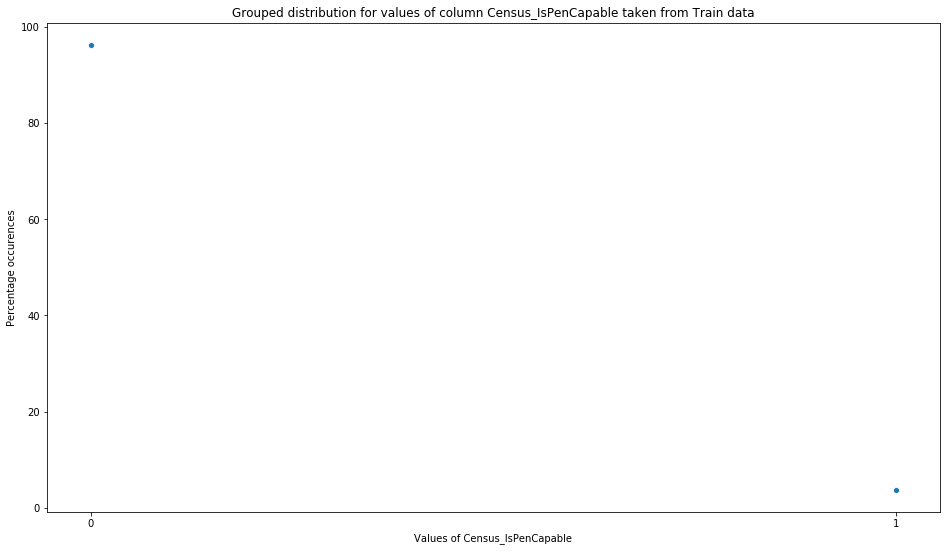

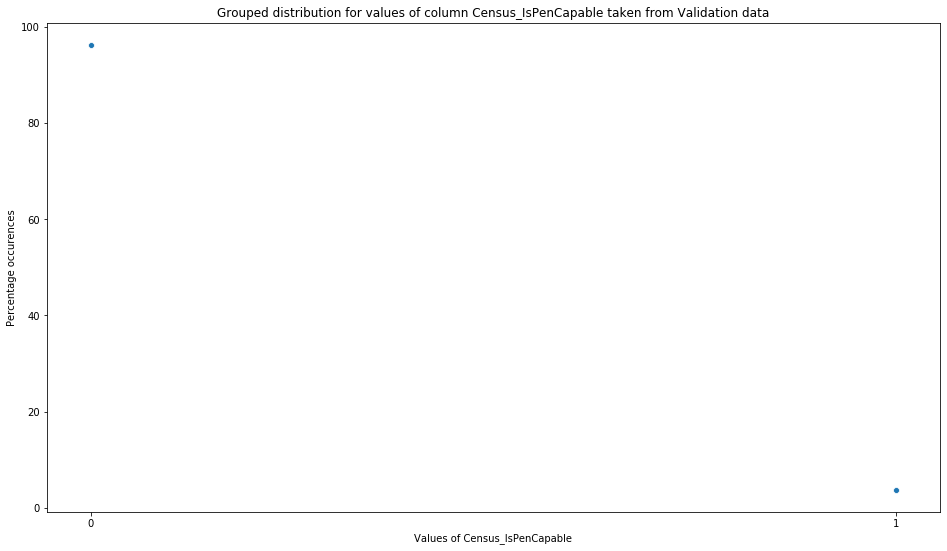

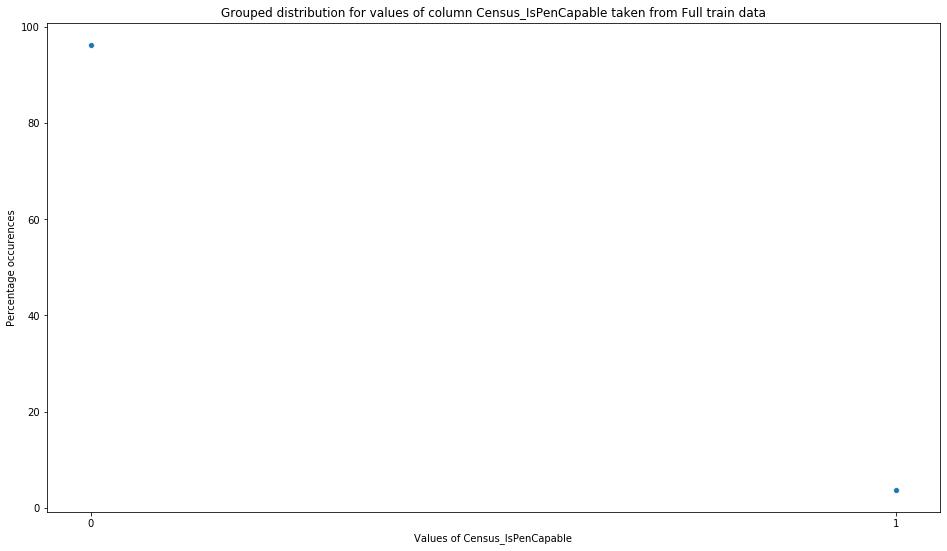

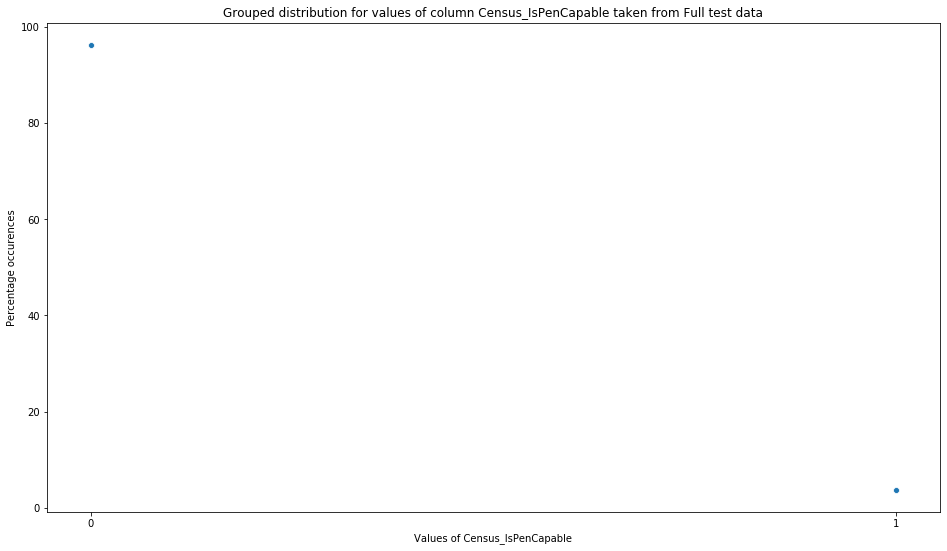

In [388]:
handle_boolean_data(train_train_new, validation_train_new, train, test, 'Census_IsPenCapable')

In [389]:
train_train_new.Census_IsAlwaysOnAlwaysConnectedCapable.isna().sum()/len(train_train_new)

0.007992785952334715

###### Data description for Census_IsAlwaysOnAlwaysConnectedCapable in Train data ########
 count     7080140
unique          2
top             0
freq      6673761
Name: Census_IsAlwaysOnAlwaysConnectedCapable, dtype: object 

Percentage of NA values is  0.7992785952334716 

###### Data description for Census_IsAlwaysOnAlwaysConnectedCapable in Validation data ########
 count     1770000
unique          2
top             0
freq      1668211
Name: Census_IsAlwaysOnAlwaysConnectedCapable, dtype: object 

Percentage of NA values is  0.8012679503468313 

###### Data description for Census_IsAlwaysOnAlwaysConnectedCapable in Full train data ########
 count     8850140
unique          2
top             0
freq      8341972
Name: Census_IsAlwaysOnAlwaysConnectedCapable, dtype: object 

Percentage of NA values is  0.7996764663453374 

###### Data description for Census_IsAlwaysOnAlwaysConnectedCapable in Full test data ########
 count     7763101
unique          2
top             0
freq      73

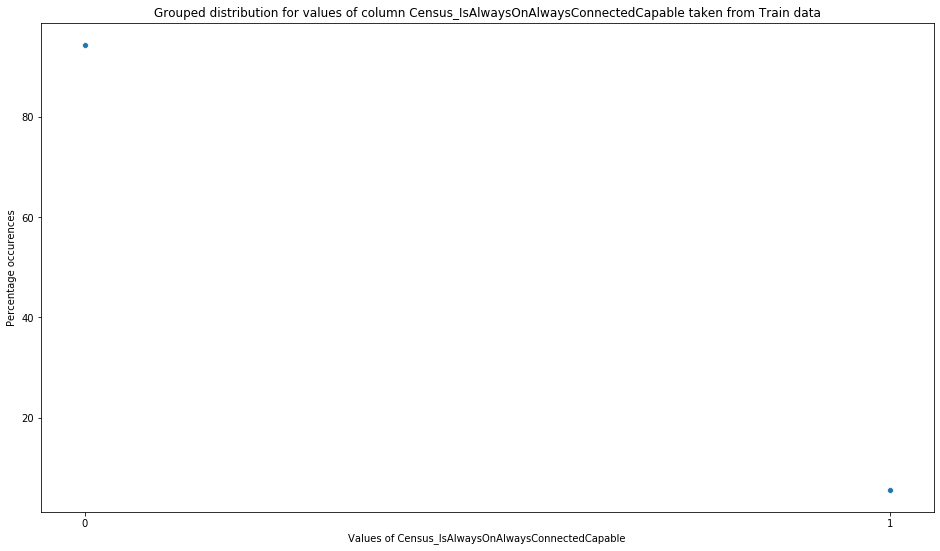

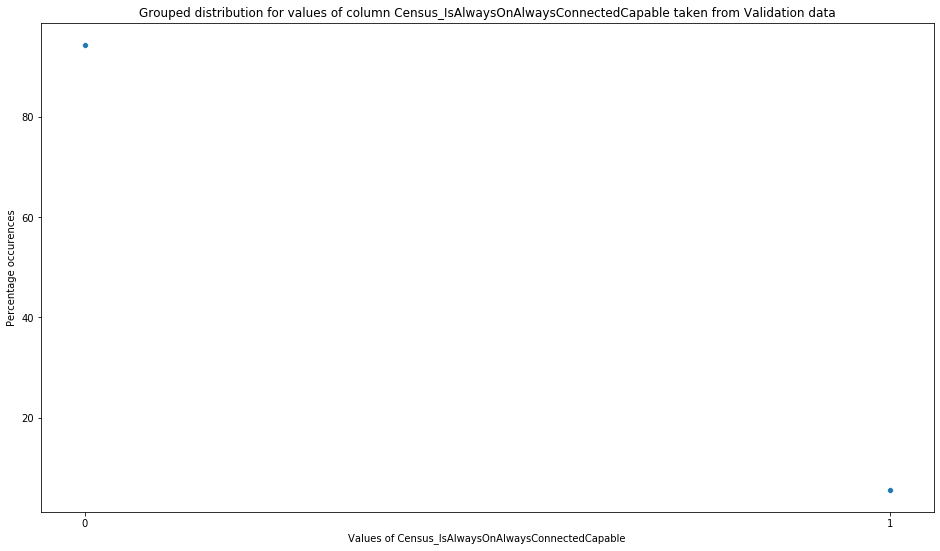

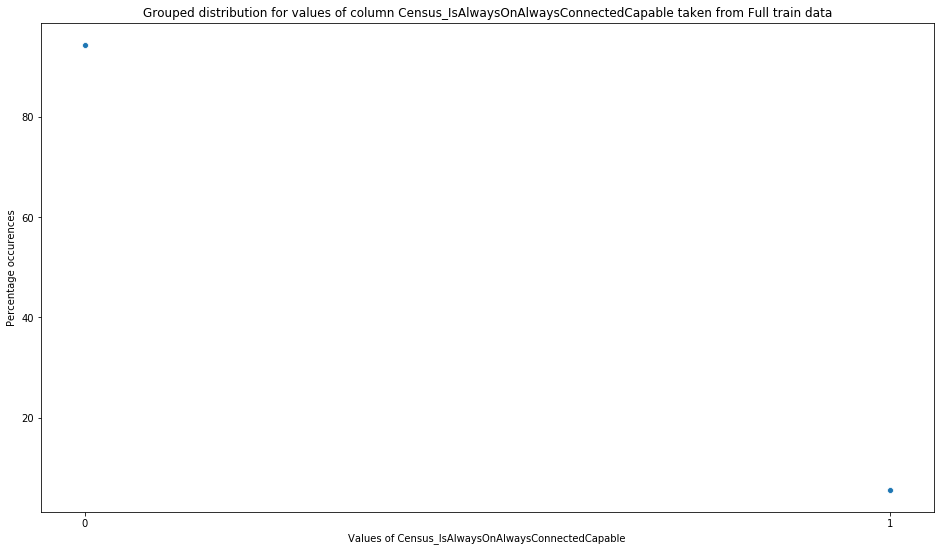

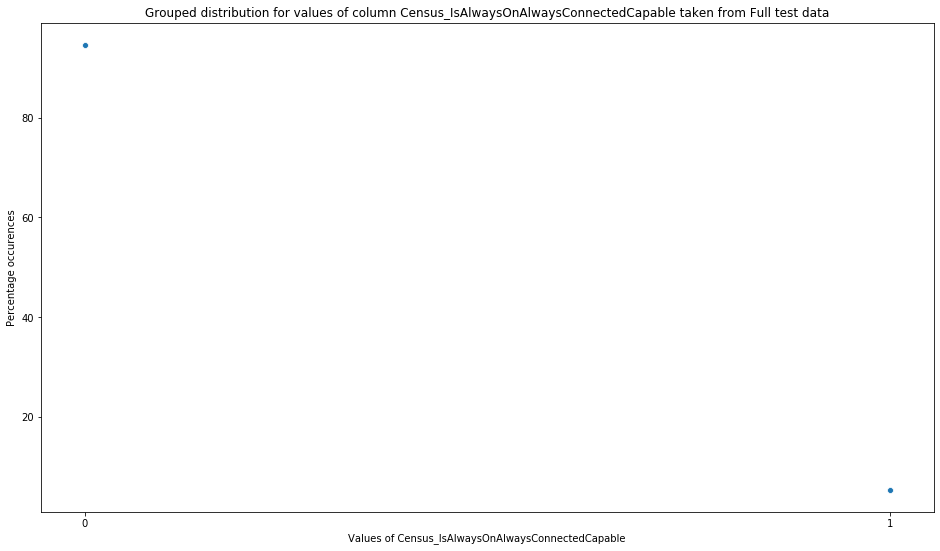

In [390]:
handle_boolean_data(train_train_new, validation_train_new, train, test, 'Census_IsAlwaysOnAlwaysConnectedCapable')

In [391]:
train_train_new.Wdft_IsGamer.isna().sum()/len(train_train_new)

0.033998133157801966

###### Data description for Wdft_IsGamer in Train data ########
 count     6894535
unique          2
top             0
freq      4939786
Name: Wdft_IsGamer, dtype: object 

Percentage of NA values is  3.3998133157801966 

###### Data description for Wdft_IsGamer in Validation data ########
 count     1723497
unique          2
top             0
freq      1234357
Name: Wdft_IsGamer, dtype: object 

Percentage of NA values is  3.4075044681462785 

###### Data description for Wdft_IsGamer in Full train data ########
 count     8618032
unique          2
top             0
freq      6174143
Name: Wdft_IsGamer, dtype: object 

Percentage of NA values is  3.4013515465982507 

###### Data description for Wdft_IsGamer in Full test data ########
 count     7550396
unique          2
top             0
freq      5302612
Name: Wdft_IsGamer, dtype: object 

Percentage of NA values is  3.8564528609991298 

Most frequent value is  0
Most frequent value is  0


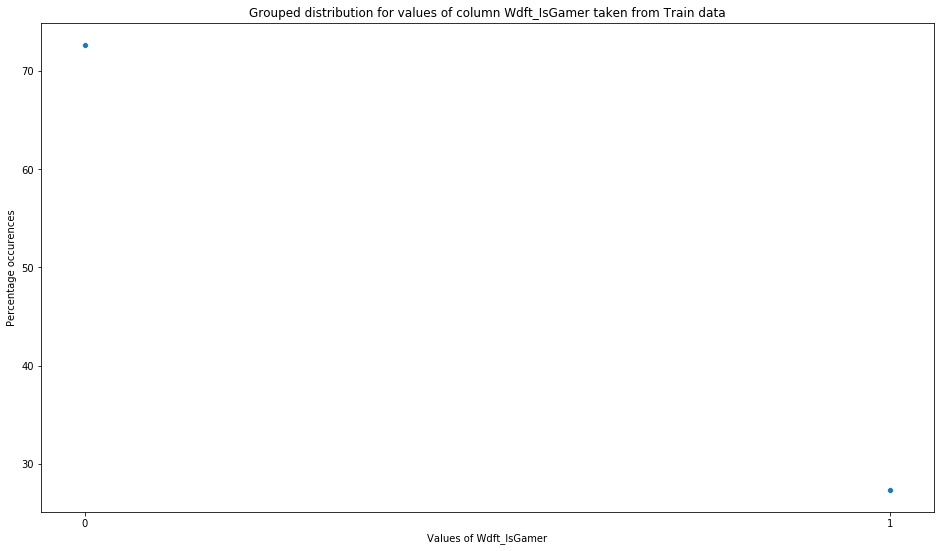

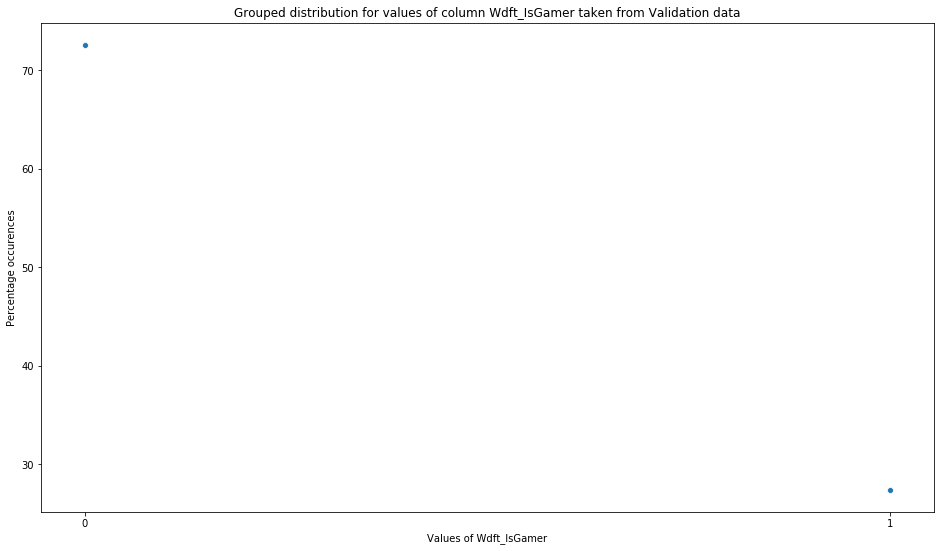

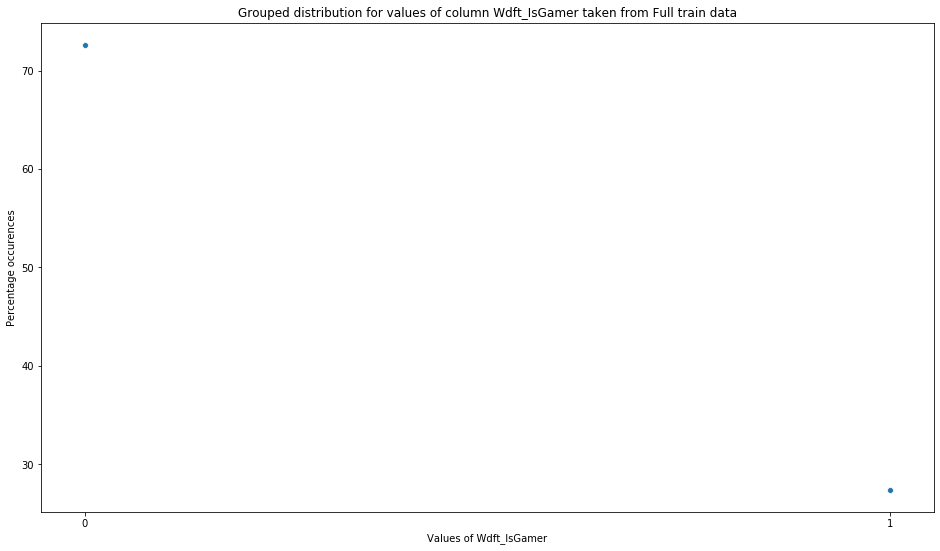

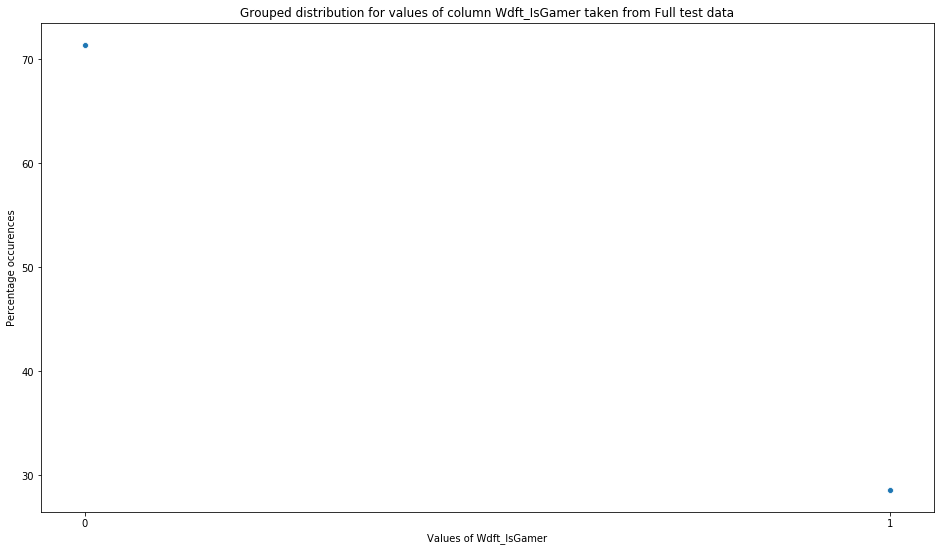

In [392]:
handle_boolean_data(train_train_new, validation_train_new, train, test, 'Wdft_IsGamer')

### Writing processed train and validation set to separate files.

In [393]:
train_train_new.columns

Index(['ProductName', 'EngineVersion', 'AppVersion', 'AvSigVersion', 'IsBeta',
       'AVProductStatesIdentifier', 'HasTpm', 'CountryIdentifier',
       'CityIdentifier', 'GeoNameIdentifier', 'LocaleEnglishNameIdentifier',
       'Platform', 'Processor', 'OsVer', 'OsBuild', 'OsSuite',
       'OsPlatformSubRelease', 'OsBuildLab', 'SkuEdition', 'IsProtected',
       'AutoSampleOptIn', 'SMode', 'Firewall', 'UacLuaenable',
       'Census_MDC2FormFactor', 'Census_DeviceFamily',
       'Census_ProcessorCoreCount', 'Census_PrimaryDiskTotalCapacity',
       'Census_PrimaryDiskTypeName', 'Census_SystemVolumeTotalCapacity',
       'Census_HasOpticalDiskDrive', 'Census_TotalPhysicalRAM',
       'Census_ChassisTypeName',
       'Census_InternalPrimaryDiagonalDisplaySizeInInches',
       'Census_InternalPrimaryDisplayResolutionHorizontal',
       'Census_InternalPrimaryDisplayResolutionVertical',
       'Census_PowerPlatformRoleName', 'Census_OSVersion',
       'Census_OSArchitecture', 'Census_OSBr

In [ ]:
ts = time.time()

PROCESSED_INPUT_DIR = '../processed_input/'
train_train_new.to_csv(PROCESSED_INPUT_DIR + 'train.csv', index=False)
validation_train_new.to_csv(PROCESSED_INPUT_DIR + 'validation.csv', index=False)

time.time() - ts

### Ignore this section if you are not aware of it's purpose

The idea is to generate training and test files, having only the columns which are used in the final model. This way, we can minimize the time taken for input/output and build models on the entire training data faster.

We do the necessary transformations to obtain desired columns, which are used in the final model.

In [394]:
train['AVProductStatesIdentifier_53347'] = (train['AVProductStatesIdentifier'] == '53447')
test['AVProductStatesIdentifier_53347'] = (test['AVProductStatesIdentifier'] == '53447')


train['AppVersion_top'] = (train['AppVersion'] =='4.18.1807.18075')
test['AppVersion_top'] = (test['AppVersion'] =='4.18.1807.18075')

train['EngineVersion_1.1.15200.1'] = (train['EngineVersion'] =='1.1.15200.1')
test['EngineVersion_1.1.15200.1'] = (test['EngineVersion'] =='1.1.15200.1')

train['Census_OSInstallTypeName_UUPUpgrade'] = (train['Census_OSInstallTypeName'] =='UUPUpgrade')
test['Census_OSInstallTypeName_UUPUpgrade'] = (test['Census_OSInstallTypeName'] =='UUPUpgrade')


train['Census_ActivationChannel_Retail'] = (train['Census_ActivationChannel'] =='Retail') 
test['Census_ActivationChannel_Retail'] = (test['Census_ActivationChannel'] =='Retail') 

train['Census_GenuineStateName_IS_GENUINE'] = (train['Census_GenuineStateName'] =='IS_GENUINE') 
test['Census_GenuineStateName_IS_GENUINE'] = (test['Census_GenuineStateName'] =='IS_GENUINE') 


train['Census_OSSkuName_CORE'] = (train['Census_OSSkuName'] =='CORE')
test['Census_OSSkuName_CORE'] = (test['Census_OSSkuName'] =='CORE')

train['Census_PrimaryDiskTypeName_HDD'] = (train['Census_PrimaryDiskTypeName'] =='HDD')
test['Census_PrimaryDiskTypeName_HDD'] = (test['Census_PrimaryDiskTypeName'] =='HDD')

In [395]:
REL_COLS = ['AVProductStatesIdentifier_53347', 
            'Census_PrimaryDiskTotalCapacity', 
            'CountryIdentifier', 
            'Census_OSBuildRevision', 
            'Census_InternalPrimaryDiagonalDisplaySizeInInches', 
            'AppVersion_top', 
            'EngineVersion_1.1.15200.1', 
            'LocaleEnglishNameIdentifier', 
            'Census_TotalPhysicalRAM', 
            'Census_OSInstallTypeName_UUPUpgrade', 
            'Wdft_IsGamer', 
            'Census_ActivationChannel_Retail', 
            'OsBuild', 
            'OsSuite', 
            'Census_GenuineStateName_IS_GENUINE', 
            'Census_ProcessorCoreCount', 
            'IsProtected', 'Census_OSSkuName_CORE', 
            'Census_IsTouchEnabled', 
            'Census_IsSecureBootEnabled', 
            'Census_HasOpticalDiskDrive', 
            'Census_InternalPrimaryDisplayResolutionHorizontal', 
            'Firewall', 
            'Census_PrimaryDiskTypeName_HDD']

In [396]:
REL_COLS_WITH_PRED = list(REL_COLS)  + ['HasDetections']

In [397]:
REL_COLS_TEST = list(REL_COLS) + ['MachineIdentifier']

In [398]:
ts = time.time()

PROCESSED_INPUT_DIR = '../processed_input/'
#train_train_new.to_csv(PROCESSED_INPUT_DIR + 'train.csv', index=False)
#validation_train_new.to_csv(PROCESSED_INPUT_DIR + 'validation.csv', index=False)

train[REL_COLS_WITH_PRED].to_csv(
    PROCESSED_INPUT_DIR + 'final_train.csv', index=False)

test[REL_COLS_TEST].to_csv(
    PROCESSED_INPUT_DIR + 'final_test.csv', index=False)

time.time() - ts

761.0105669498444

### Let us proceed with further analysis in a new notebook.